# Policy Gradient

> <span style="color:gray">
Created by Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk)).
</span>

In this part, we will create an agent that can learn to solve tasks from OpenAI Gym by applying the Policy Gradient method. We will implement the agent with a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

Since this is a deep learning course, we will model the policy as a neural network with parameters $\theta$ and train it with gradient descent (now the name 'Policy Gradient' should start to make sense). 
When the set of available actions is discrete, we can use a network with softmax output. 

The core idea of training the policy network is simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*. 

The expectation over the (discounted) total reward, $R$, is:

$$
\mathbb{E}[R|\theta] = \int p_\theta({\bf a}|{\bf s}) R({\bf a}) d{\bf a} \ ,
$$

where ${\bf a} = a_1,\ldots,a_T$, ${\bf s}=s_1,\ldots,s_T$. 

Then we can use the gradient to maximize the total reward:

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta({\bf a}|{\bf s}) R({\bf a}) \, d{\bf a} \\
&= \int \nabla_\theta p_\theta({\bf a}|{\bf s}) R({\bf a})  \, d{\bf a} \\
&= \int p_\theta({\bf a}|{\bf s}) \nabla_\theta \log p_\theta({\bf a}|{\bf s}) R({\bf a}) \, d{\bf a} \\
&= \mathbb{E}[R({\bf a}) \nabla_\theta \log p_\theta({\bf a}|{\bf s})]
\end{align}
$$

using the identity 

$$
\nabla_\theta p_\theta({\bf a}|{\bf s}) = p_\theta({\bf a}|{\bf s}) \nabla_\theta \log p_\theta({\bf a}|{\bf s})
$$

to express the gradient as an average over $p_\theta({\bf a},{\bf s})$.

We cannot evaluate the average over roll-outs analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return the sequence of action, states and rewards. This allows us to replace the integral by a Monte Carlo average over $V$ roll-outs:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{V} \sum_{v=1}^V \nabla_\theta \log p_\theta({\bf a}^{(v)}|{\bf s}^{(v)}) R({\bf a}^{(v)}) \ .
$$

In practice, to reduce the variance of the gradient, instead of $R$, we use the adjusted discounted future reward, also known as the *advantage*, $A$:

$$
A_t = R_t - b_t \ ,
$$

where the *baseline*, $b_t$, is the (discounted) total future reward at timestep $t$ averaged over the $V$ roll-outs:

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

This way we are always encouraging and discouraging roughly half of the performed actions, which gives us the final gradient estimator:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{V} \sum_{v=1}^V \nabla_\theta \log p_\theta({\bf a}^{(v)}|{\bf s}^{(v)}) A({\bf a}^{(v)})
$$

And that's it! Please refer to [this blog post](http://karpathy.github.io/2016/05/31/rl/) by Karpathy for more discussion on the Policy Gradient method.

--

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy Gradient code

In [1]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.ops.nn import relu, softmax
import gym
from utils import Viewer

In this lab we will work with the [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) environment. Later you can change the code below to explore other [environments](https://gym.openai.com/envs/) and solve different tasks. 

*Note: The policy implemented in this notebook is designed to work on environments with a discrete action space. Extending the code to also handle environments with a continuous action space is left as an optional exercise.*

In [2]:
# create gym environment
env = gym.make('CartPole-v0')

[2017-10-23 20:25:13,981] Making new env: CartPole-v0


Let us see how the environment looks when we just take random actions.

[2017-10-23 20:25:14,182] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.



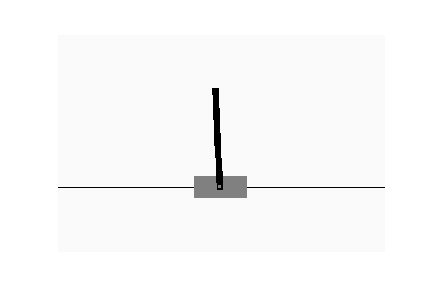
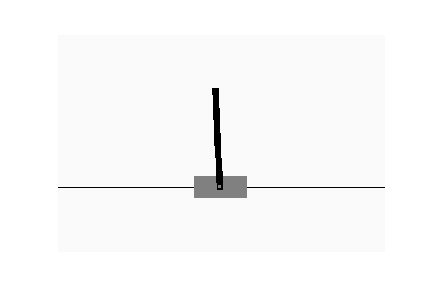
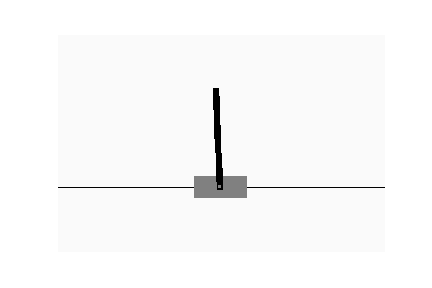
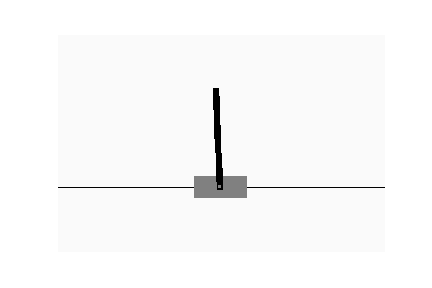
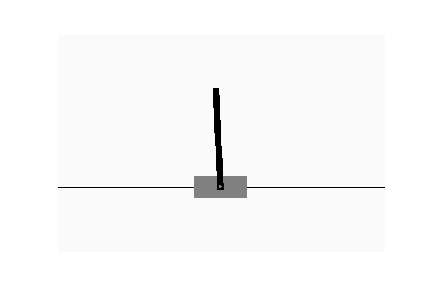
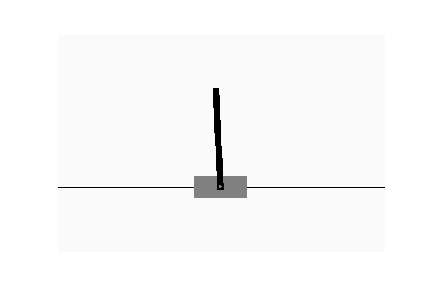
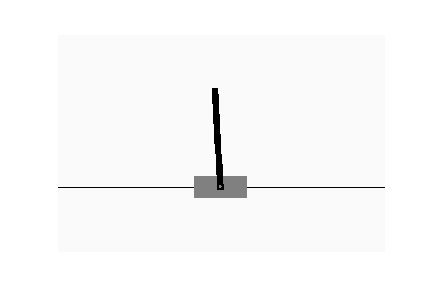
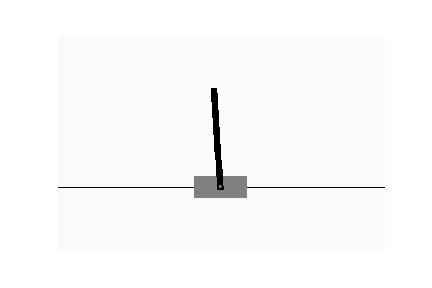
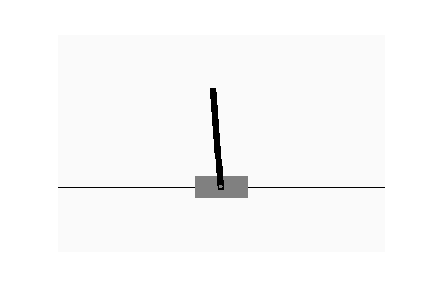
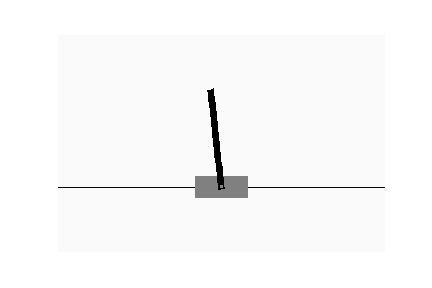
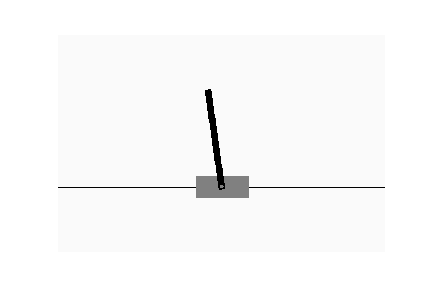
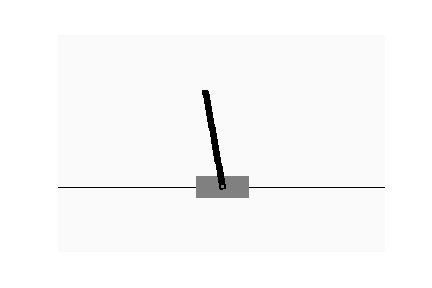
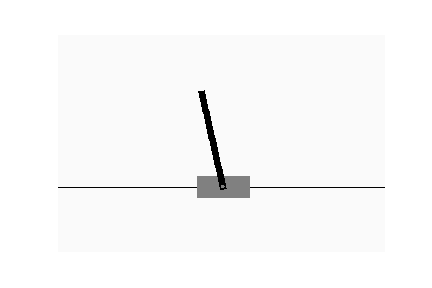
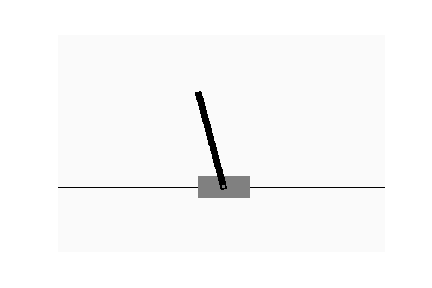
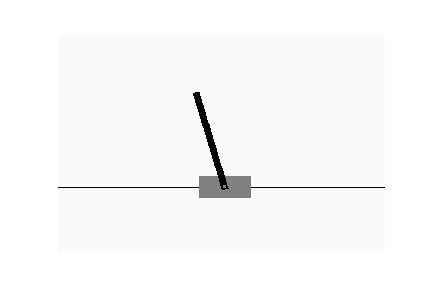
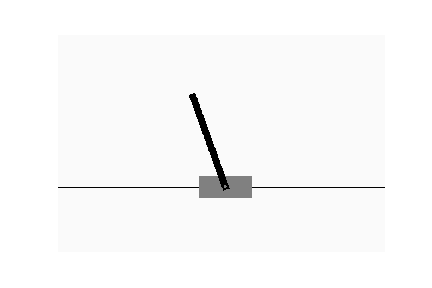
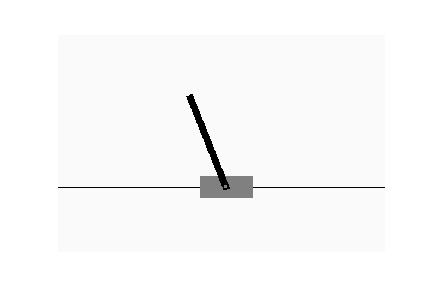
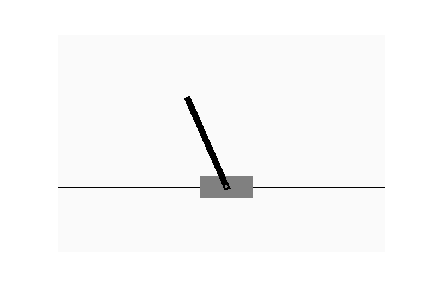
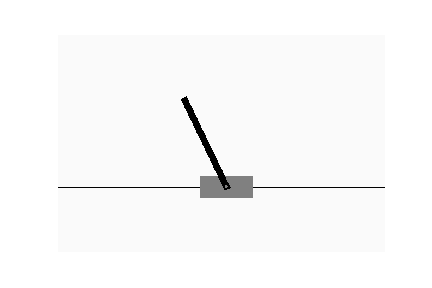
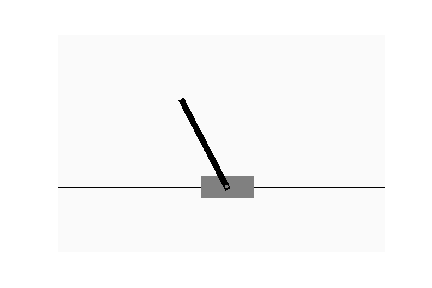
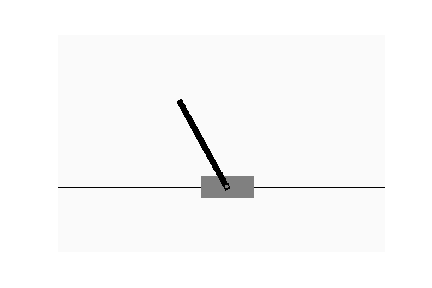
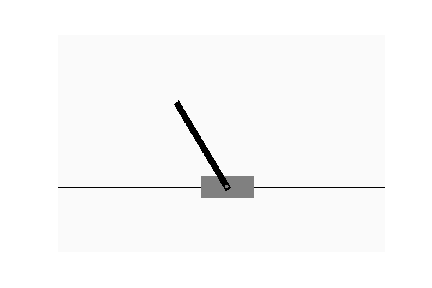
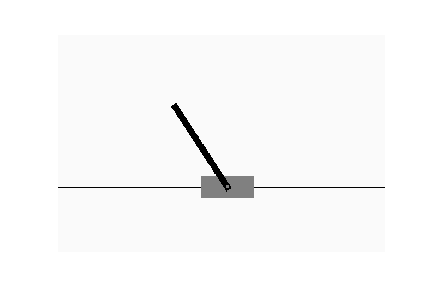
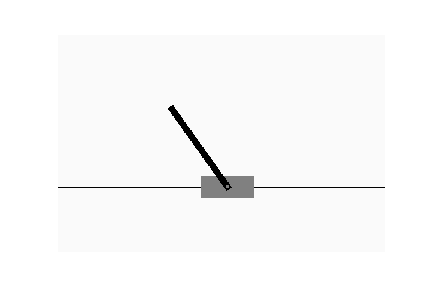
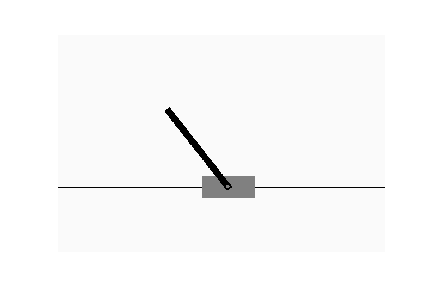
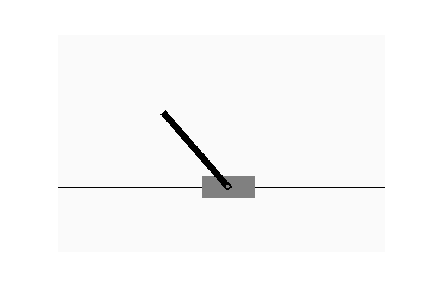
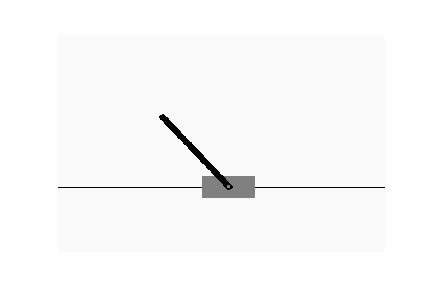
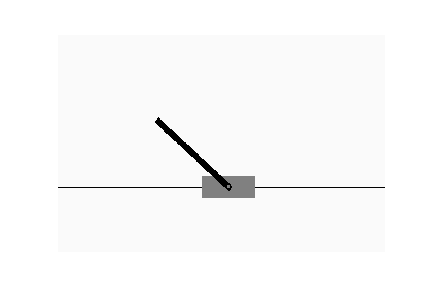
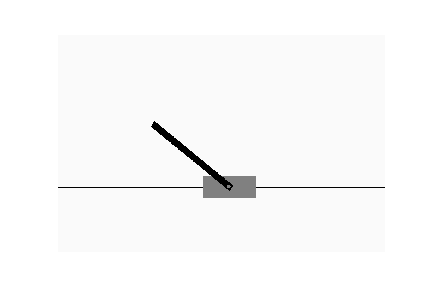
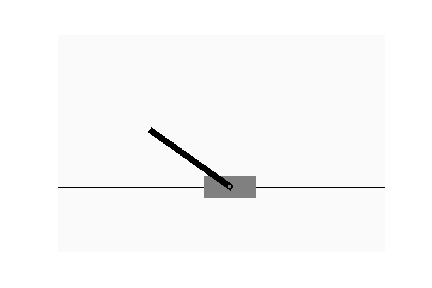
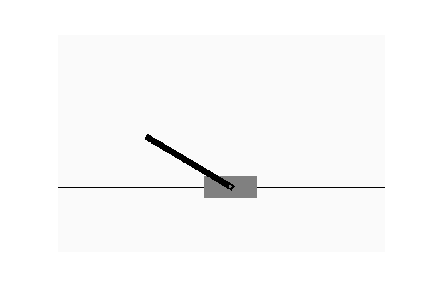
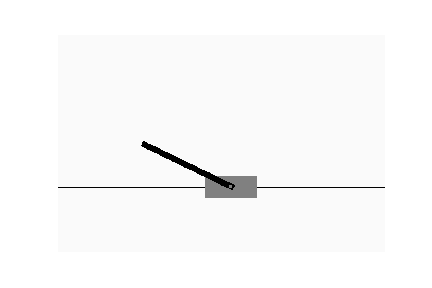
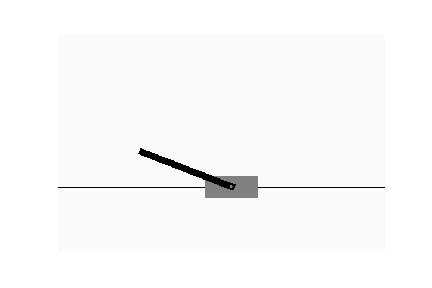
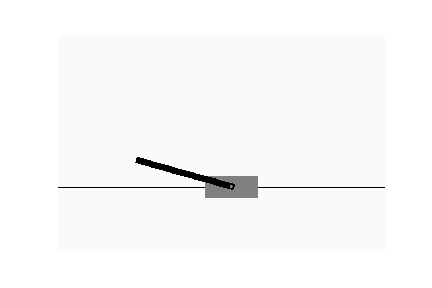
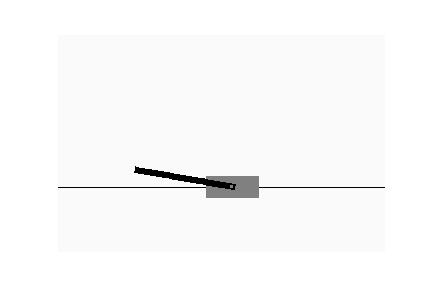
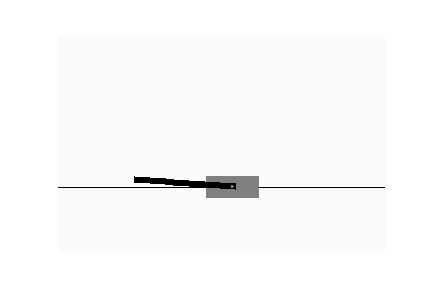
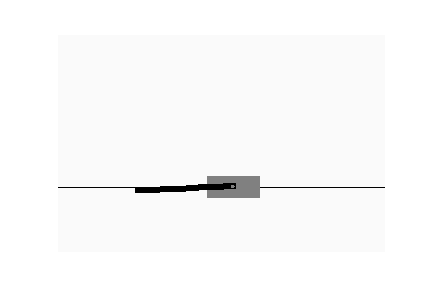
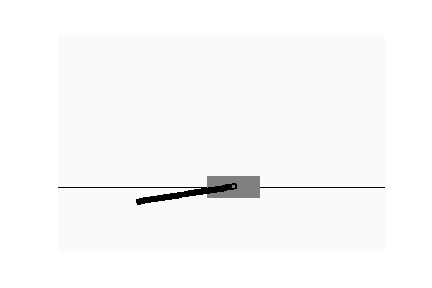
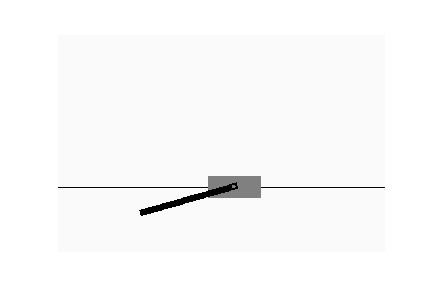
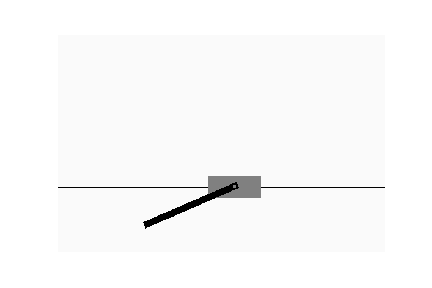
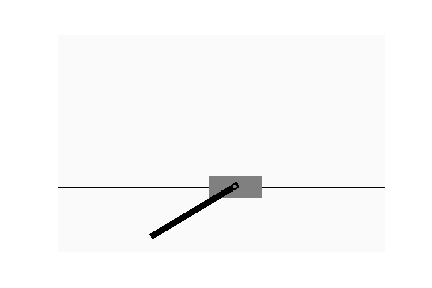
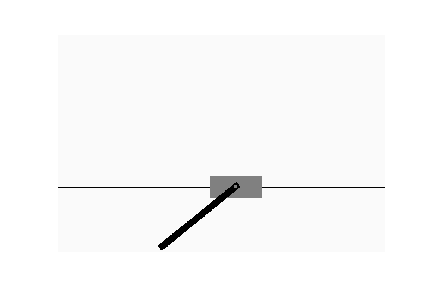
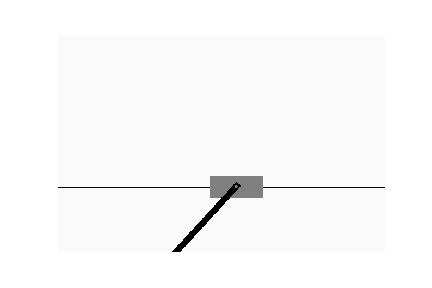
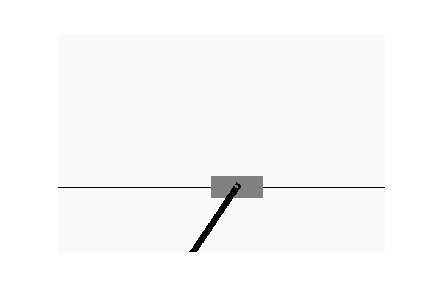
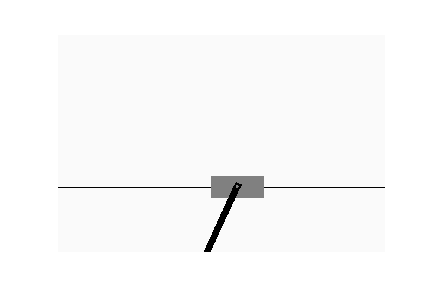
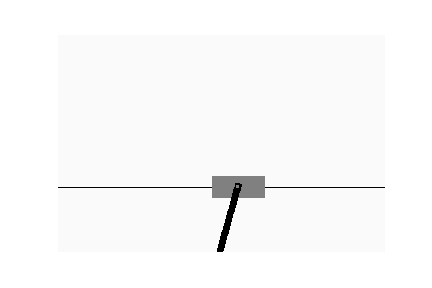
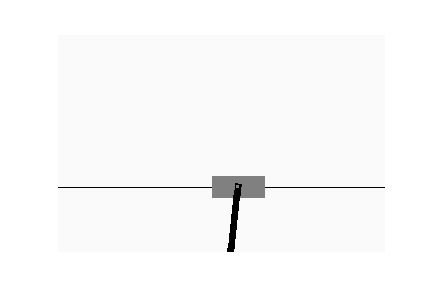
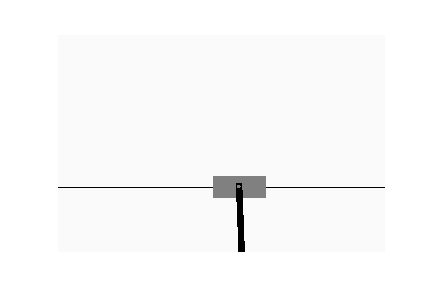
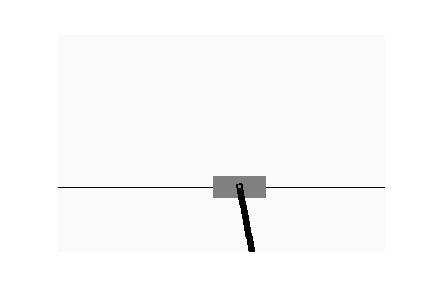
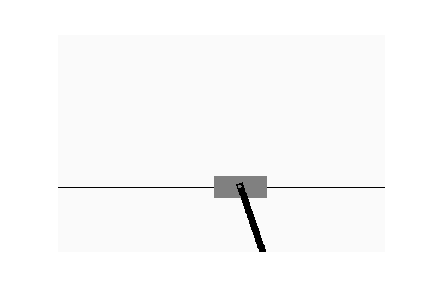
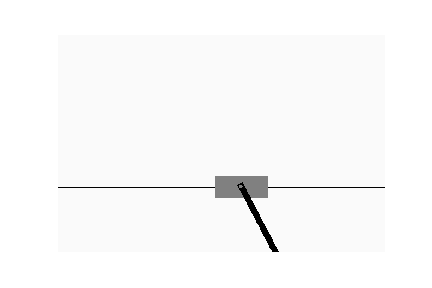
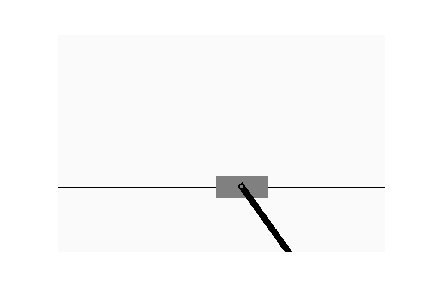
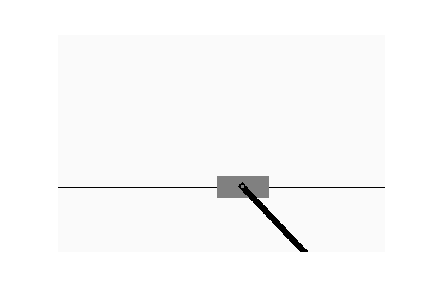
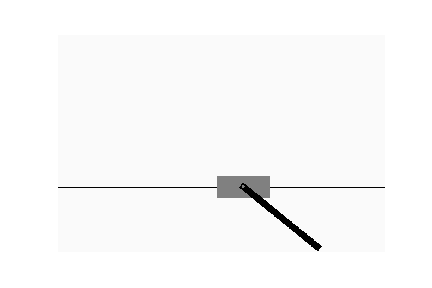
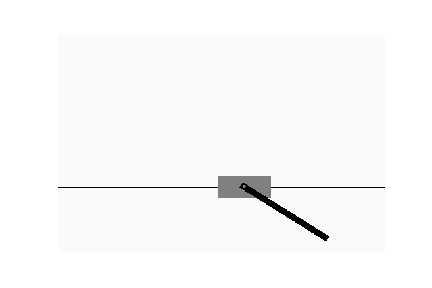
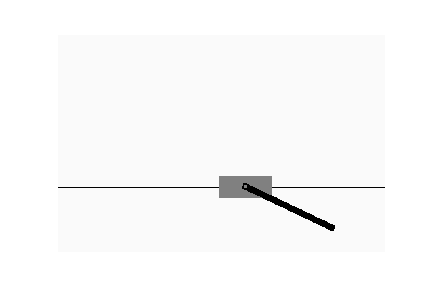
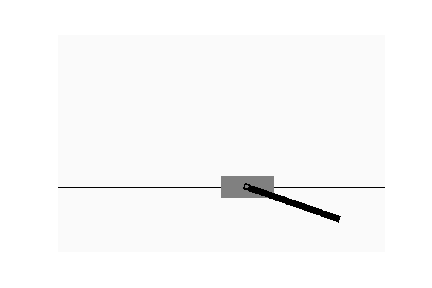
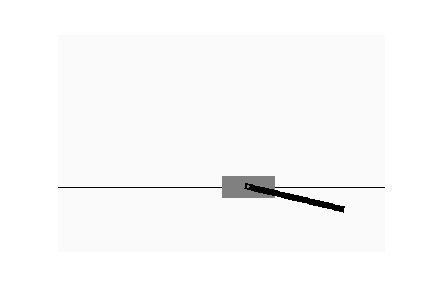
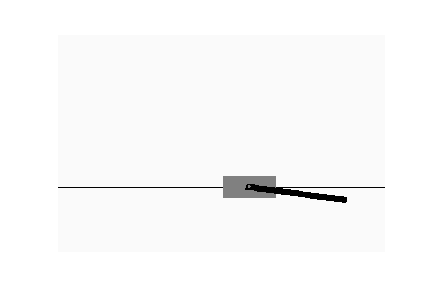
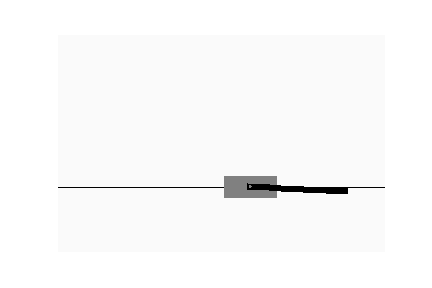
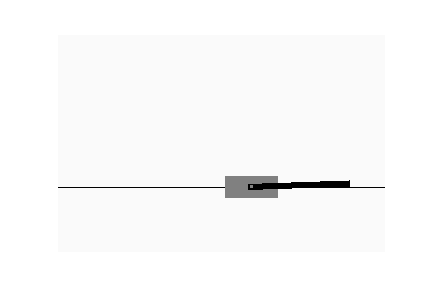
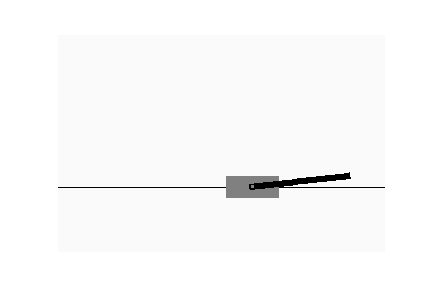
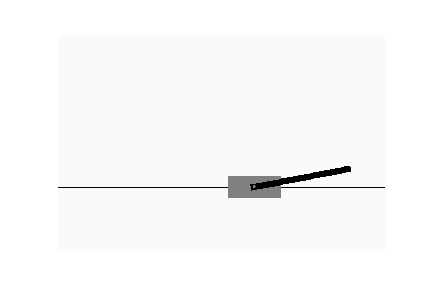
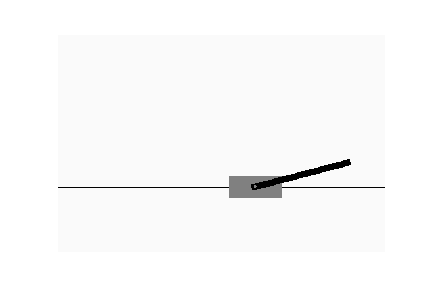
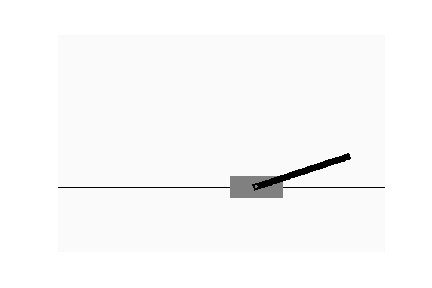
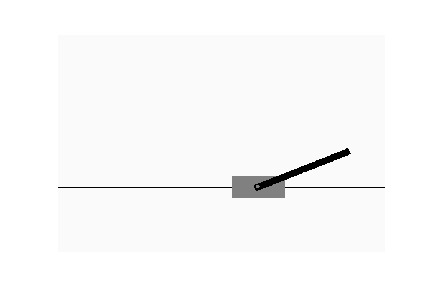
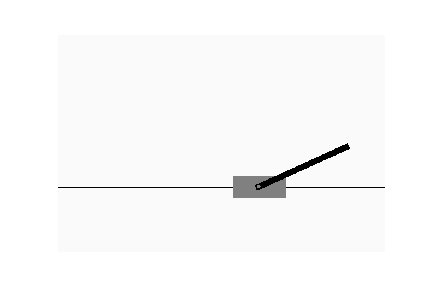
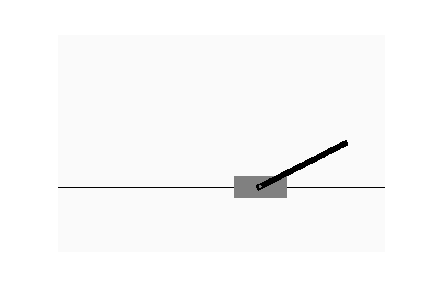
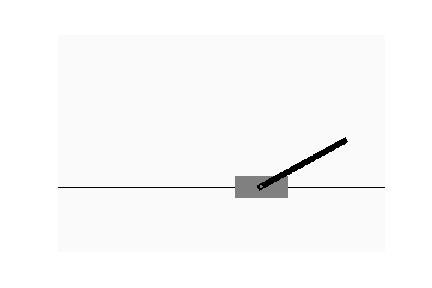
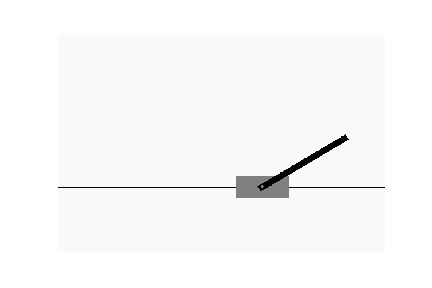
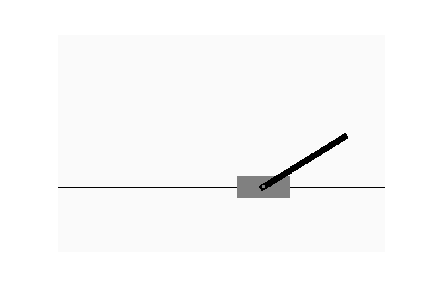
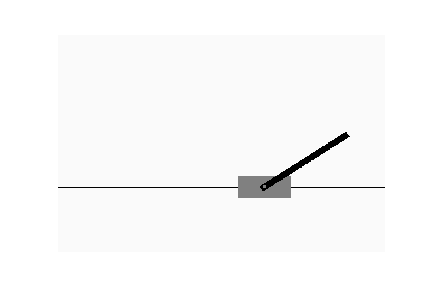
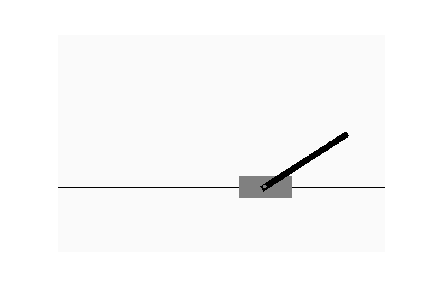
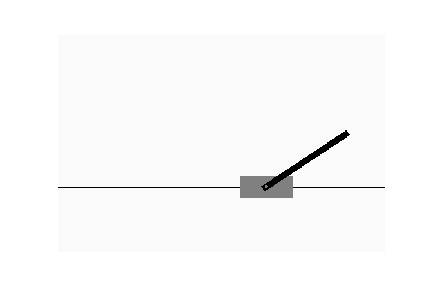
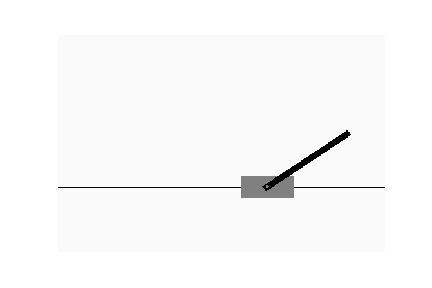
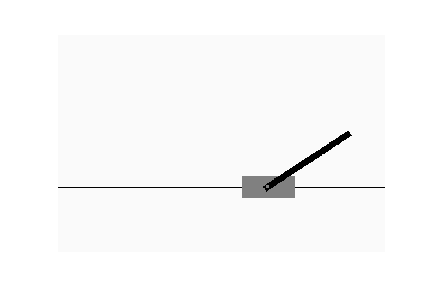
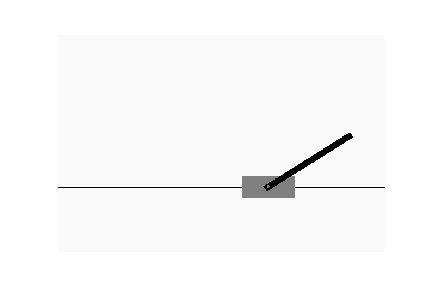
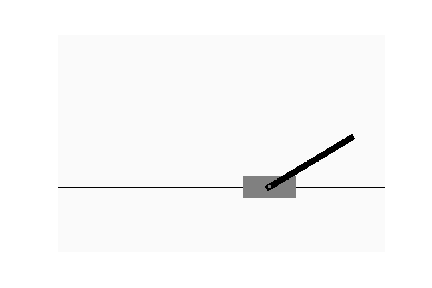
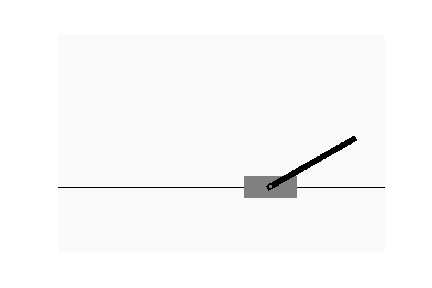
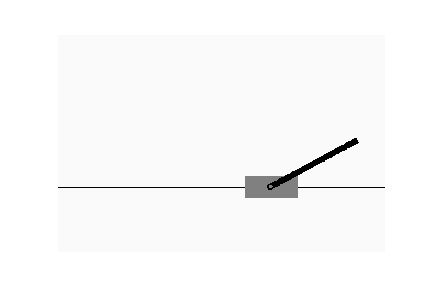
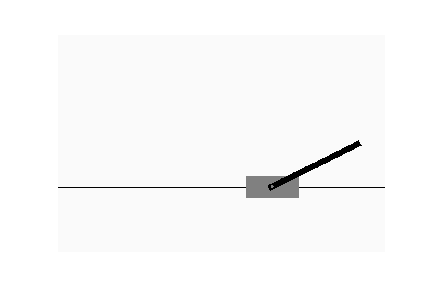
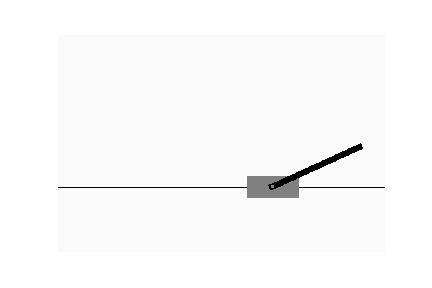
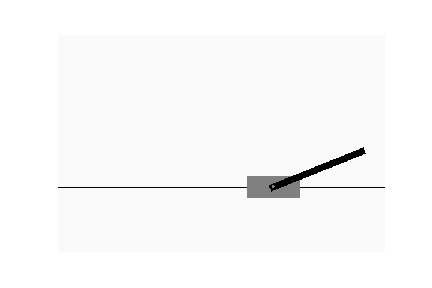
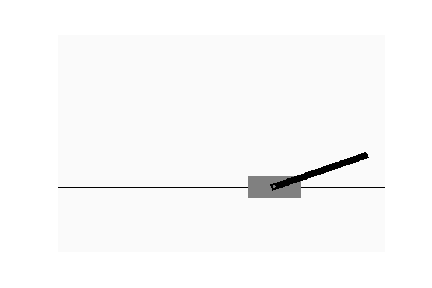
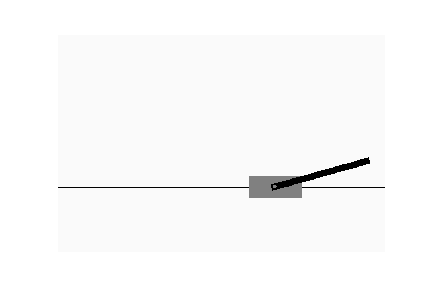
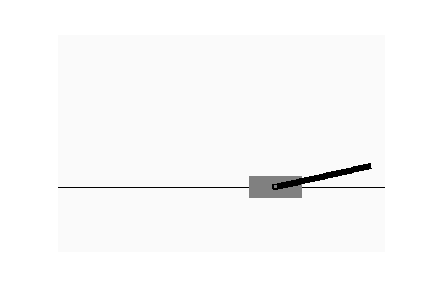
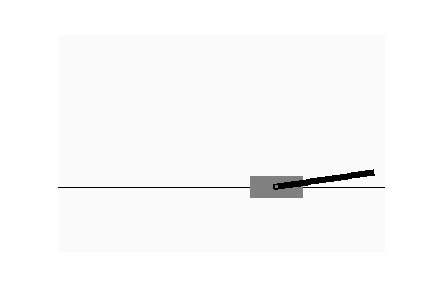
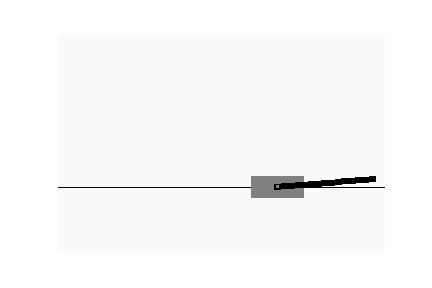
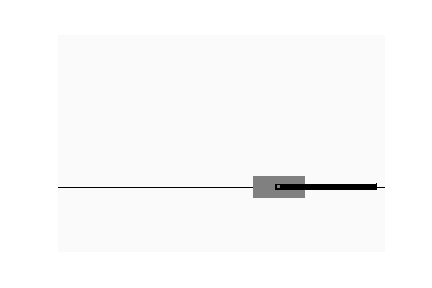
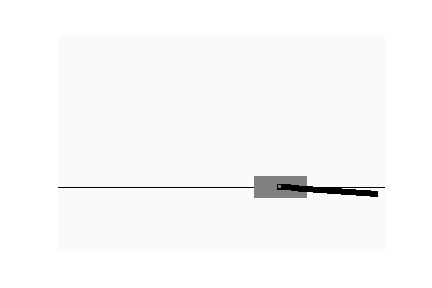
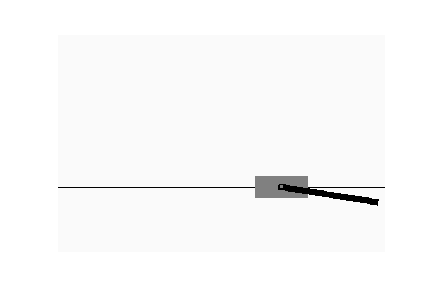
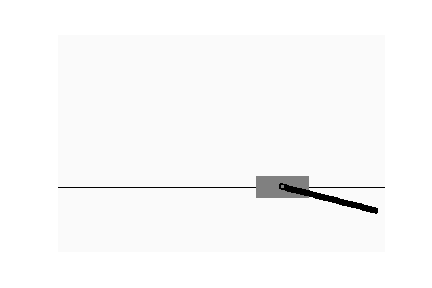
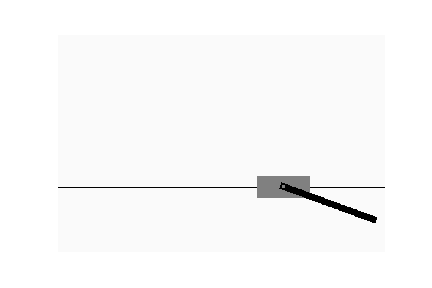
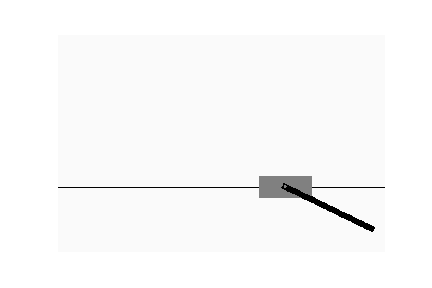
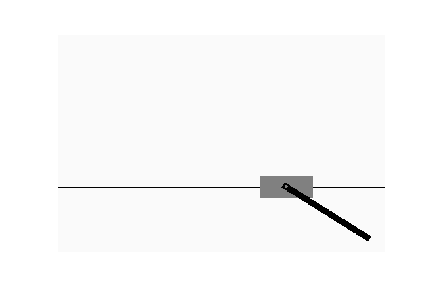
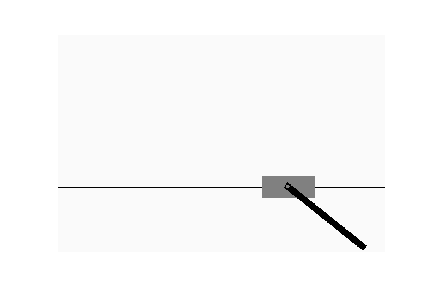
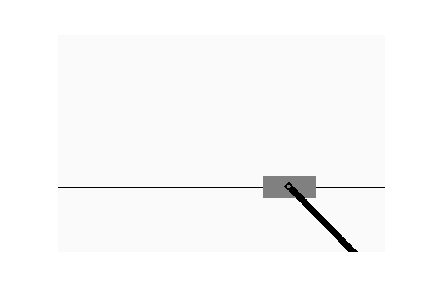
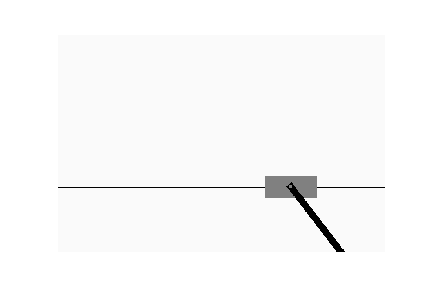
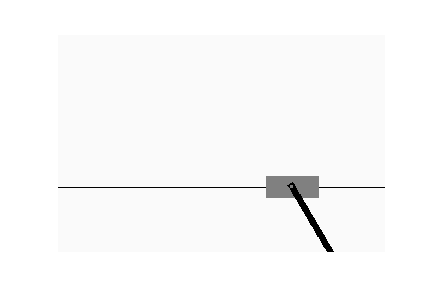
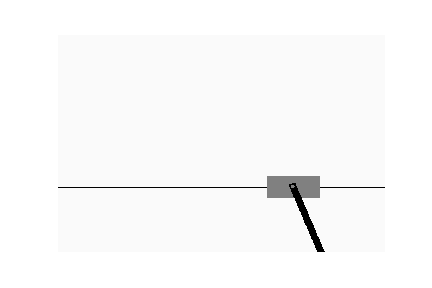
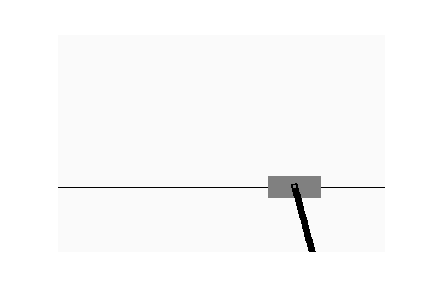
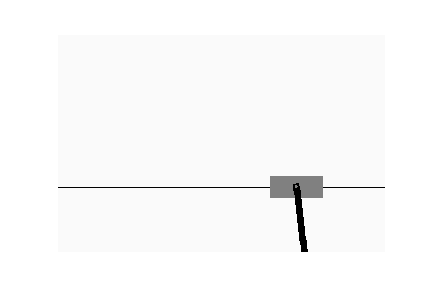
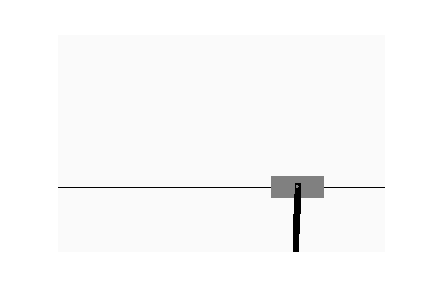
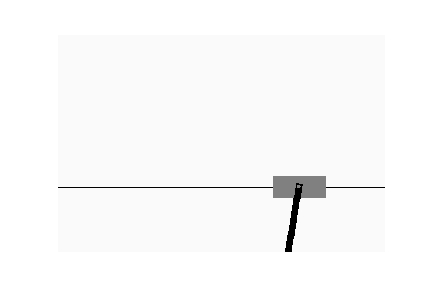
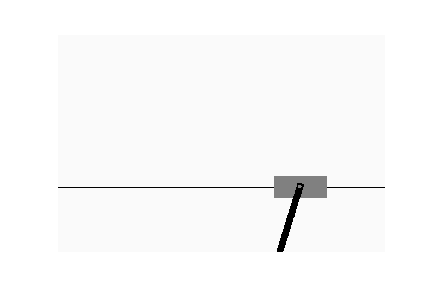
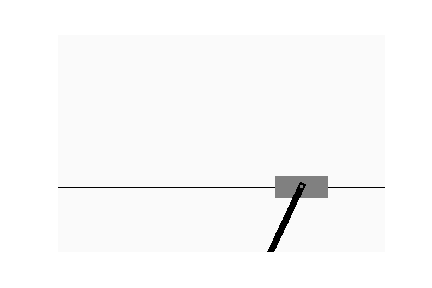
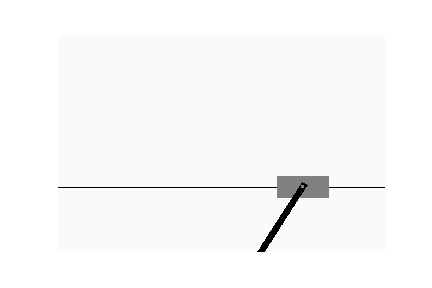
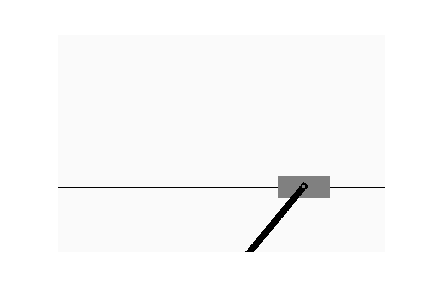
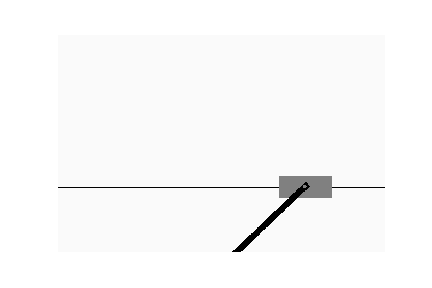
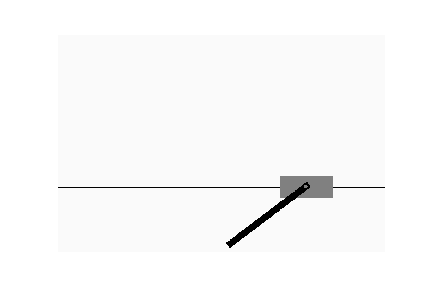
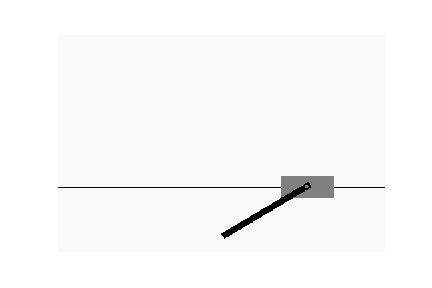
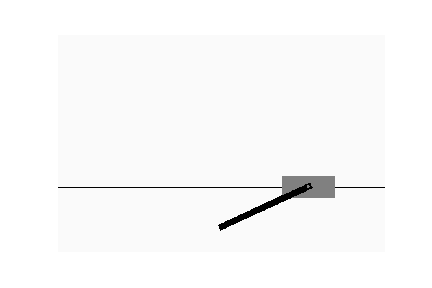
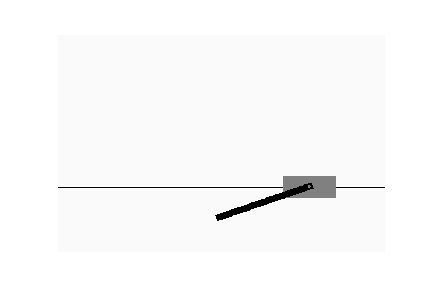
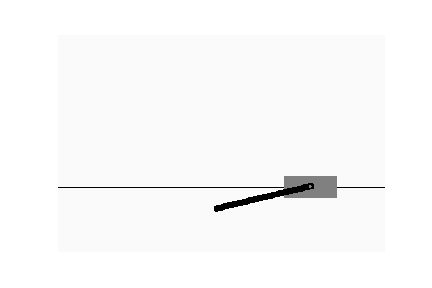
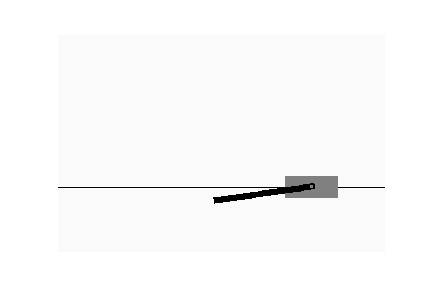
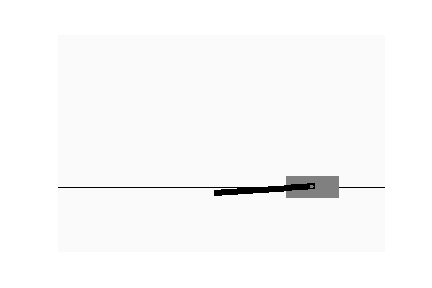
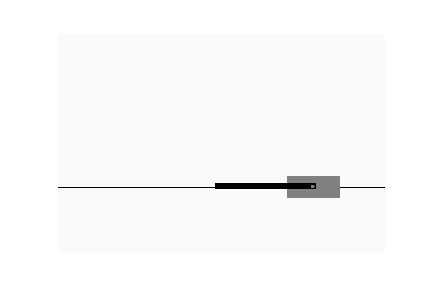
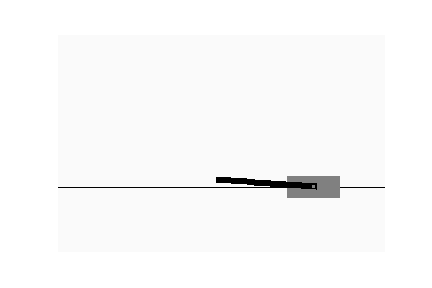
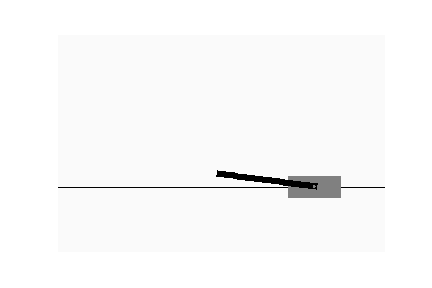
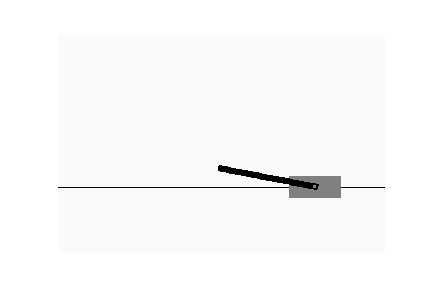
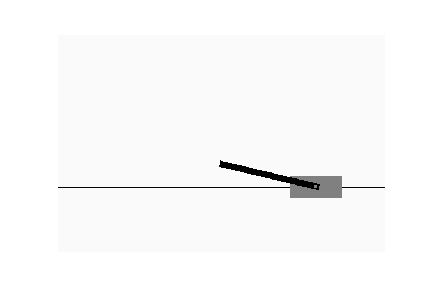
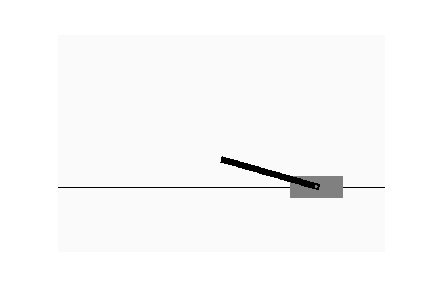
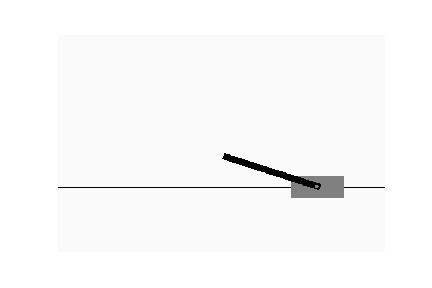
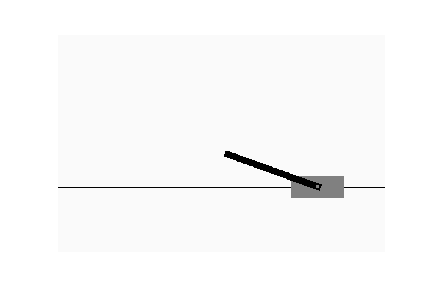
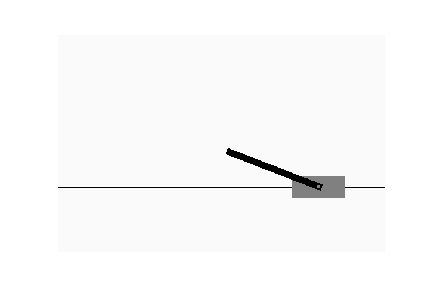
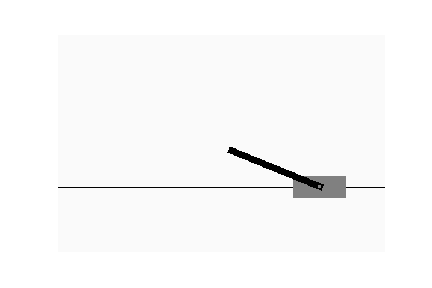
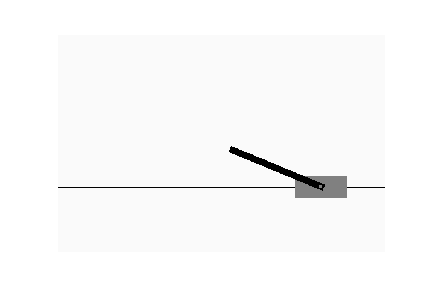
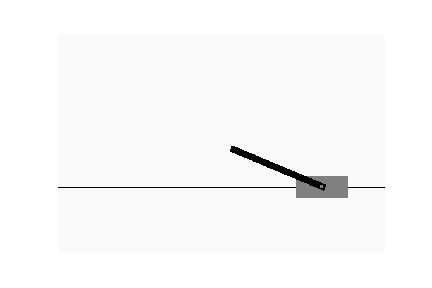
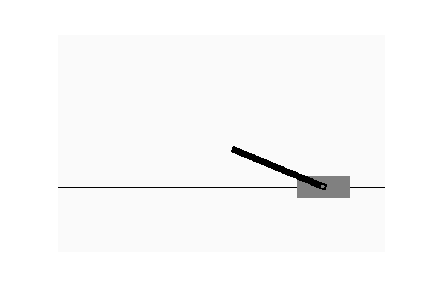
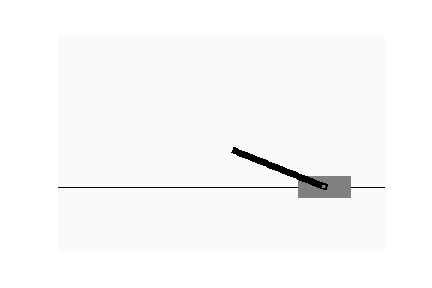
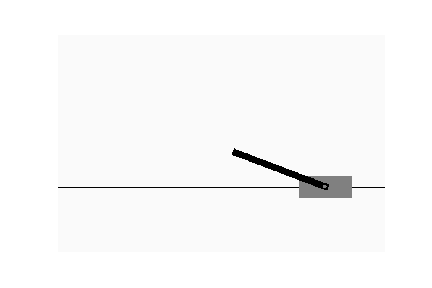
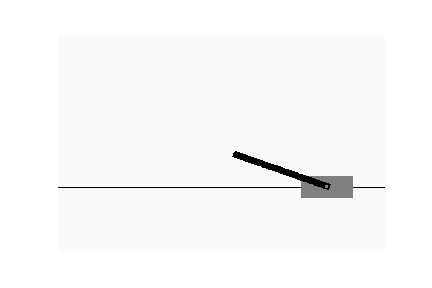
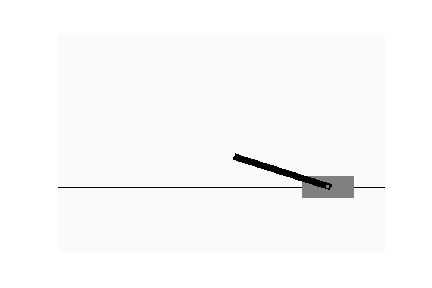
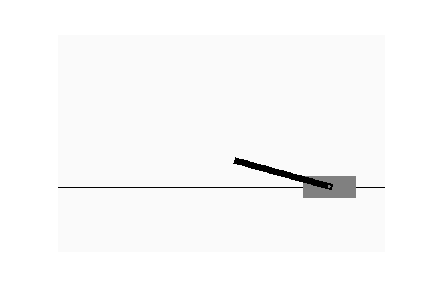
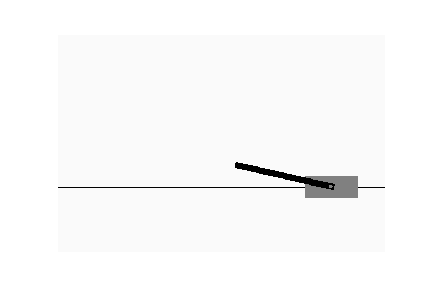
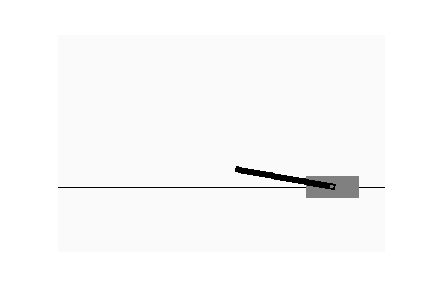
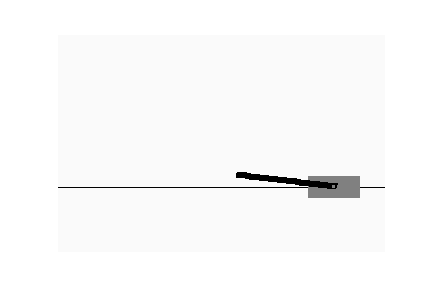
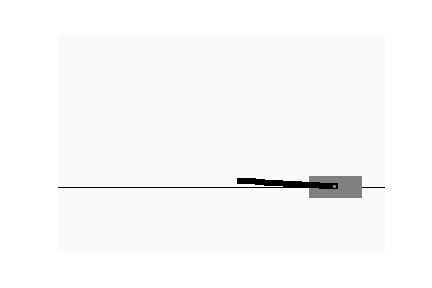
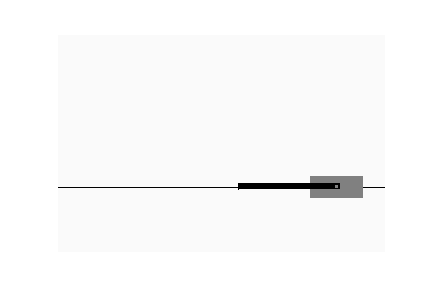
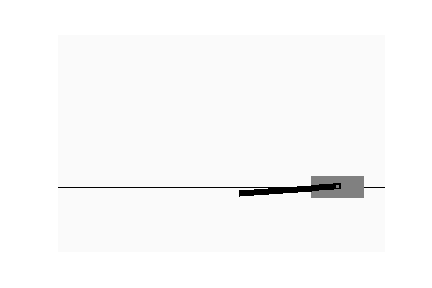
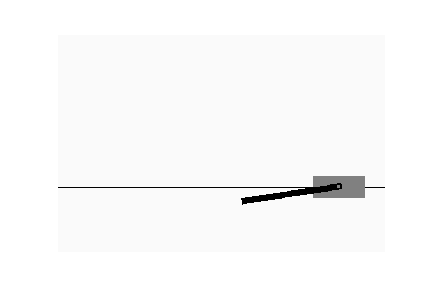
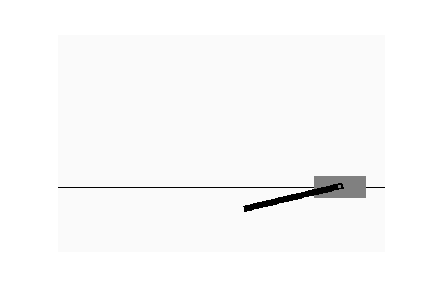
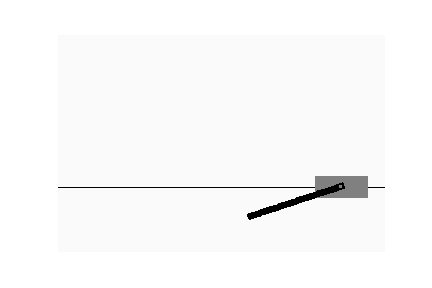
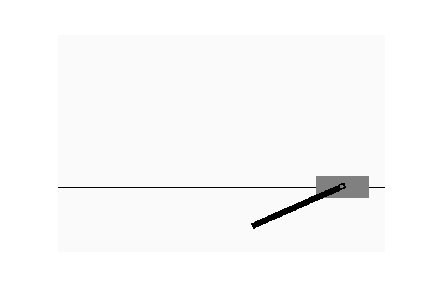
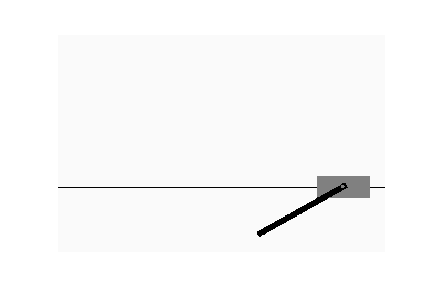
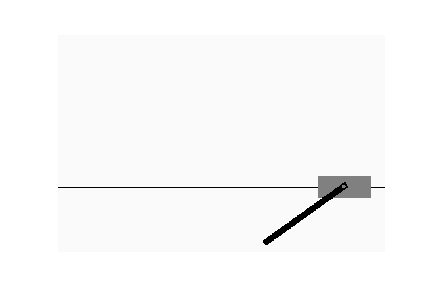
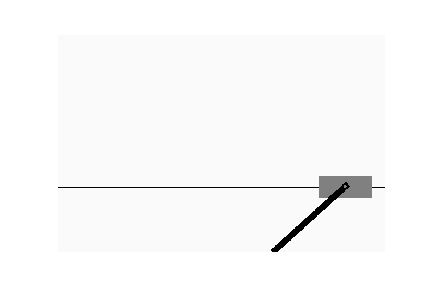
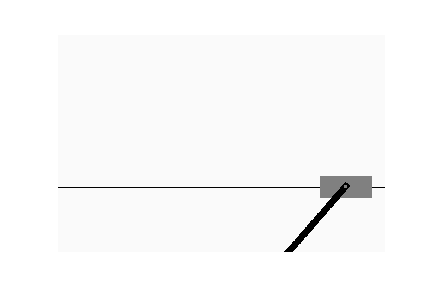
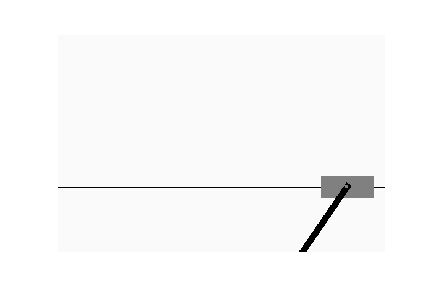
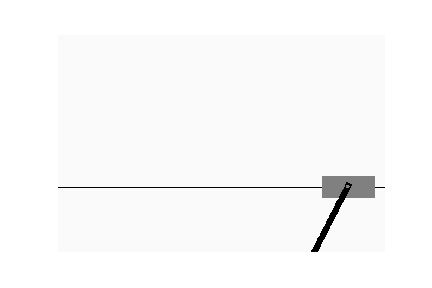
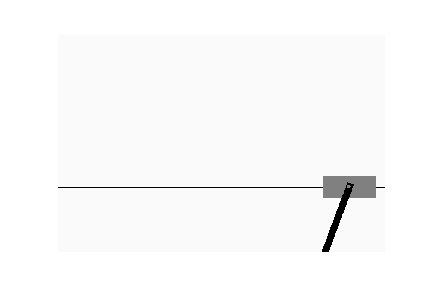
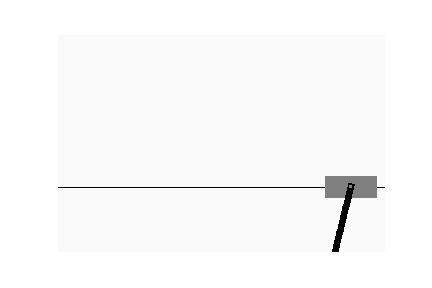
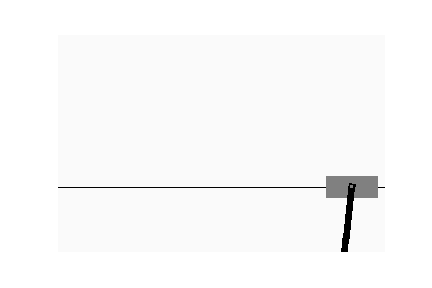
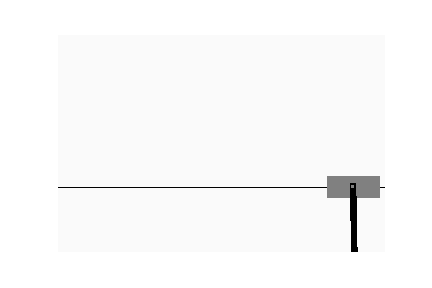
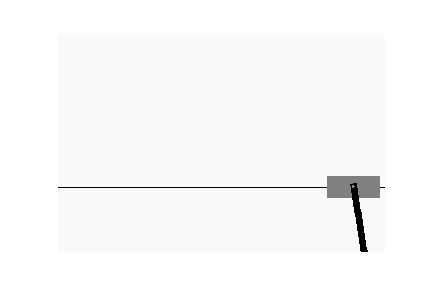
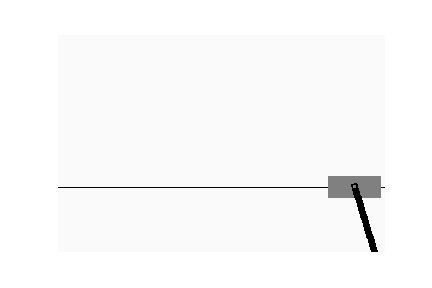
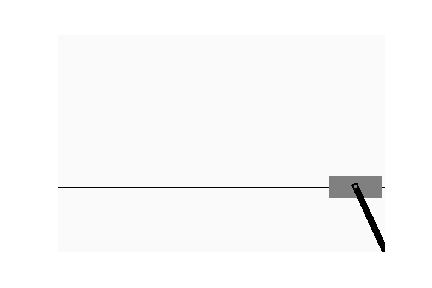
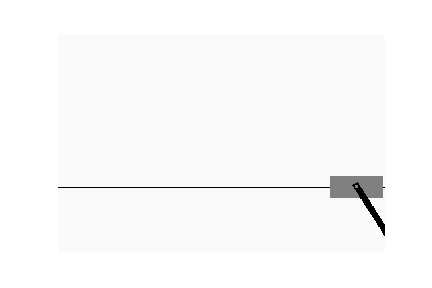
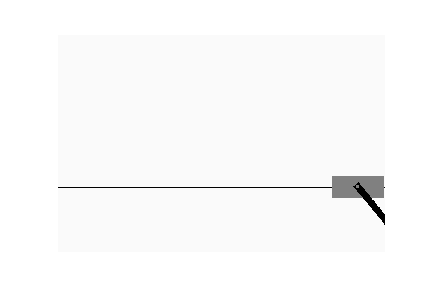
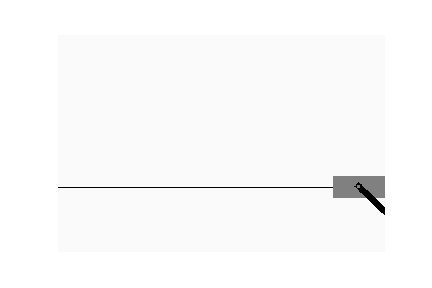
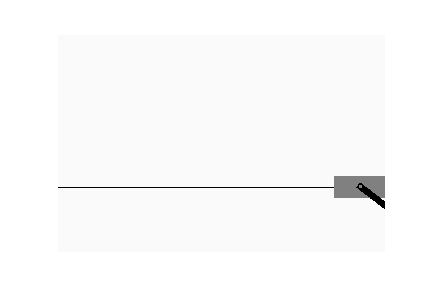
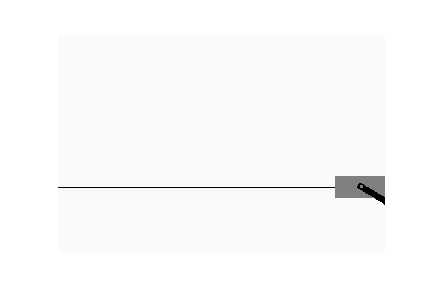
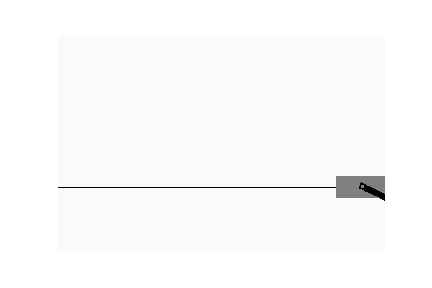
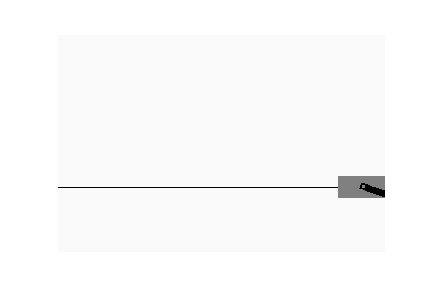
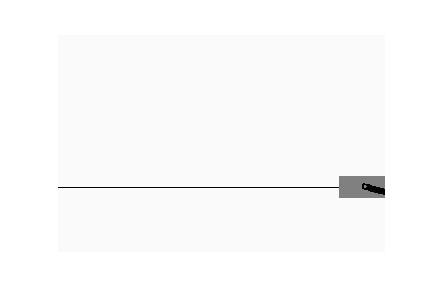
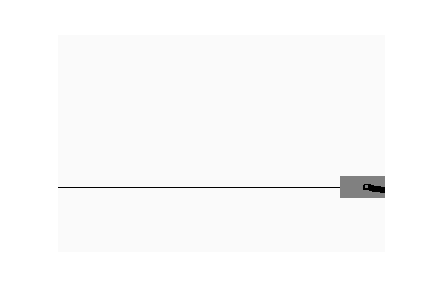
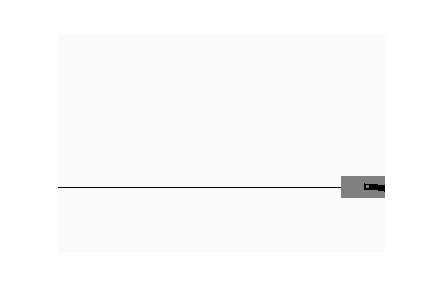
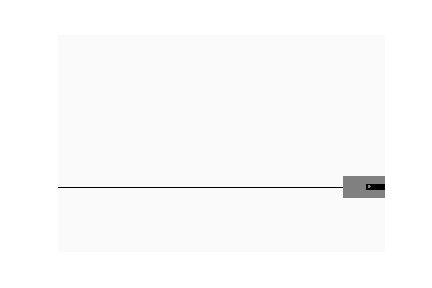
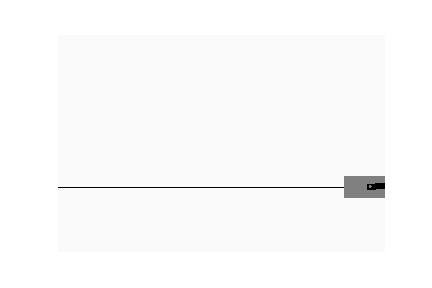
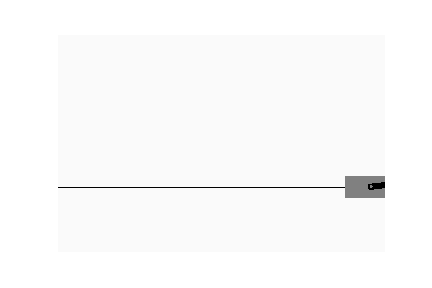
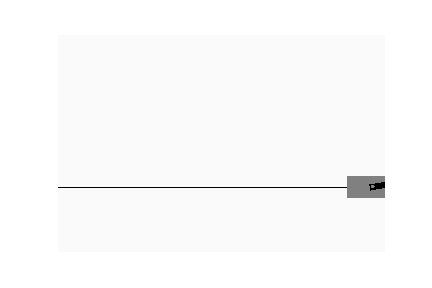
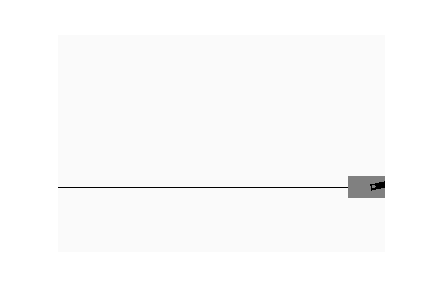
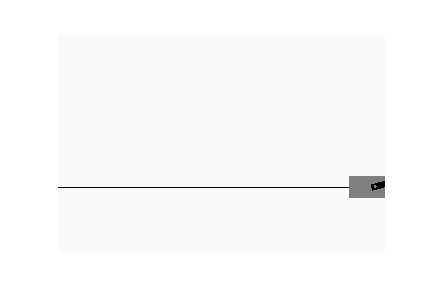
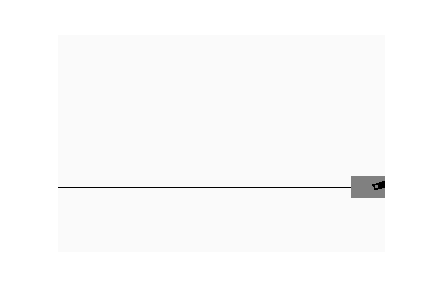
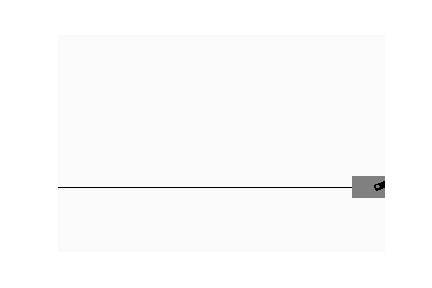
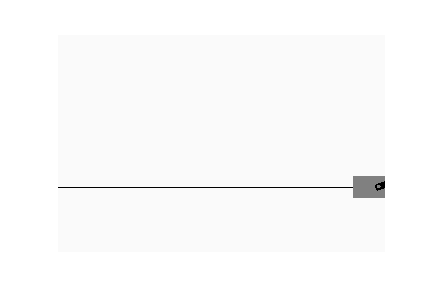
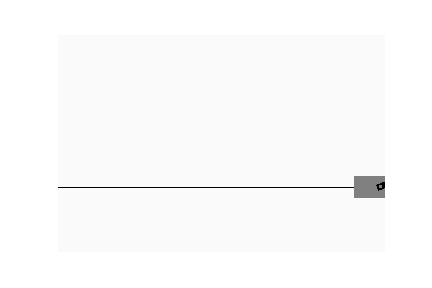
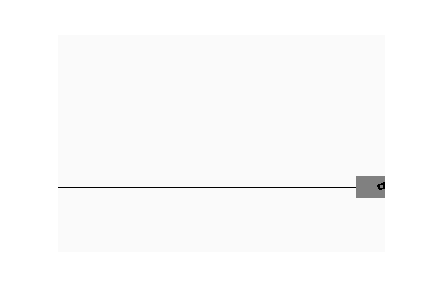
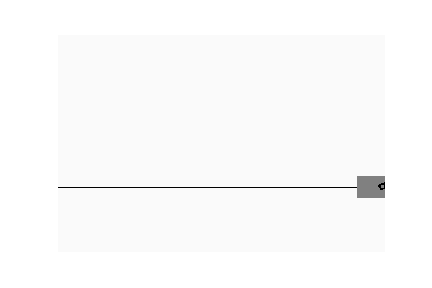
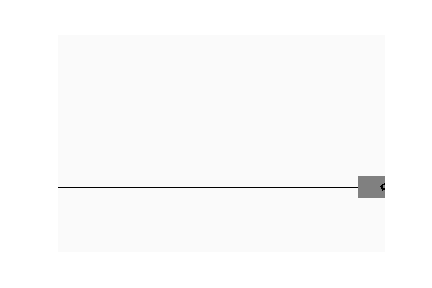
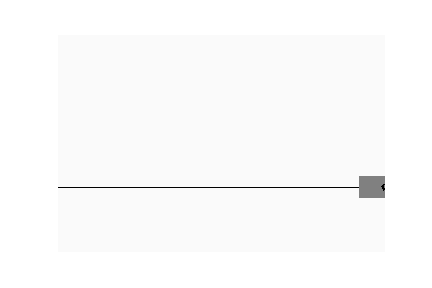
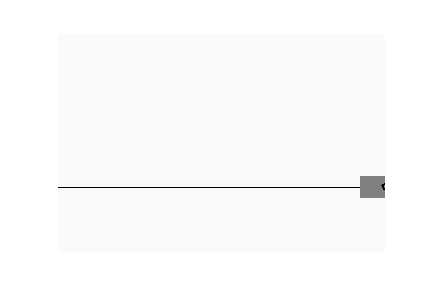
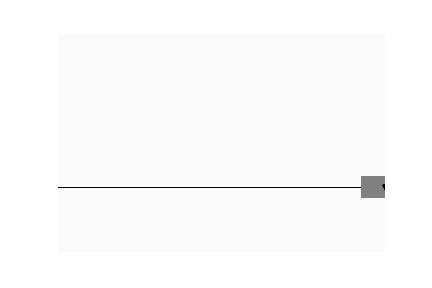
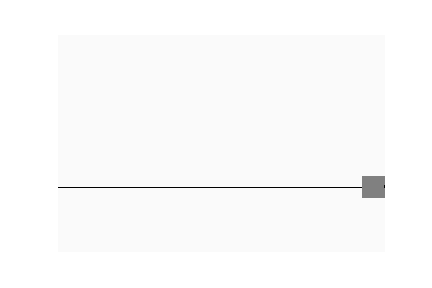
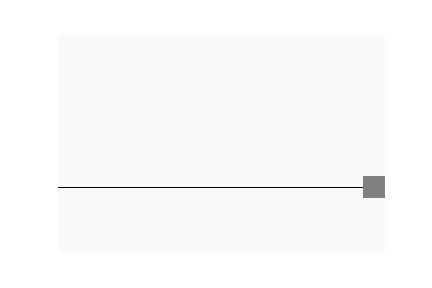
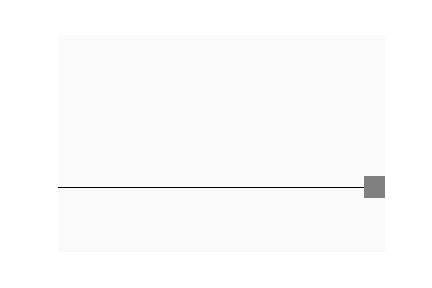
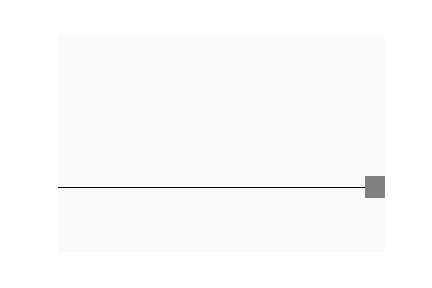
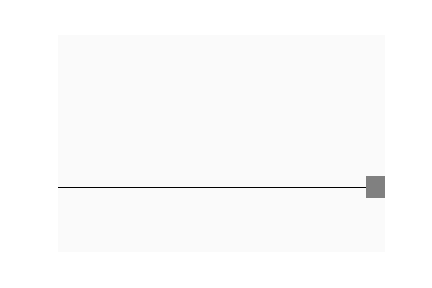
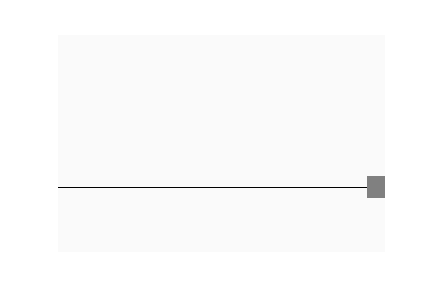
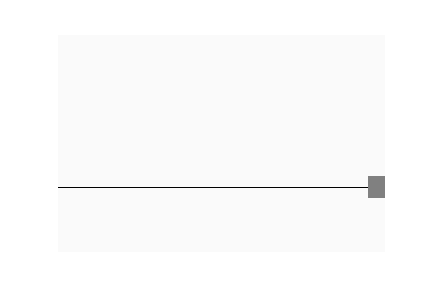
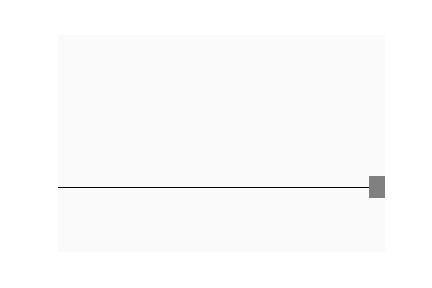
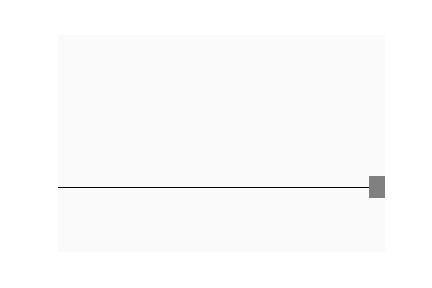
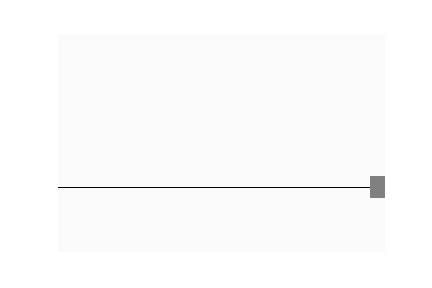
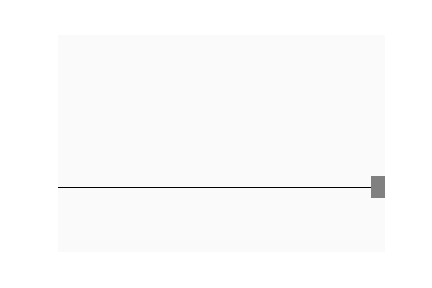
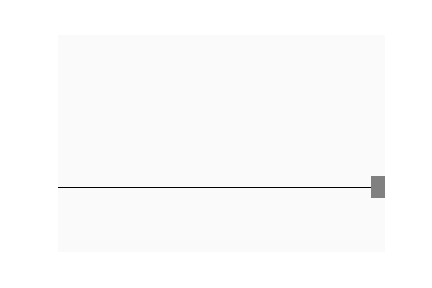
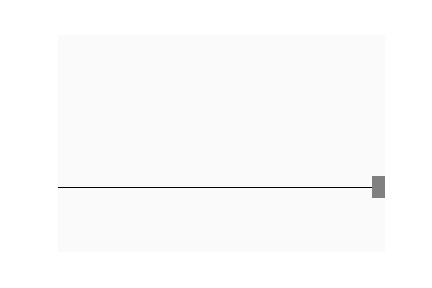
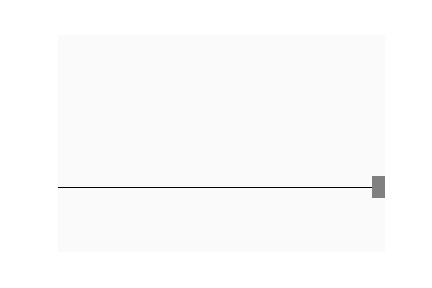
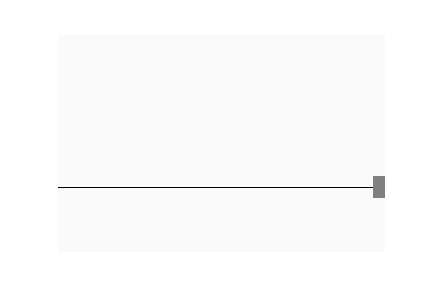
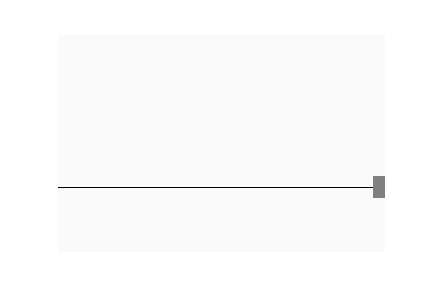
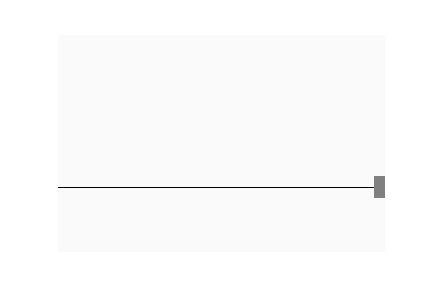

In [3]:
# demo the environment
env.reset() # reset the environment
view = Viewer(env, custom_render=True) # we use this custom viewer to render the environment inline in the notebook
for _ in range(200):
    view.render()
    # env.render() # uncomment this to use gym's own render function
    env.step(env.action_space.sample()) # take a random action
view.render(close=True, display_gif=True) # display the environment inline in the notebook
# env.render(close=True) # uncomment this to use gym'm own render function

Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [4]:
# setup policy network
n_inputs = env.observation_space.shape[0]
n_hidden = 32
n_outputs = env.action_space.n

tf.reset_default_graph()

states_pl = tf.placeholder(tf.float32, [None, n_inputs], name='states_pl')
actions_pl = tf.placeholder(tf.int32, [None, n_outputs], name='actions_pl')
advantages_pl = tf.placeholder(tf.float32, [None], name='advantages_pl')
learning_rate_pl = tf.placeholder(tf.float32, name='learning_rate_pl')

l_hidden = tf.layers.dense(inputs=states_pl, units=16, activation=relu, name='l_hidden')
l_hidden_2 = tf.layers.dense(inputs=l_hidden, units=64, activation=relu, name='l_hidden_2')
l_hidden_3 = tf.layers.dense(inputs=l_hidden_2, units=256, activation=relu, name='l_hidden_3')
l_hidden_4 = tf.layers.dense(inputs=l_hidden_3, units=128, activation=relu, name='l_hidden_4')
l_hidden_5 = tf.layers.dense(inputs=l_hidden_4, units=32, activation=relu, name='l_hidden_5')
l_hidden_last = tf.layers.dense(inputs=l_hidden_5, units=8, activation=relu, name='l_hidden_last')
l_out = tf.layers.dense(inputs=l_hidden_last, units=n_outputs, activation=softmax, name='l_out')

# print network
print('states_pl:', states_pl.get_shape())
print('actions_pl:', actions_pl.get_shape())
print('advantages_pl:', advantages_pl.get_shape())
print('l_hidden:', l_hidden_last.get_shape())
print('l_out:', l_out.get_shape())

states_pl: (?, 4)
actions_pl: (?, 2)
advantages_pl: (?,)
l_hidden: (?, 8)
l_out: (?, 2)


In [5]:
# define loss and optimizer
loss_f = -tf.reduce_mean(tf.multiply(tf.log(tf.gather_nd(l_out, actions_pl)), advantages_pl))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_pl)
train_f = optimizer.minimize(loss_f)

saver = tf.train.Saver() # we use this later to save the model

In [6]:
# test forward pass
state = env.reset()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    action_probabilities = sess.run(fetches=l_out, feed_dict={states_pl: [state]})
print(state)
print(action_probabilities)

[-0.0144744   0.04553056 -0.041916    0.0156119 ]
[[ 0.49993214  0.50006783]]


*Note: As we create our solution, we will make very few assumptions about the cart-pole environment. We aim to develop a general model for solving reinforcement learning problems, and therefore care little about the specific meaning of the inputs and outputs.*

In [7]:
# helper functions

def get_rollout(sess, env, rollout_limit=None, stochastic=False, seed=None):
    """Generate rollout by iteratively evaluating the current policy on the environment."""
    rollout_limit = rollout_limit or env.spec.timestep_limit
    env.seed(seed)
    s = env.reset()
    states, actions, rewards = [], [], []
    for i in range(rollout_limit):
        a = get_action(sess, s, stochastic)
        s1, r, done, _ = env.step(a)
        states.append(s)
        actions.append(a)
        rewards.append(r)
        s = s1
        if done: break
    env.seed(None)
    return states, actions, rewards, i+1

def get_action(sess, state, stochastic=False):
    """Choose an action, given a state, with the current policy network."""
    # get action probabilities
    a_prob = sess.run(fetches=l_out, feed_dict={states_pl: np.atleast_2d(state)})
    if stochastic:
        # sample action from distribution
        return (np.cumsum(np.asarray(a_prob)) > np.random.rand()).argmax()
    else:
        # select action with highest probability
        return a_prob.argmax()

def get_advantages(rewards, rollout_limit, discount_factor, eps=1e-12):
    """Compute advantages"""
    returns = get_returns(rewards, rollout_limit, discount_factor)
    # standardize columns of returns to get advantages
    advantages = (returns - np.mean(returns, axis=0)) / (np.std(returns, axis=0) + eps)
    # restore original rollout lengths
    advantages = [adv[:len(rewards[i])] for i, adv in enumerate(advantages)]
    return advantages

def get_returns(rewards, rollout_limit, discount_factor):
    """Compute the cumulative discounted rewards, a.k.a. returns."""
    returns = np.zeros((len(rewards), rollout_limit))
    for i, r in enumerate(rewards):
        returns[i, len(r) - 1] = r[-1]
        for j in reversed(range(len(r)-1)):
            returns[i,j] = r[j] + discount_factor * returns[i,j+1]
    return returns

In [8]:
# training settings

epochs = 1000 # number of training batches
batch_size = 1000 # number of timesteps in a batch
rollout_limit = 500 #env.spec.timestep_limit # max rollout length
discount_factor = 0.93 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.00005 # you know this by now
early_stop_loss = 0 # stop training if loss < early_stop_loss, 0 or False to disable

# train policy network

try:
    statistics = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('start training')
        for epoch in range(epochs):
            # generate rollouts until batch_size total timesteps are collected
            states, actions, rewards = [], [], []
            timesteps = 0
            while timesteps < batch_size:
                _rollout_limit = min(rollout_limit, batch_size - timesteps) # limit rollout to match batch_size
                s, a, r, t = get_rollout(sess, env, _rollout_limit, stochastic=True, seed=epoch)            
                states.append(s)
                actions.append(a)
                rewards.append(r)
                timesteps += t
            # compute advantages
            advantages = get_advantages(rewards, rollout_limit, discount_factor)
            # policy gradient update
            loss, _ = sess.run(fetches=[loss_f, train_f], feed_dict={
                states_pl: np.concatenate(states),
                actions_pl: np.column_stack((np.arange(timesteps), np.concatenate(actions))),
                advantages_pl: np.concatenate(advantages),
                learning_rate_pl: learning_rate
            })            
            # validation
            val_rewards = [get_rollout(sess, env, rollout_limit, stochastic=False, seed=(epochs+i))[2] for i in range(10)]
            # store and print training statistics
            mtr = np.mean([np.sum(r) for r in rewards])
            mvr = np.mean([np.sum(r) for r in val_rewards])
            statistics.append((mtr, mvr, loss))
            print('%4d. training reward: %6.2f, validation reward: %6.2f, loss: %7.4f' % (epoch+1, mtr, mvr, loss))
            # early stopping
            if early_stop_loss and loss < early_stop_loss: break
        print('done')
        # save session
        saver.save(sess, 'tmp/model.ckpt')
except KeyboardInterrupt:
    pass    

start training
   1. training reward:  22.22, validation reward:  11.60, loss:  0.4217
   2. training reward:  24.39, validation reward:  16.90, loss:  0.5506
   3. training reward:  21.28, validation reward:  18.10, loss:  0.3578
   4. training reward:  23.81, validation reward:  19.40, loss:  0.5580
   5. training reward:  27.78, validation reward:  24.50, loss:  0.4234
   6. training reward:  21.28, validation reward:  33.20, loss:  0.4435
   7. training reward:  20.83, validation reward:  46.60, loss:  0.4837
   8. training reward:  21.28, validation reward:  72.10, loss:  0.3584
   9. training reward:  20.83, validation reward:  73.20, loss:  0.3274
  10. training reward:  25.64, validation reward:  70.30, loss:  0.4425
  11. training reward:  22.73, validation reward:  66.80, loss:  0.4773
  12. training reward:  21.74, validation reward:  65.10, loss:  0.3793
  13. training reward:  22.73, validation reward:  66.60, loss:  0.3692
  14. training reward:  24.39, validation reward:

 115. training reward:  29.41, validation reward: 149.10, loss:  0.5659
 116. training reward:  22.73, validation reward: 153.90, loss:  0.3357
 117. training reward:  26.32, validation reward: 152.20, loss:  0.5745
 118. training reward:  26.32, validation reward: 153.70, loss:  0.4278
 119. training reward:  23.81, validation reward: 150.90, loss:  0.3632
 120. training reward:  24.39, validation reward: 151.90, loss:  0.4237
 121. training reward:  25.64, validation reward: 153.90, loss:  0.4538
 122. training reward:  25.64, validation reward: 153.40, loss:  0.3858
 123. training reward:  25.00, validation reward: 159.90, loss:  0.4099
 124. training reward:  25.64, validation reward: 161.40, loss:  0.4596
 125. training reward:  22.73, validation reward: 163.10, loss:  0.4435
 126. training reward:  25.64, validation reward: 160.30, loss:  0.5178
 127. training reward:  22.73, validation reward: 163.30, loss:  0.3166
 128. training reward:  26.32, validation reward: 159.70, loss: 

 229. training reward:  32.26, validation reward: 178.70, loss:  0.4608
 230. training reward:  32.26, validation reward: 180.80, loss:  0.3992
 231. training reward:  40.00, validation reward: 180.80, loss:  0.5141
 232. training reward:  38.46, validation reward: 180.80, loss:  0.3884
 233. training reward:  38.46, validation reward: 180.80, loss:  0.5103
 234. training reward:  45.45, validation reward: 176.70, loss:  0.4389
 235. training reward:  37.04, validation reward: 177.00, loss:  0.3896
 236. training reward:  34.48, validation reward: 181.10, loss:  0.4798
 237. training reward:  37.04, validation reward: 181.10, loss:  0.4924
 238. training reward:  43.48, validation reward: 177.00, loss:  0.4764
 239. training reward:  41.67, validation reward: 177.00, loss:  0.7504
 240. training reward:  34.48, validation reward: 178.00, loss:  0.3779
 241. training reward:  31.25, validation reward: 178.00, loss:  0.3048
 242. training reward:  31.25, validation reward: 178.20, loss: 

 343. training reward:  76.92, validation reward: 190.00, loss:  0.4802
 344. training reward:  71.43, validation reward: 190.00, loss:  0.4549
 345. training reward:  62.50, validation reward: 190.20, loss:  0.4544
 346. training reward:  66.67, validation reward: 190.30, loss:  0.4656
 347. training reward:  58.82, validation reward: 190.70, loss:  0.5894
 348. training reward:  66.67, validation reward: 191.10, loss:  0.3710
 349. training reward:  50.00, validation reward: 191.10, loss:  0.3702
 350. training reward:  58.82, validation reward: 191.10, loss:  0.4101
 351. training reward:  62.50, validation reward: 191.10, loss:  0.5325
 352. training reward:  62.50, validation reward: 191.40, loss:  0.3243
 353. training reward:  90.91, validation reward: 191.40, loss:  0.3404
 354. training reward:  52.63, validation reward: 194.30, loss:  0.5684
 355. training reward:  58.82, validation reward: 194.30, loss:  0.3741
 356. training reward:  66.67, validation reward: 194.30, loss: 

 457. training reward: 111.11, validation reward: 200.00, loss:  0.3694
 458. training reward: 100.00, validation reward: 200.00, loss:  0.4556
 459. training reward: 142.86, validation reward: 200.00, loss:  0.2910
 460. training reward: 125.00, validation reward: 200.00, loss:  0.3292
 461. training reward: 125.00, validation reward: 200.00, loss:  0.3146
 462. training reward: 125.00, validation reward: 200.00, loss:  0.3682
 463. training reward: 166.67, validation reward: 200.00, loss:  0.1786
 464. training reward:  83.33, validation reward: 200.00, loss:  0.4744
 465. training reward: 142.86, validation reward: 200.00, loss:  0.3079
 466. training reward: 142.86, validation reward: 200.00, loss:  0.3213
 467. training reward: 125.00, validation reward: 200.00, loss:  0.3578
 468. training reward: 142.86, validation reward: 200.00, loss:  0.2589
 469. training reward: 125.00, validation reward: 200.00, loss:  0.2455
 470. training reward: 125.00, validation reward: 200.00, loss: 

 571. training reward: 166.67, validation reward: 200.00, loss:  0.1472
 572. training reward: 142.86, validation reward: 200.00, loss:  0.3216
 573. training reward: 166.67, validation reward: 200.00, loss:  0.1249
 574. training reward: 166.67, validation reward: 200.00, loss:  0.1505
 575. training reward: 166.67, validation reward: 200.00, loss:  0.2295
 576. training reward: 166.67, validation reward: 200.00, loss:  0.2296
 577. training reward: 142.86, validation reward: 200.00, loss:  0.2195
 578. training reward: 142.86, validation reward: 200.00, loss:  0.2557
 579. training reward: 166.67, validation reward: 200.00, loss:  0.0841
 580. training reward: 166.67, validation reward: 200.00, loss:  0.1967
 581. training reward: 166.67, validation reward: 200.00, loss:  0.1797
 582. training reward: 142.86, validation reward: 200.00, loss:  0.2770
 583. training reward: 166.67, validation reward: 200.00, loss:  0.1661
 584. training reward: 142.86, validation reward: 200.00, loss: 

 685. training reward: 166.67, validation reward: 200.00, loss:  0.1286
 686. training reward: 166.67, validation reward: 200.00, loss:  0.1025
 687. training reward: 166.67, validation reward: 200.00, loss:  0.0846
 688. training reward: 166.67, validation reward: 200.00, loss:  0.1556
 689. training reward: 166.67, validation reward: 200.00, loss:  0.1755
 690. training reward: 166.67, validation reward: 200.00, loss:  0.2127
 691. training reward: 166.67, validation reward: 200.00, loss:  0.1332
 692. training reward: 200.00, validation reward: 200.00, loss:  0.0001
 693. training reward: 200.00, validation reward: 200.00, loss:  0.0000
 694. training reward: 166.67, validation reward: 200.00, loss:  0.1855
 695. training reward: 166.67, validation reward: 200.00, loss:  0.2239
 696. training reward: 200.00, validation reward: 200.00, loss:  0.0000
 697. training reward: 166.67, validation reward: 200.00, loss:  0.1638
 698. training reward: 142.86, validation reward: 200.00, loss: 

 799. training reward: 166.67, validation reward: 200.00, loss:  0.2058
 800. training reward: 166.67, validation reward: 200.00, loss:  0.2230
 801. training reward: 166.67, validation reward: 200.00, loss:  0.0836
 802. training reward: 166.67, validation reward: 200.00, loss:  0.2286
 803. training reward: 166.67, validation reward: 200.00, loss:  0.2328
 804. training reward: 166.67, validation reward: 200.00, loss:  0.2441
 805. training reward: 200.00, validation reward: 200.00, loss:  0.0000
 806. training reward: 166.67, validation reward: 200.00, loss:  0.1148
 807. training reward: 200.00, validation reward: 200.00, loss:  0.0001
 808. training reward: 200.00, validation reward: 200.00, loss:  0.0001
 809. training reward: 200.00, validation reward: 200.00, loss:  0.0000
 810. training reward: 166.67, validation reward: 200.00, loss:  0.2225
 811. training reward: 166.67, validation reward: 200.00, loss:  0.2338
 812. training reward: 166.67, validation reward: 200.00, loss: 

 913. training reward: 200.00, validation reward: 200.00, loss:  0.0000
 914. training reward: 166.67, validation reward: 200.00, loss:  0.2290
 915. training reward: 166.67, validation reward: 200.00, loss:  0.1927
 916. training reward: 166.67, validation reward: 200.00, loss:  0.2073
 917. training reward: 200.00, validation reward: 200.00, loss:  0.0001
 918. training reward: 166.67, validation reward: 200.00, loss:  0.2188
 919. training reward: 166.67, validation reward: 200.00, loss:  0.2157
 920. training reward: 200.00, validation reward: 200.00, loss:  0.0001
 921. training reward: 166.67, validation reward: 200.00, loss:  0.2386
 922. training reward: 166.67, validation reward: 200.00, loss:  0.1898
 923. training reward: 142.86, validation reward: 200.00, loss:  0.2627
 924. training reward: 166.67, validation reward: 200.00, loss:  0.1842
 925. training reward: 200.00, validation reward: 200.00, loss:  0.0000
 926. training reward: 200.00, validation reward: 200.00, loss: 

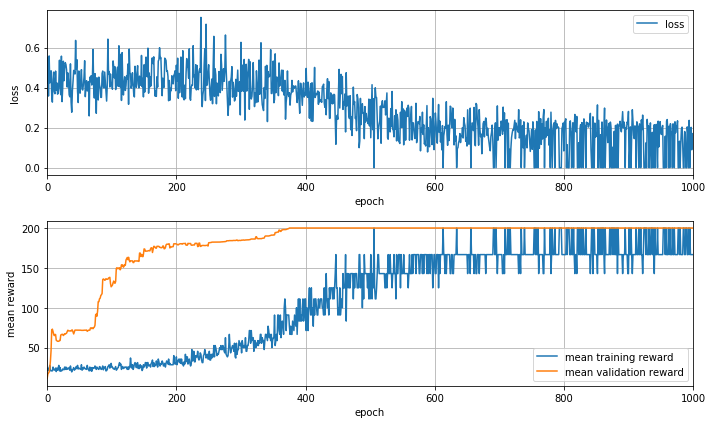

In [9]:
# plot training statistics
statistics = np.array(statistics).T
mean_training_rewards = statistics[0]
mean_validation_rewards = statistics[1]
losses = statistics[2]

plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(losses, label='loss')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=1); plt.grid()
plt.subplot(212)
plt.plot(mean_training_rewards, label='mean training reward')
plt.plot(mean_validation_rewards, label='mean validation reward')
plt.xlabel('epoch'); plt.ylabel('mean reward')
plt.xlim((0, len(mean_validation_rewards)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

INFO:tensorflow:Restoring parameters from tmp/model.ckpt


[2017-10-23 20:58:44,186] Restoring parameters from tmp/model.ckpt
[2017-10-23 20:58:45,211] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.



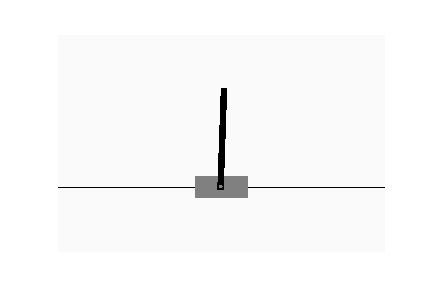
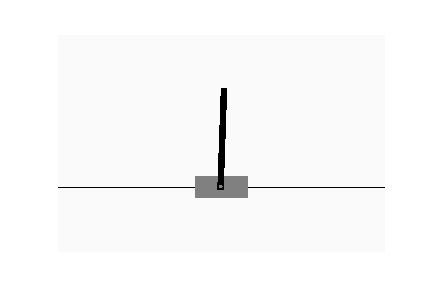
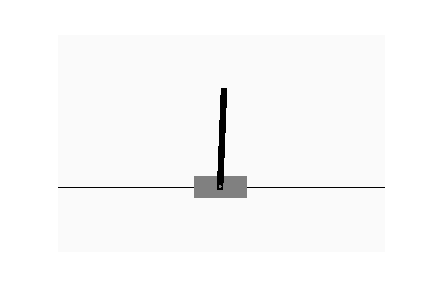
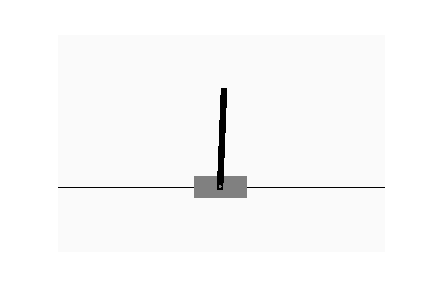
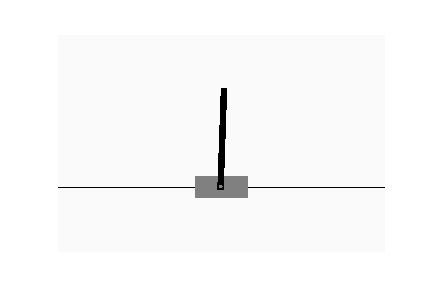
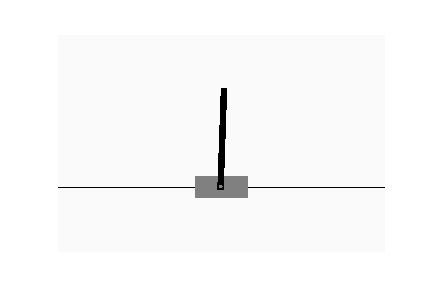
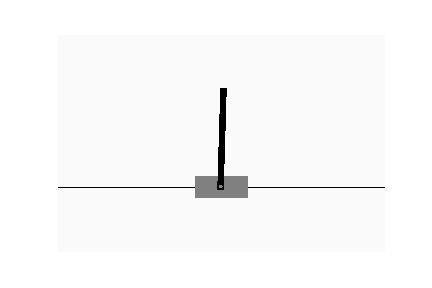
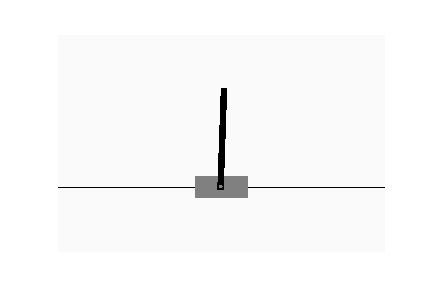
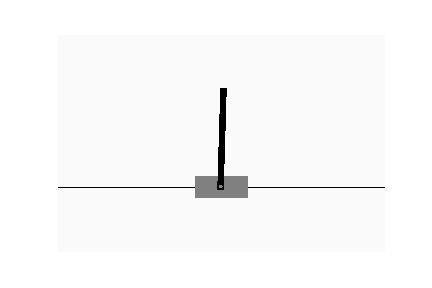
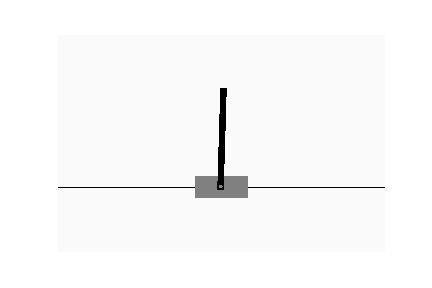
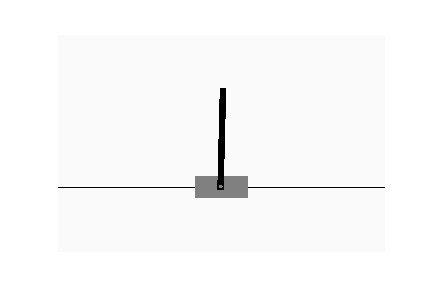
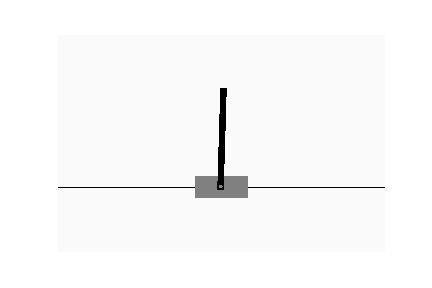
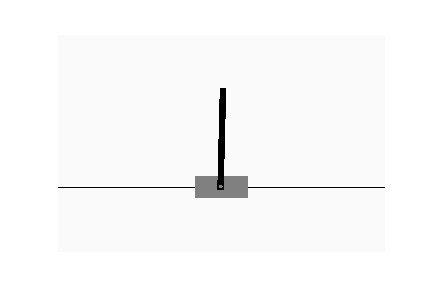
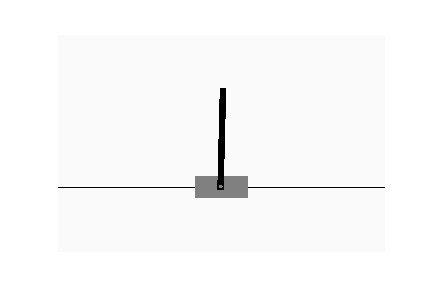
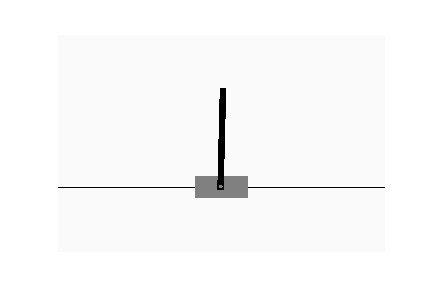
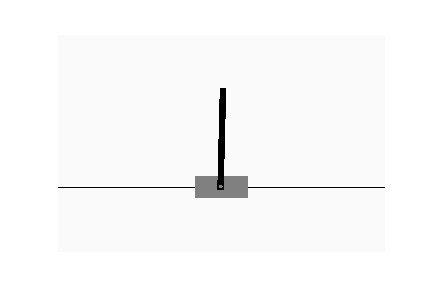
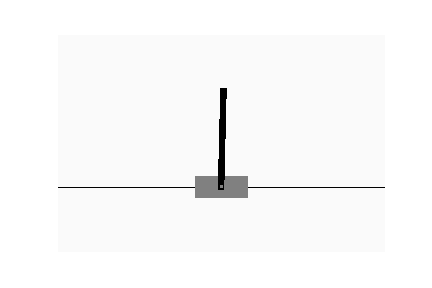
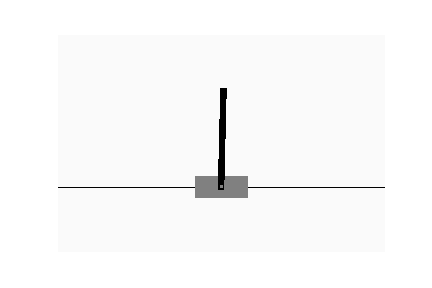
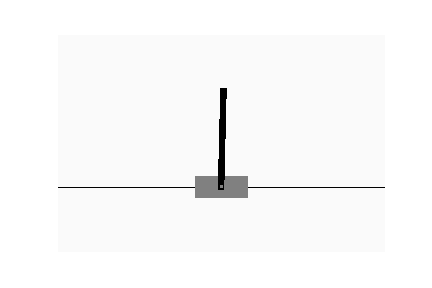
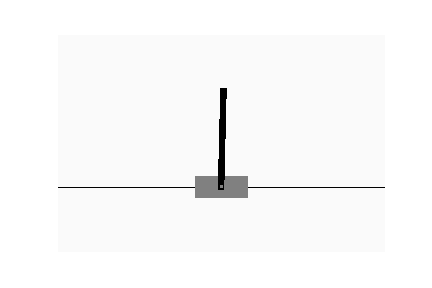
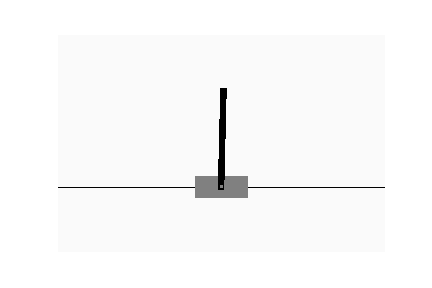
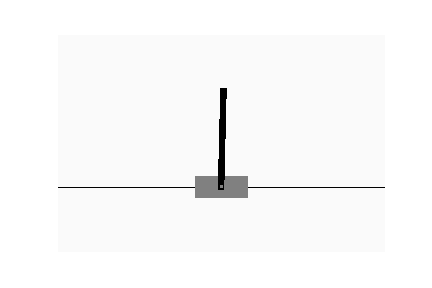
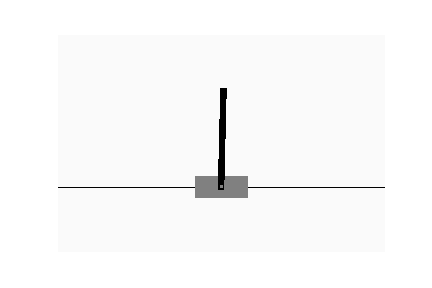
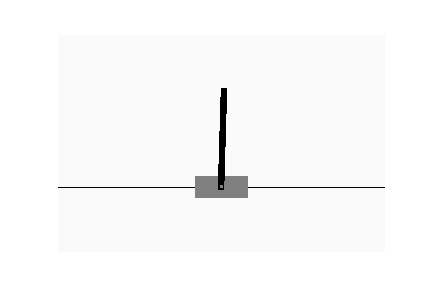
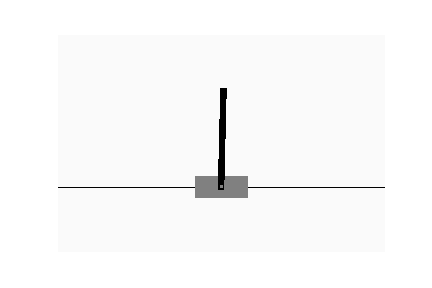
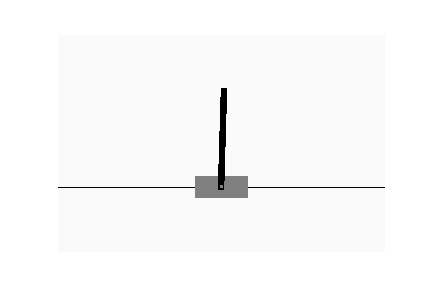
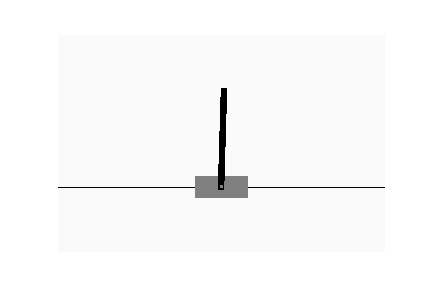
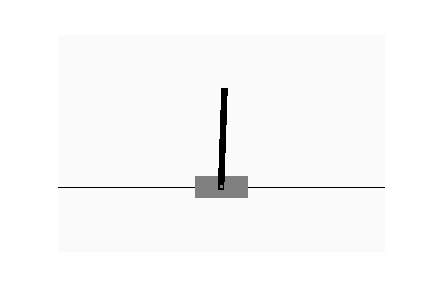
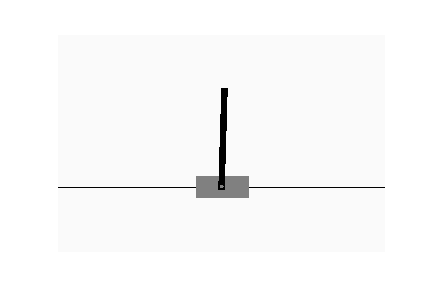
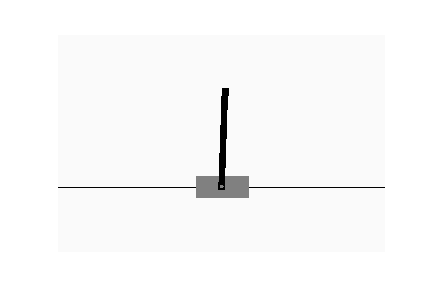
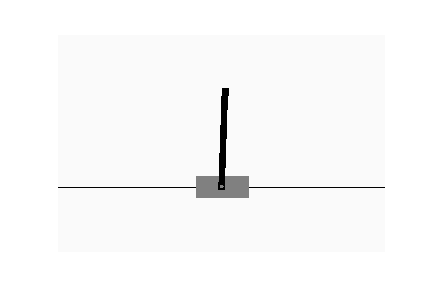
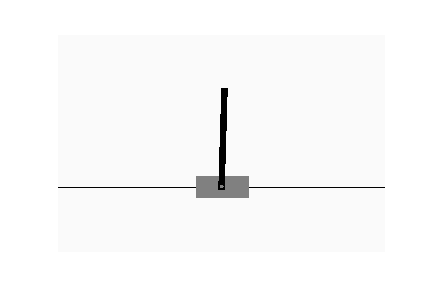
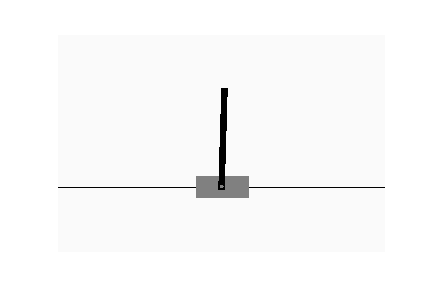
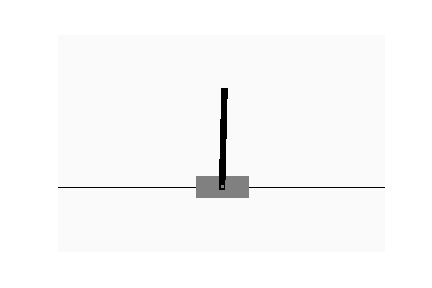
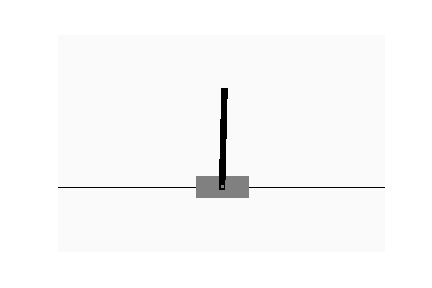
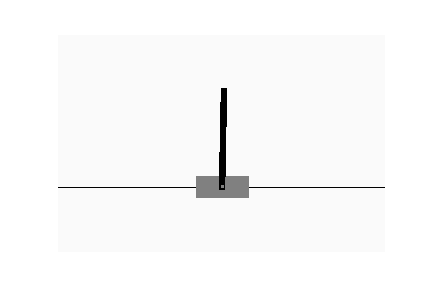
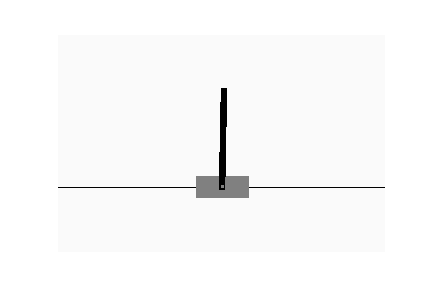
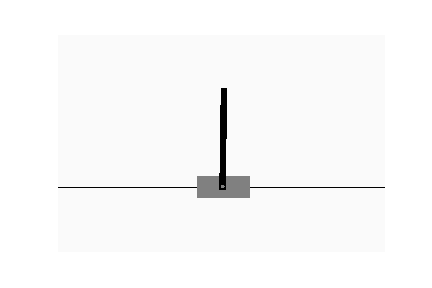
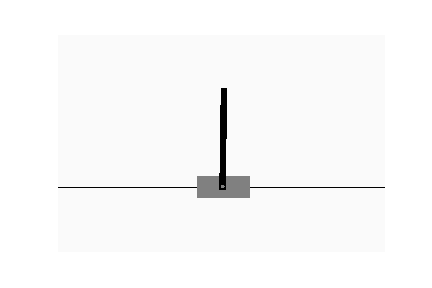
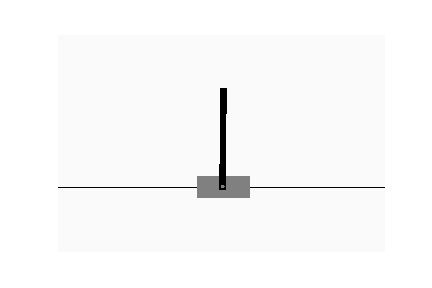
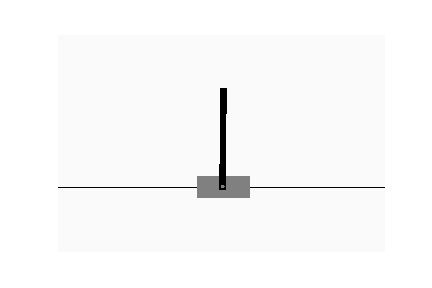
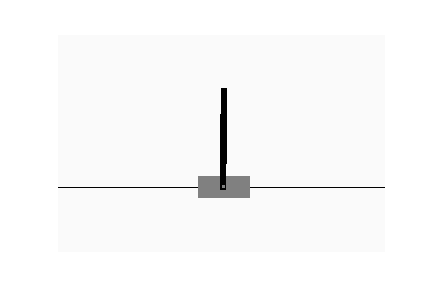
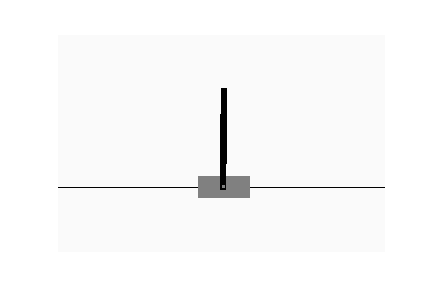
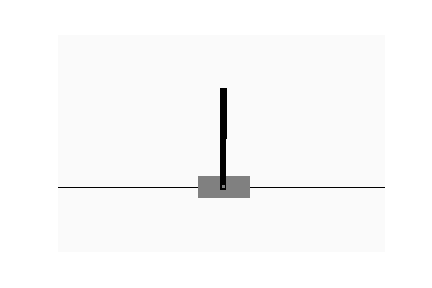
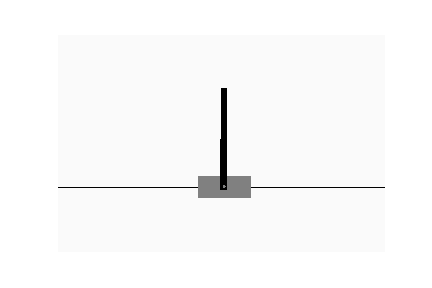
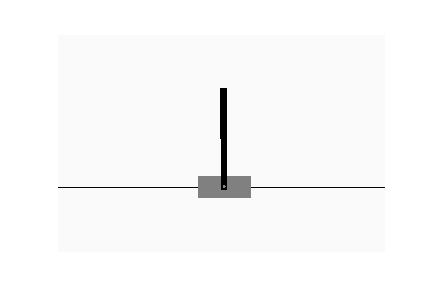
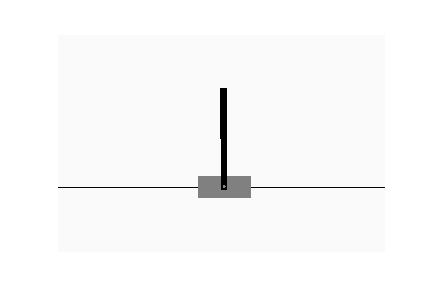
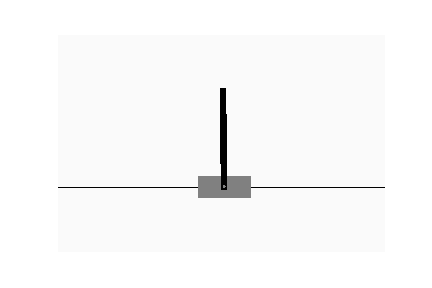
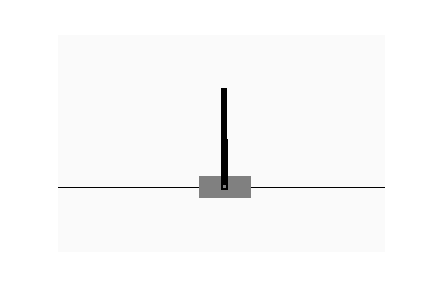
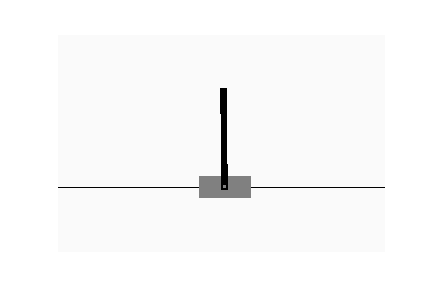
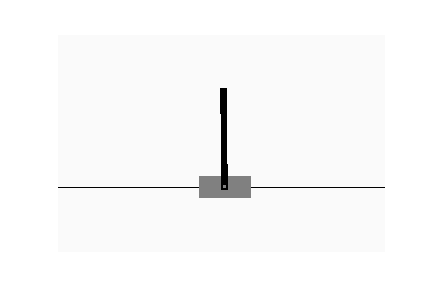
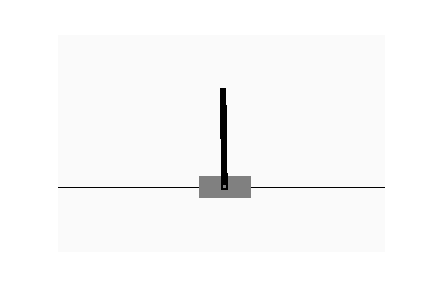
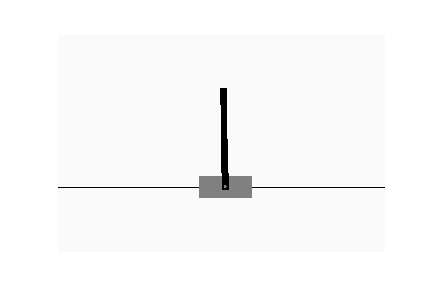
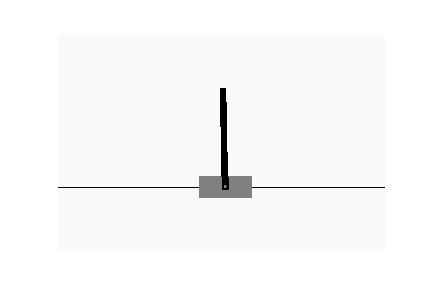
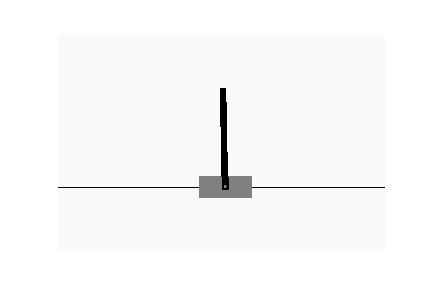
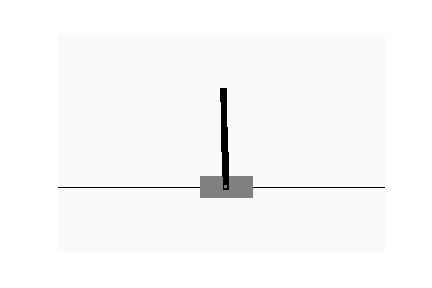
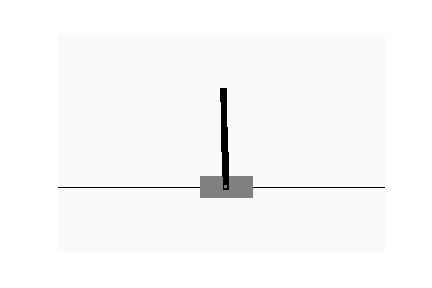
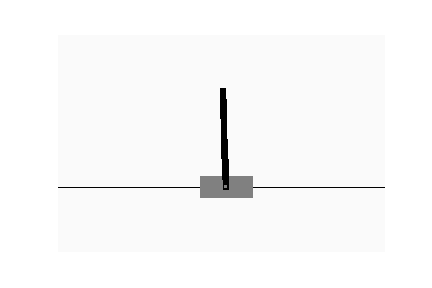
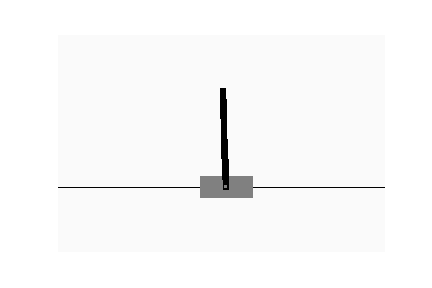
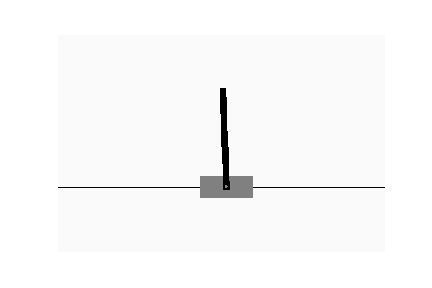
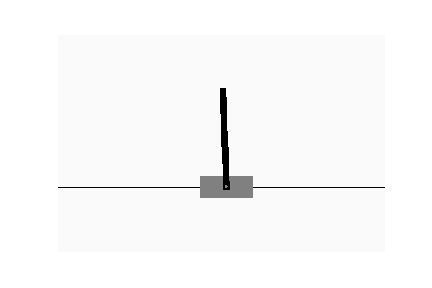
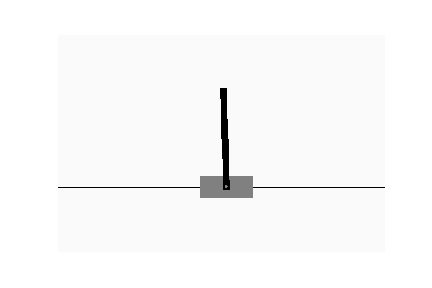
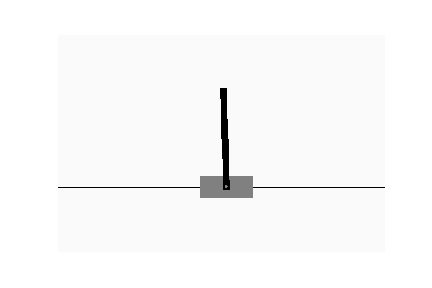
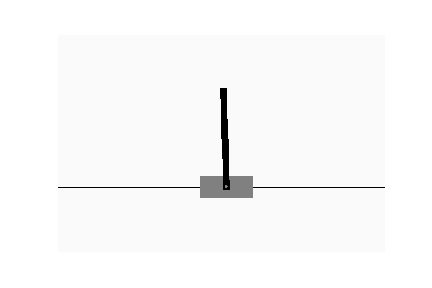
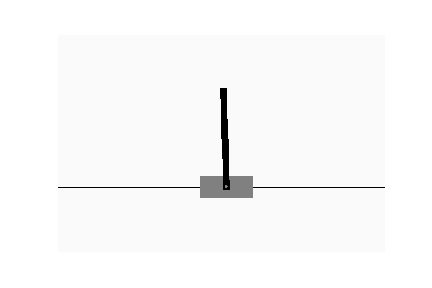
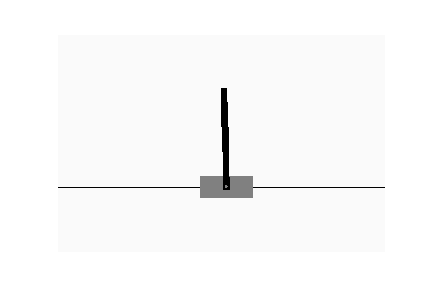
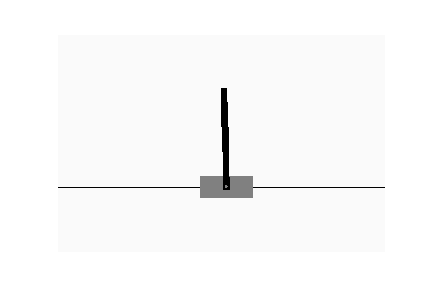
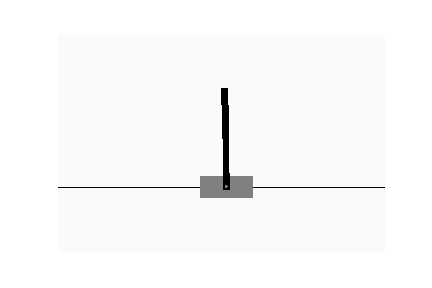
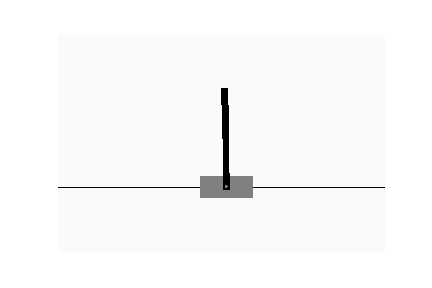
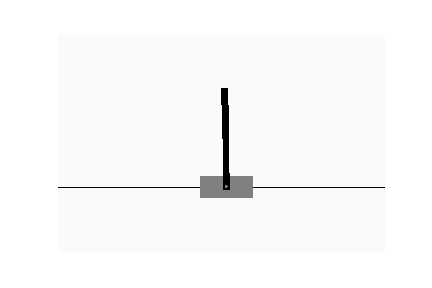
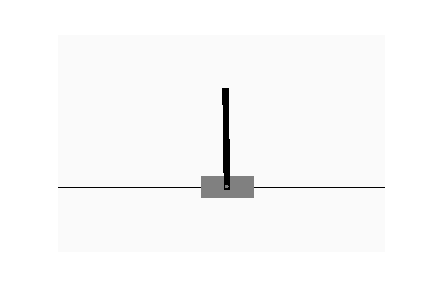
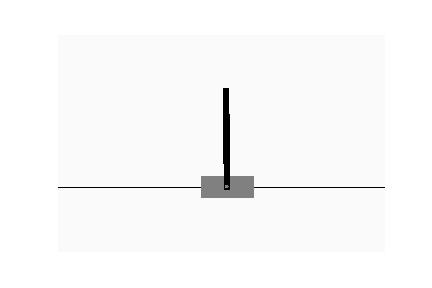
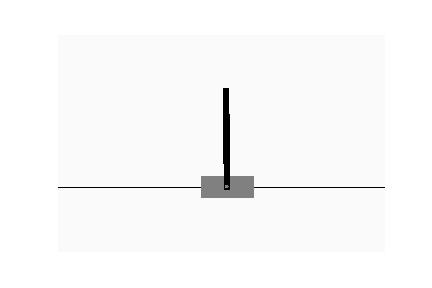
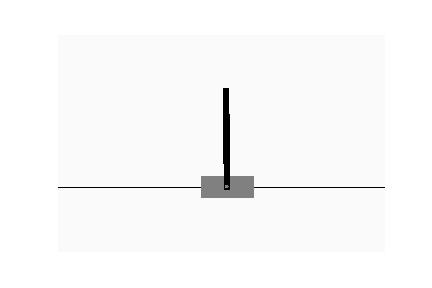
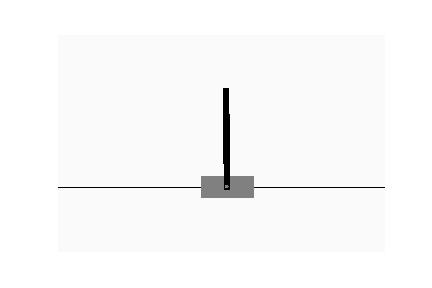
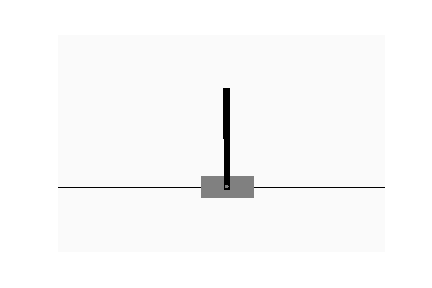
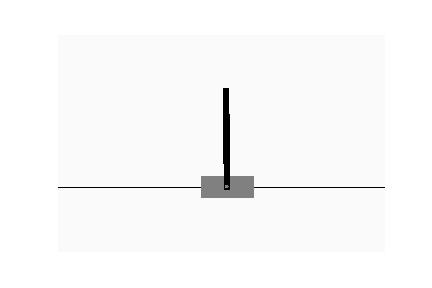
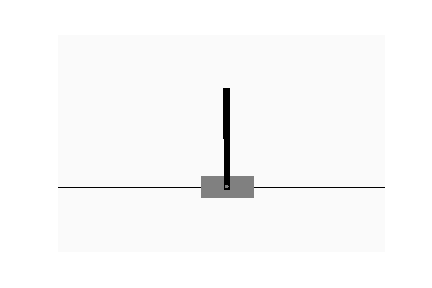
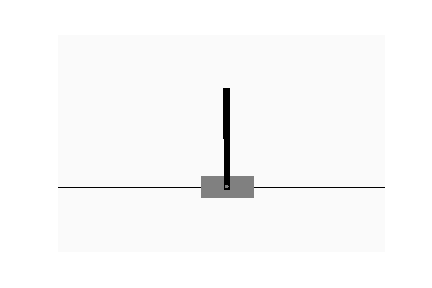
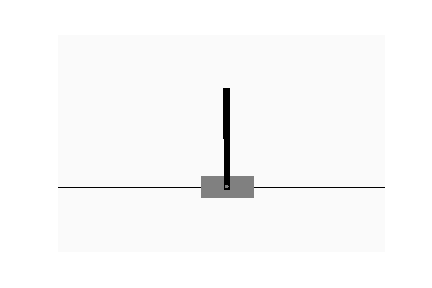
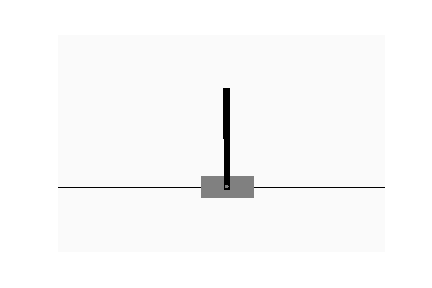
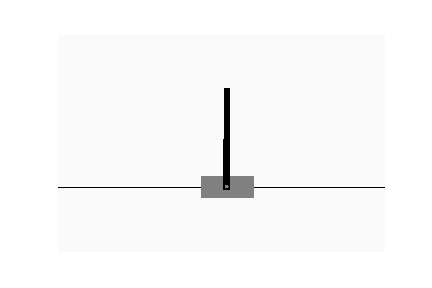
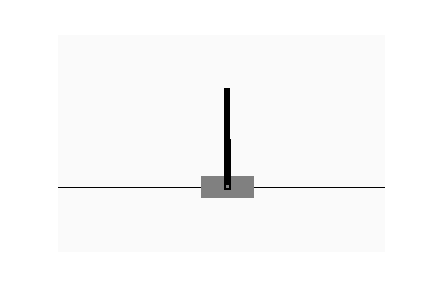
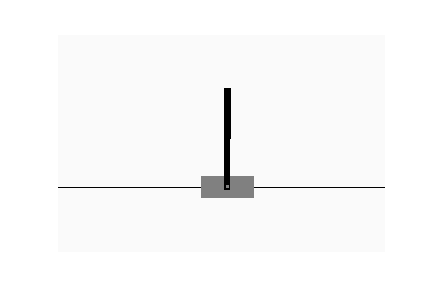
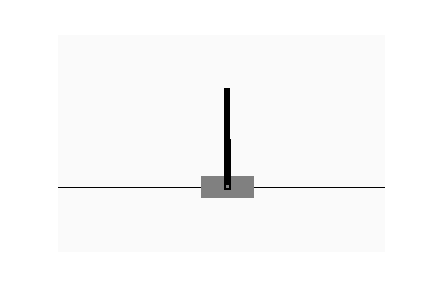
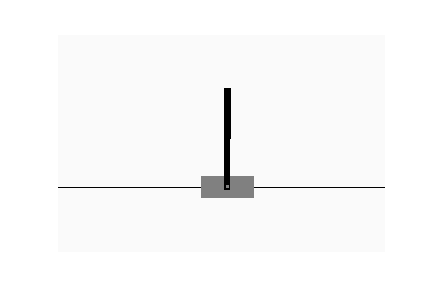
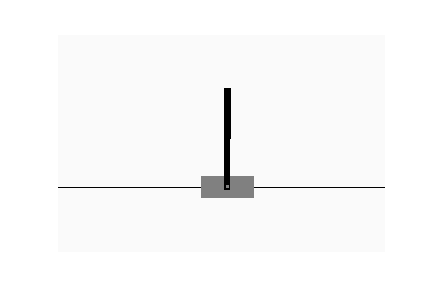
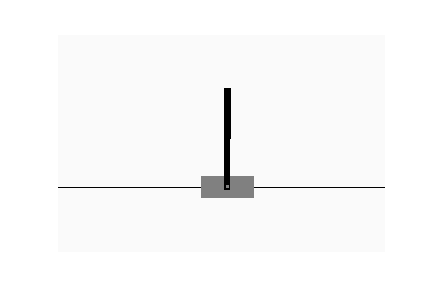
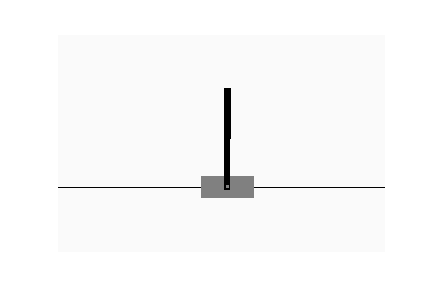
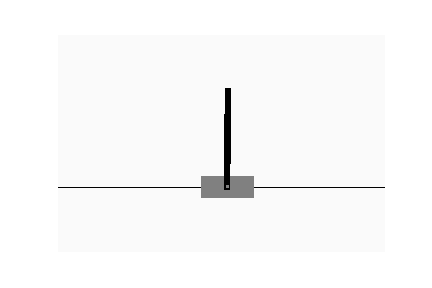
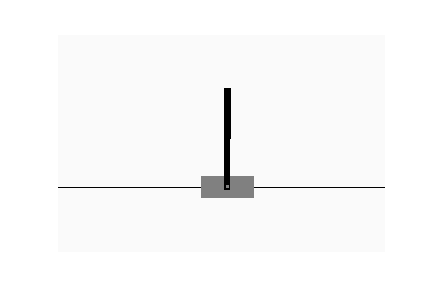
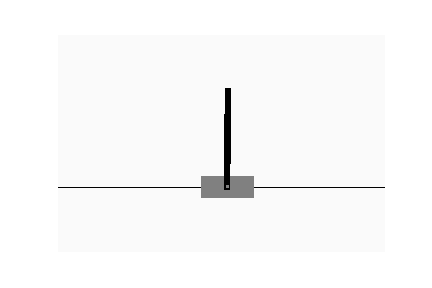
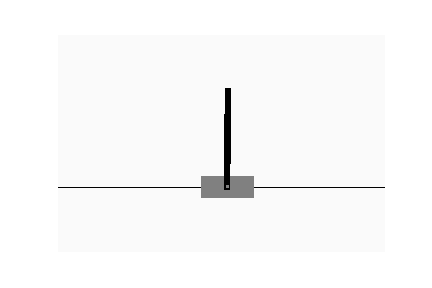
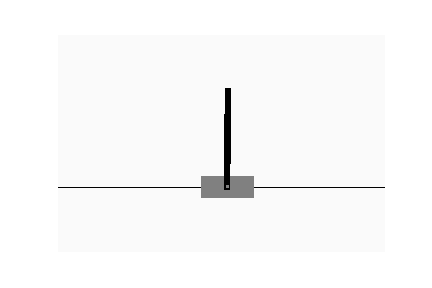
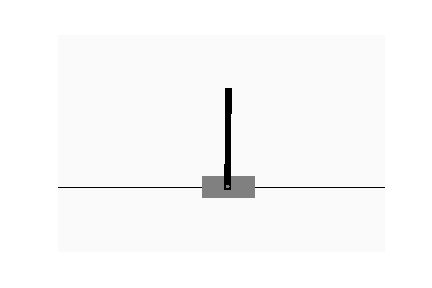
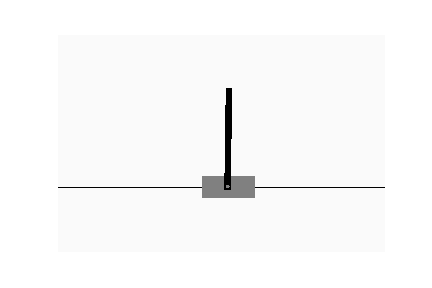
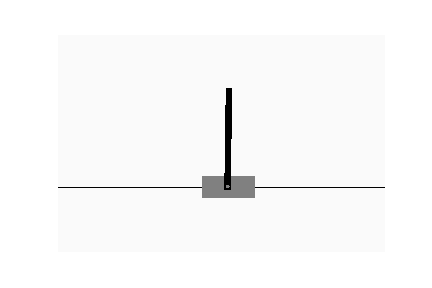
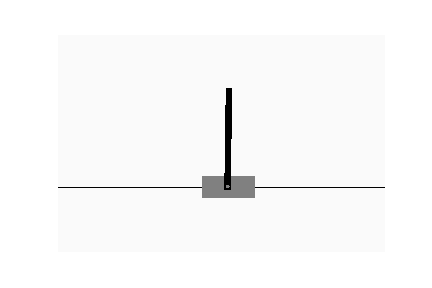
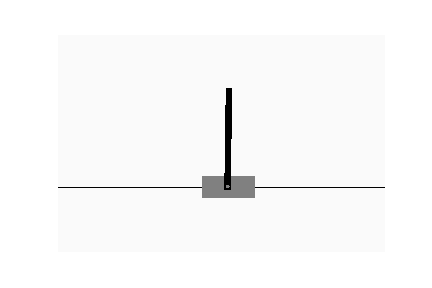
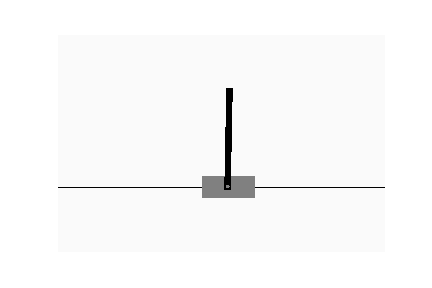
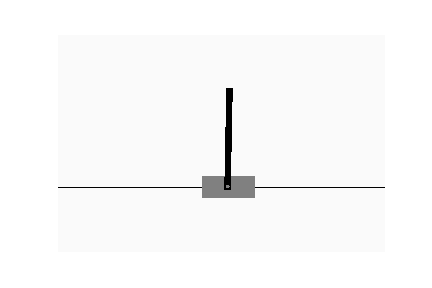
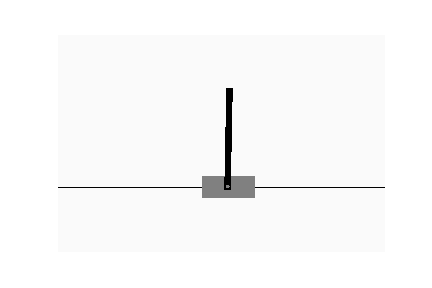
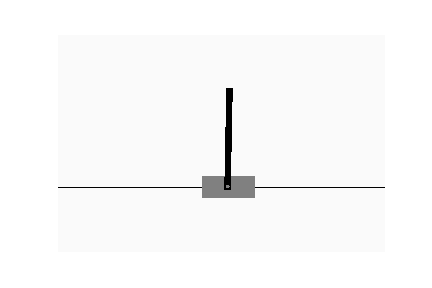
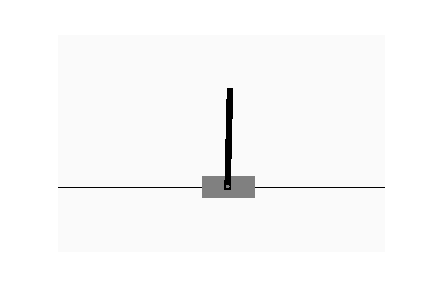
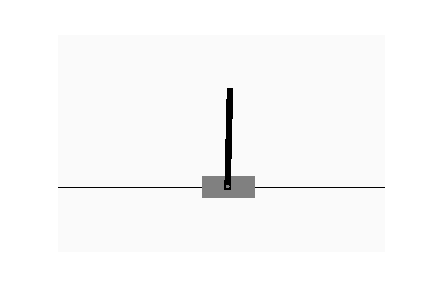
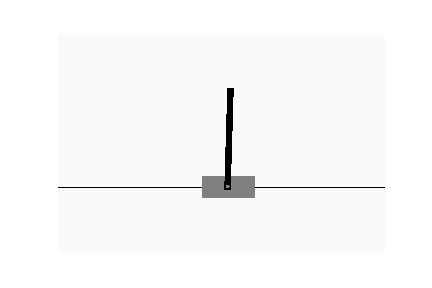
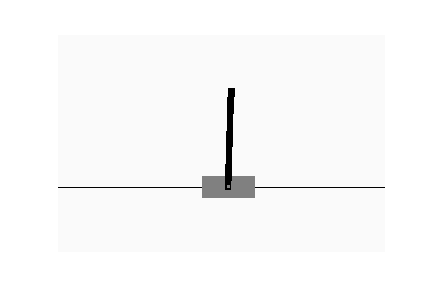
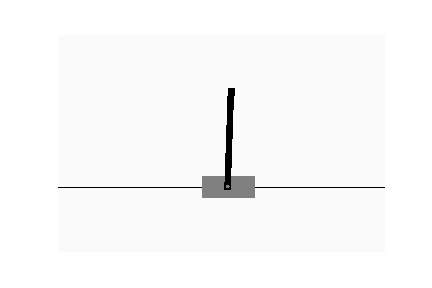
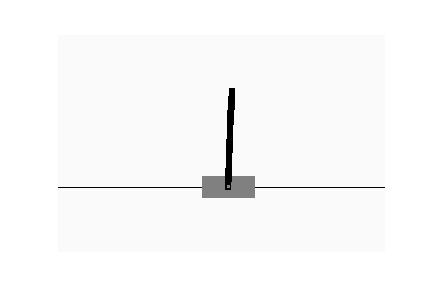
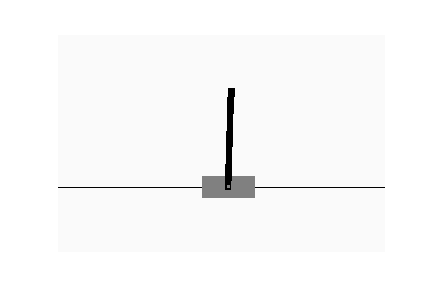
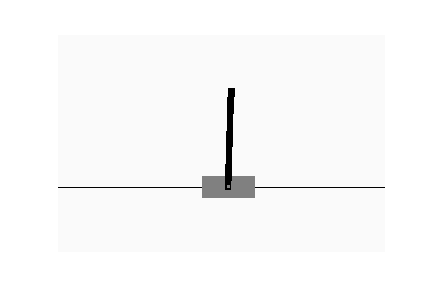
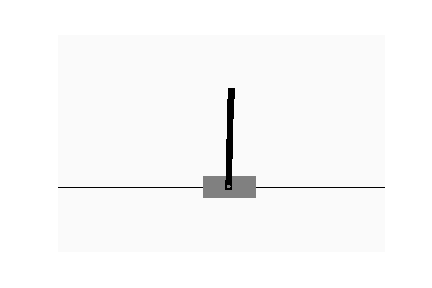
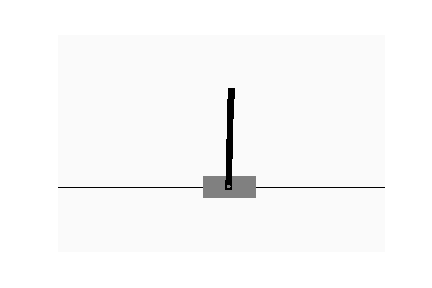
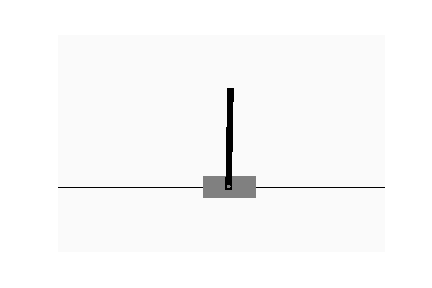
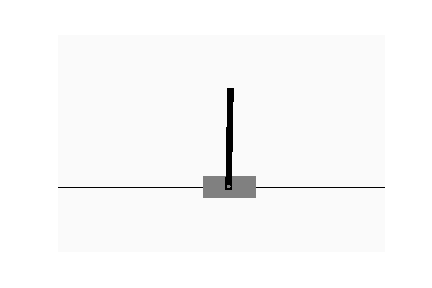
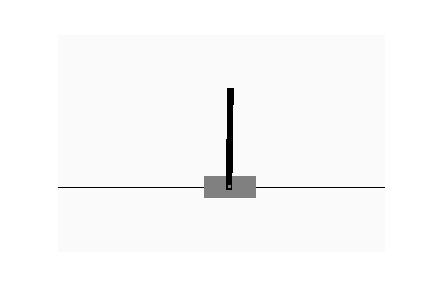
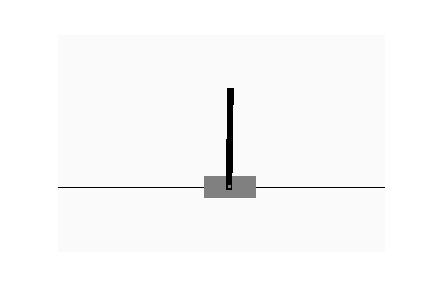
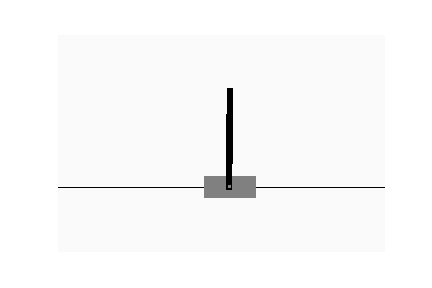
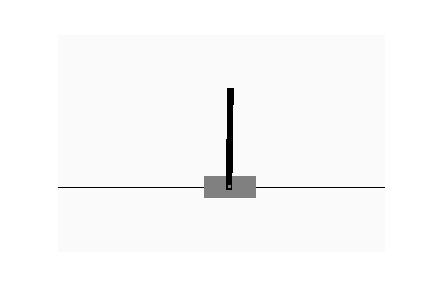
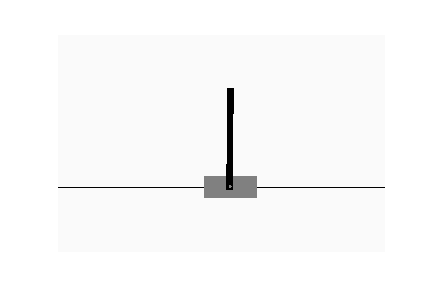
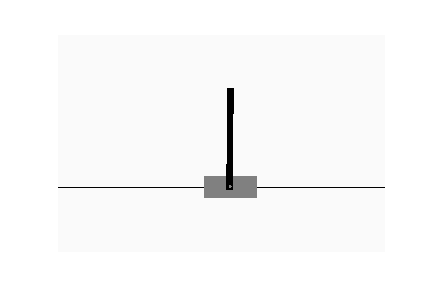
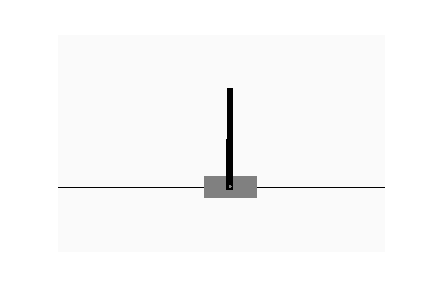
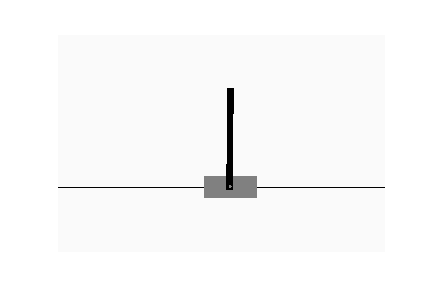
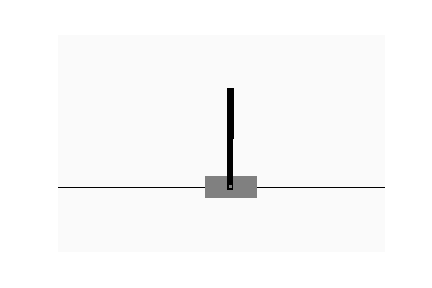
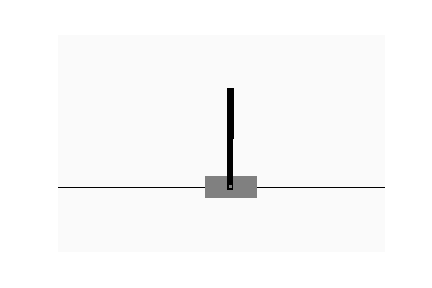
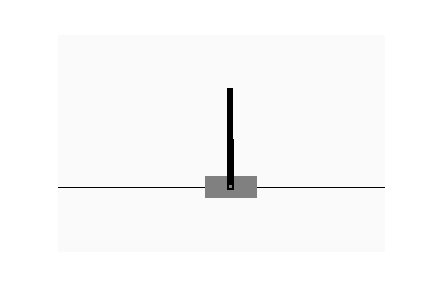
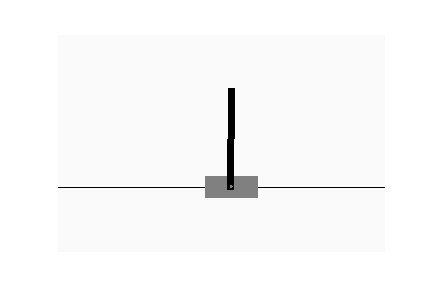
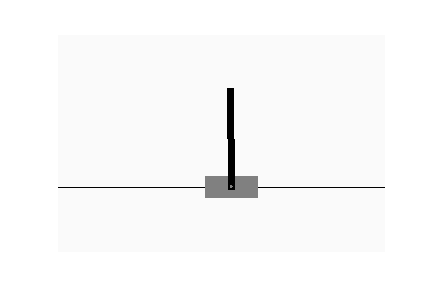
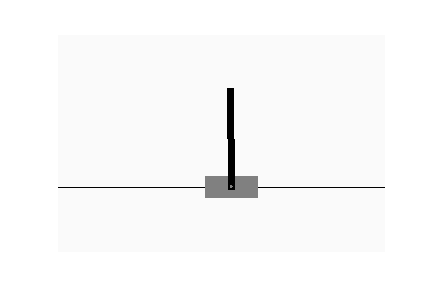
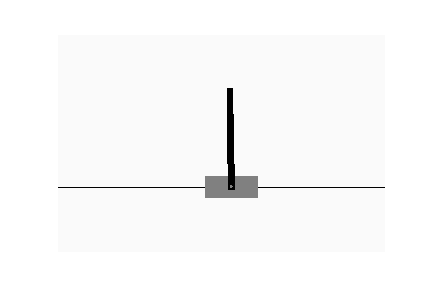
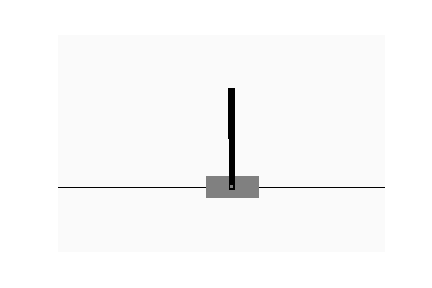
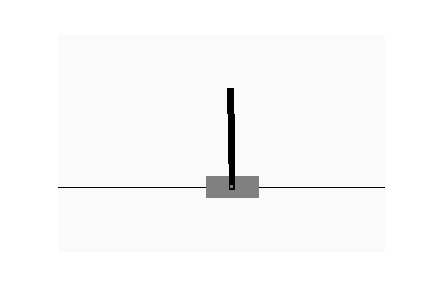
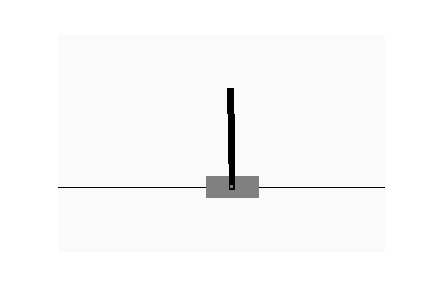
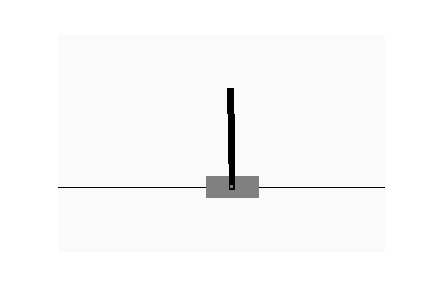
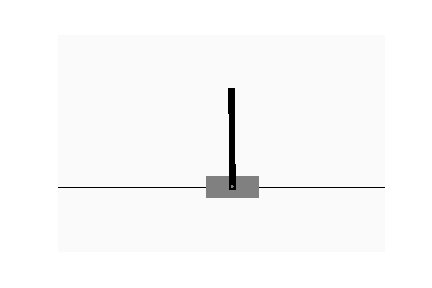
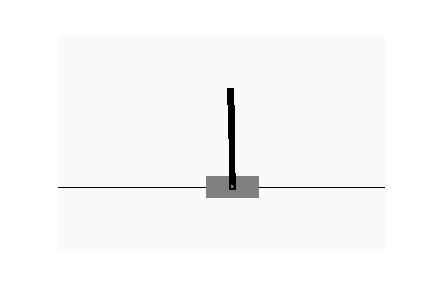
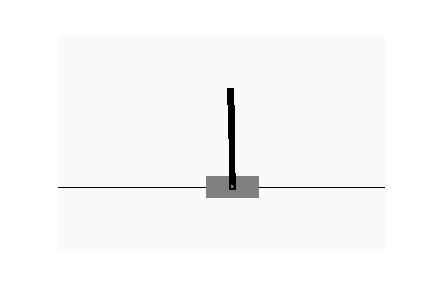
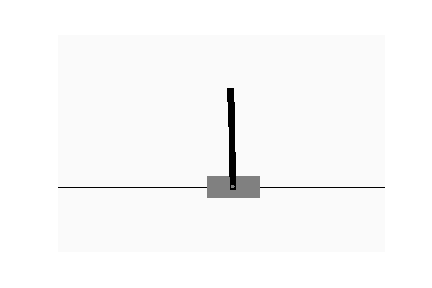
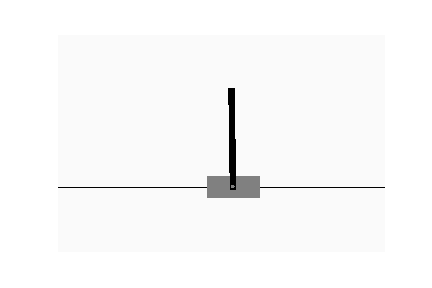
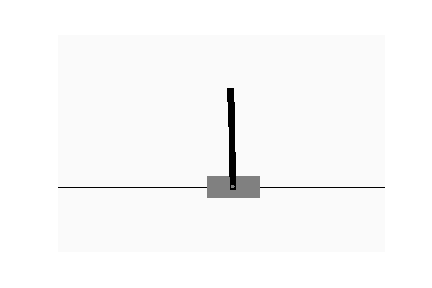
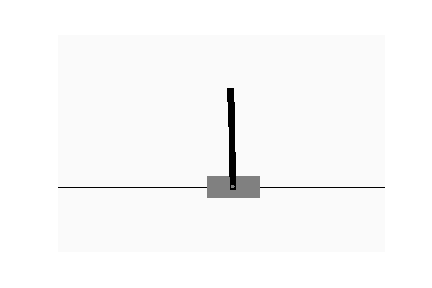
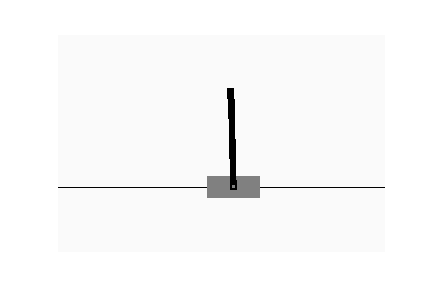
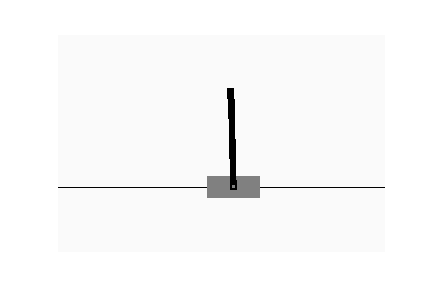
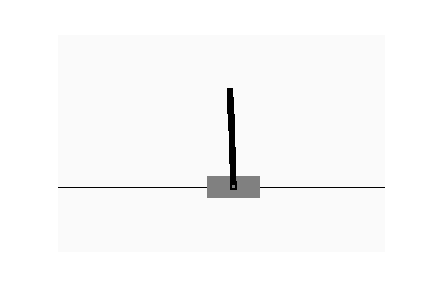
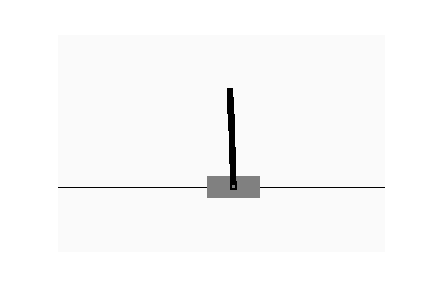
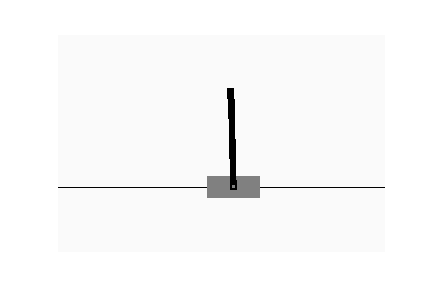
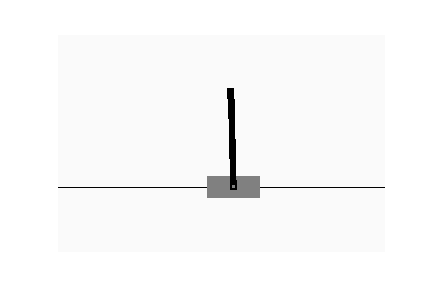
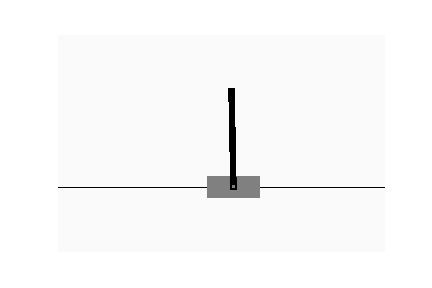
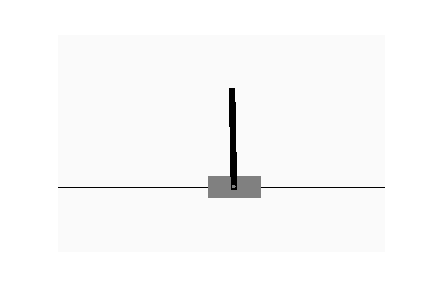
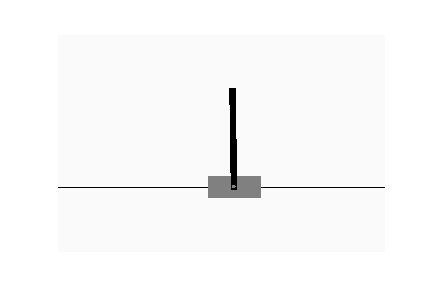
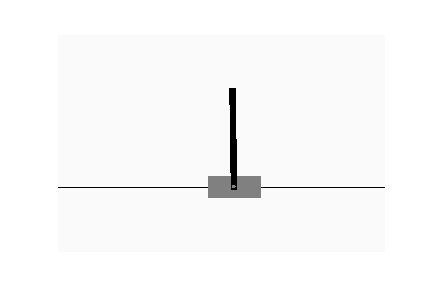
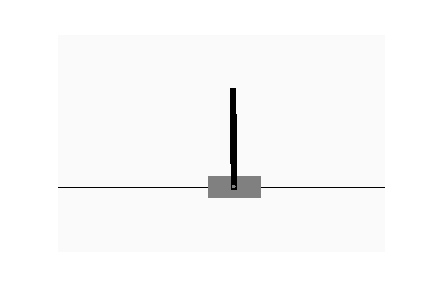
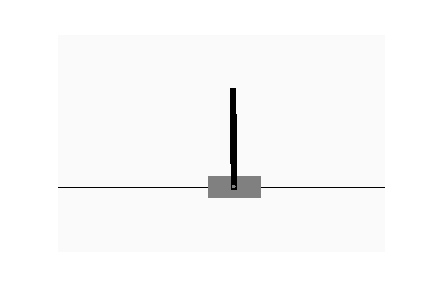
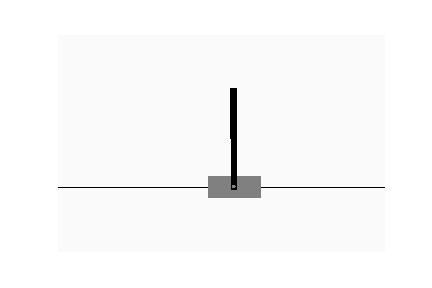
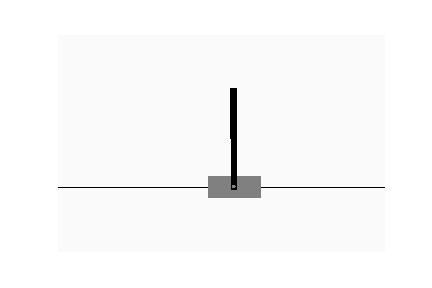
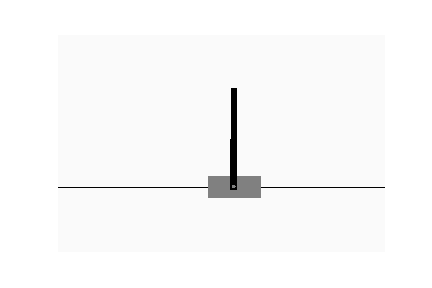
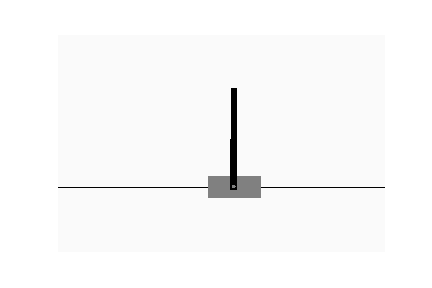
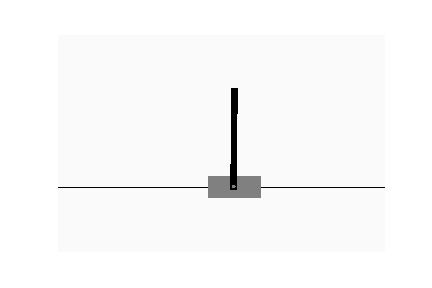
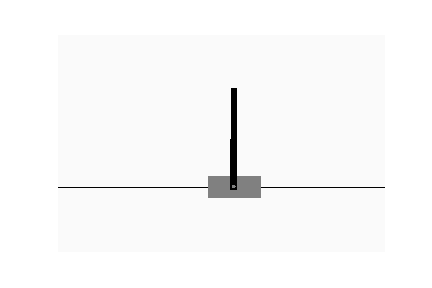
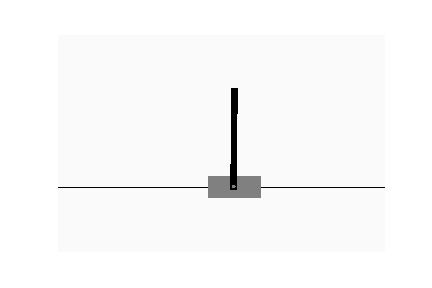
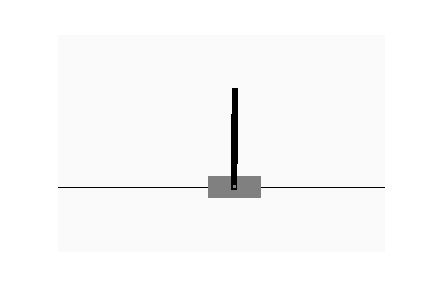
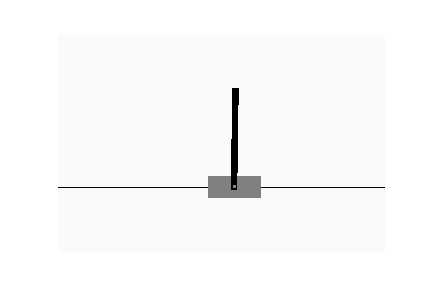
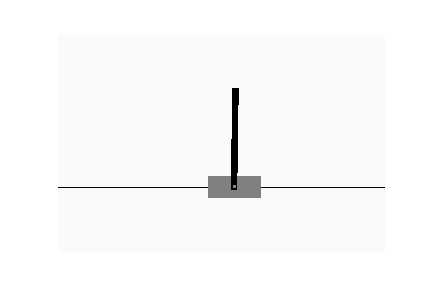
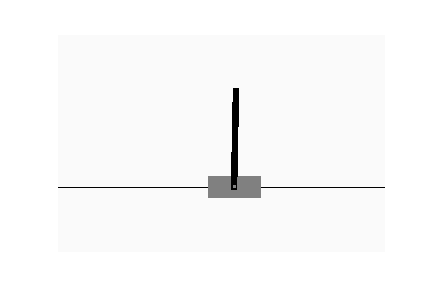
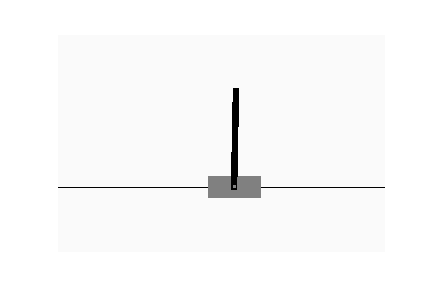
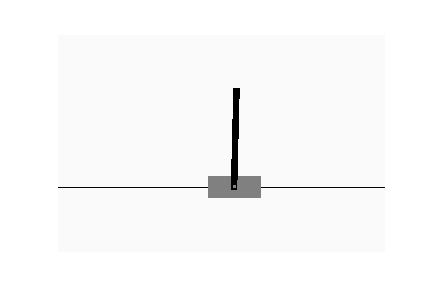
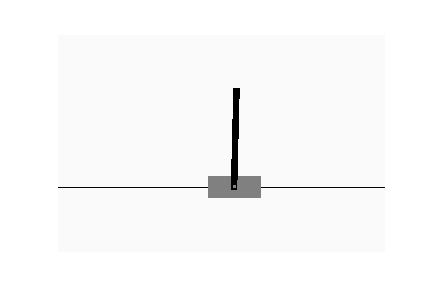
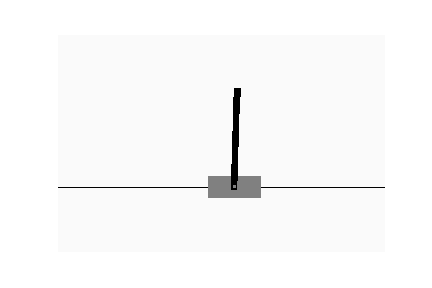
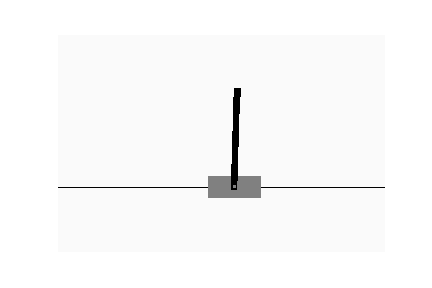
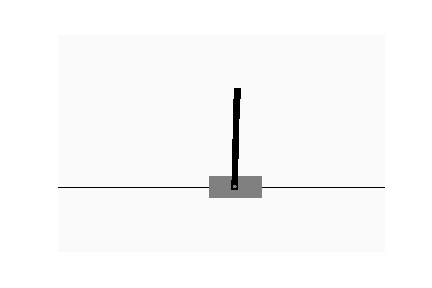
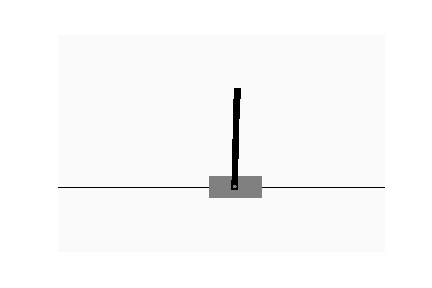
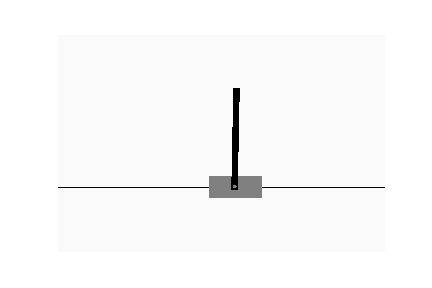
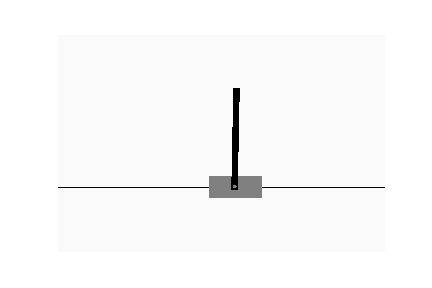
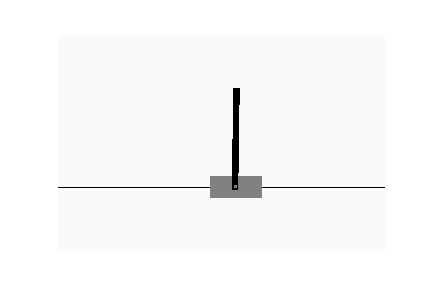
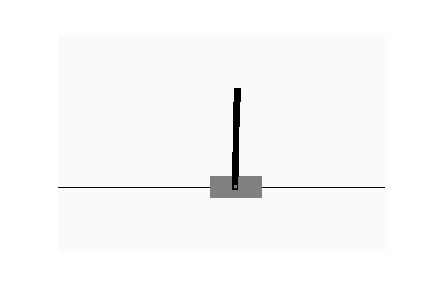
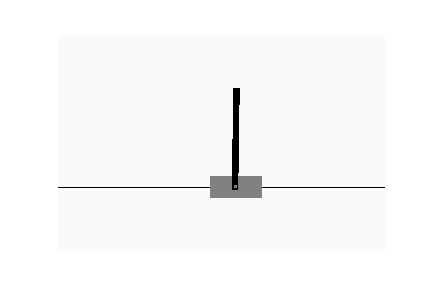
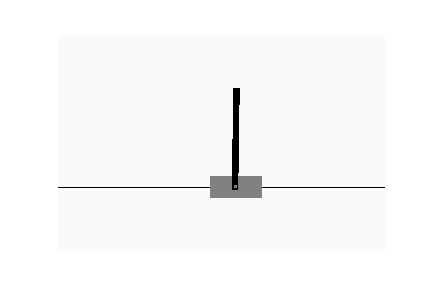
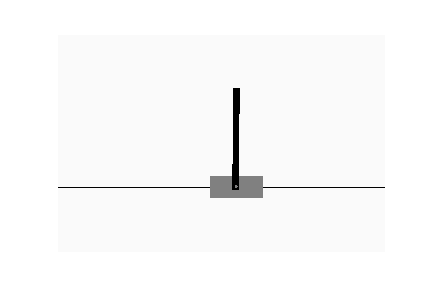
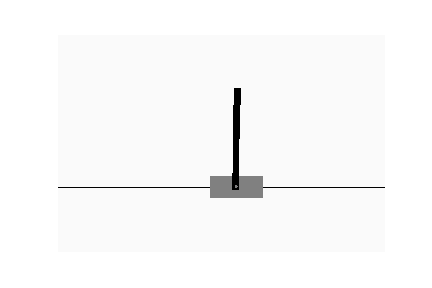
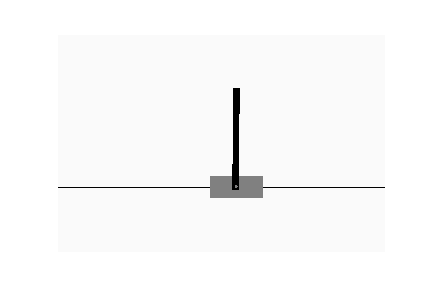
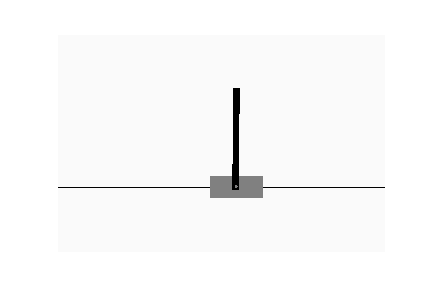
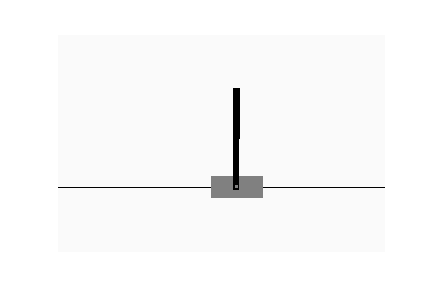
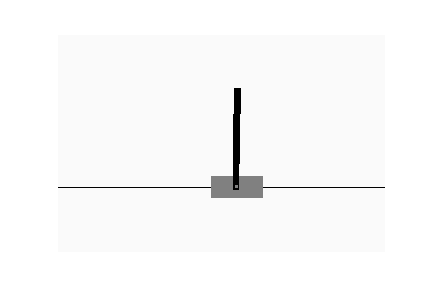
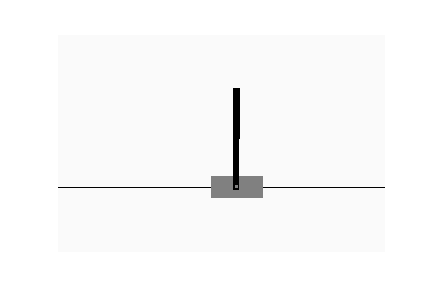
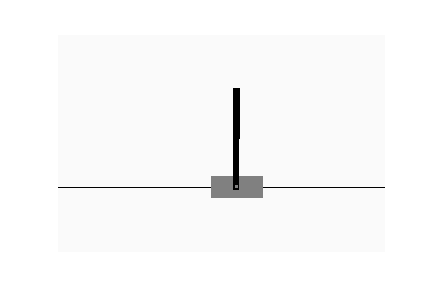
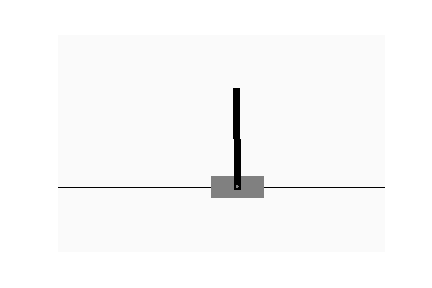
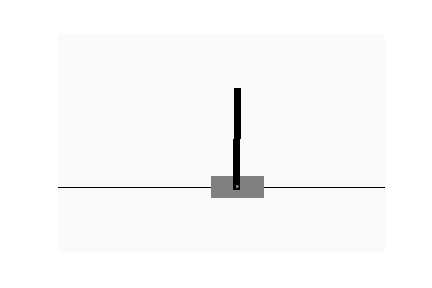
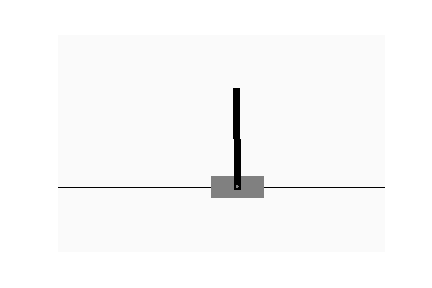
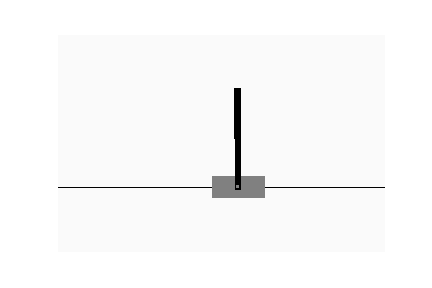
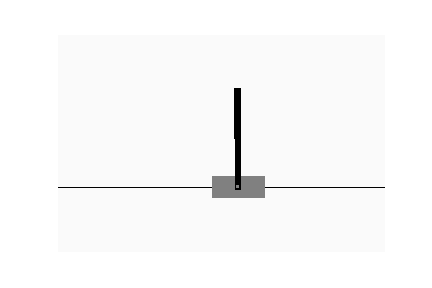
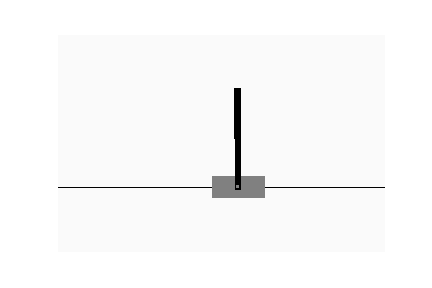
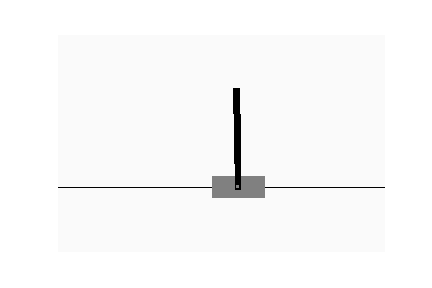
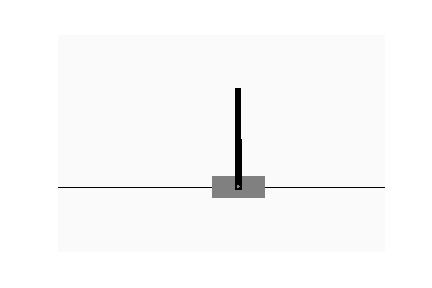
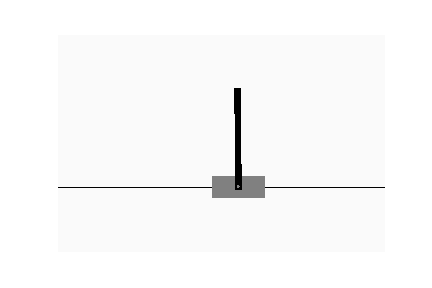
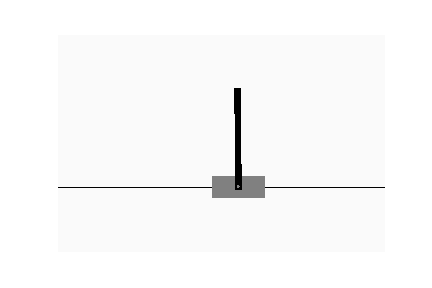
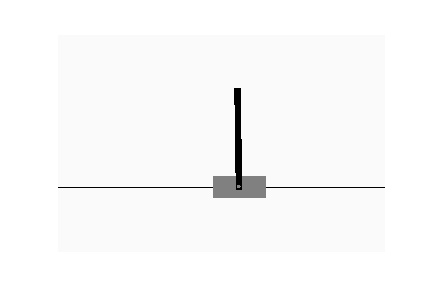
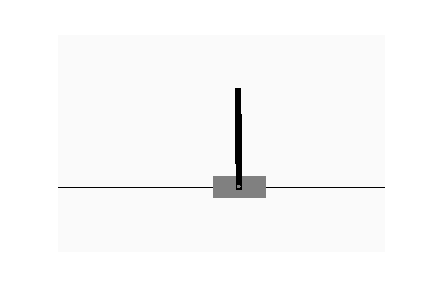
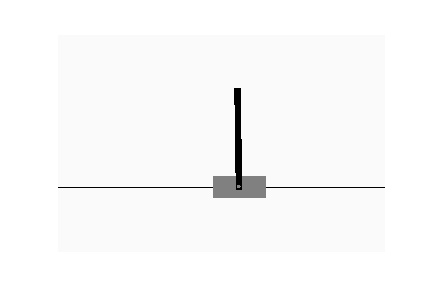
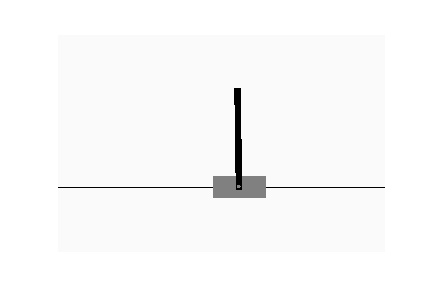
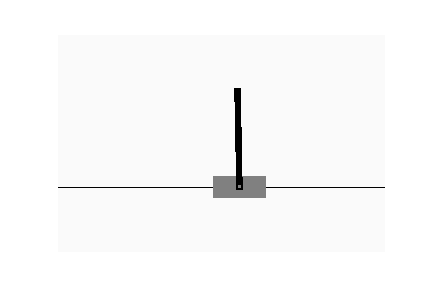
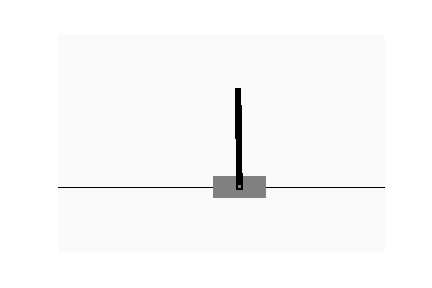
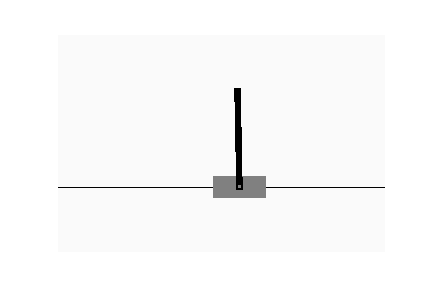
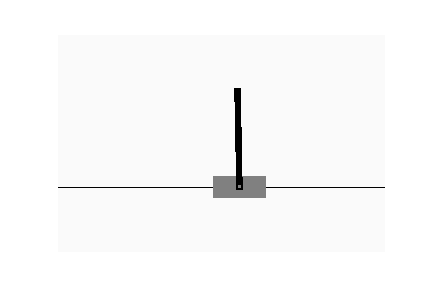
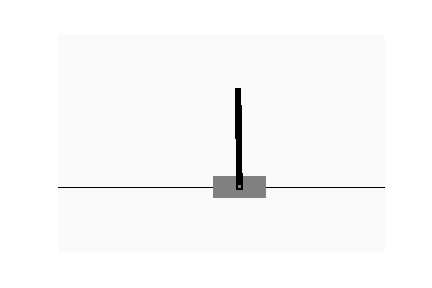
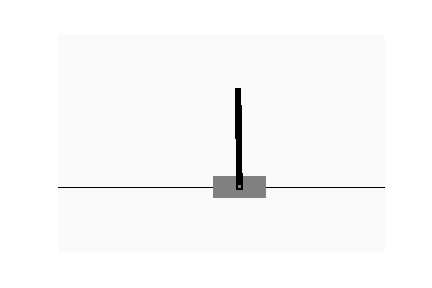
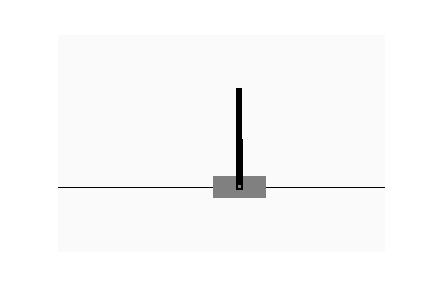
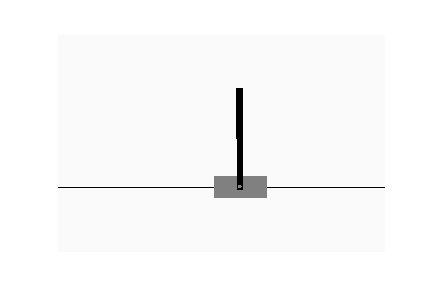
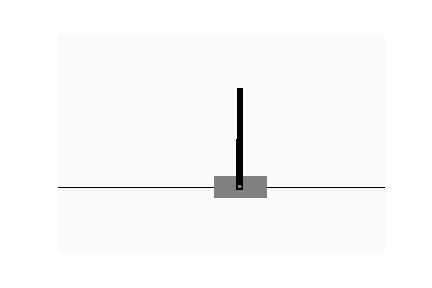
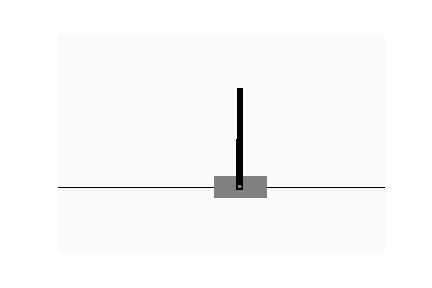
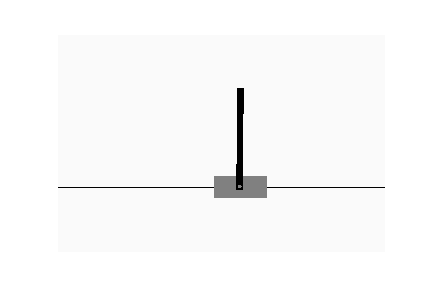
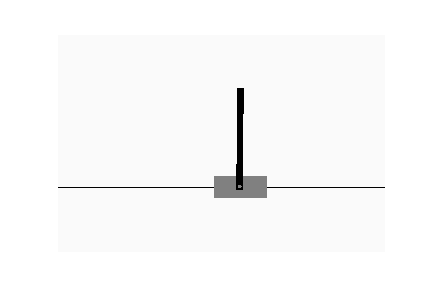
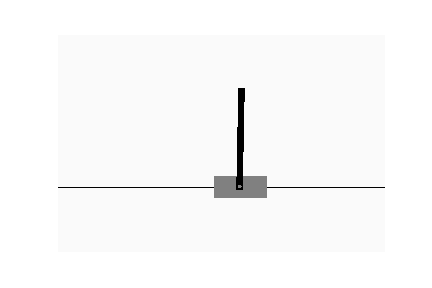
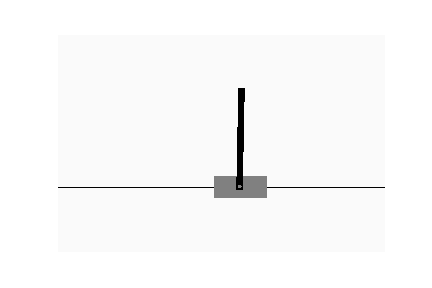
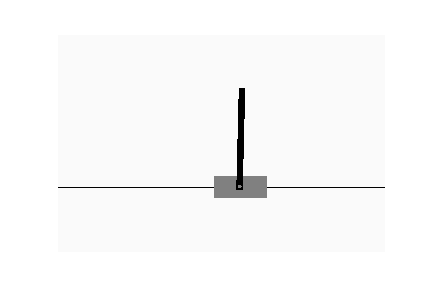
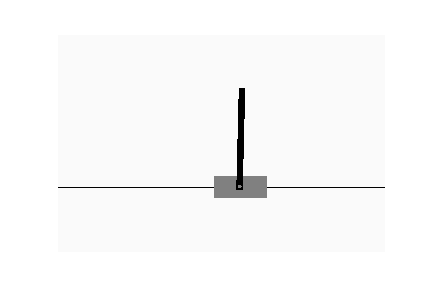
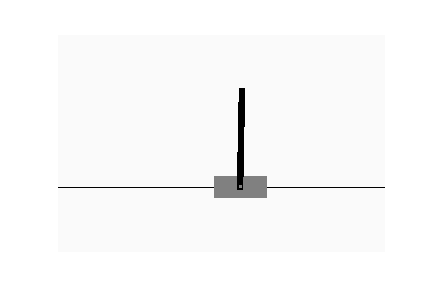
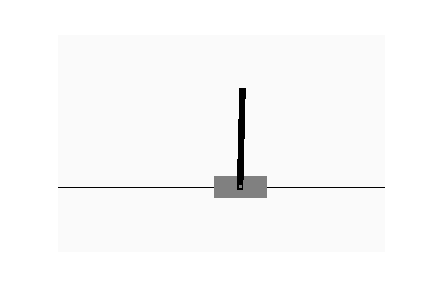
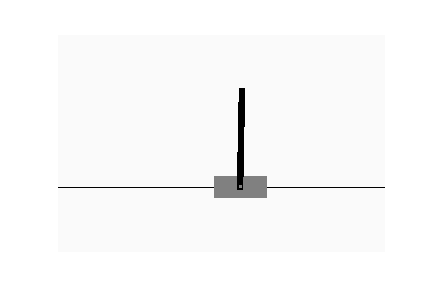
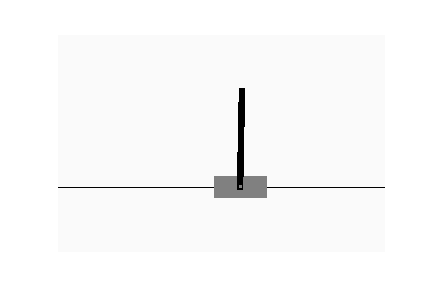
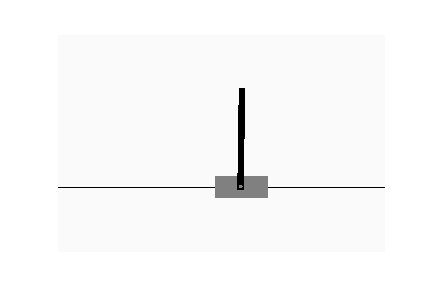
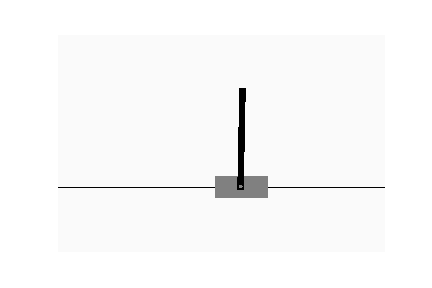
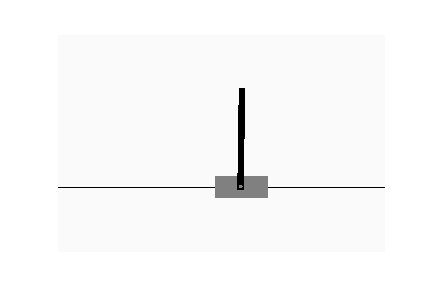
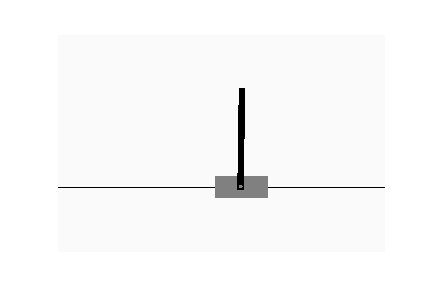
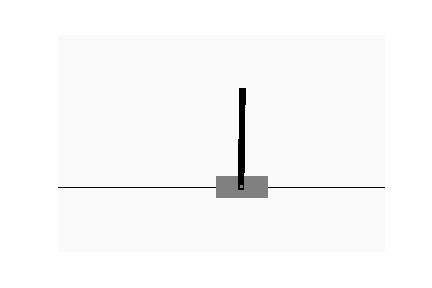
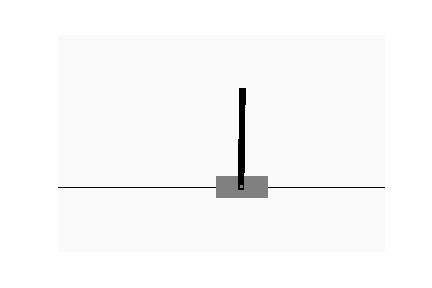
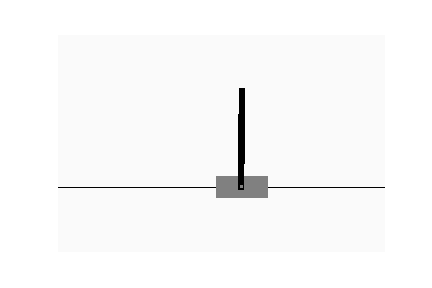
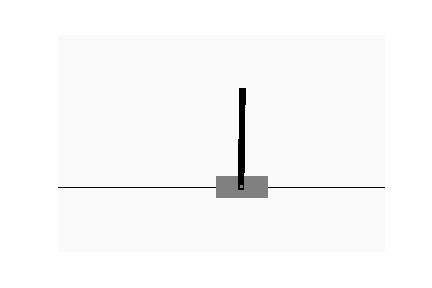
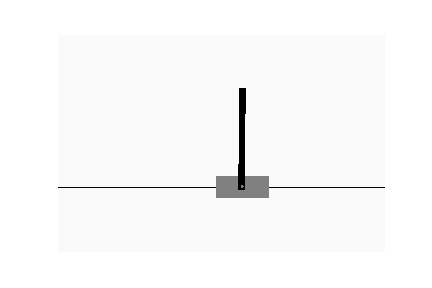
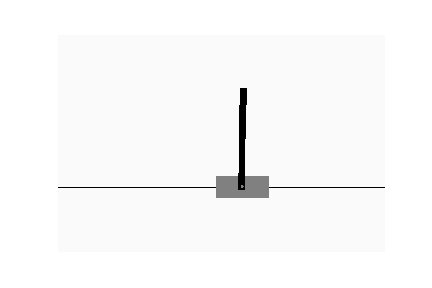
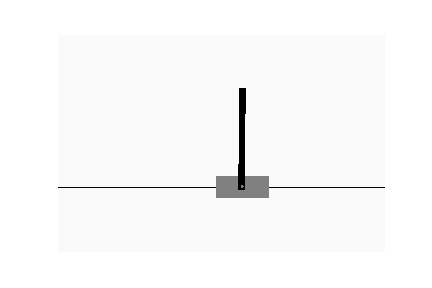
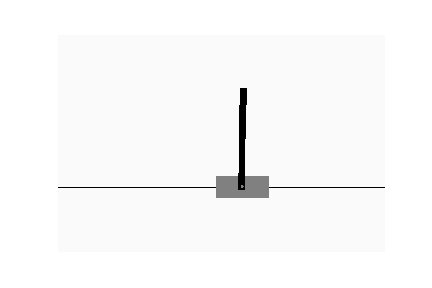
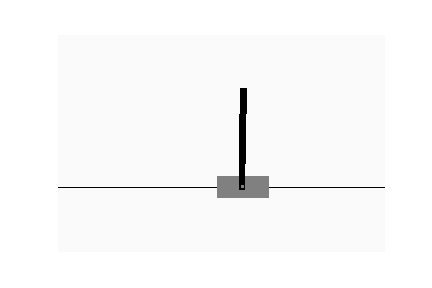
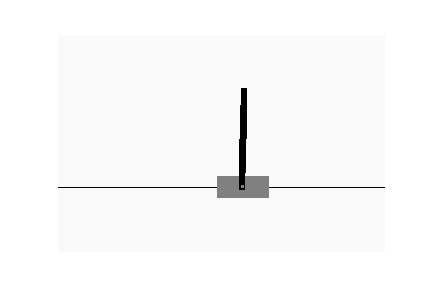
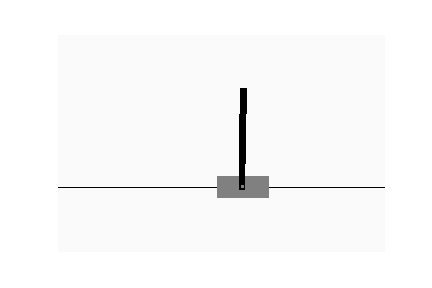
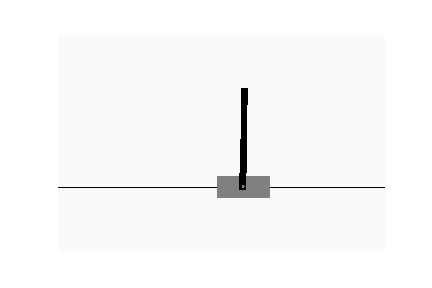
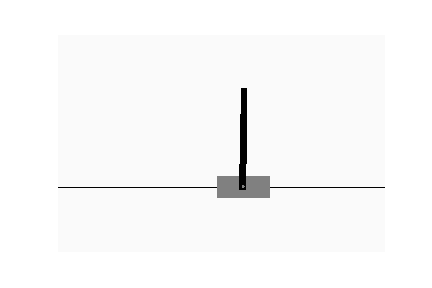
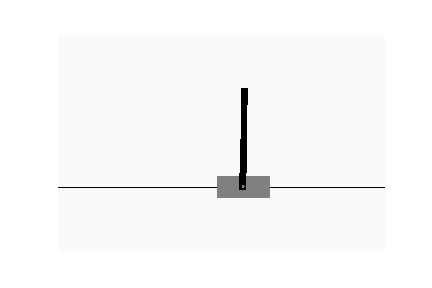
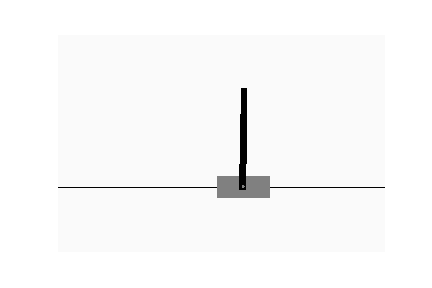
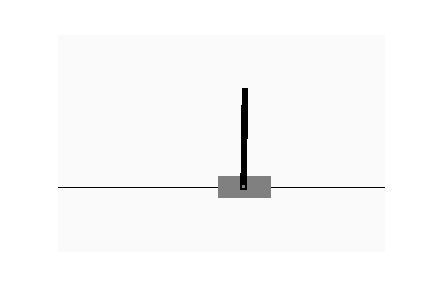
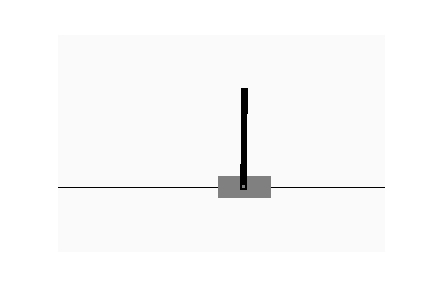
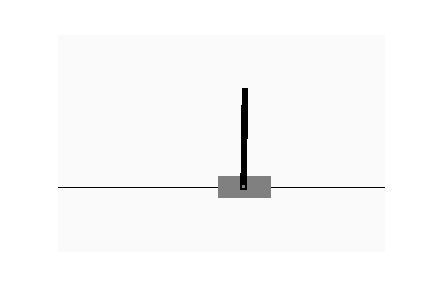
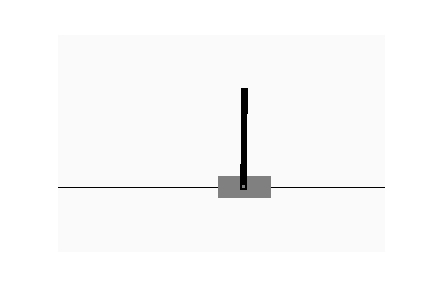
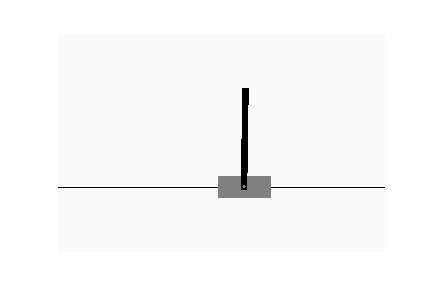
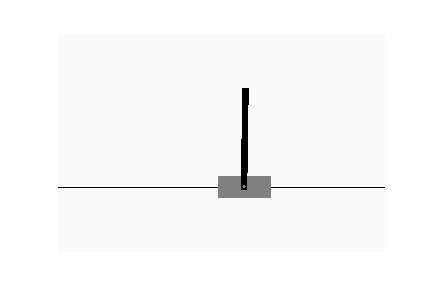
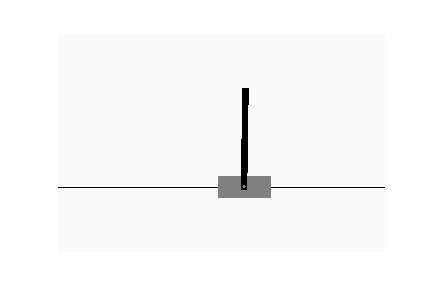
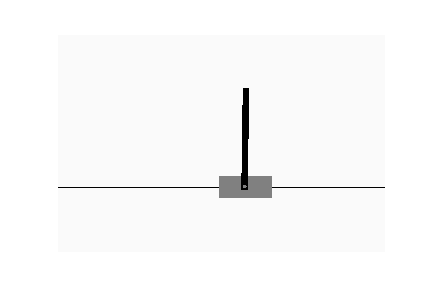
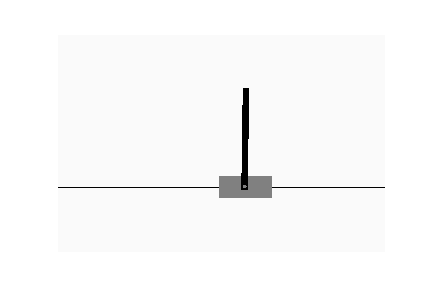
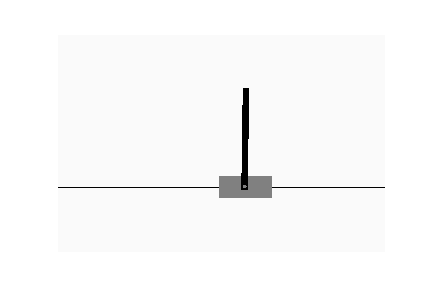
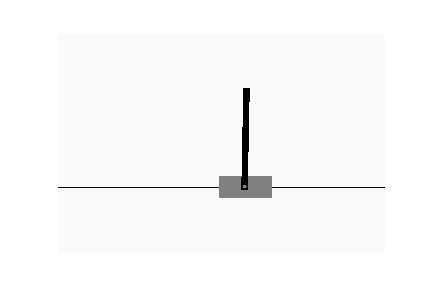
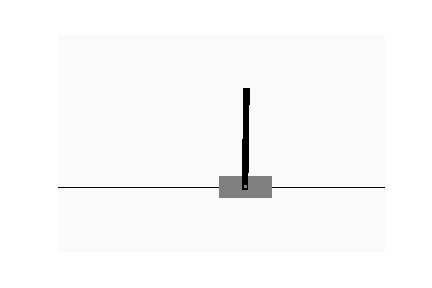
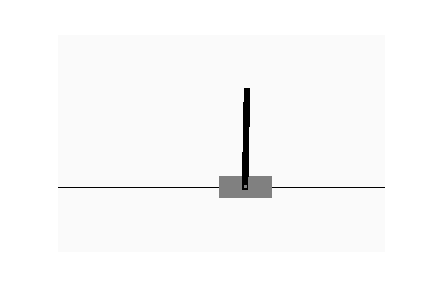
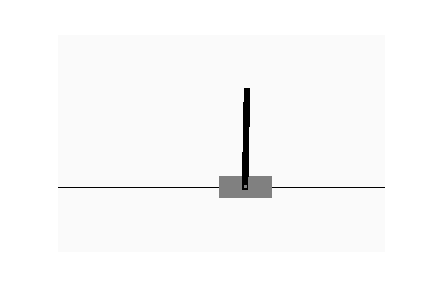
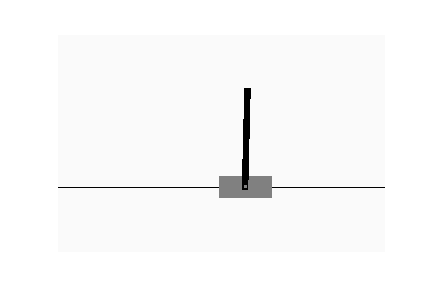
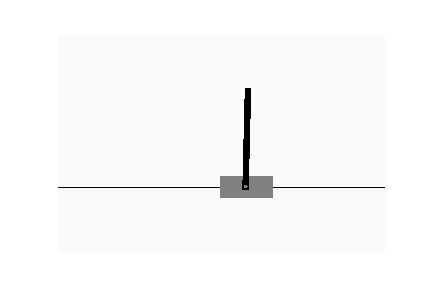
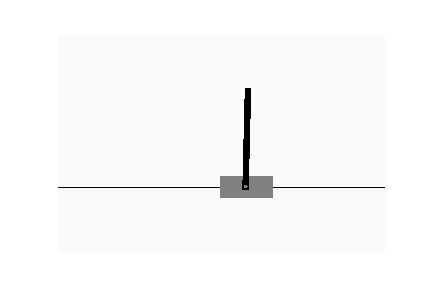
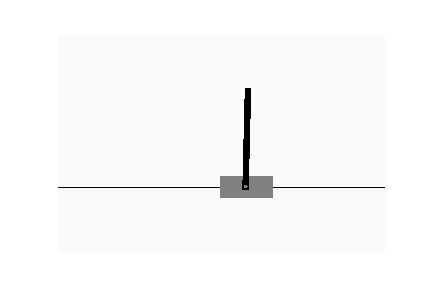
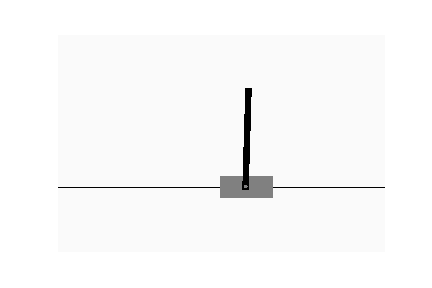
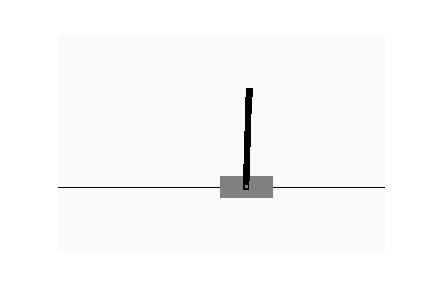
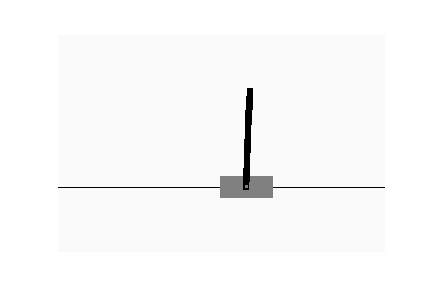
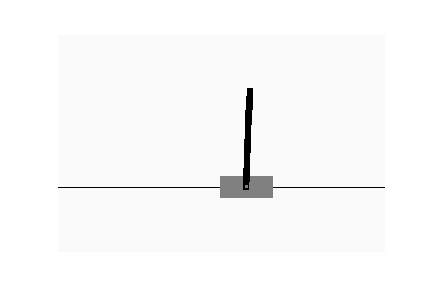
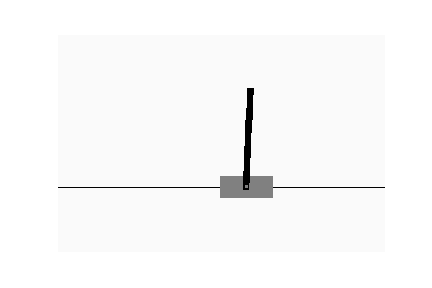
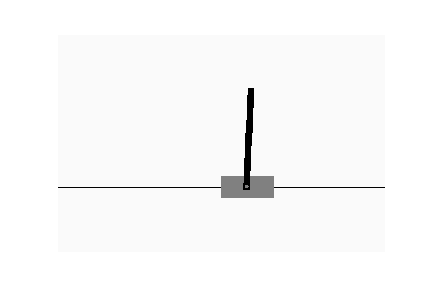
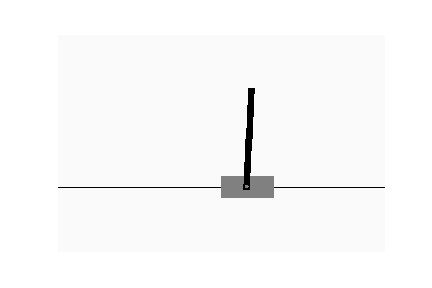
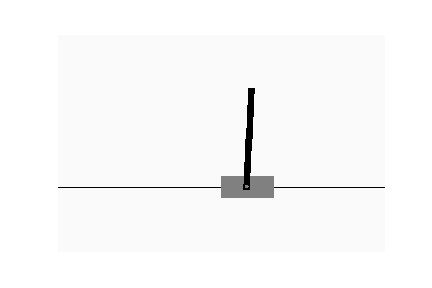
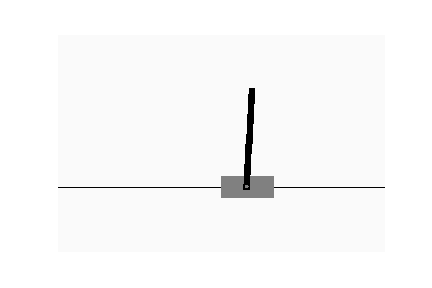
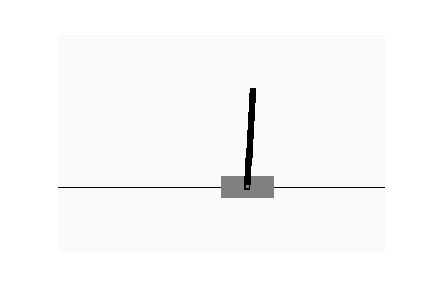
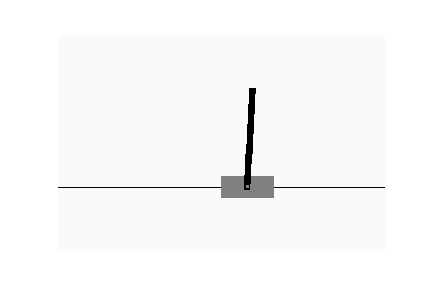
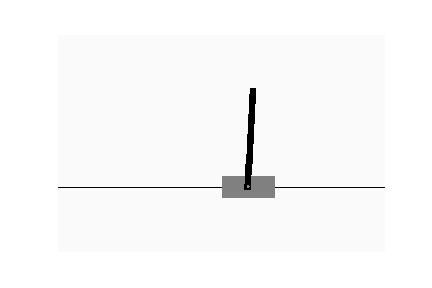
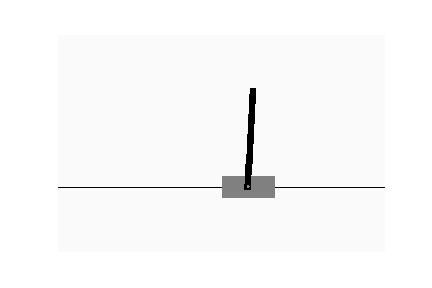
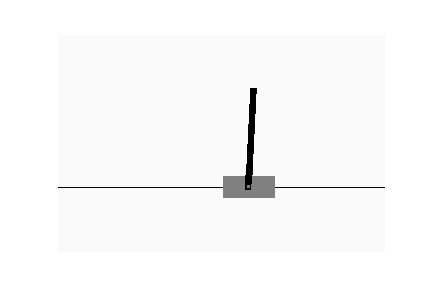
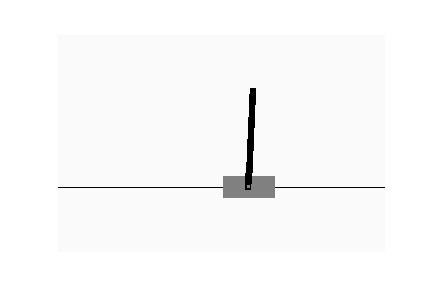
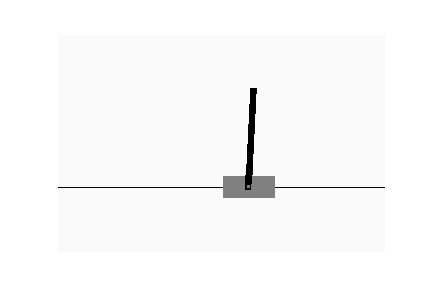
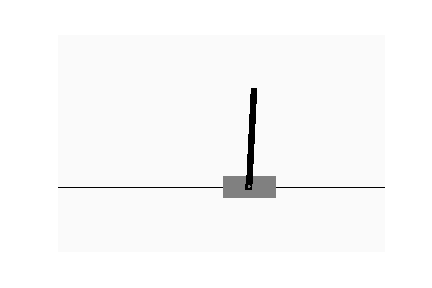
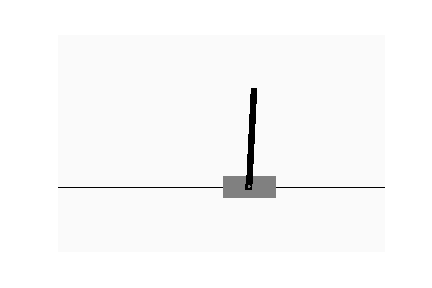
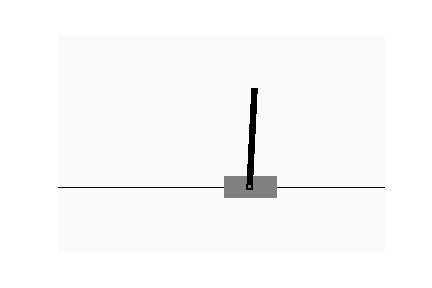
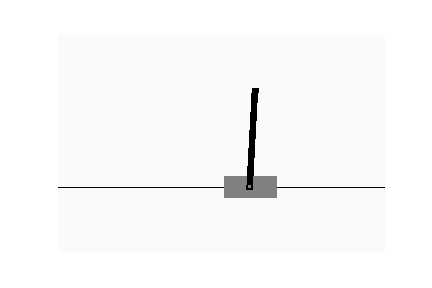
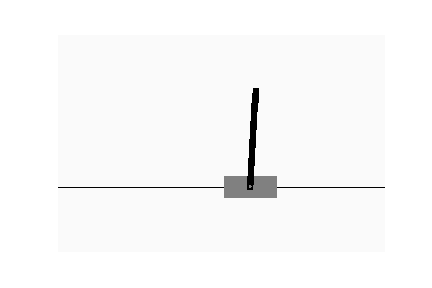
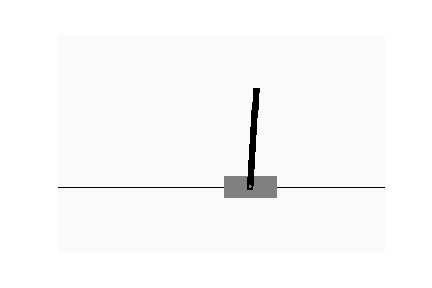
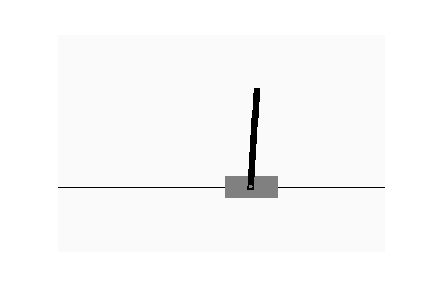
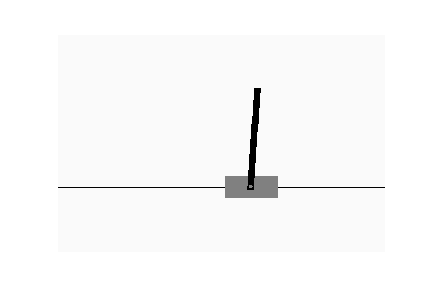
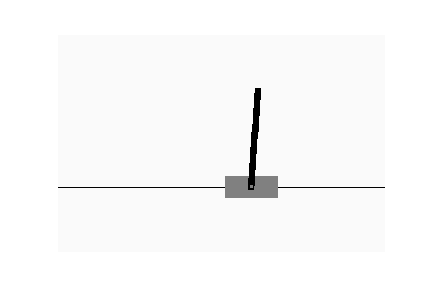
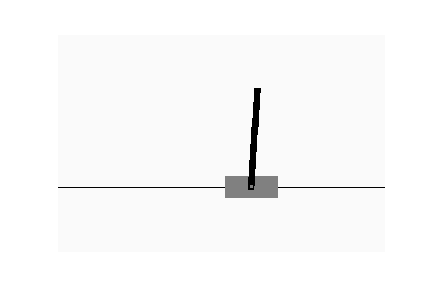
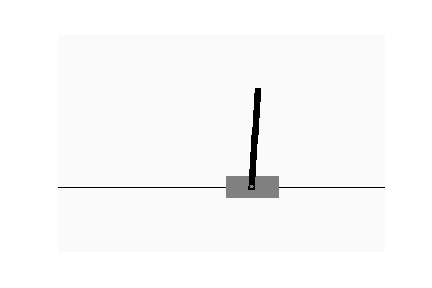
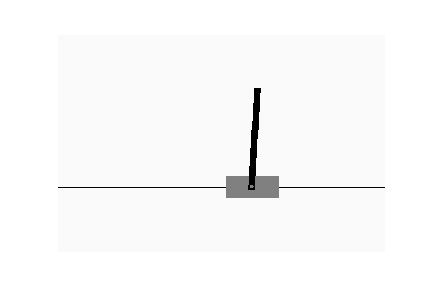
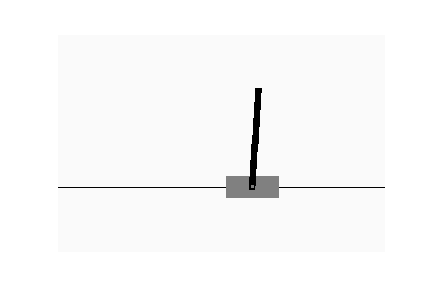
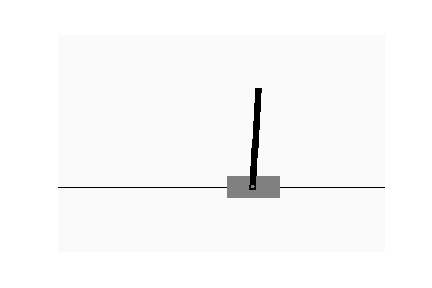
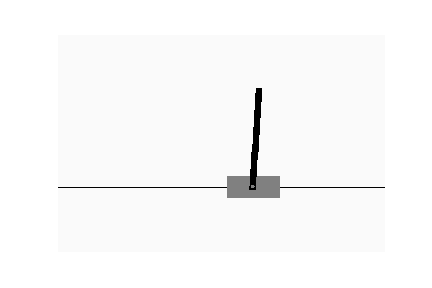
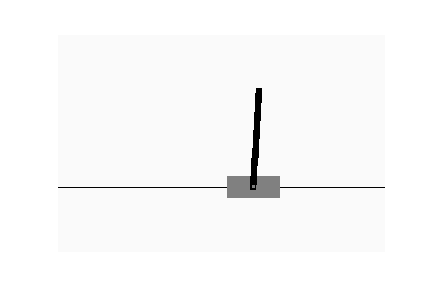
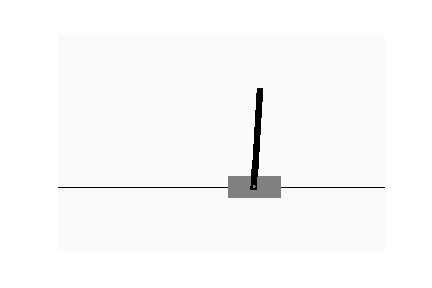
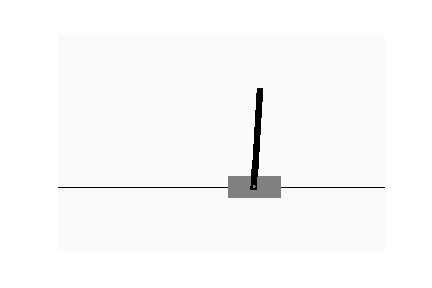
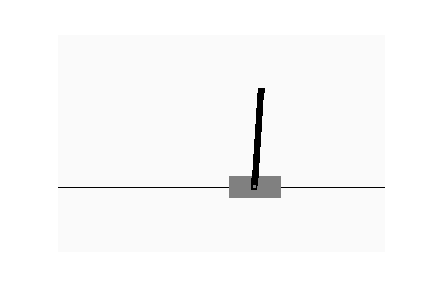
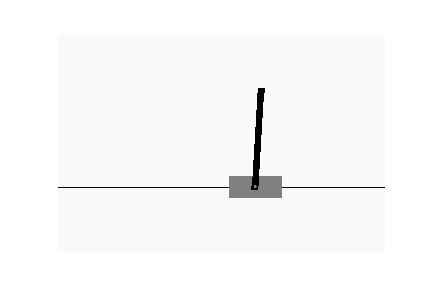
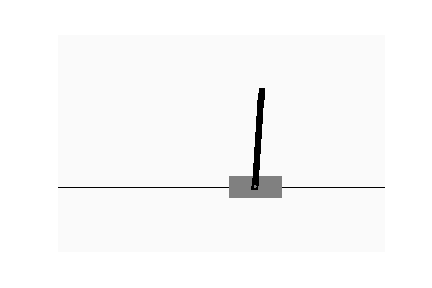
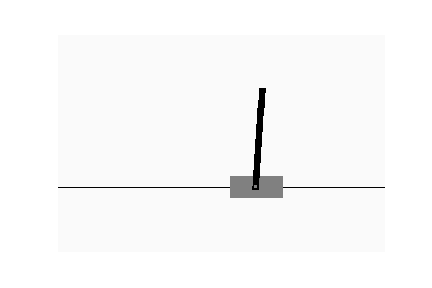
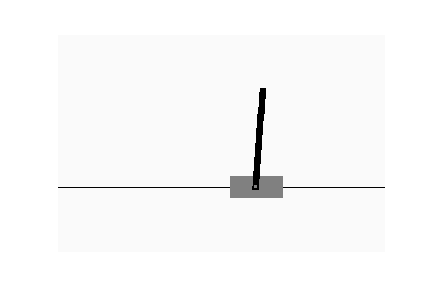
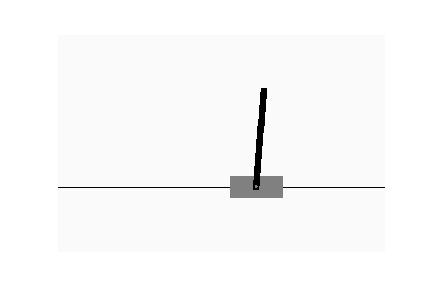
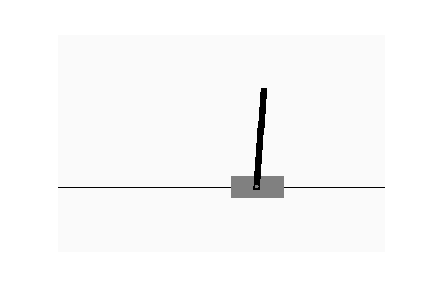
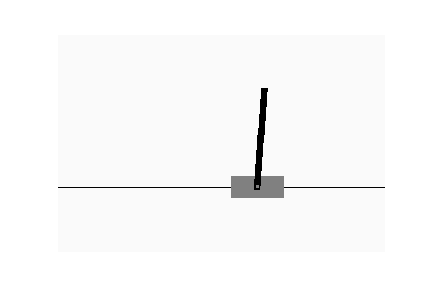
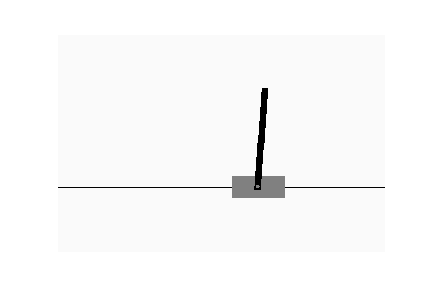
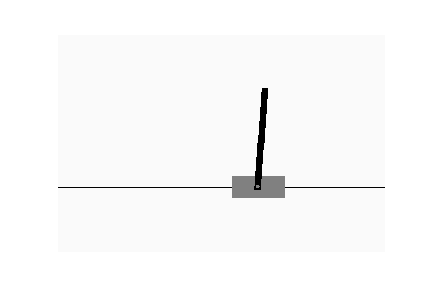
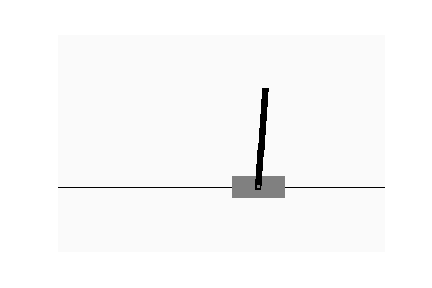
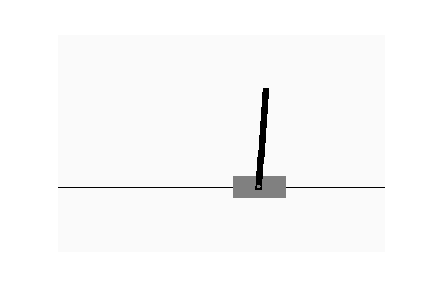
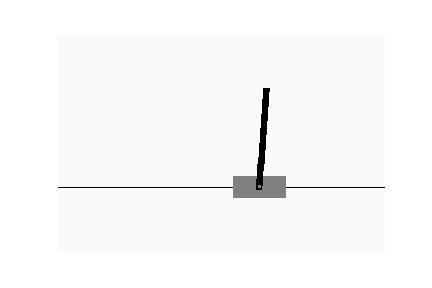
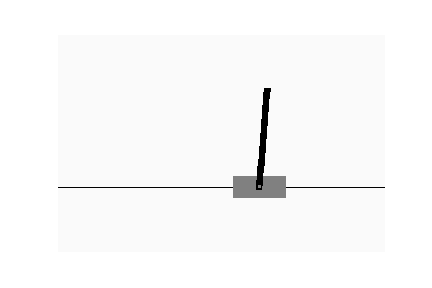
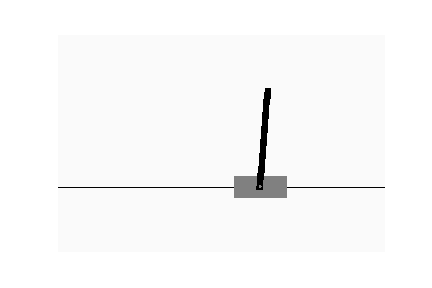
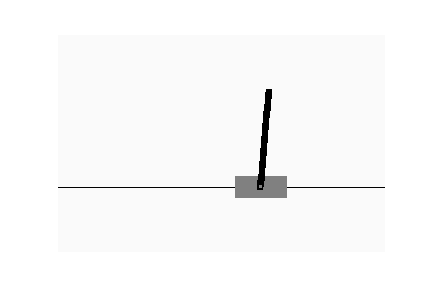
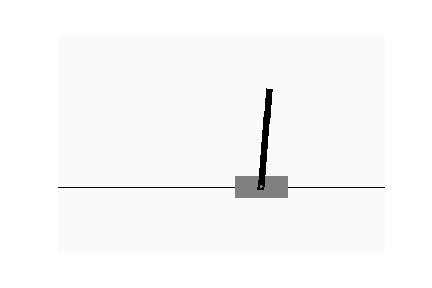
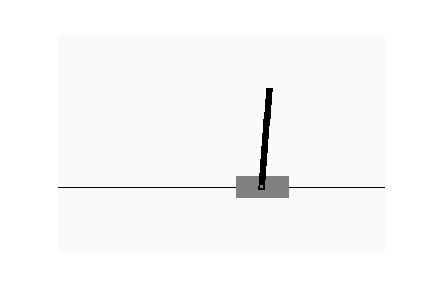
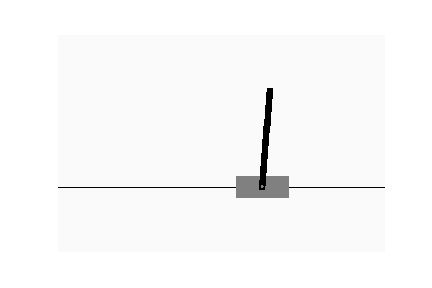
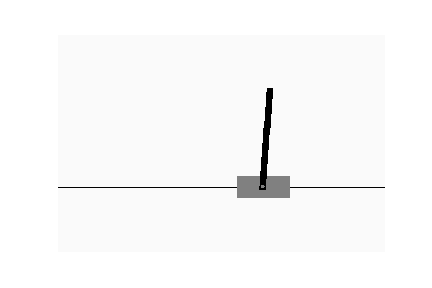
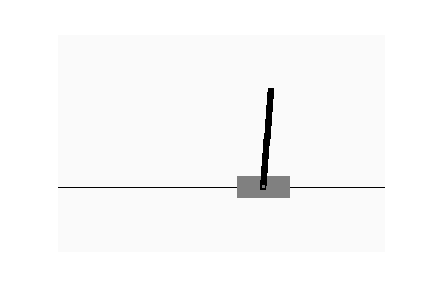
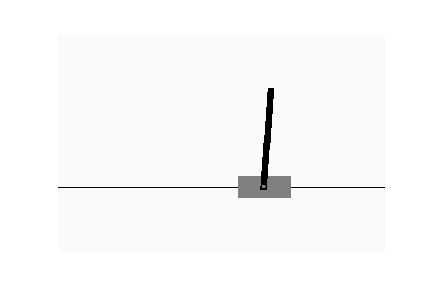
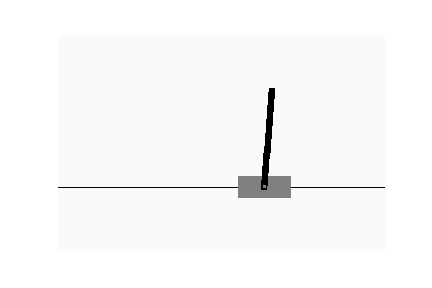
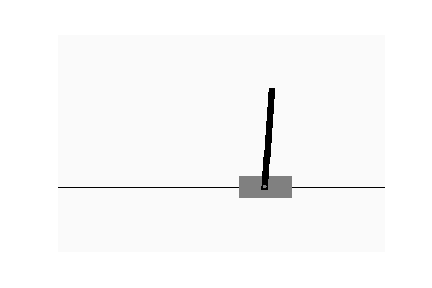
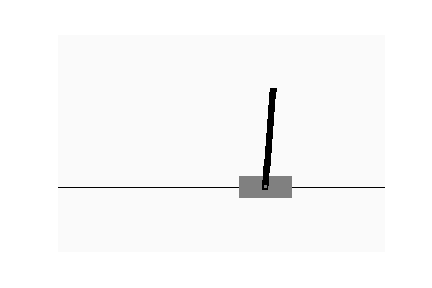
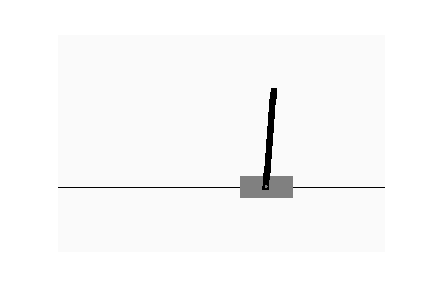
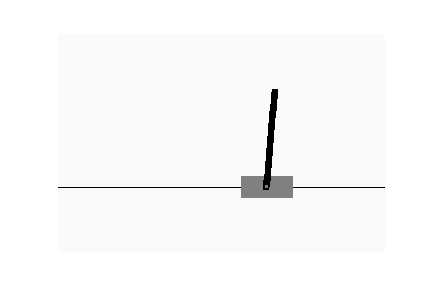
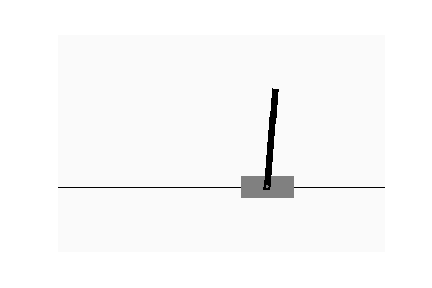
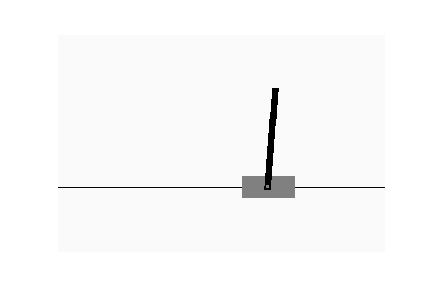
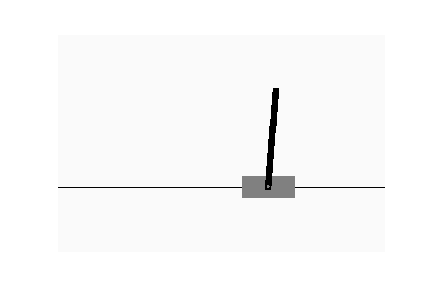
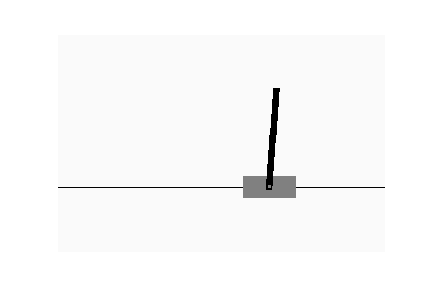
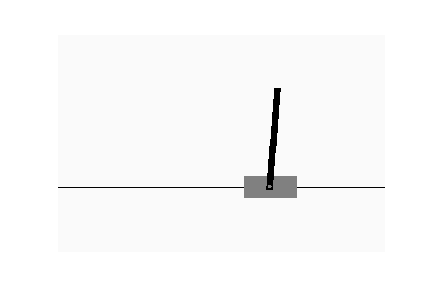
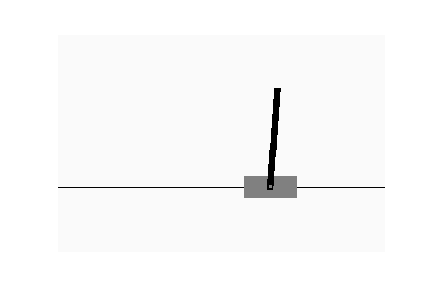
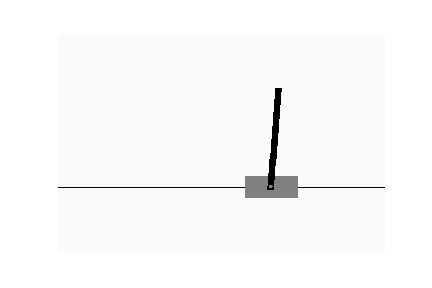
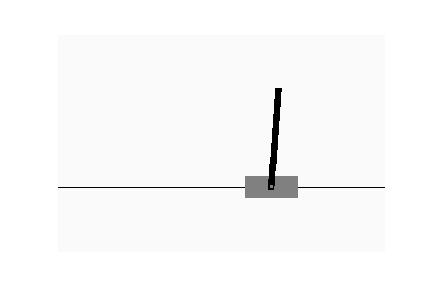
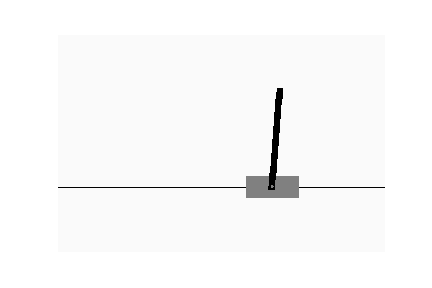
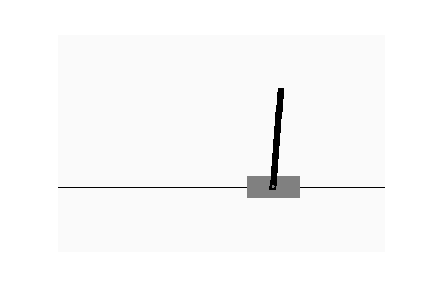
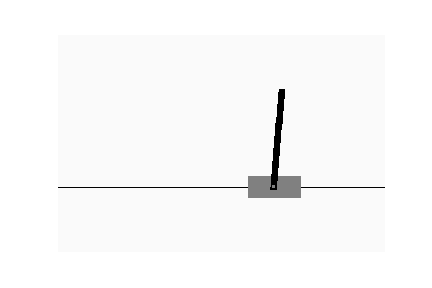
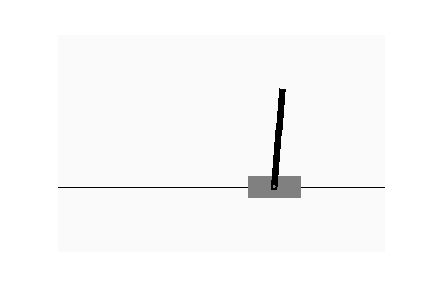
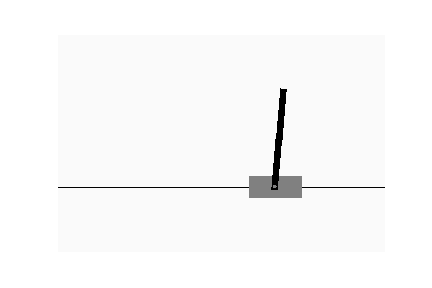
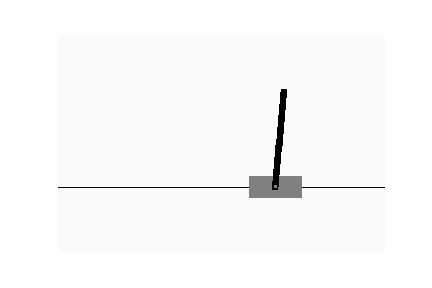
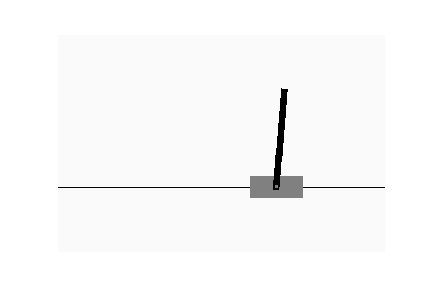
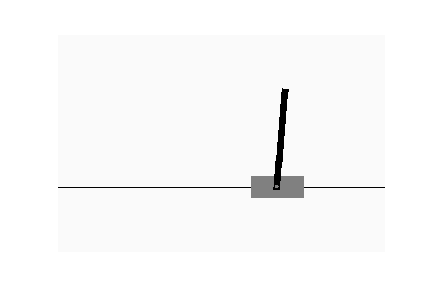
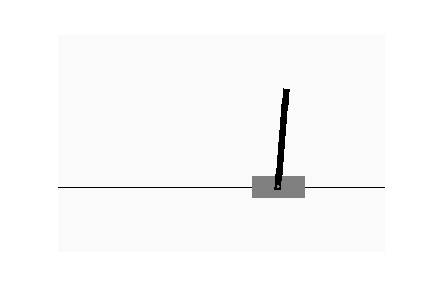
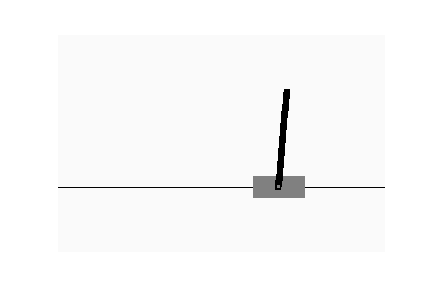
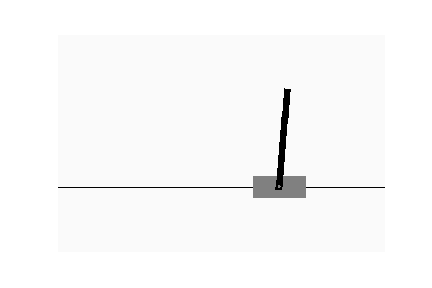
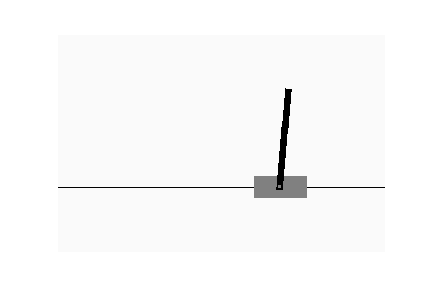
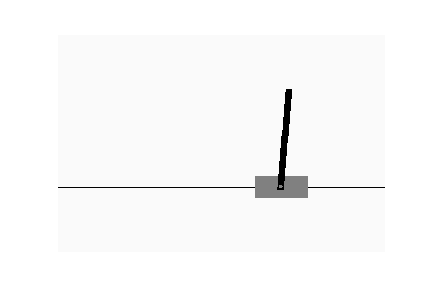
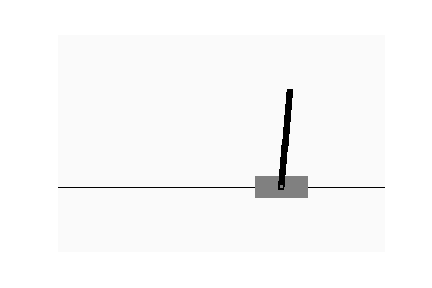
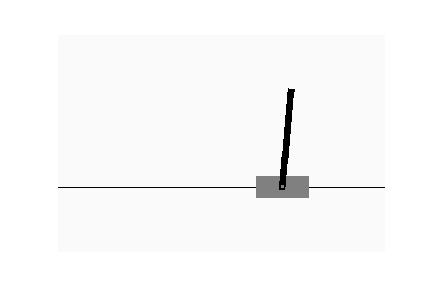
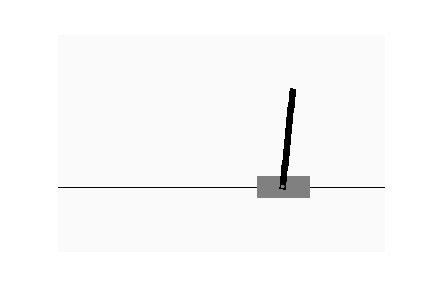
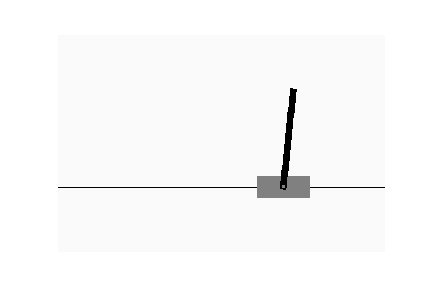
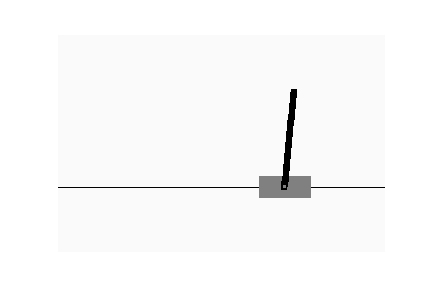
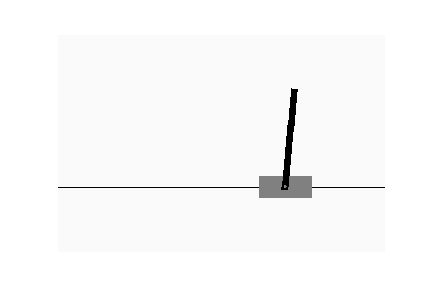
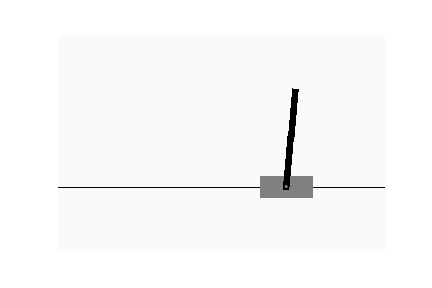
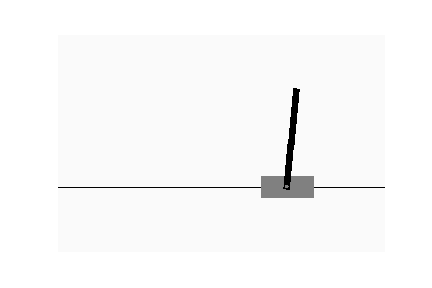
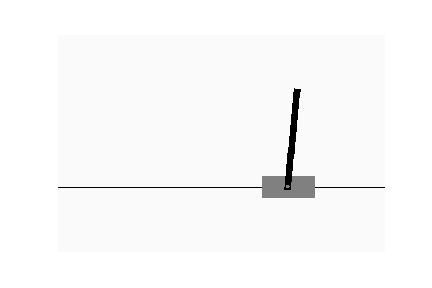
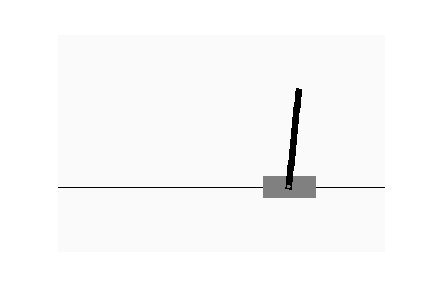
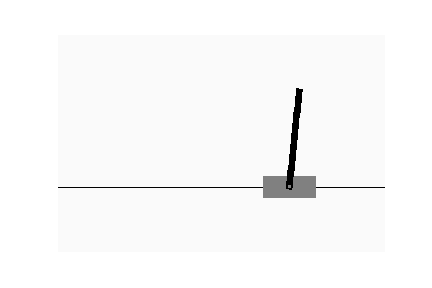
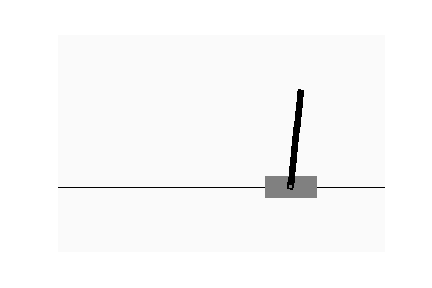
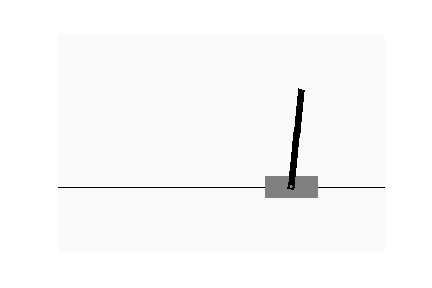
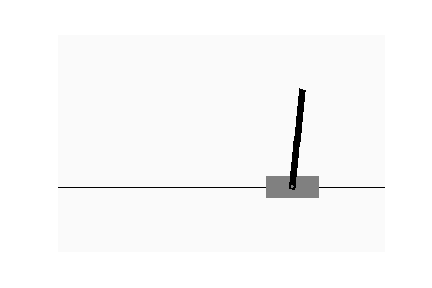
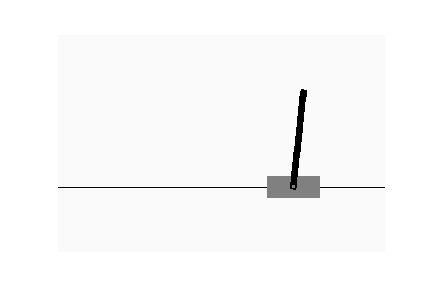
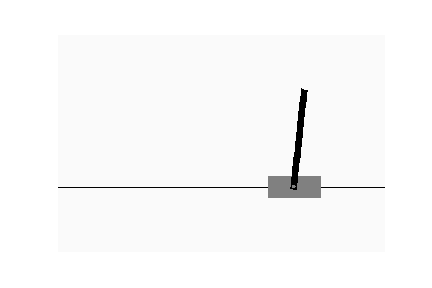
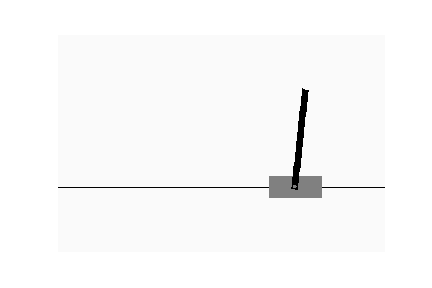
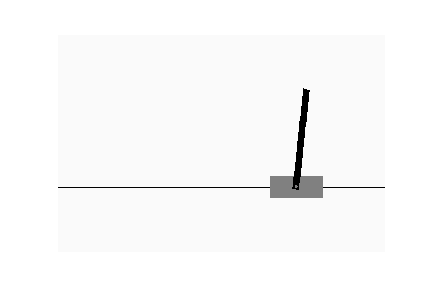
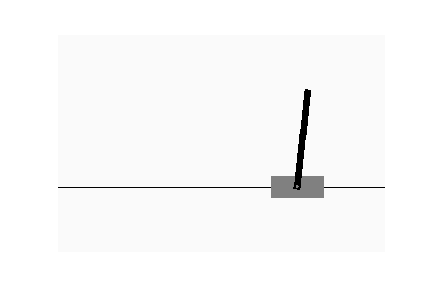
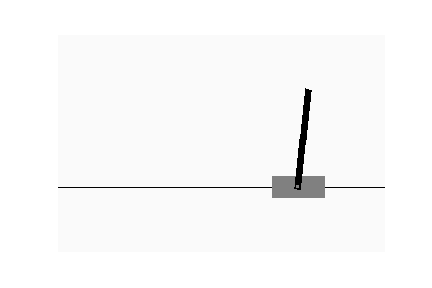
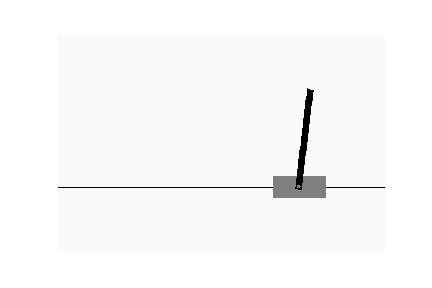
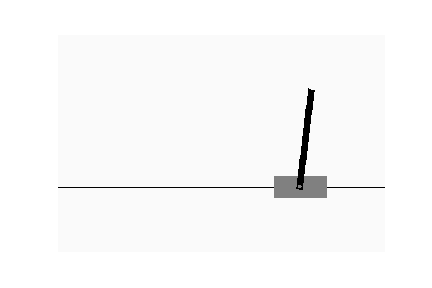
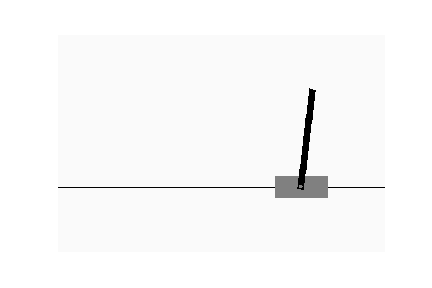
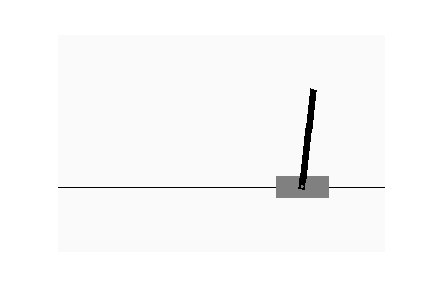
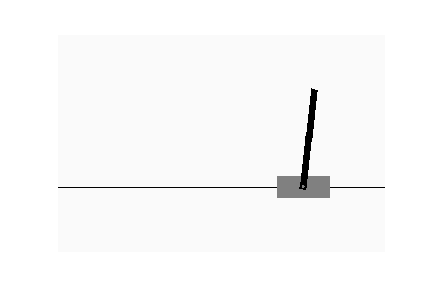
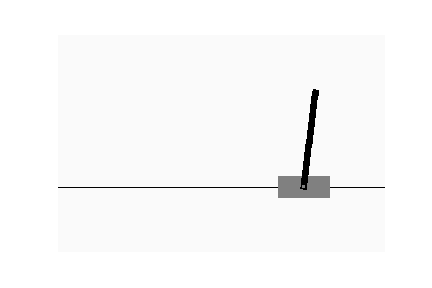
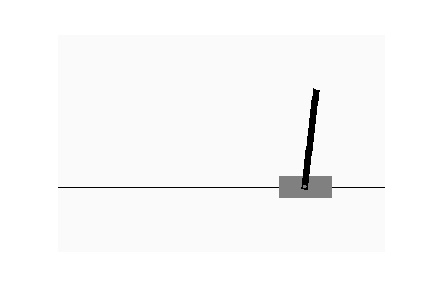
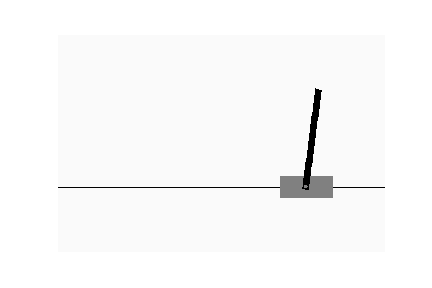
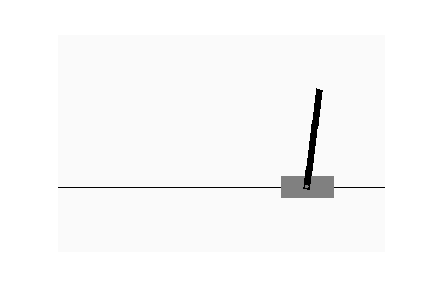
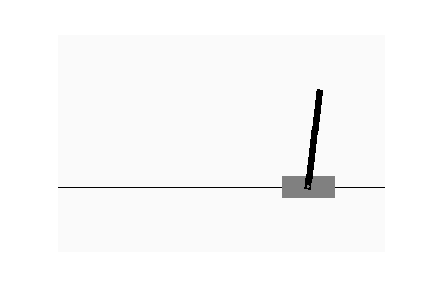
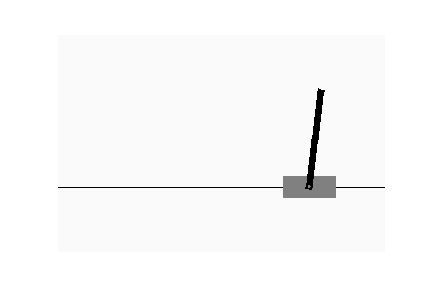
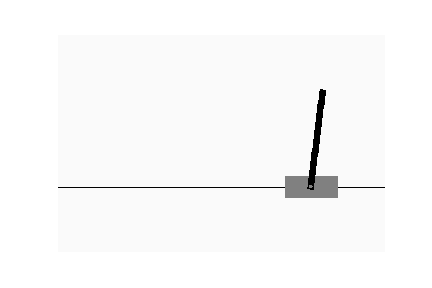
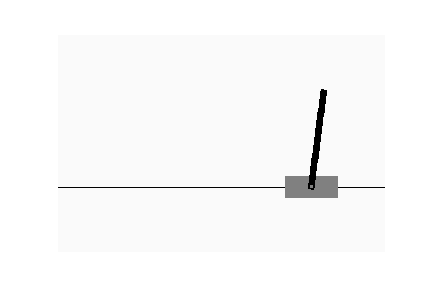
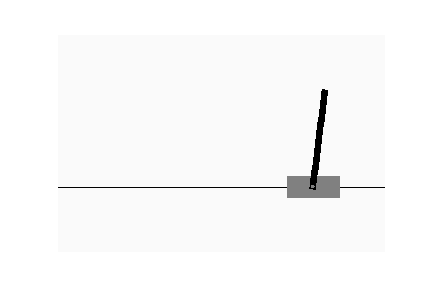
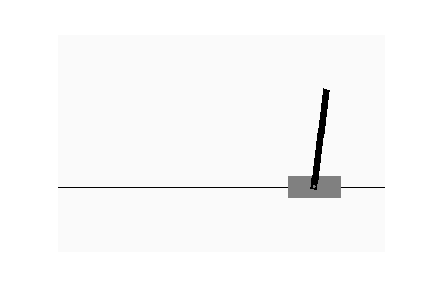
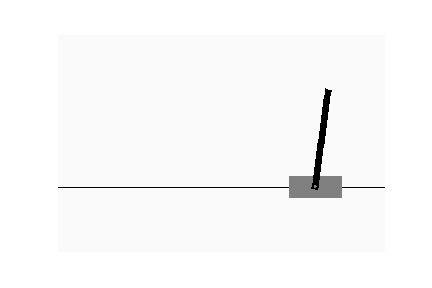
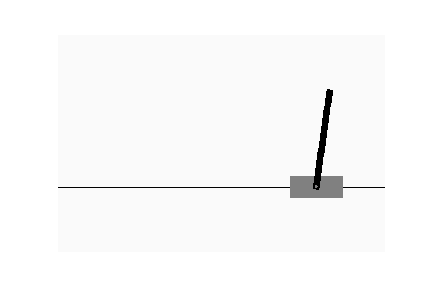
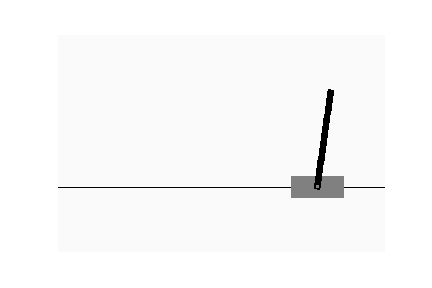
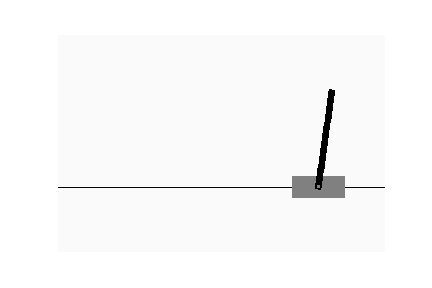
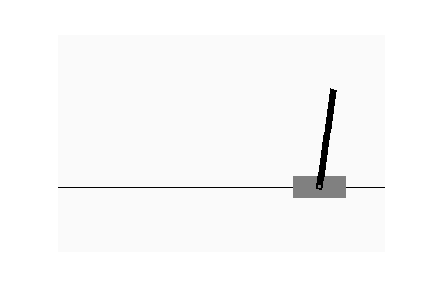
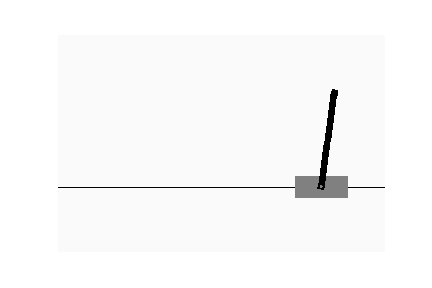
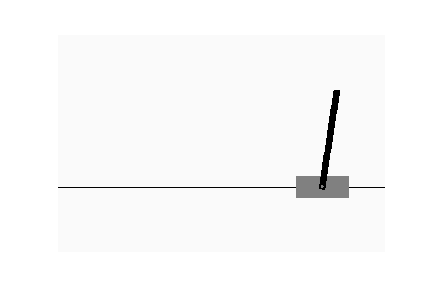
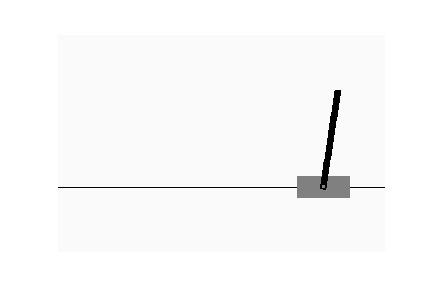
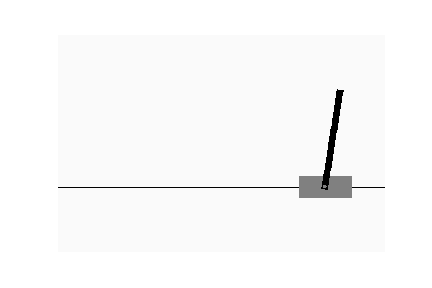
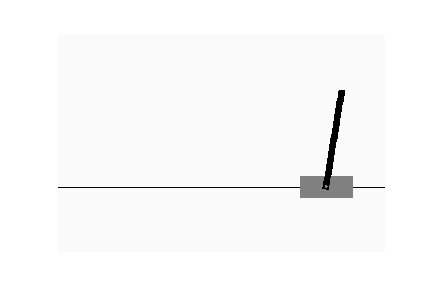
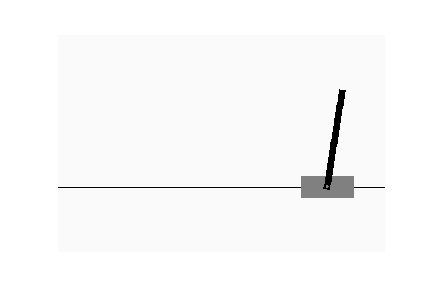
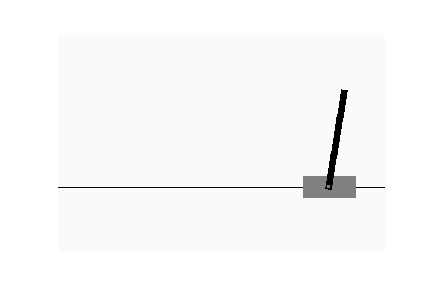
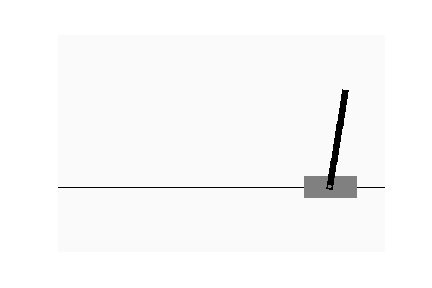
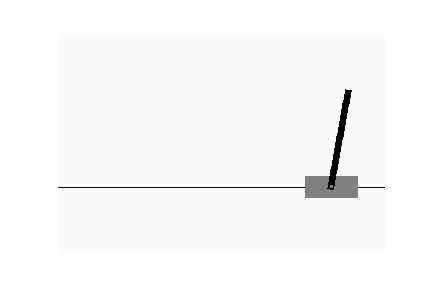
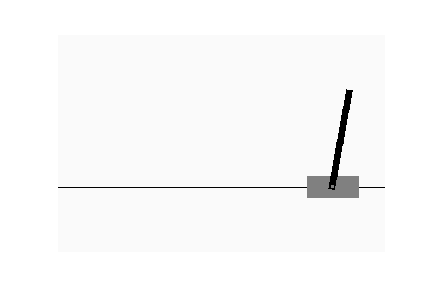
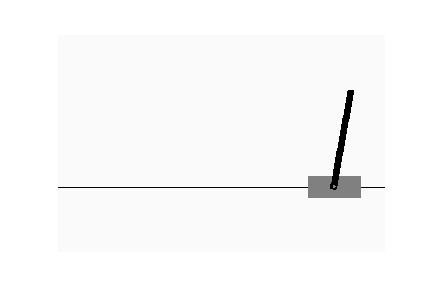
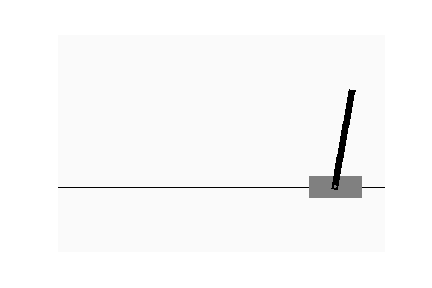
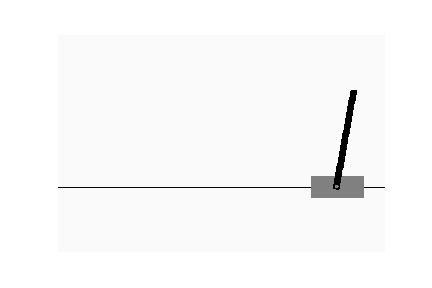
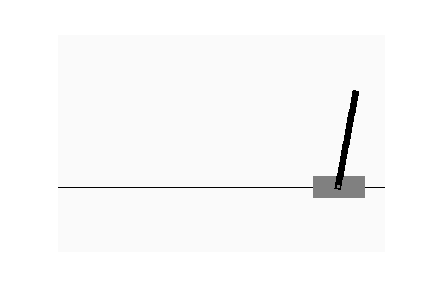
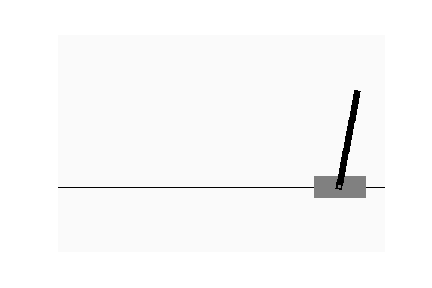
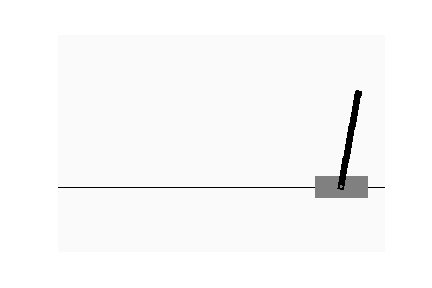
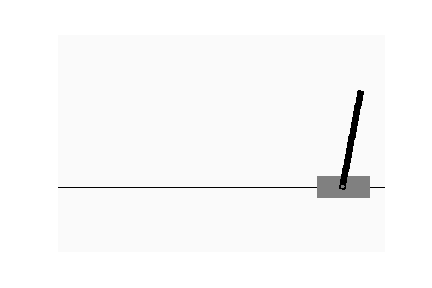
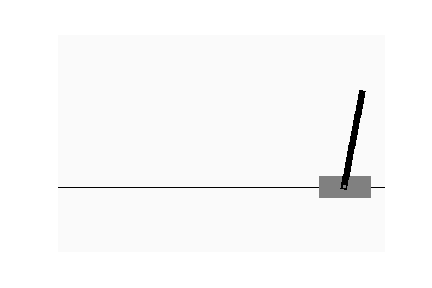
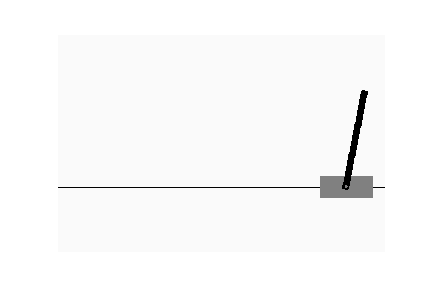
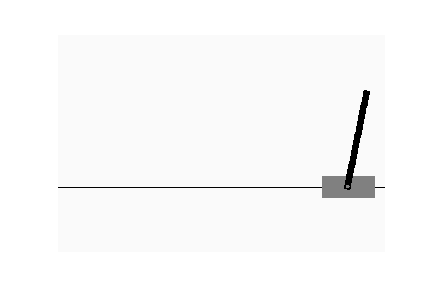
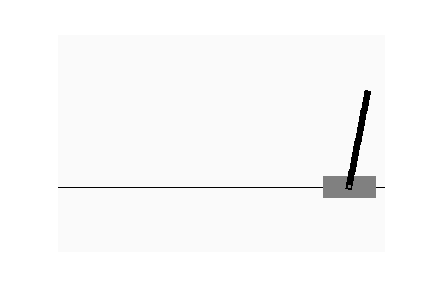
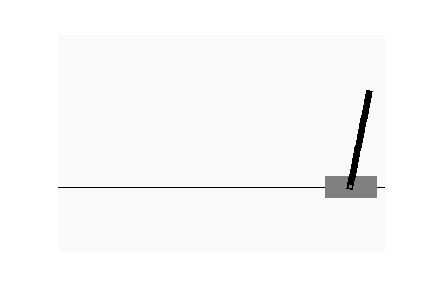
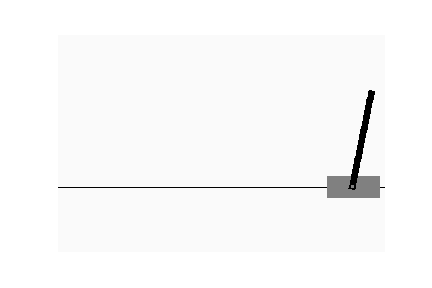
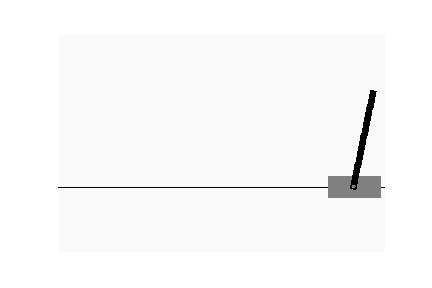
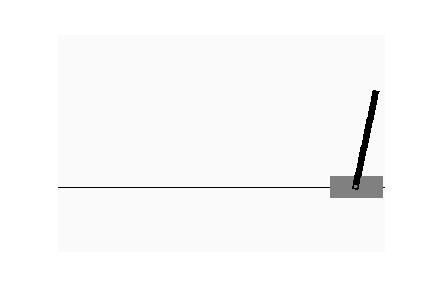
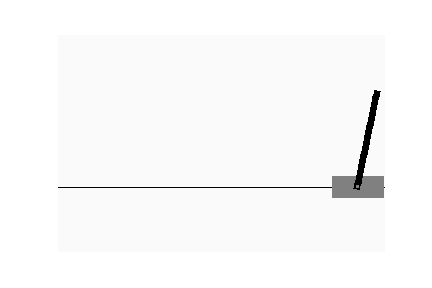
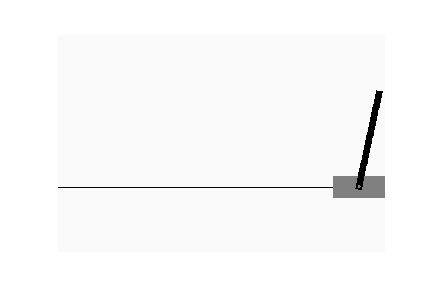
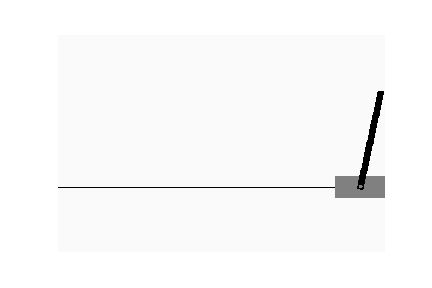
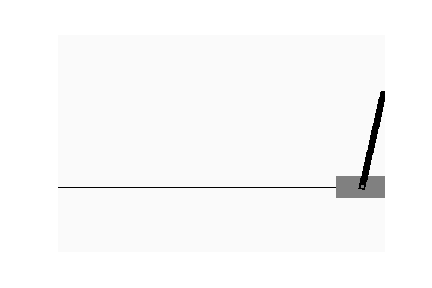
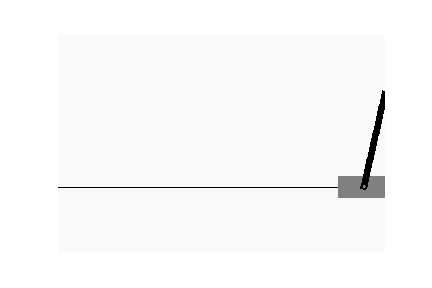
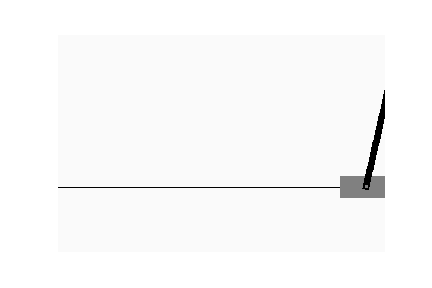
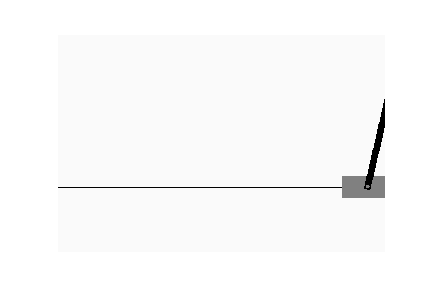
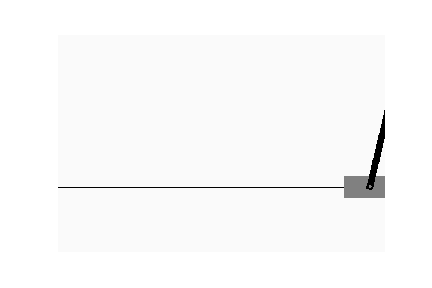
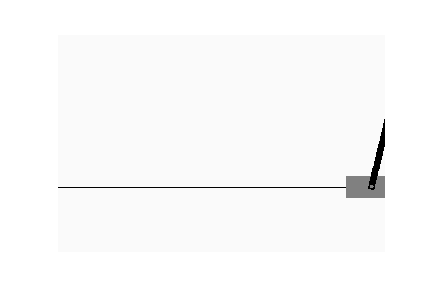
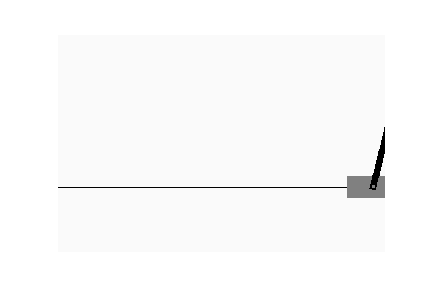
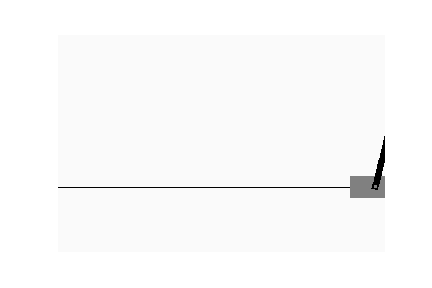
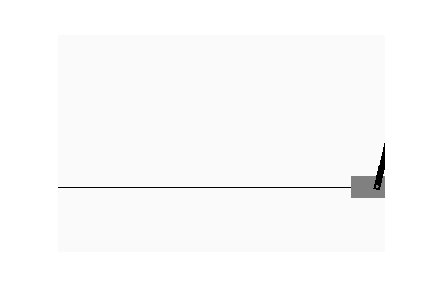
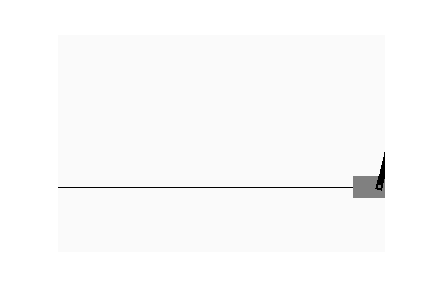
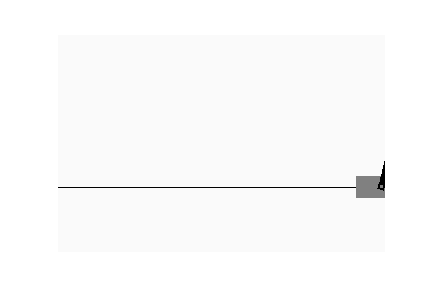
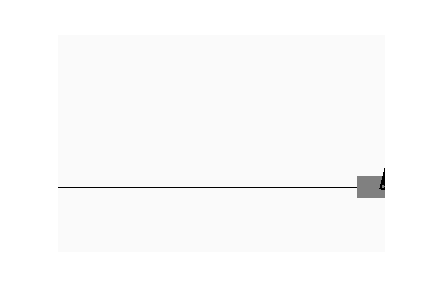
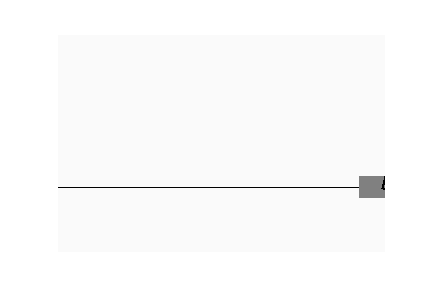
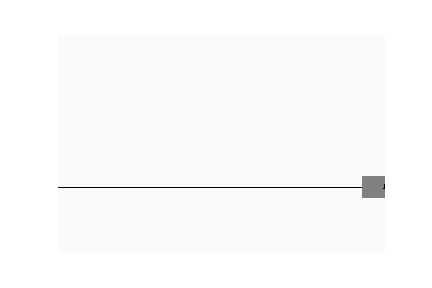
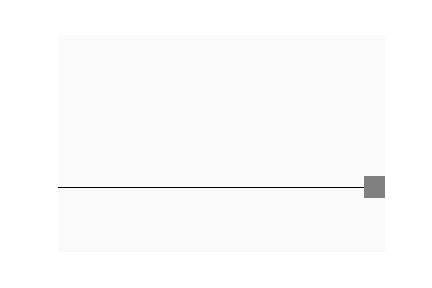
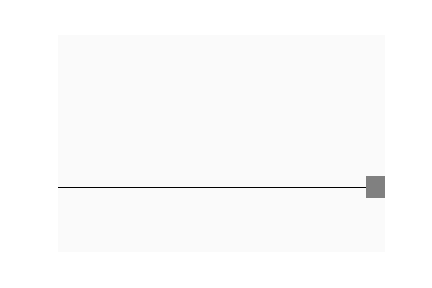
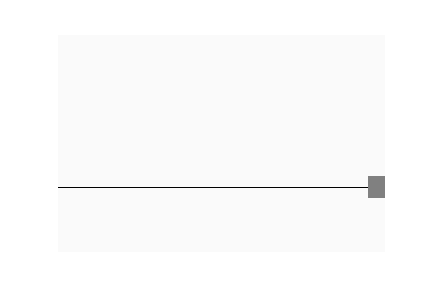
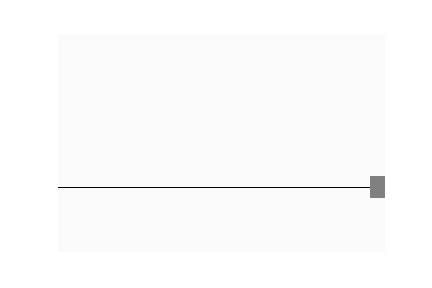
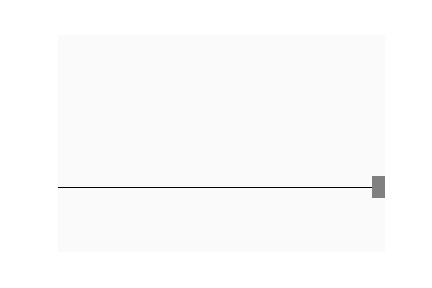
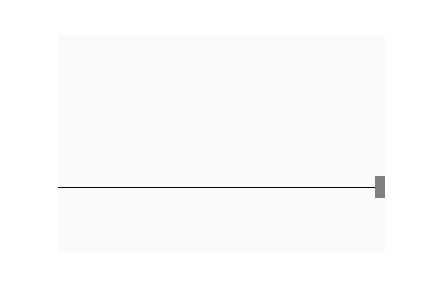
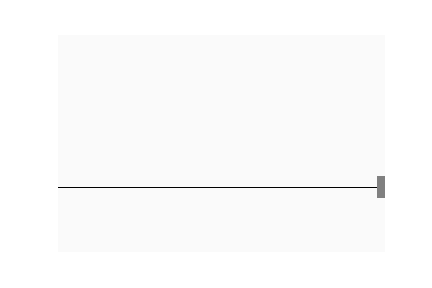
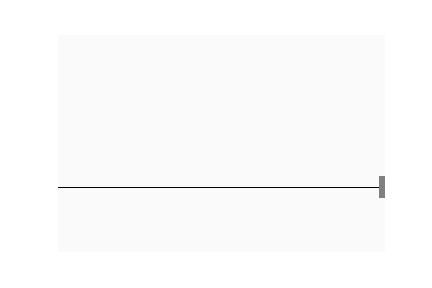
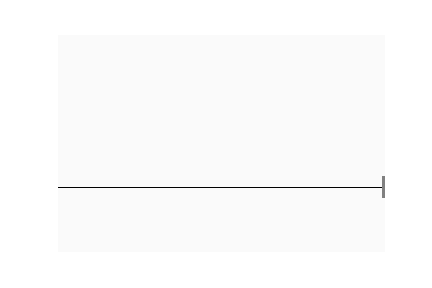
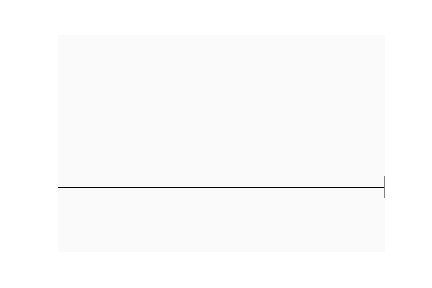
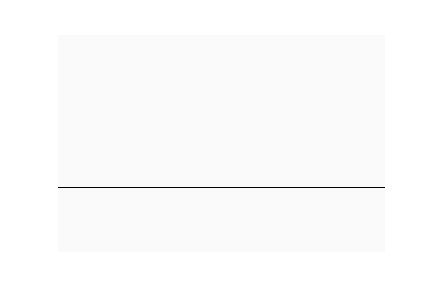
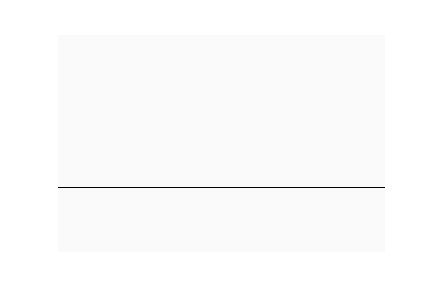
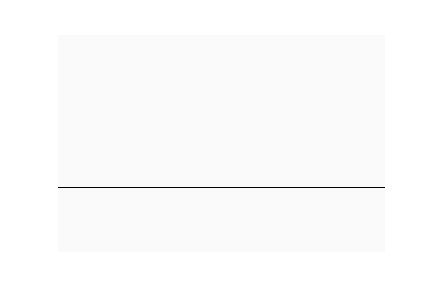
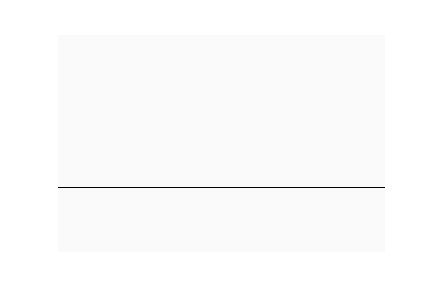
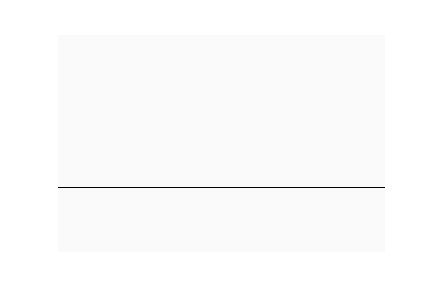
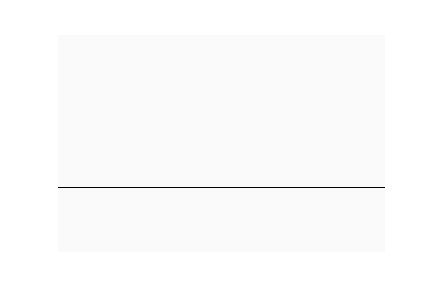
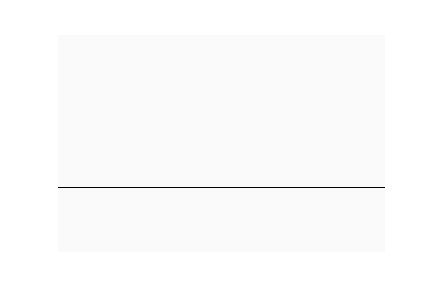
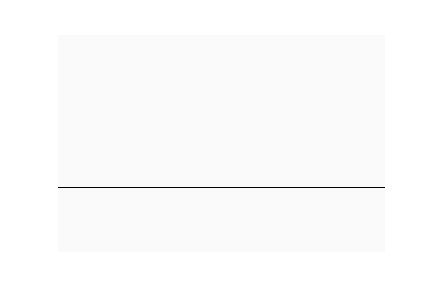
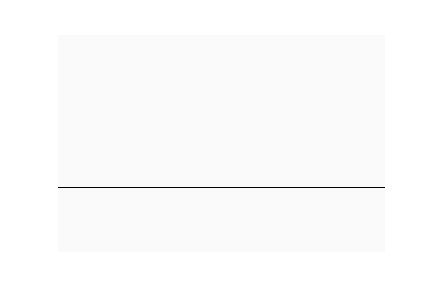
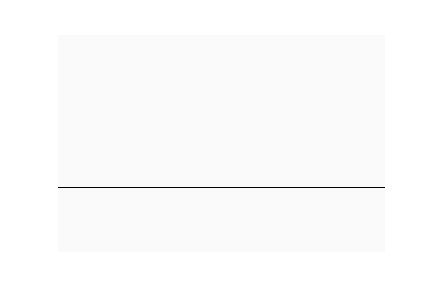
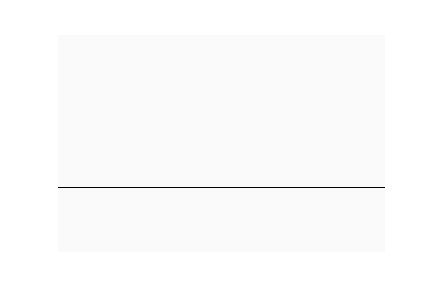
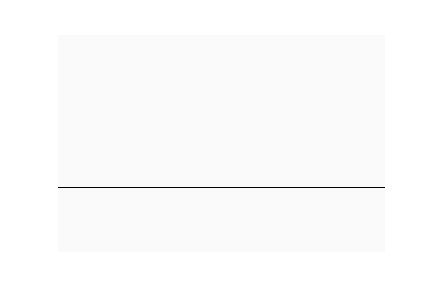
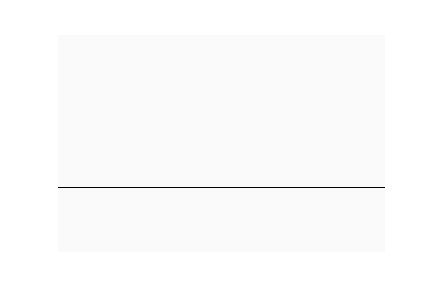
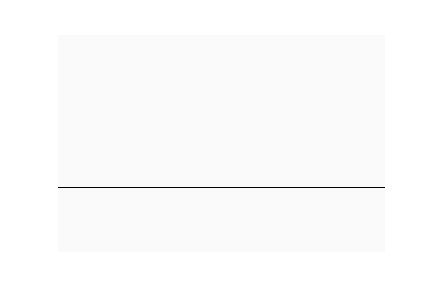
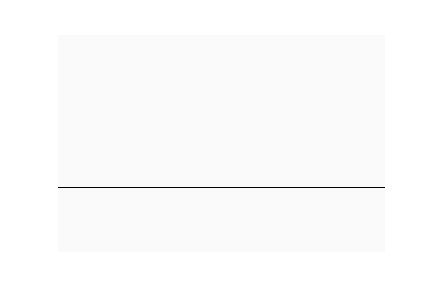
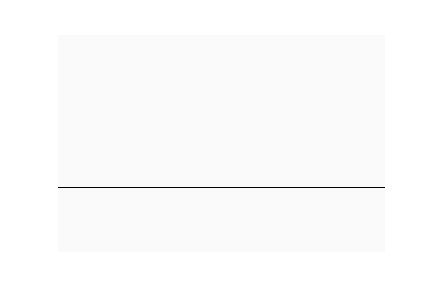
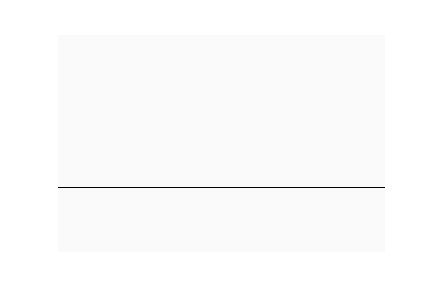
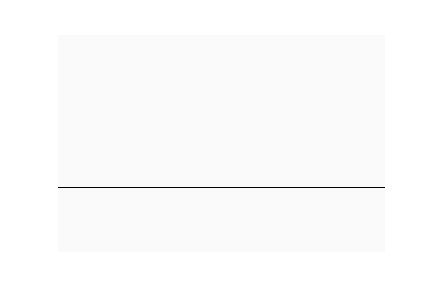
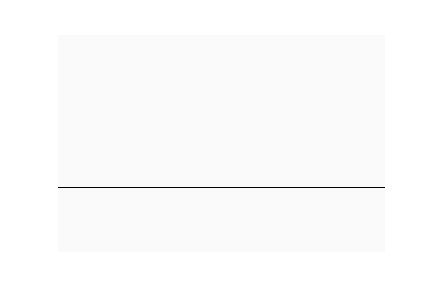
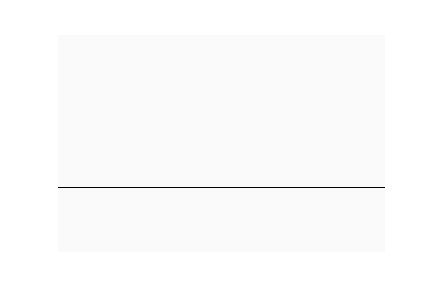
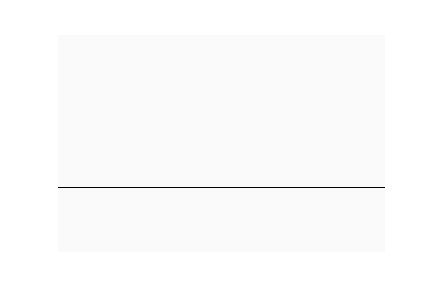
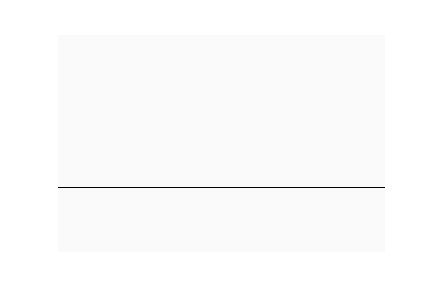
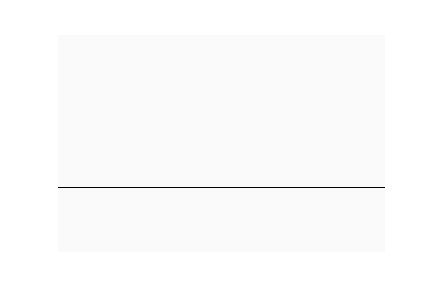
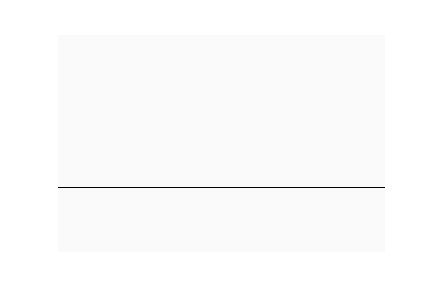
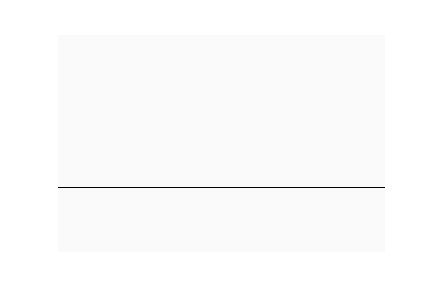
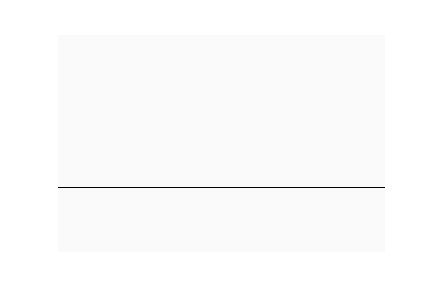
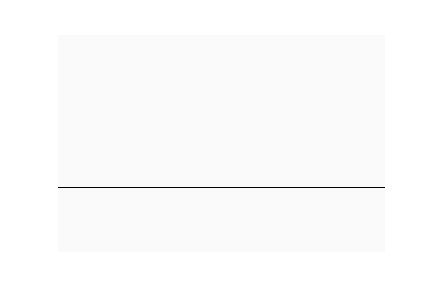
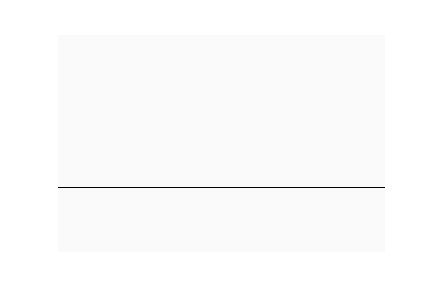
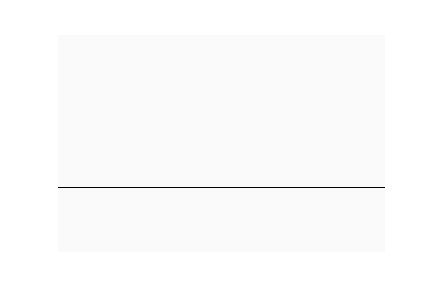
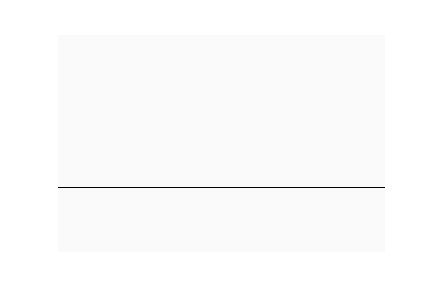
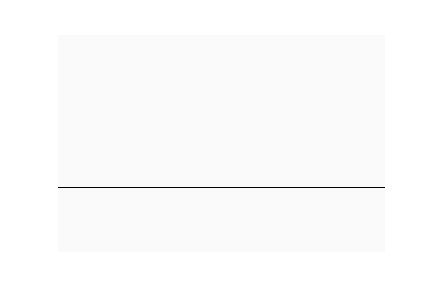
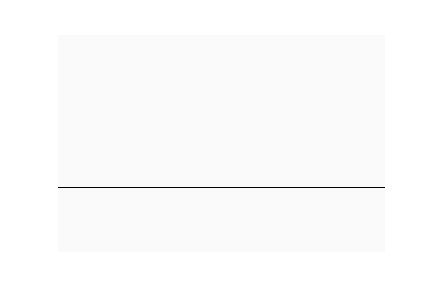
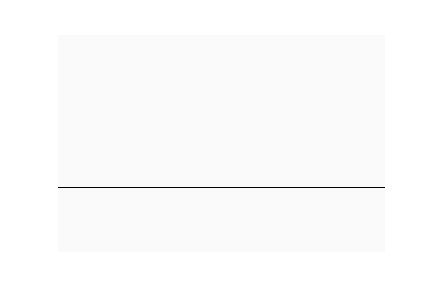
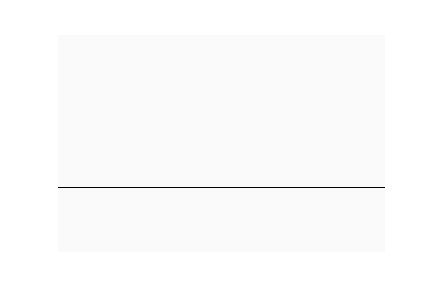
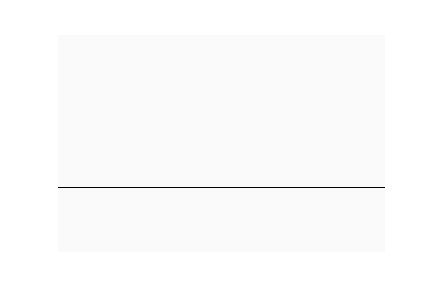
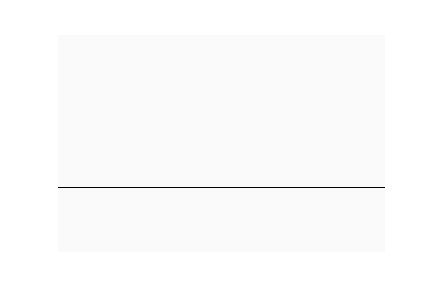
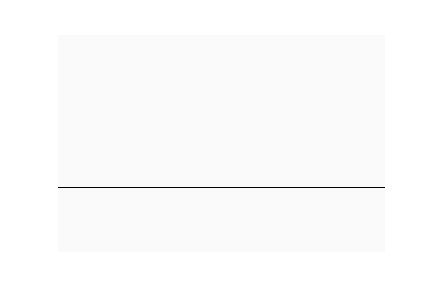
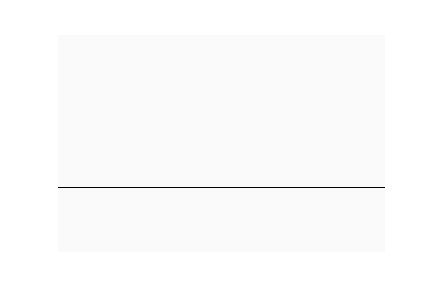
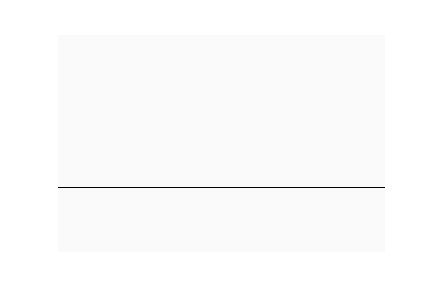
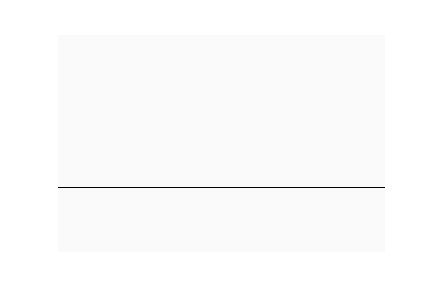
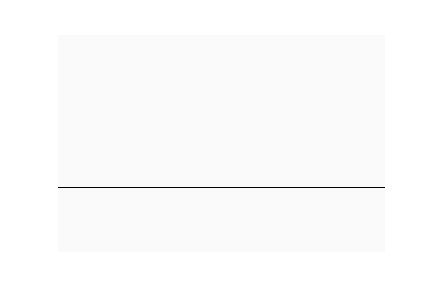
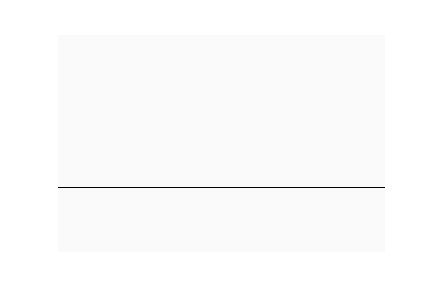
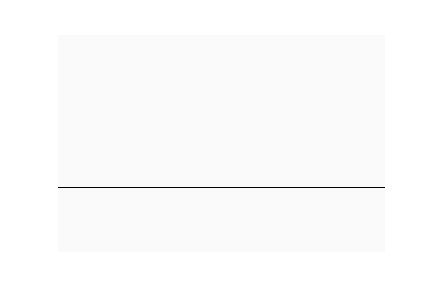
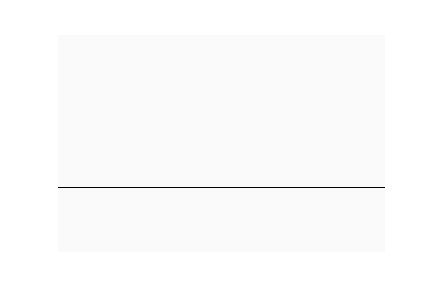
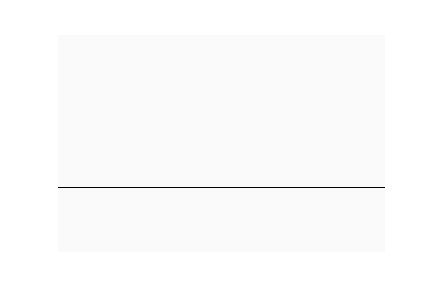
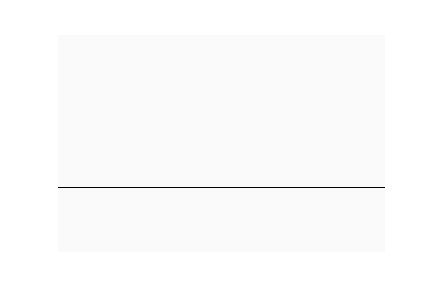
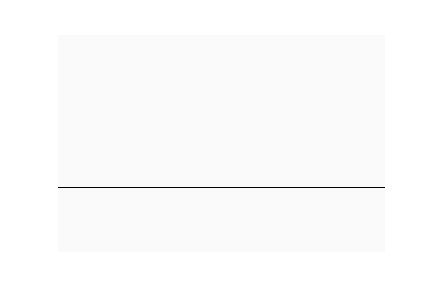
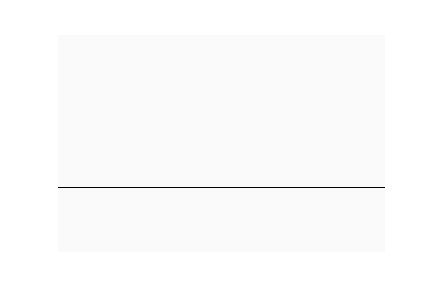
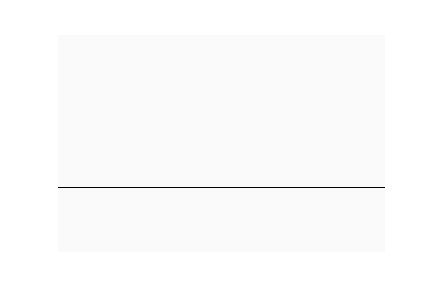
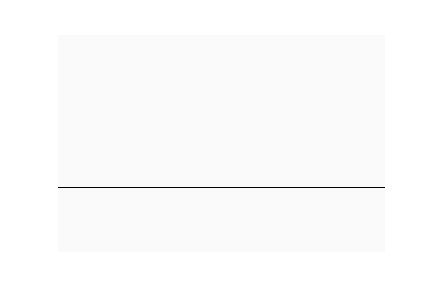
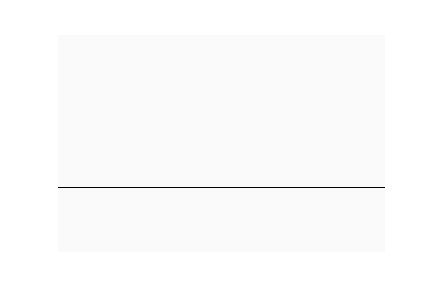
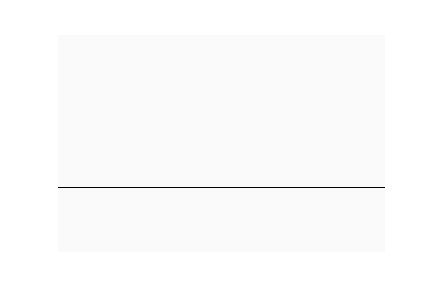
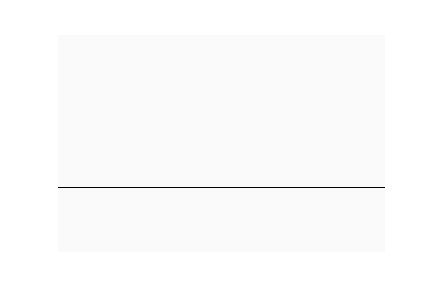
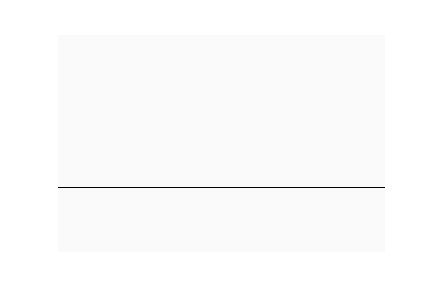
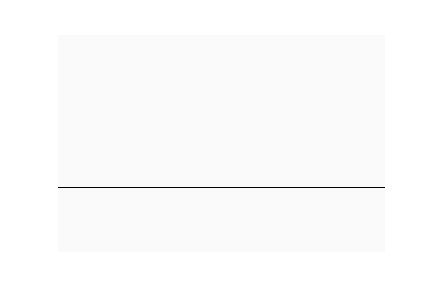
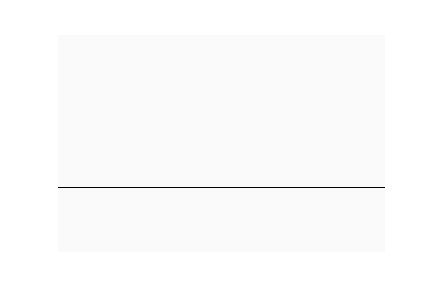
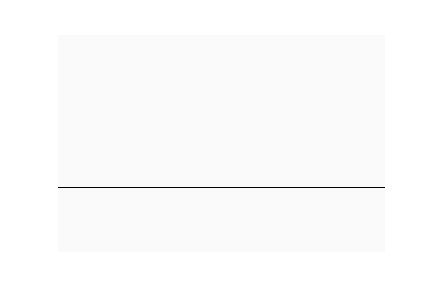
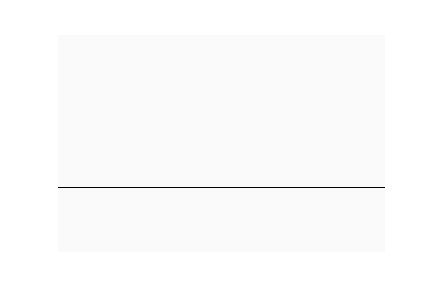
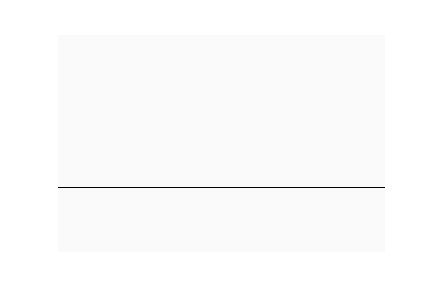
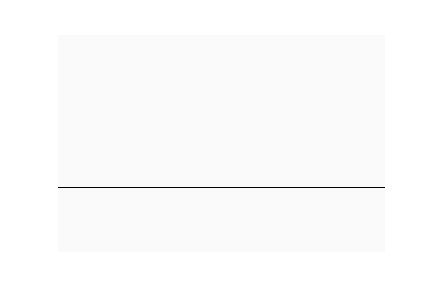
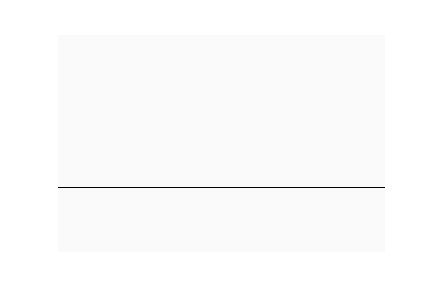
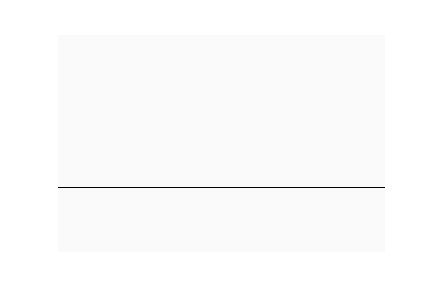
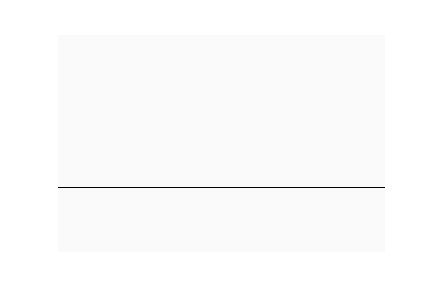
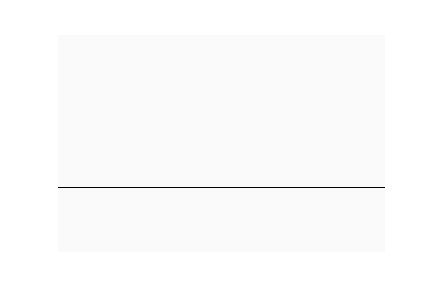
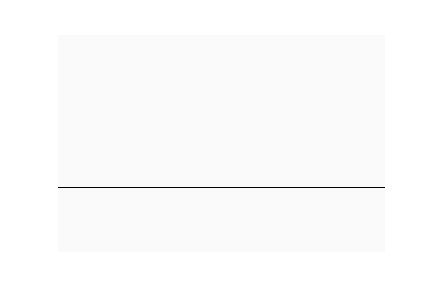
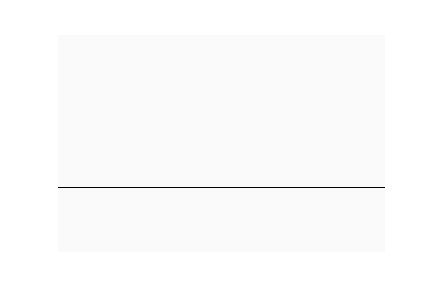
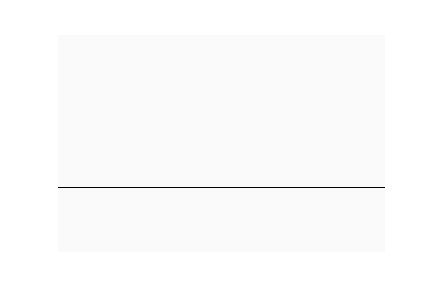
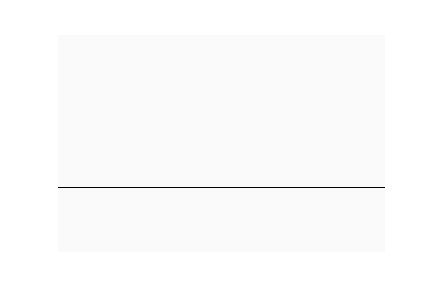
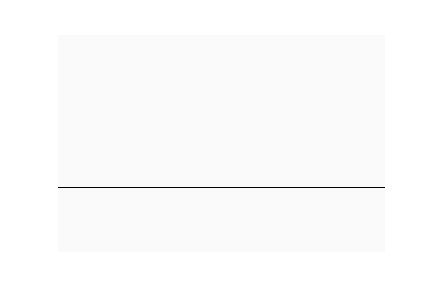
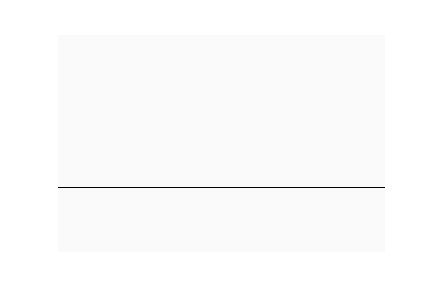
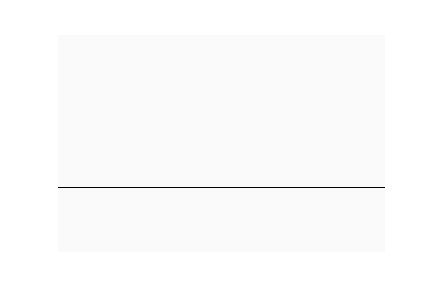
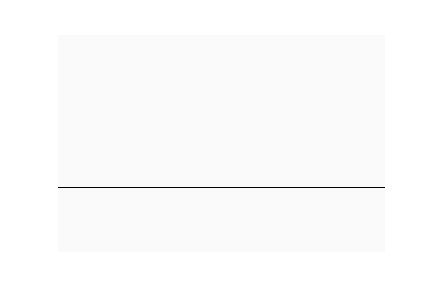
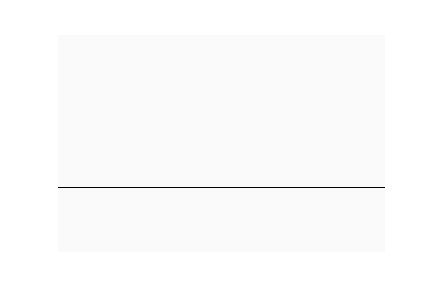
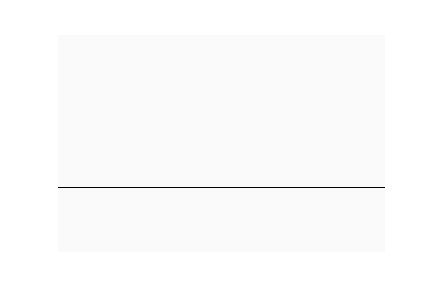
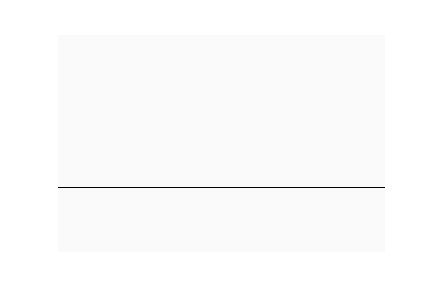
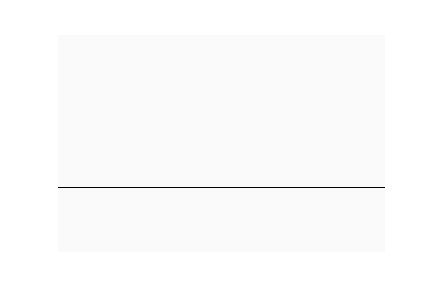
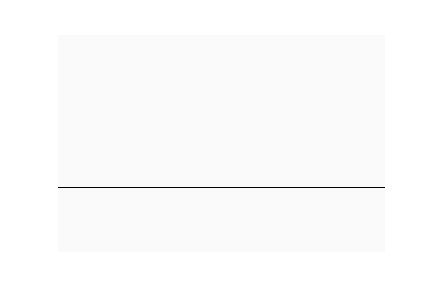
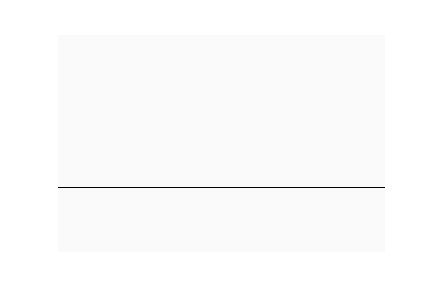
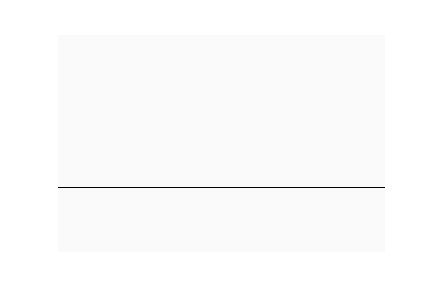
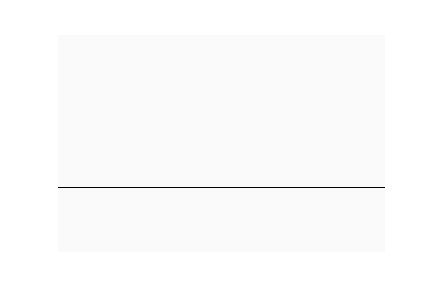
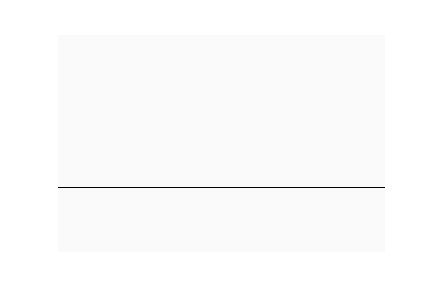
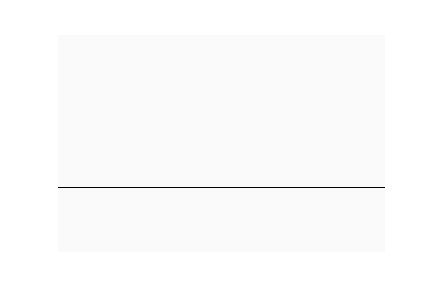
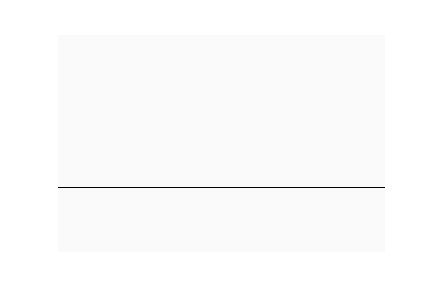
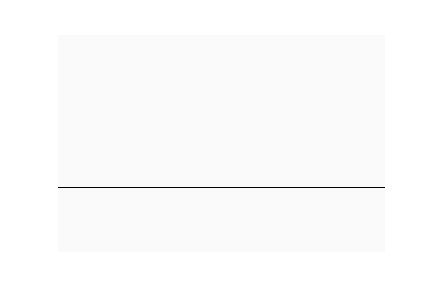
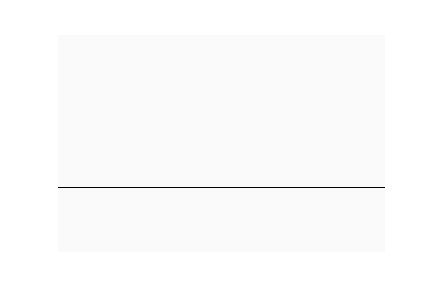
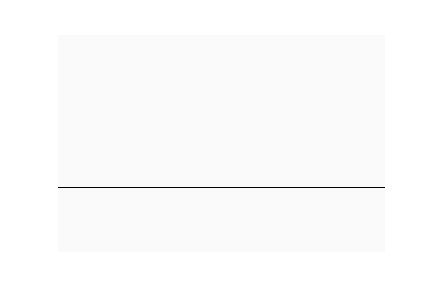
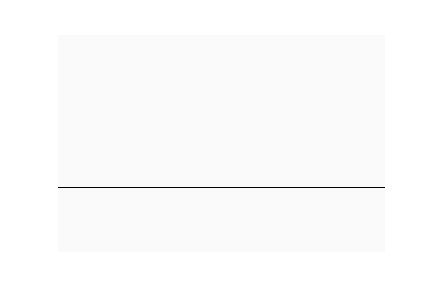
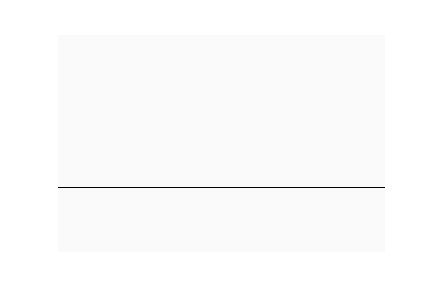
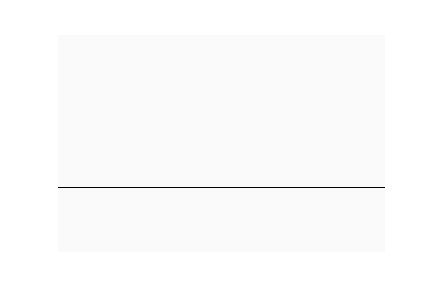
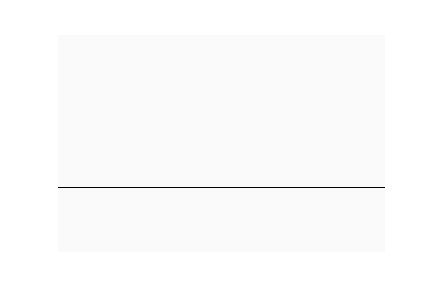
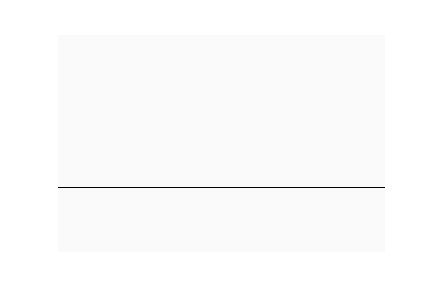
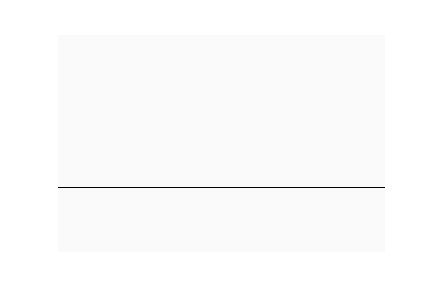
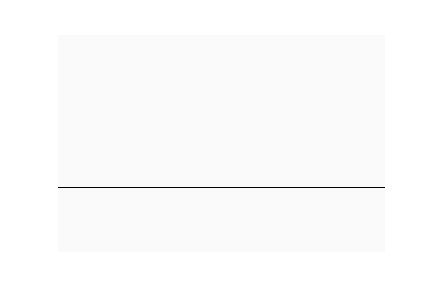
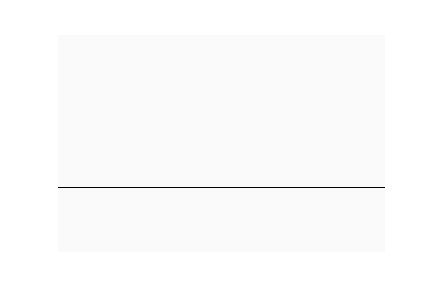
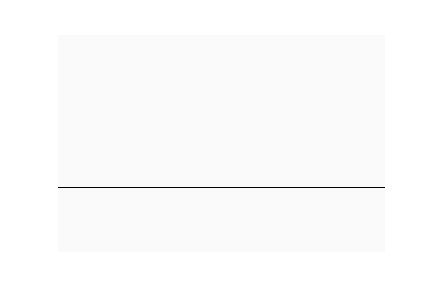
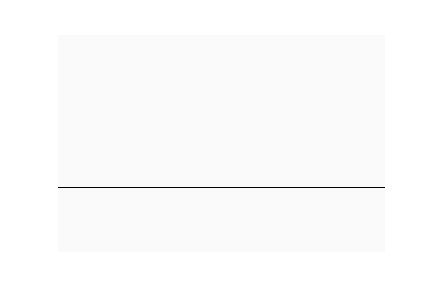
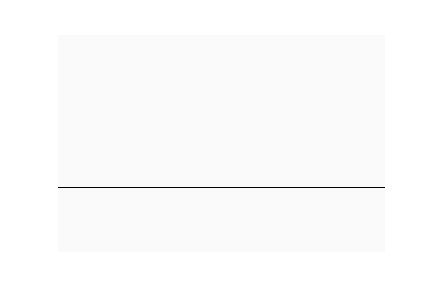
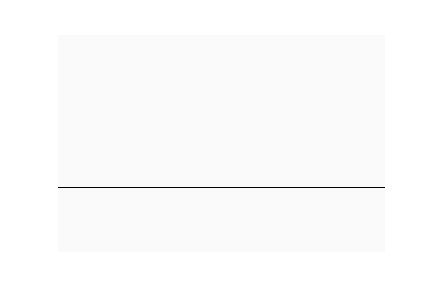
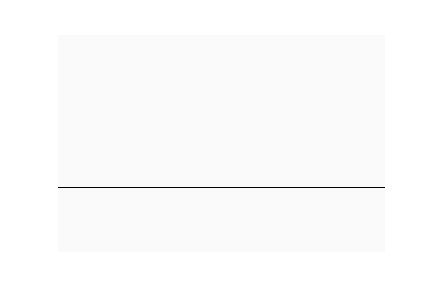
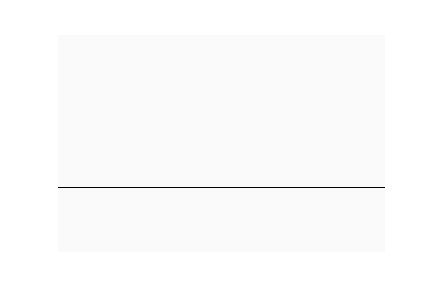
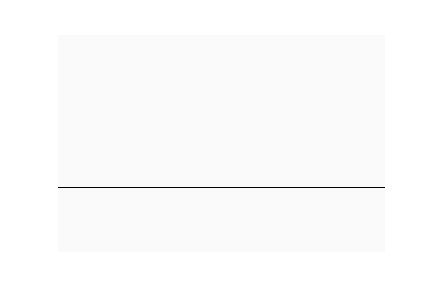
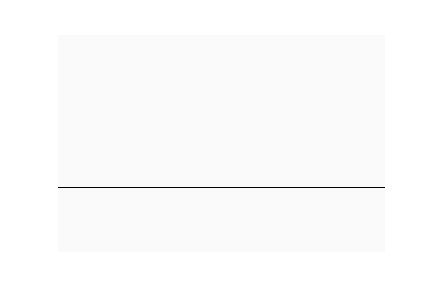
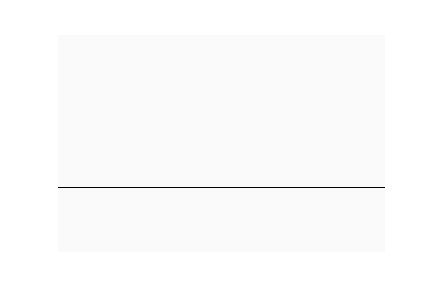
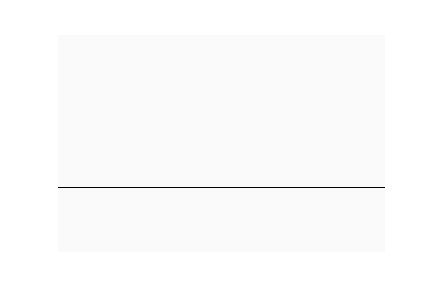
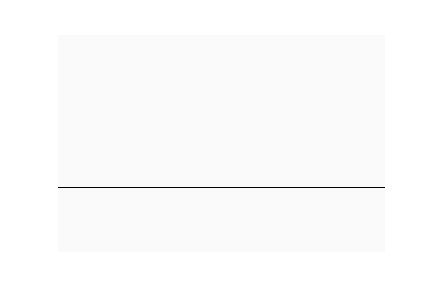
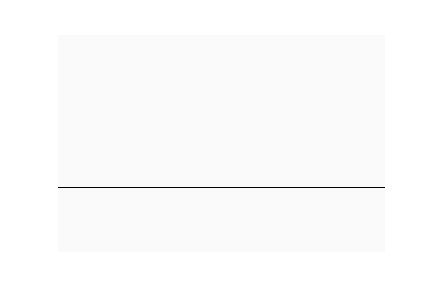
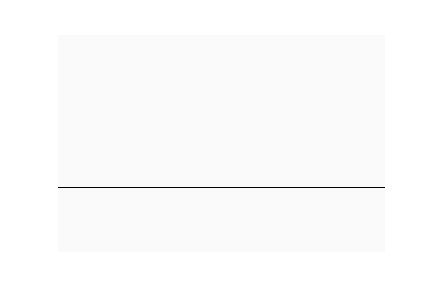
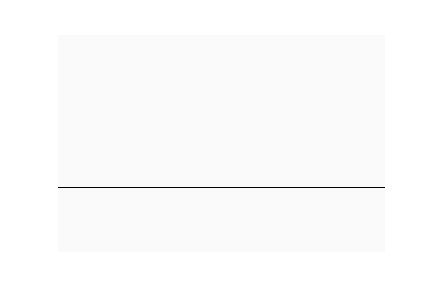
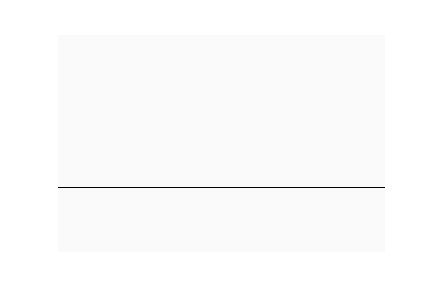
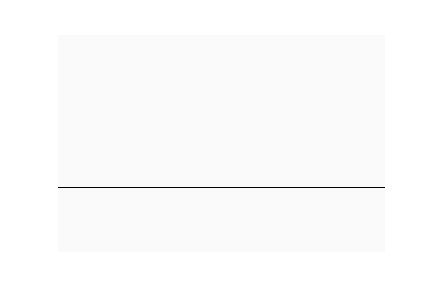
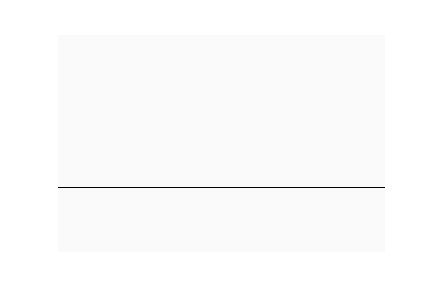
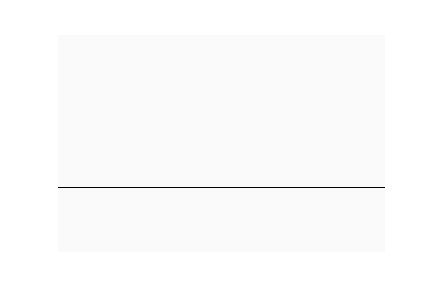
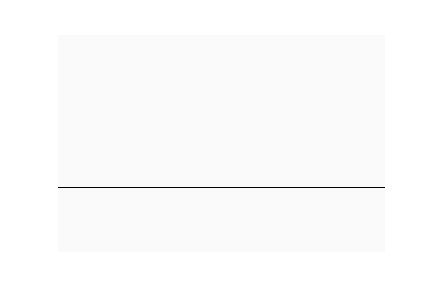
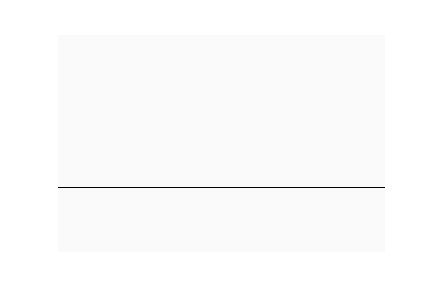
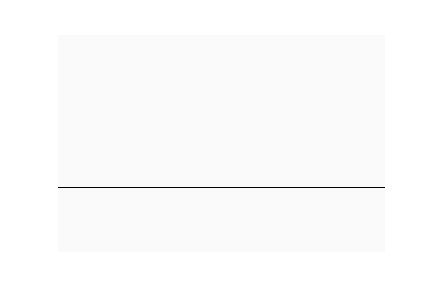
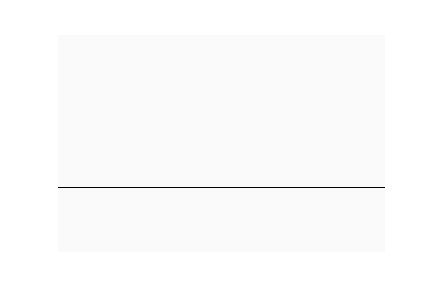
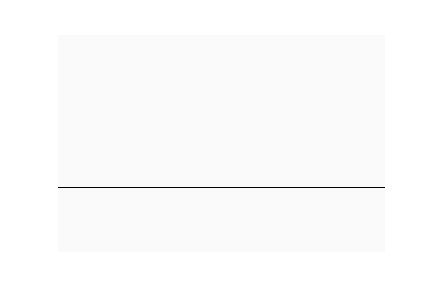
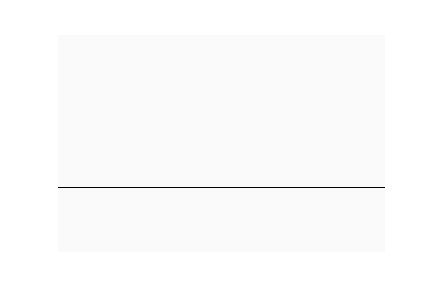
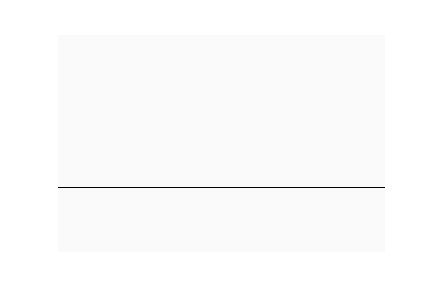
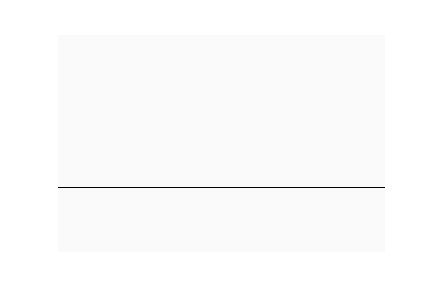
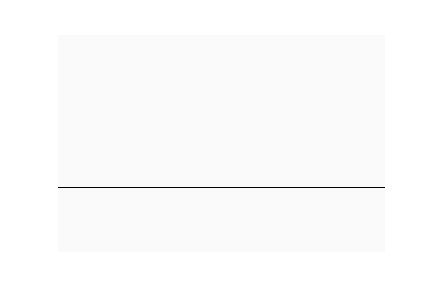
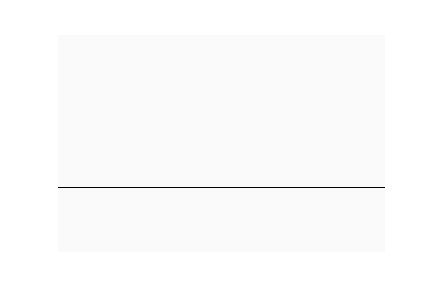
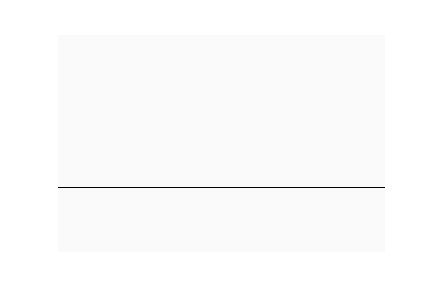
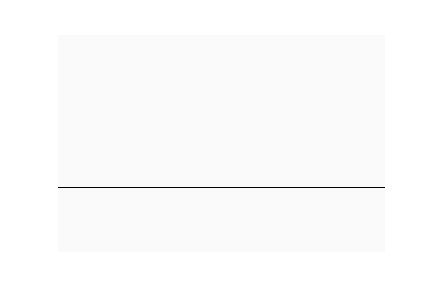
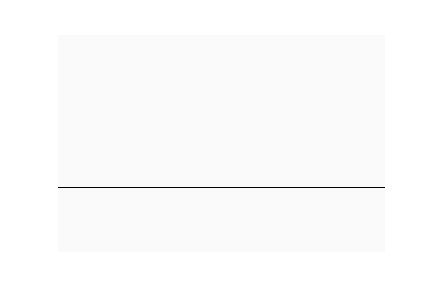
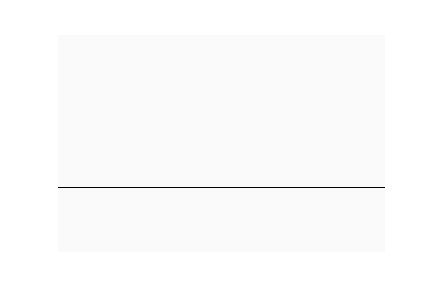
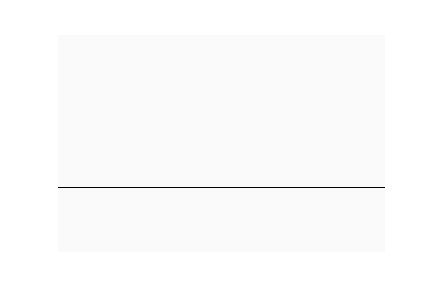
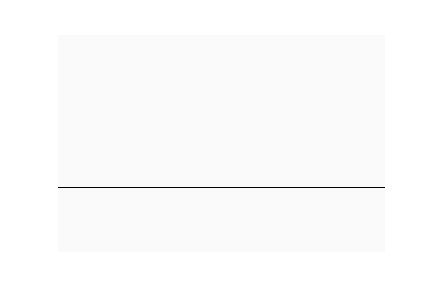
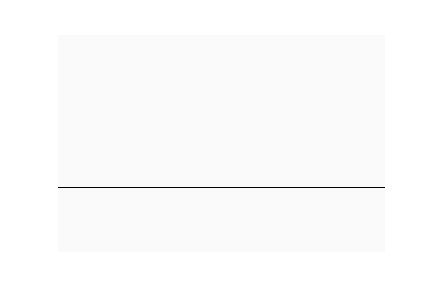
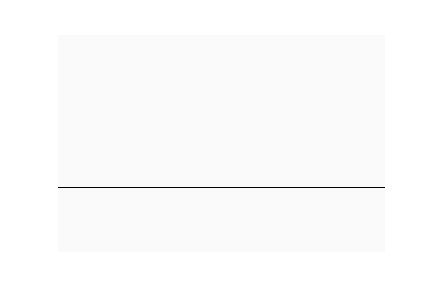
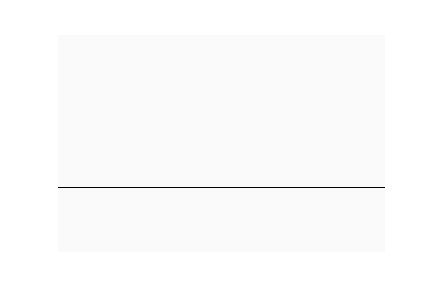
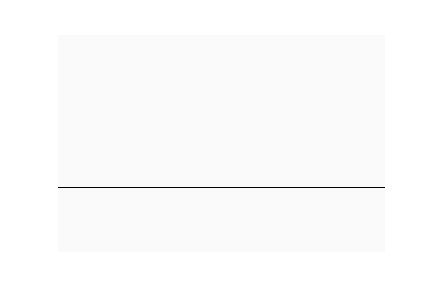
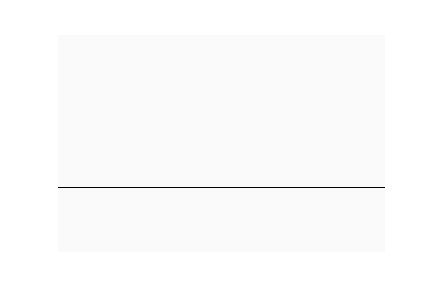
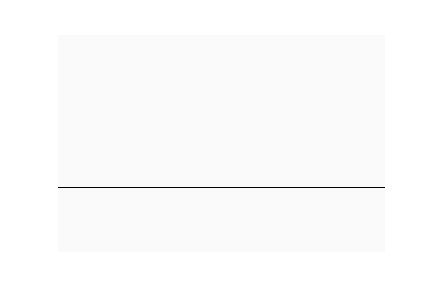
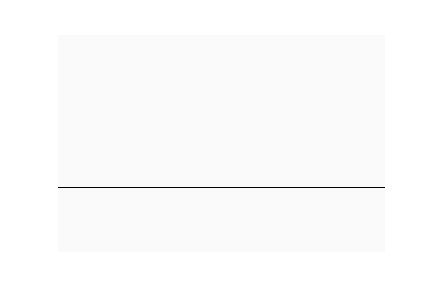
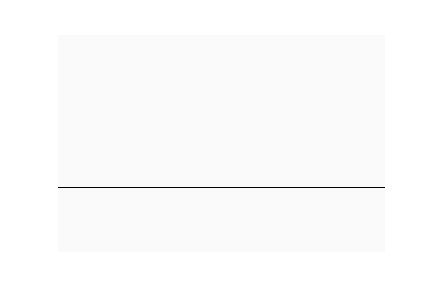
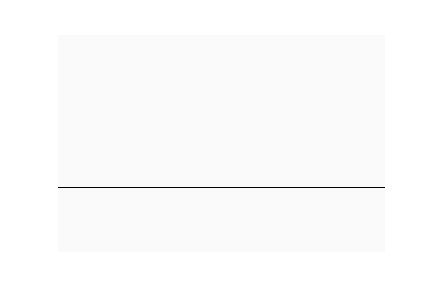
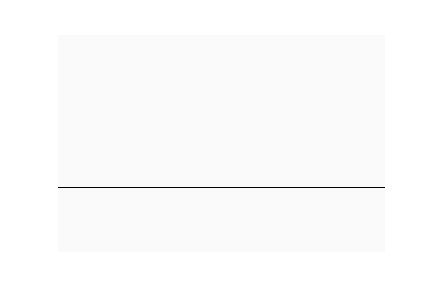
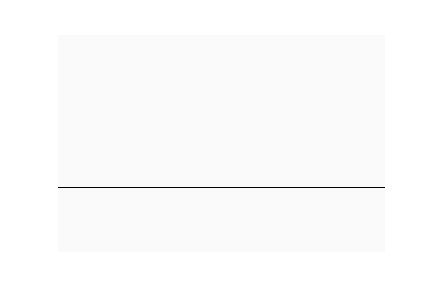
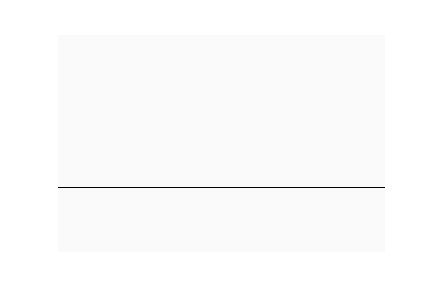
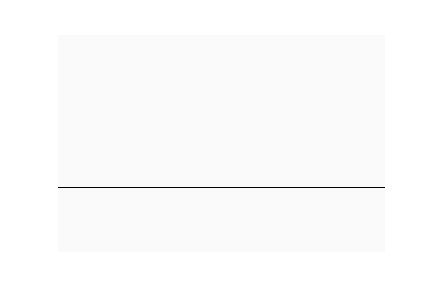
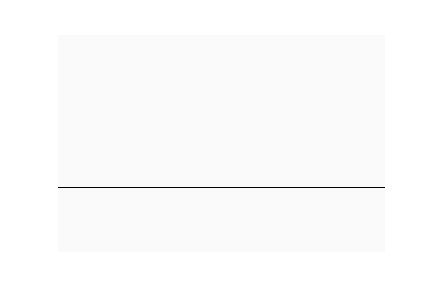
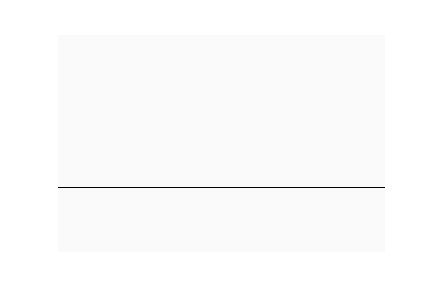
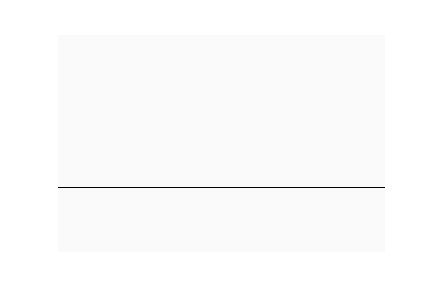
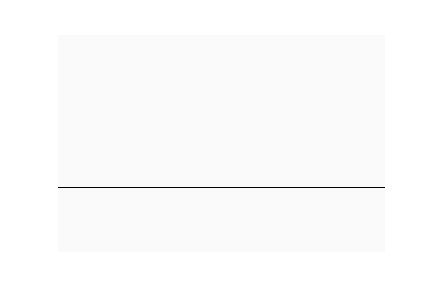
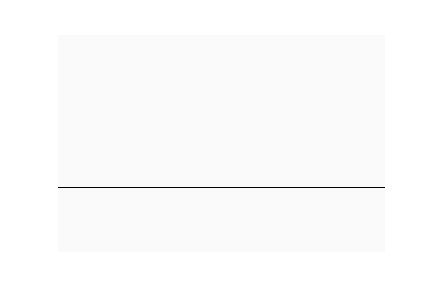
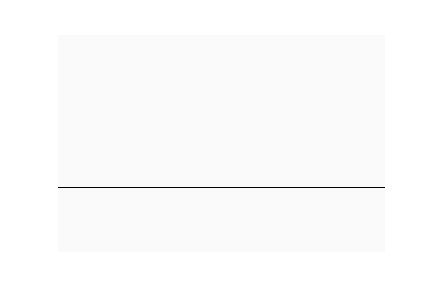
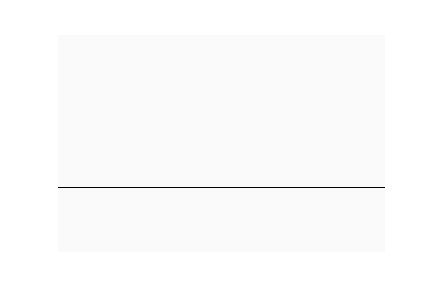
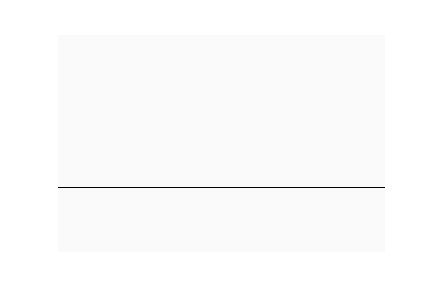
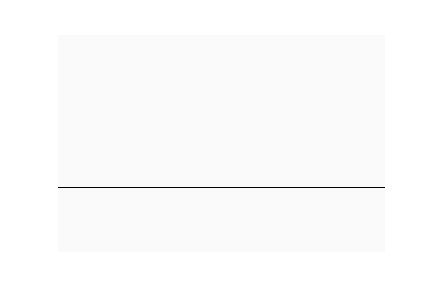
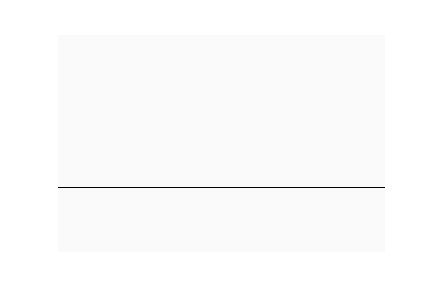
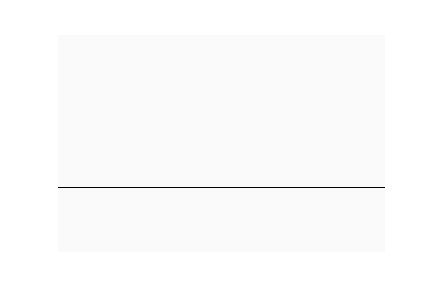
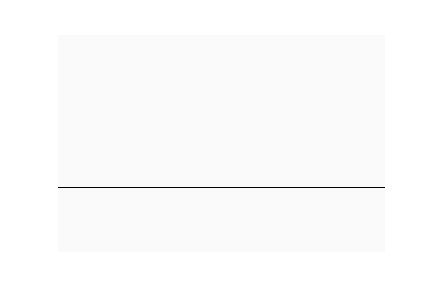
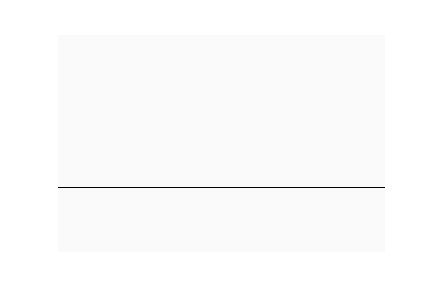
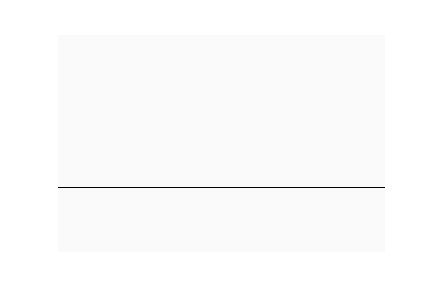
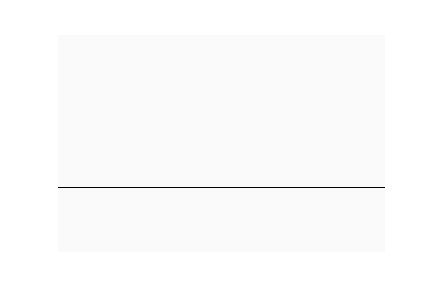
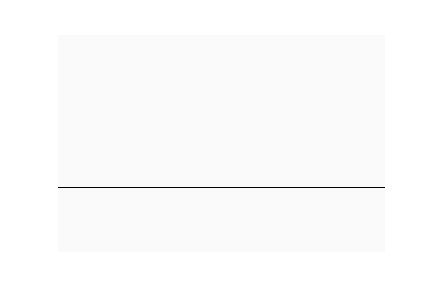
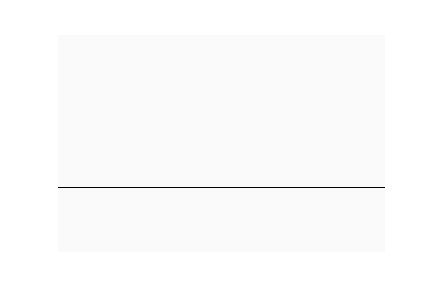
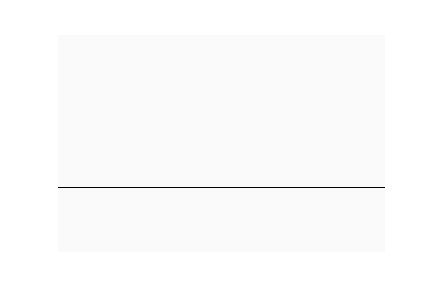
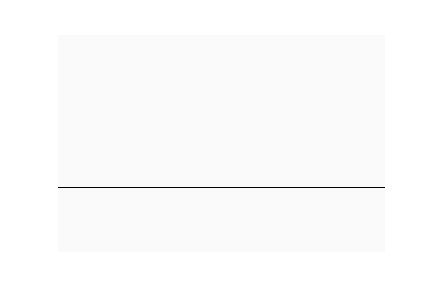
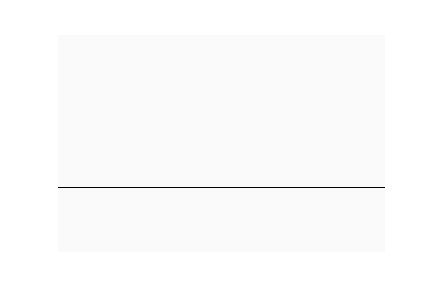
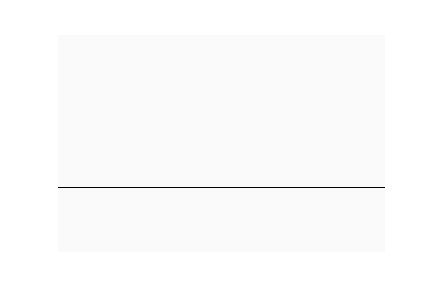
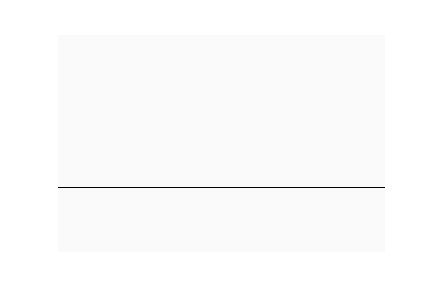
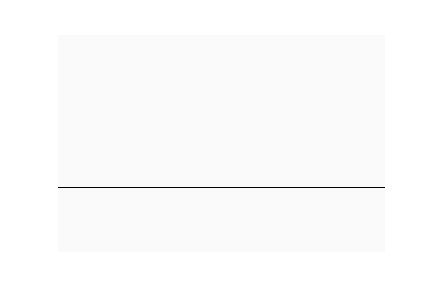
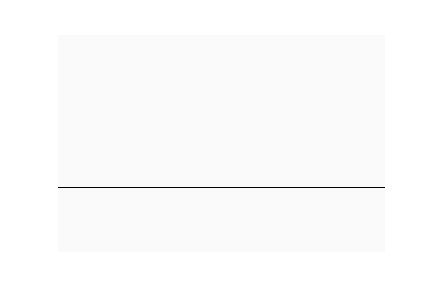
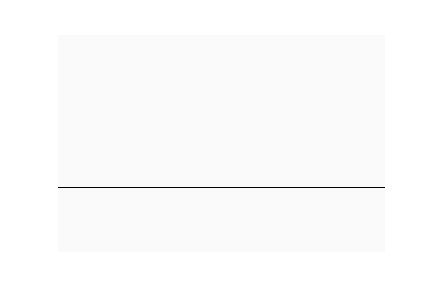
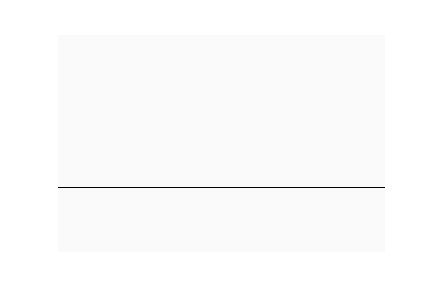
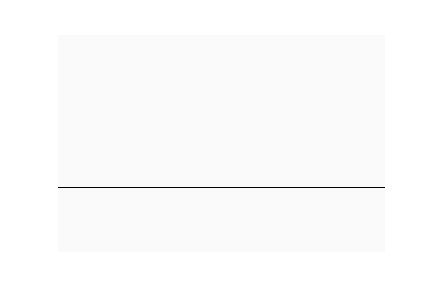
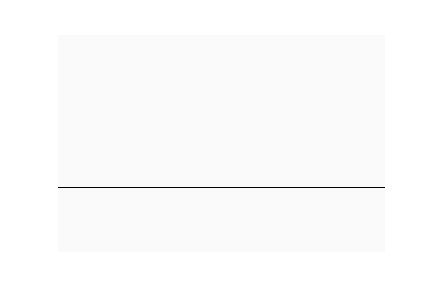
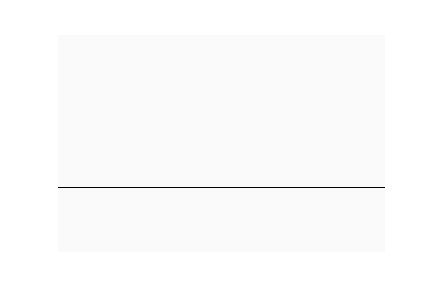
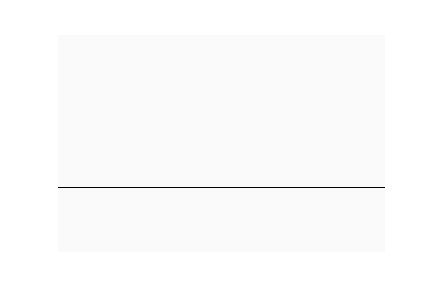
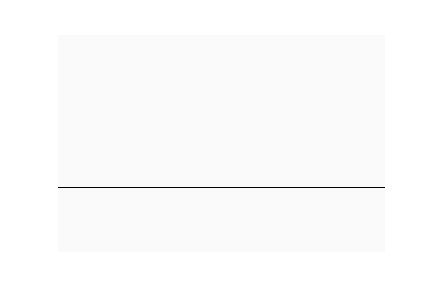
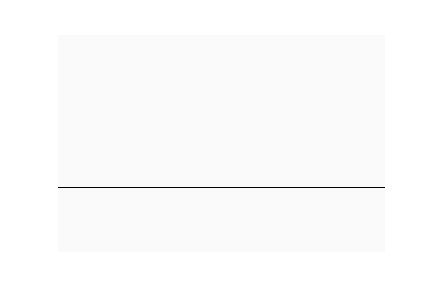
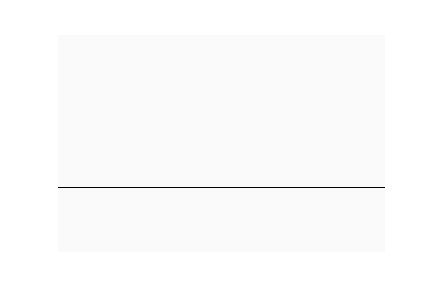
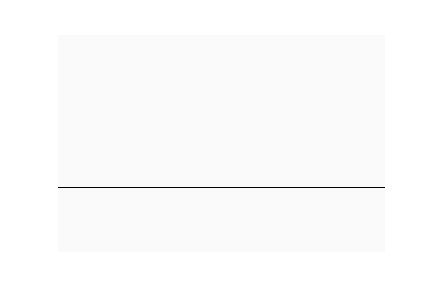
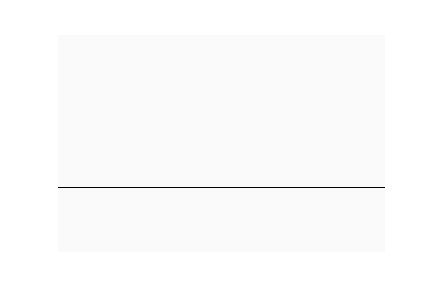
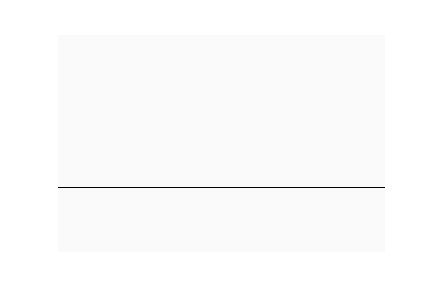
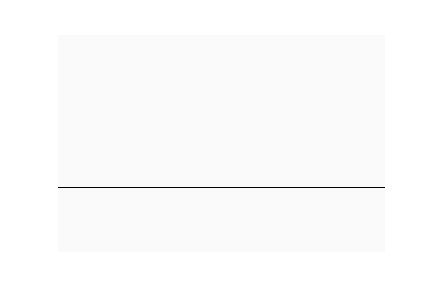
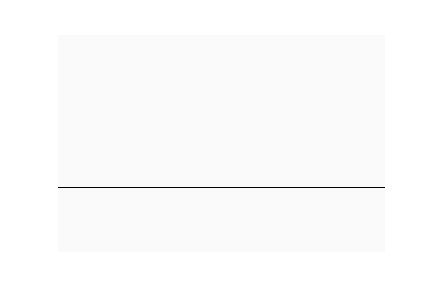
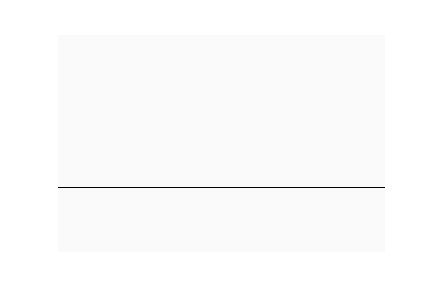
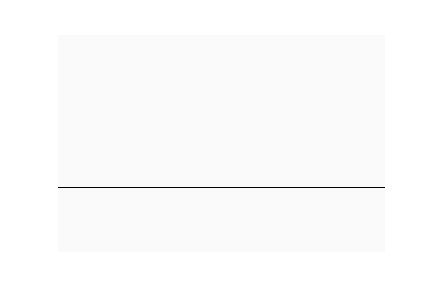
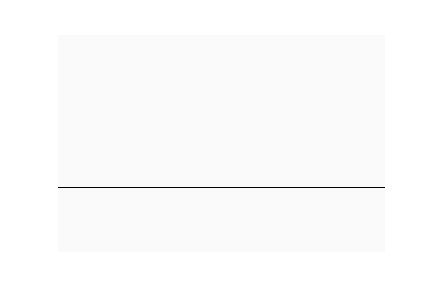
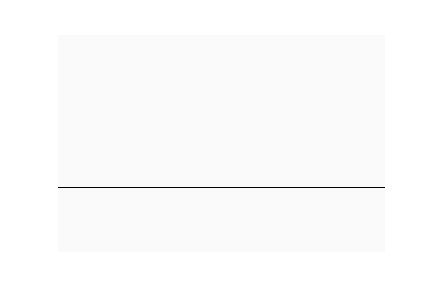
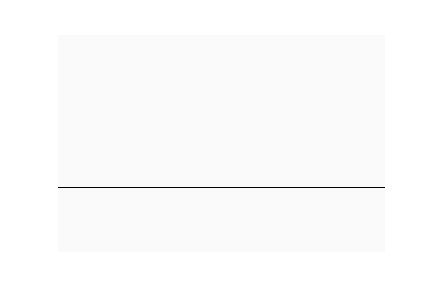
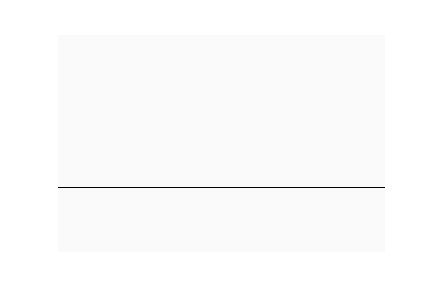
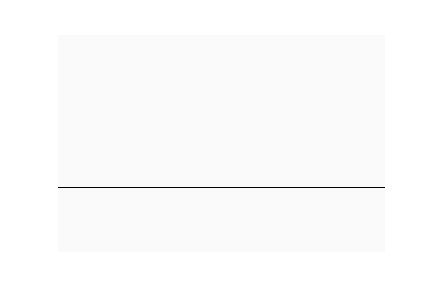
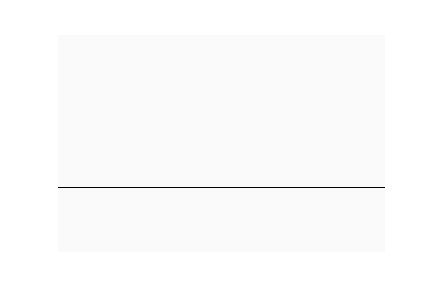
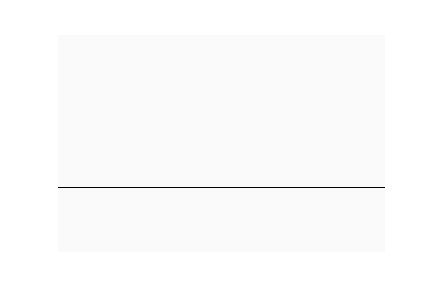
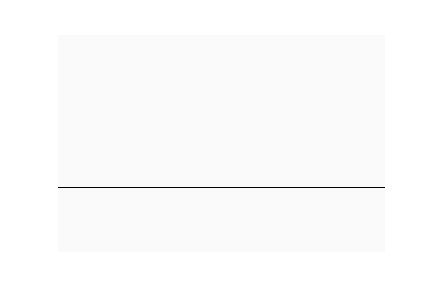
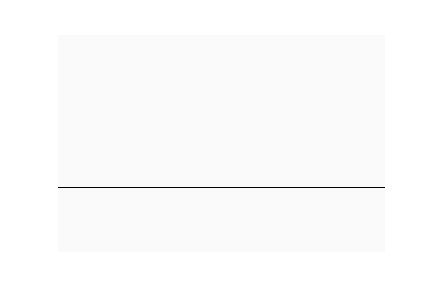
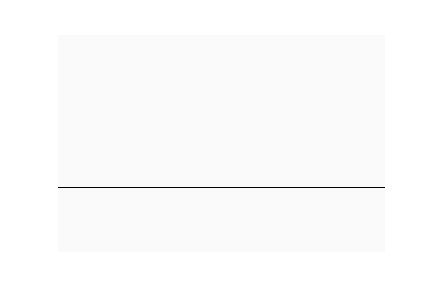
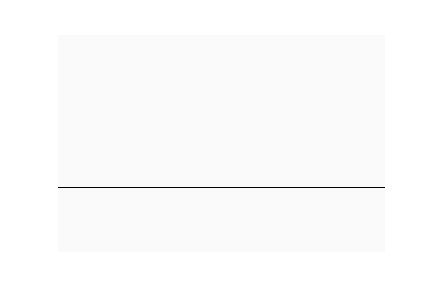
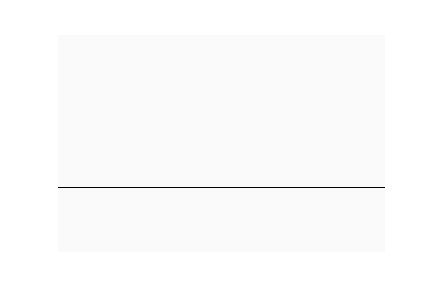
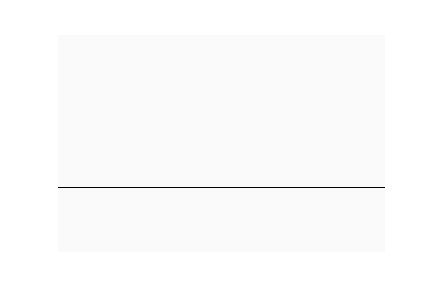
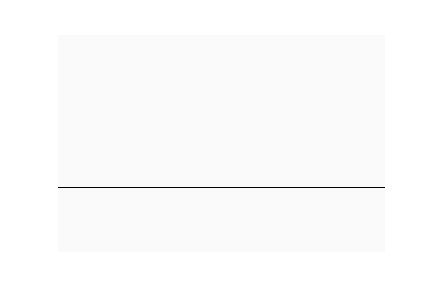
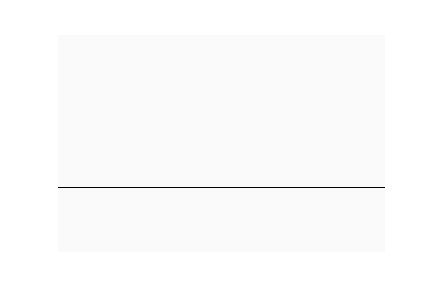
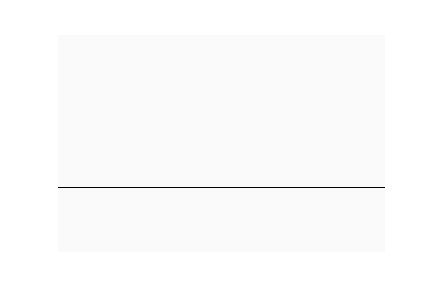
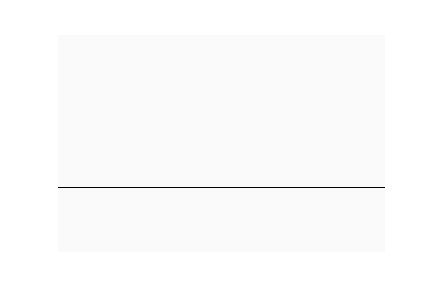
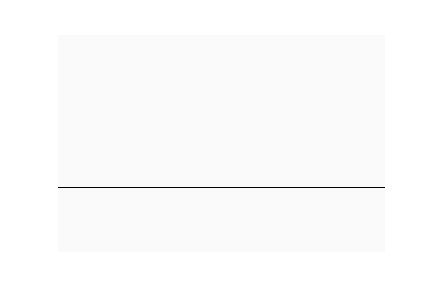
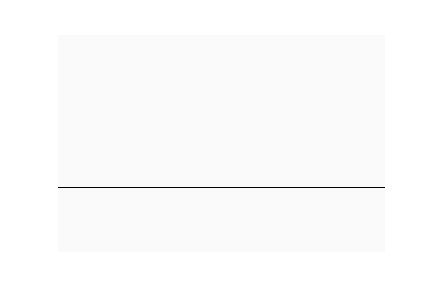
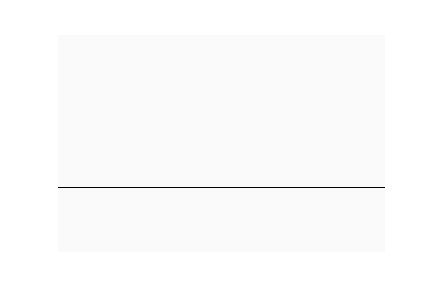
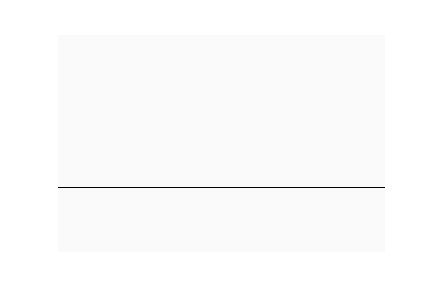
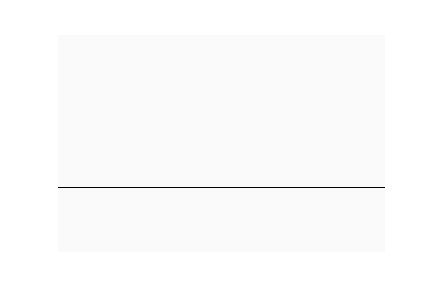
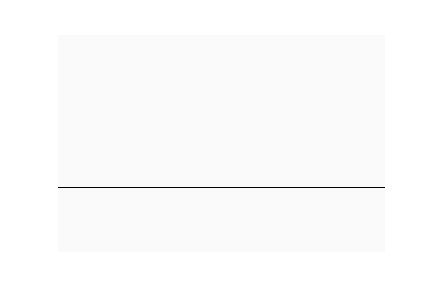
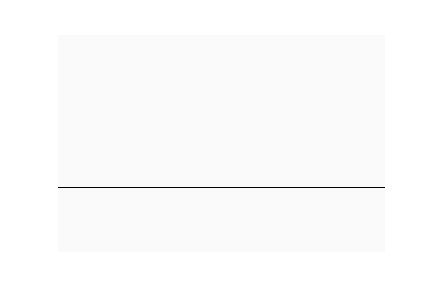
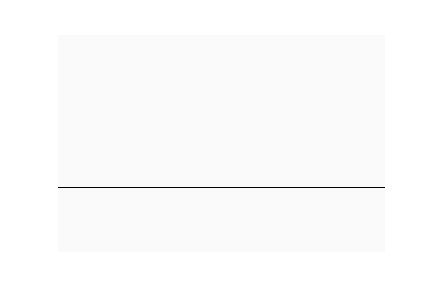
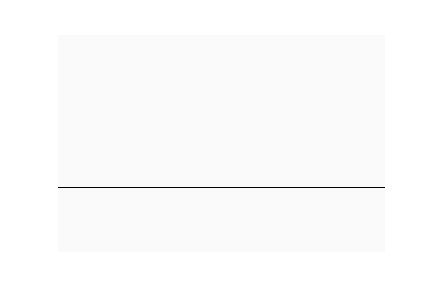
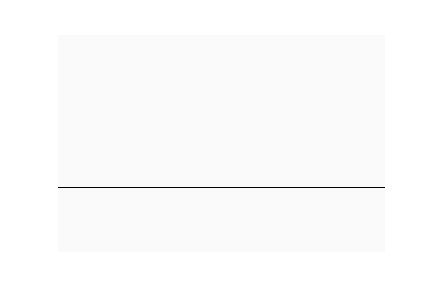
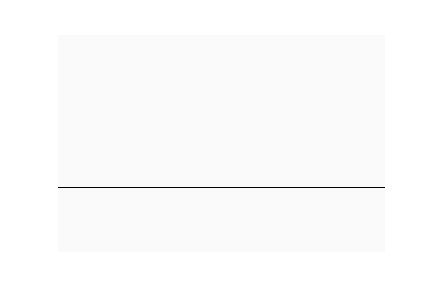
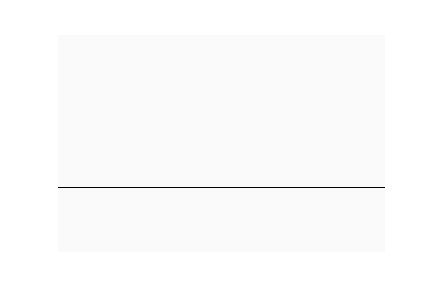
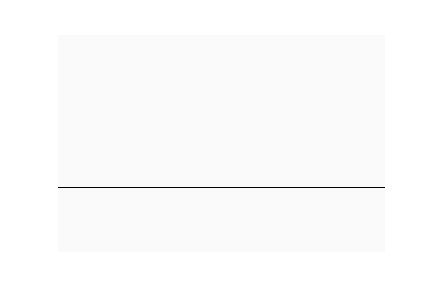
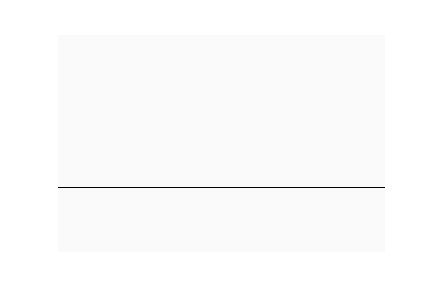
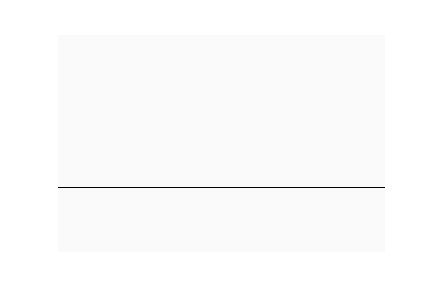
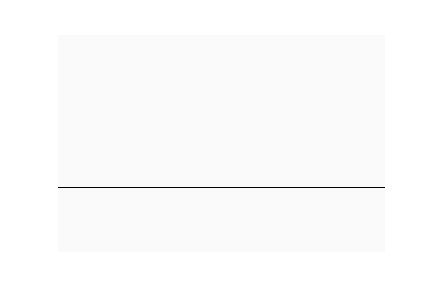
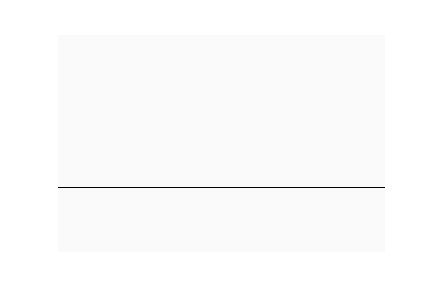
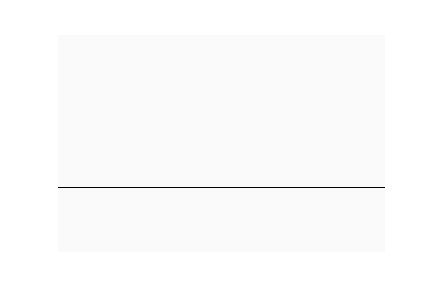
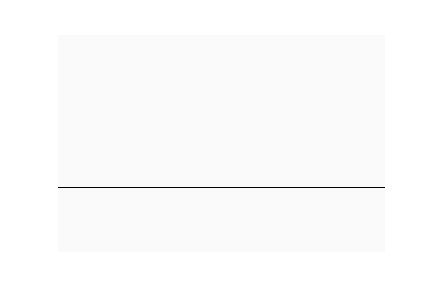
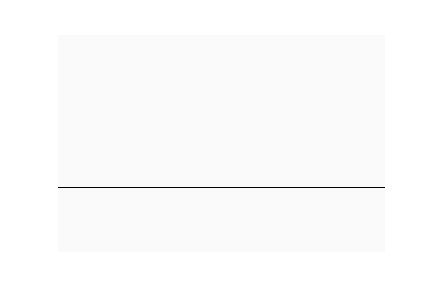
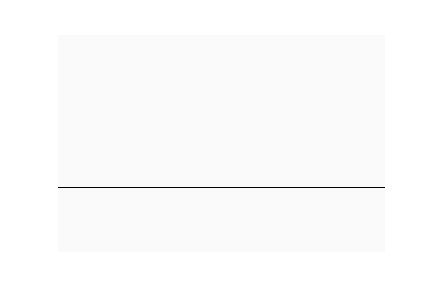
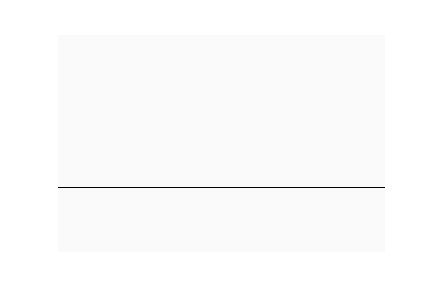
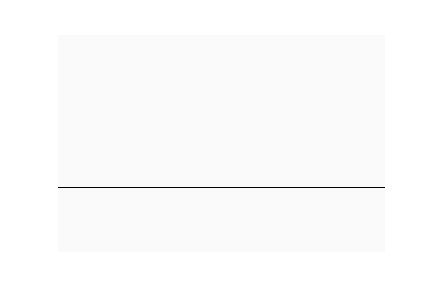
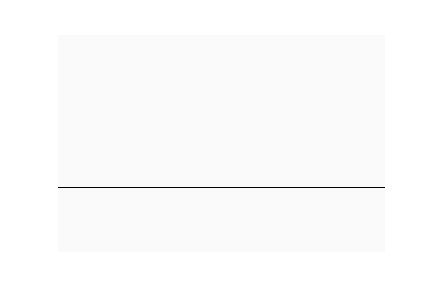
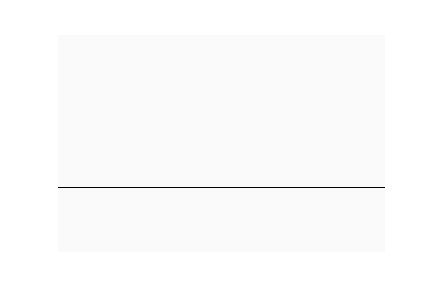
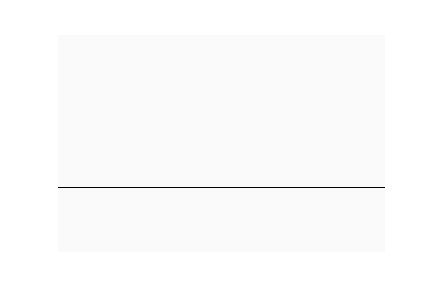
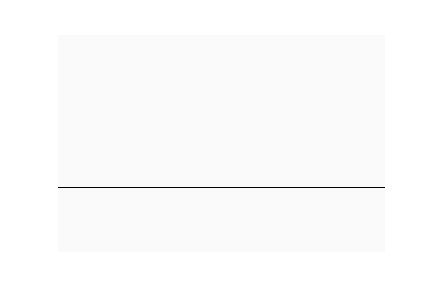
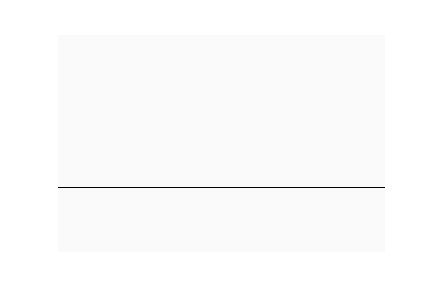
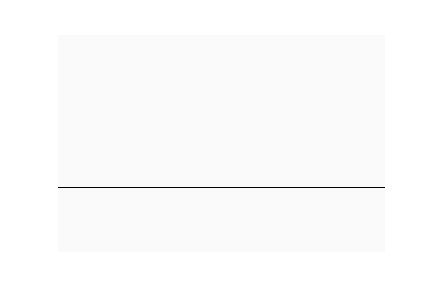
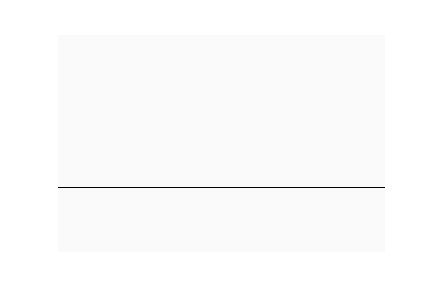
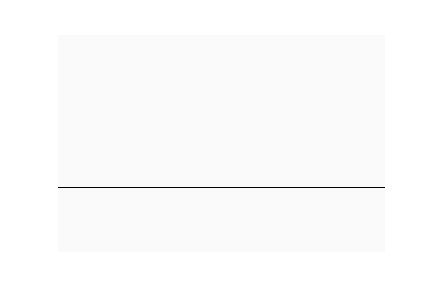
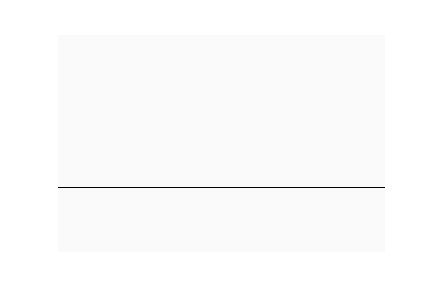
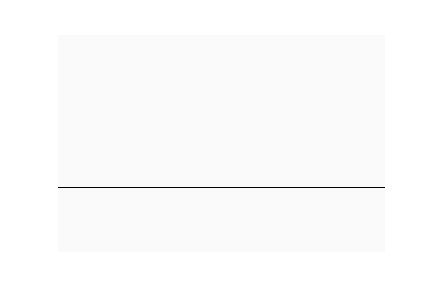
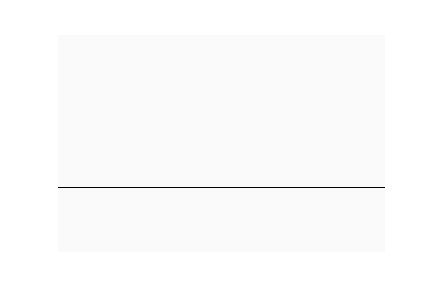
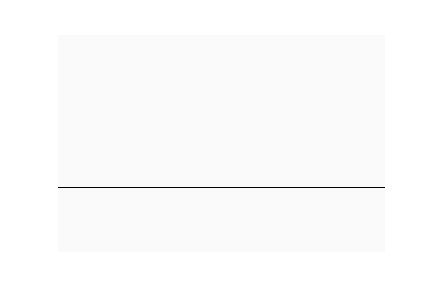
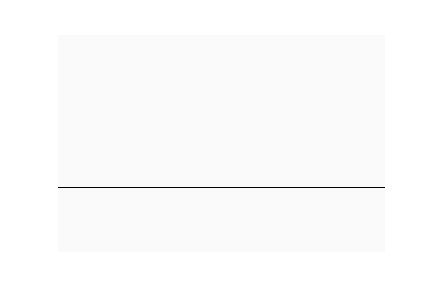
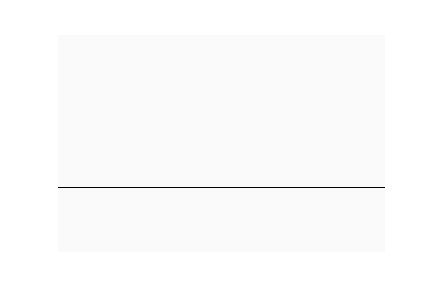
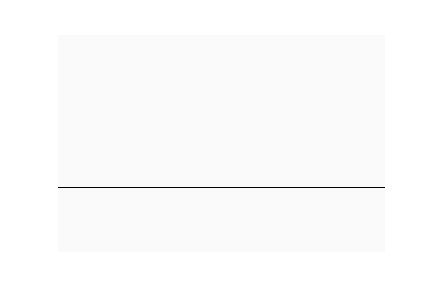
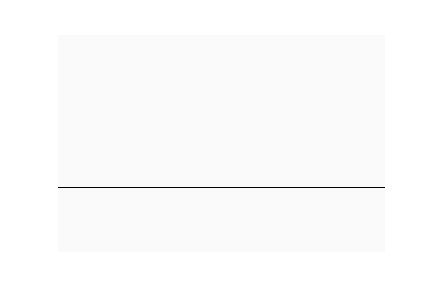
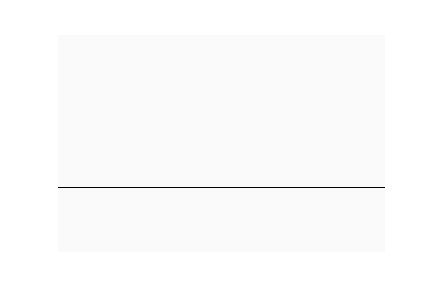
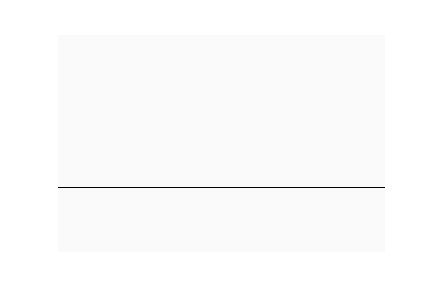
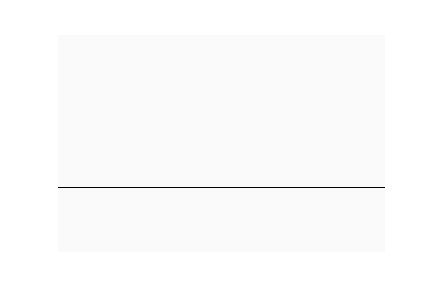
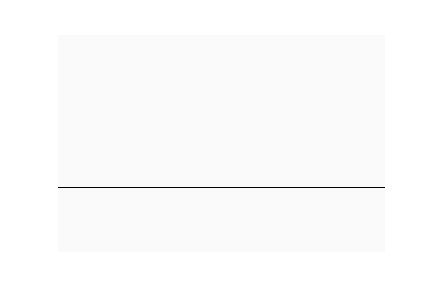
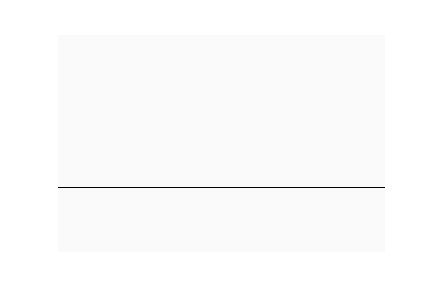
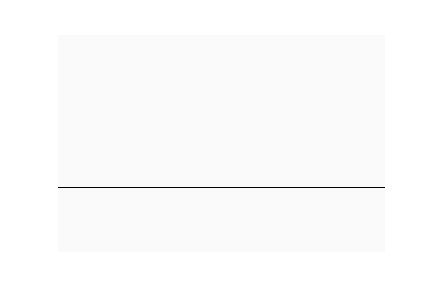
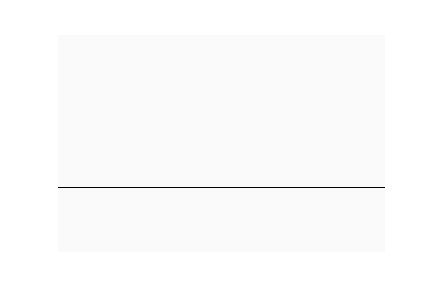
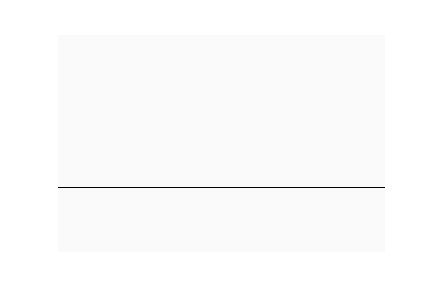
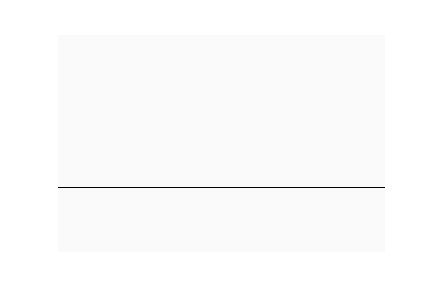
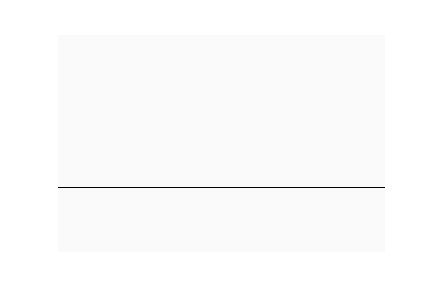
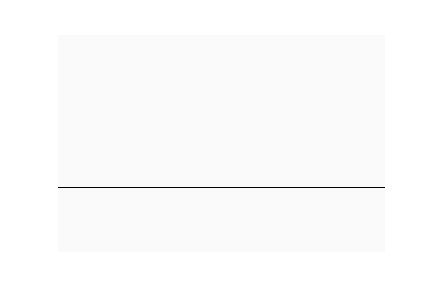
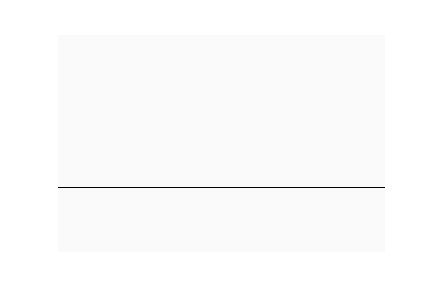
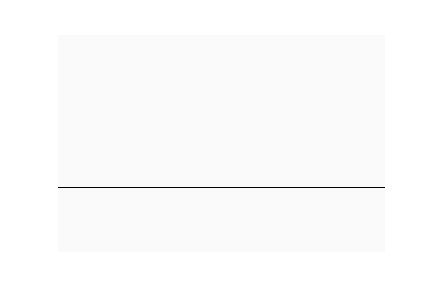
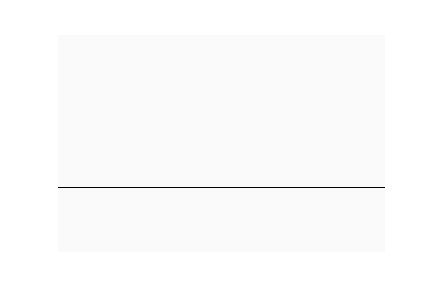
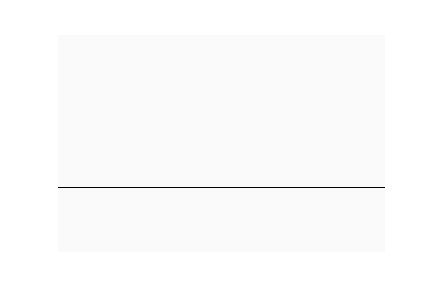
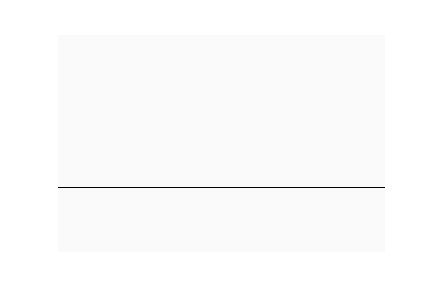
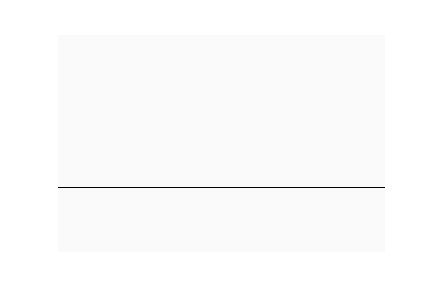
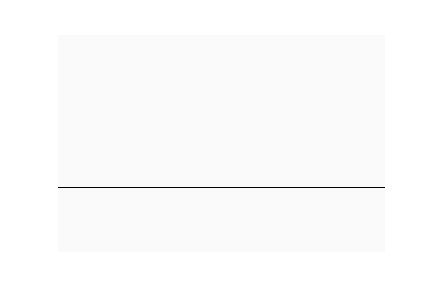
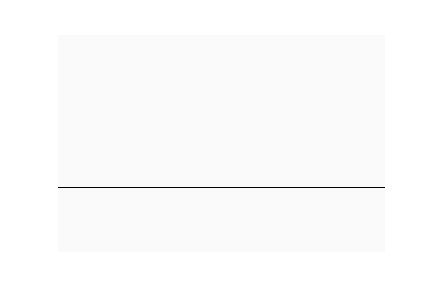
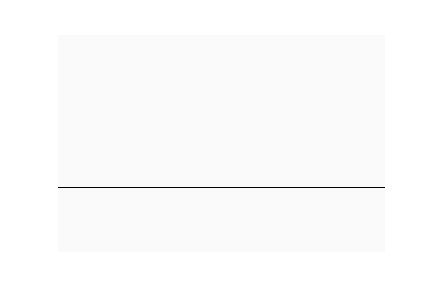
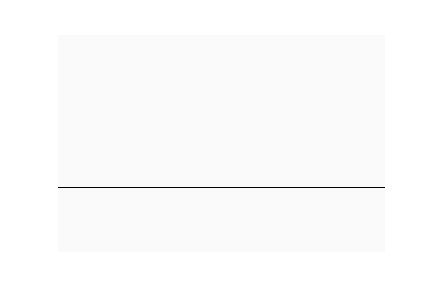
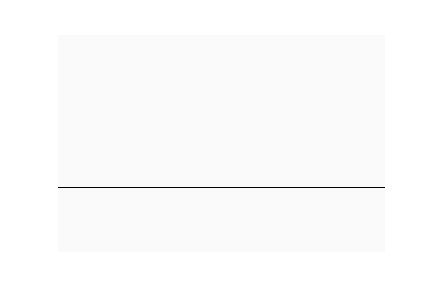
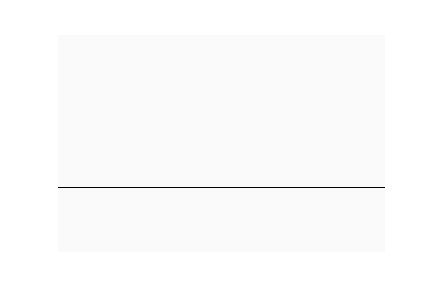
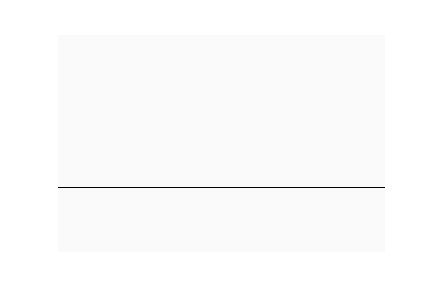
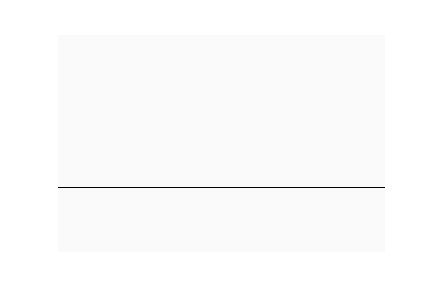
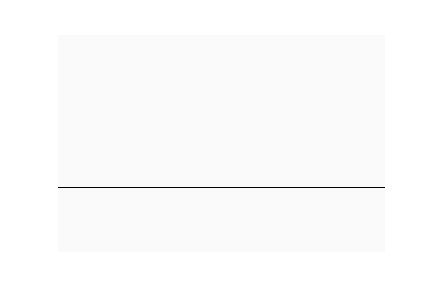
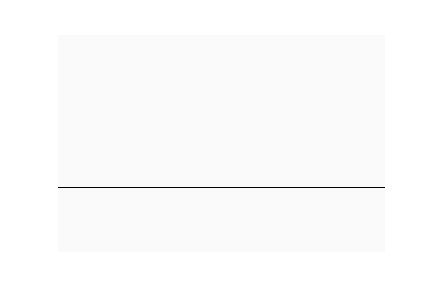
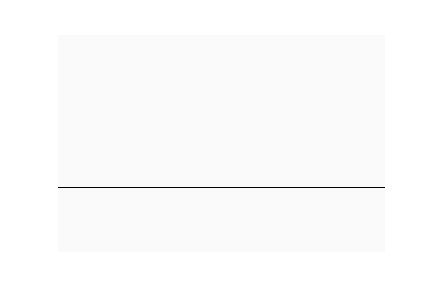
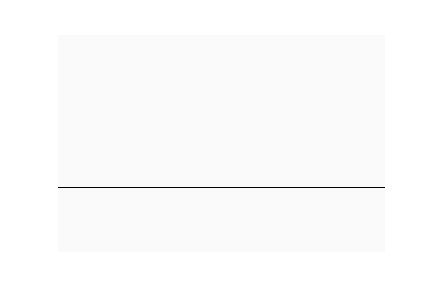
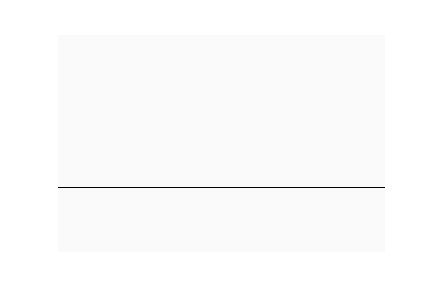
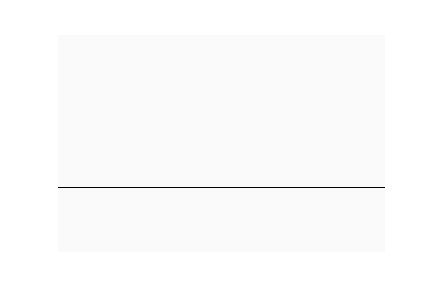
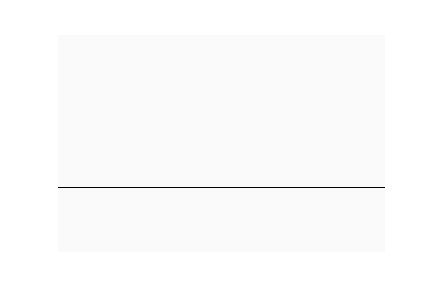
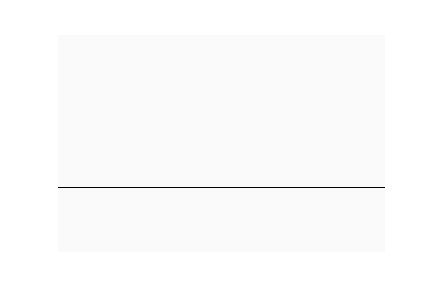
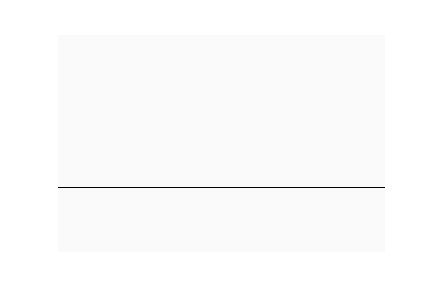
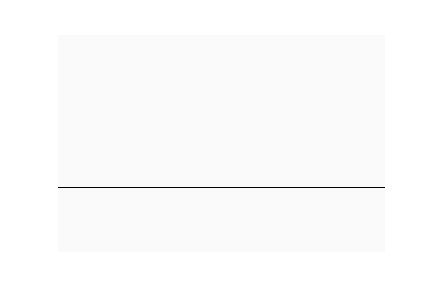
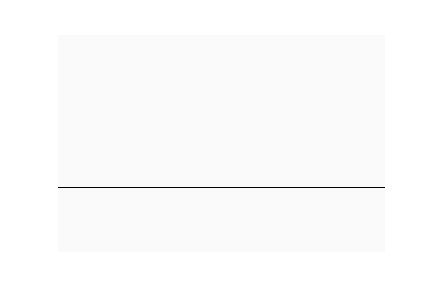
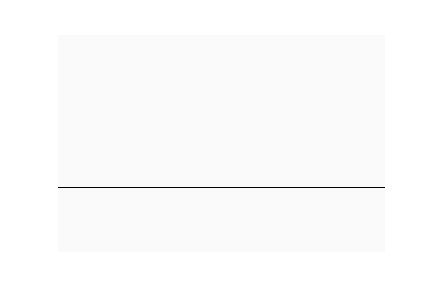
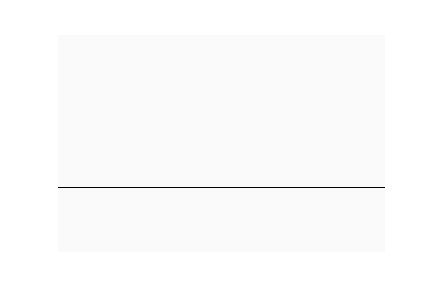
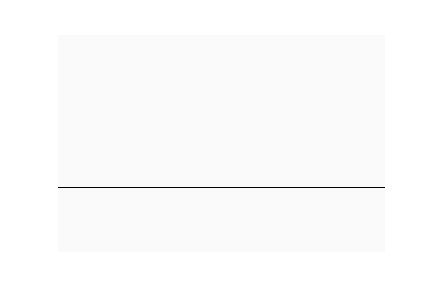
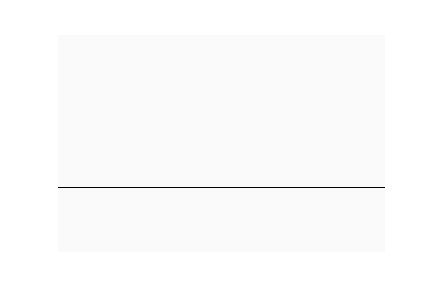
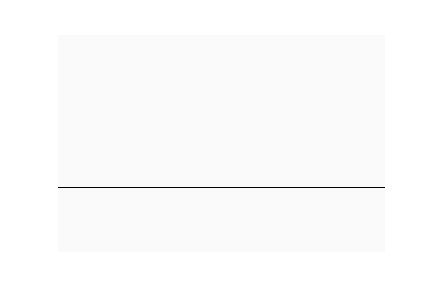
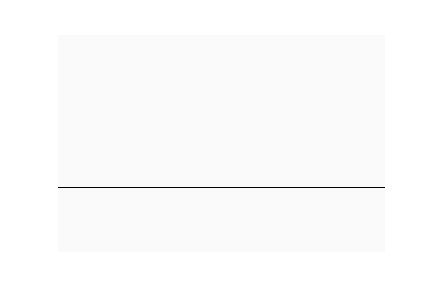
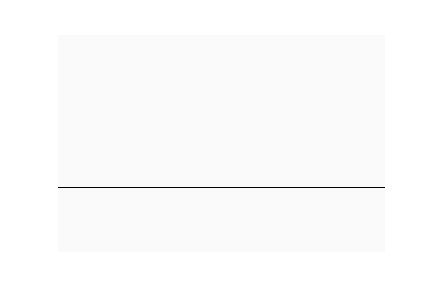
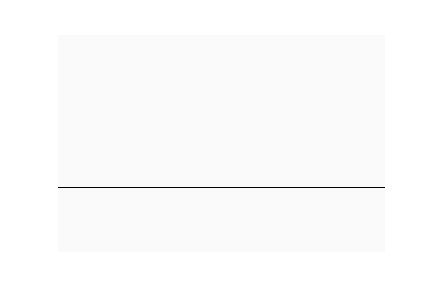
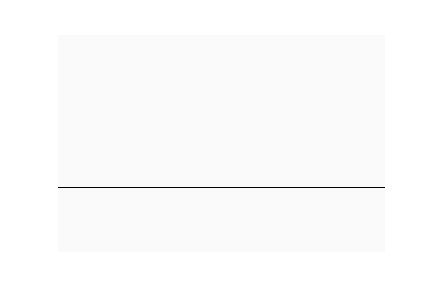
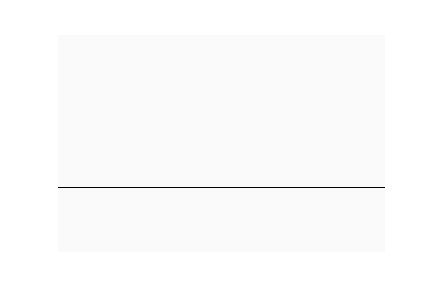
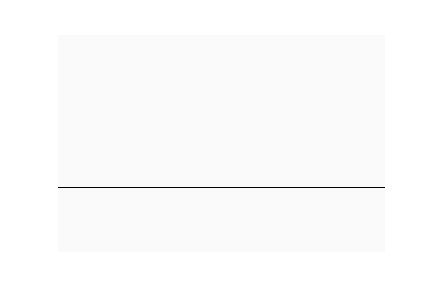
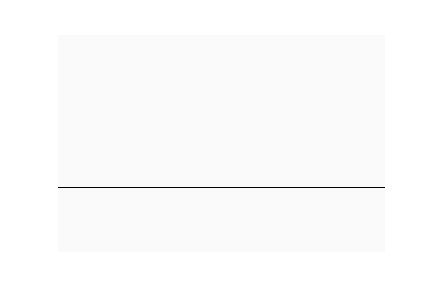
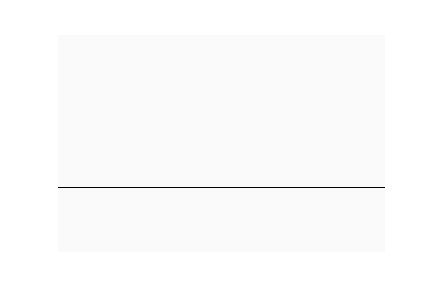
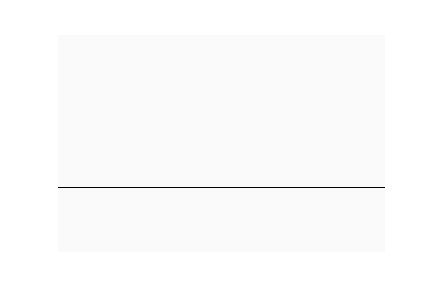
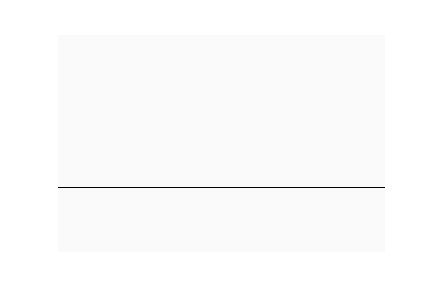
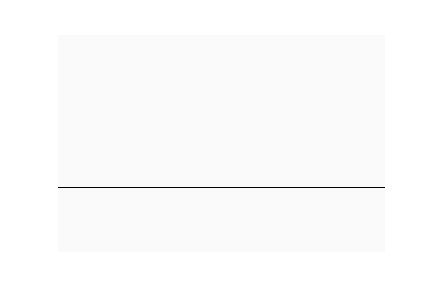
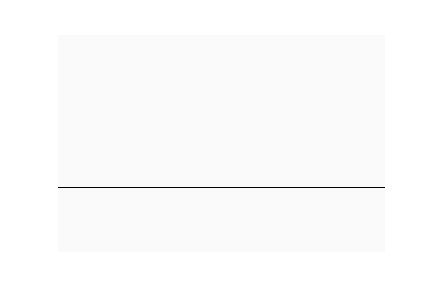
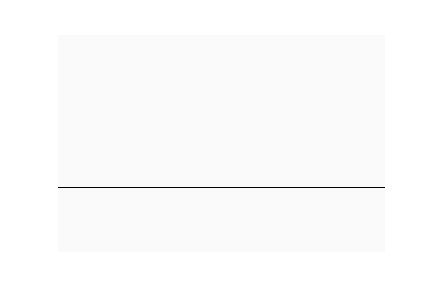
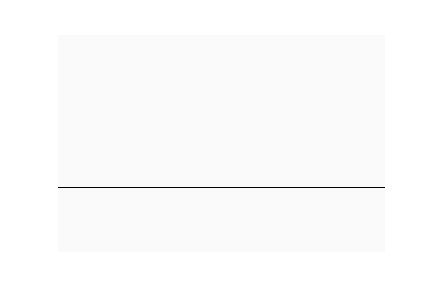
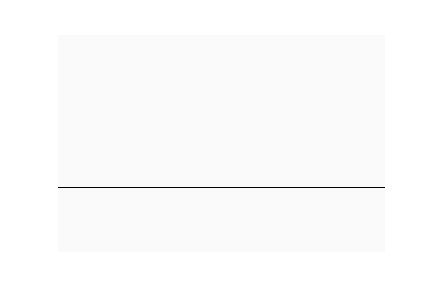
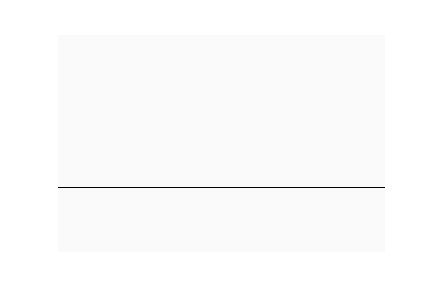
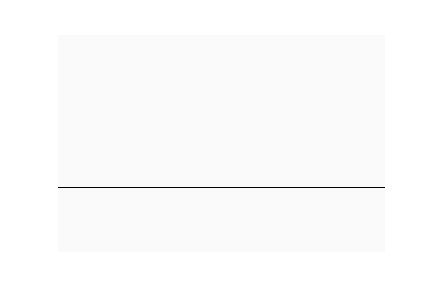
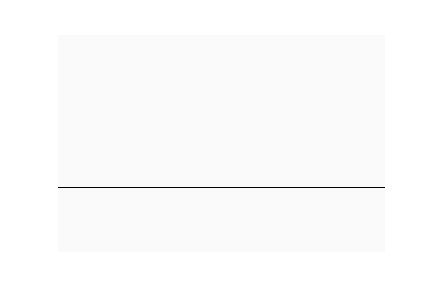
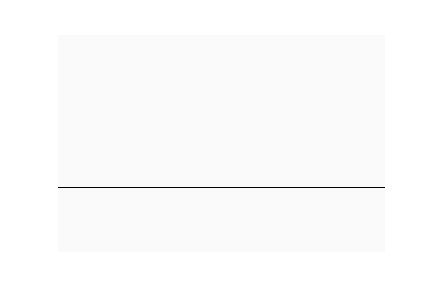
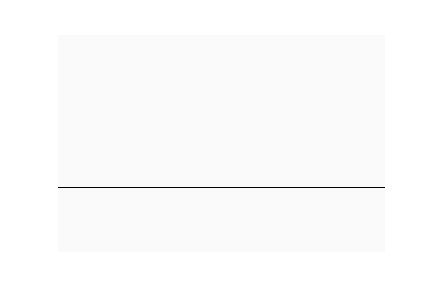
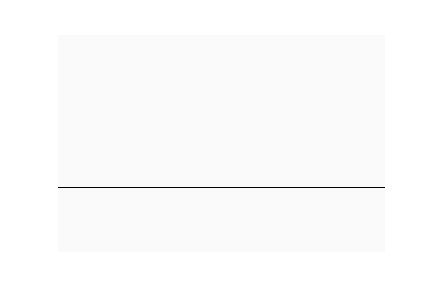
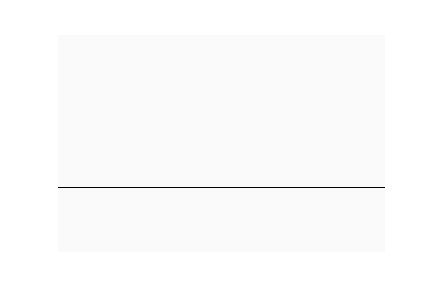
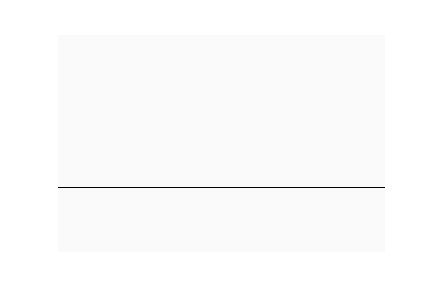
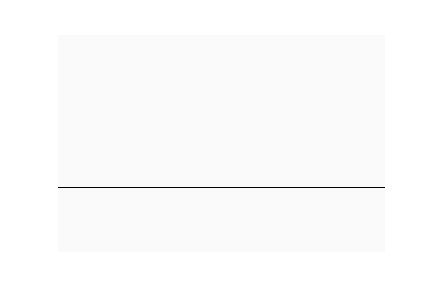
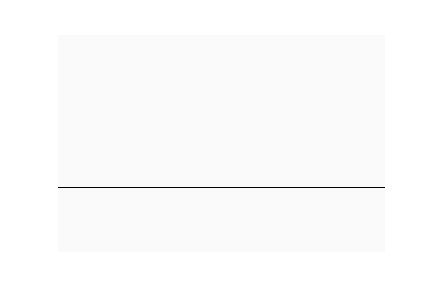
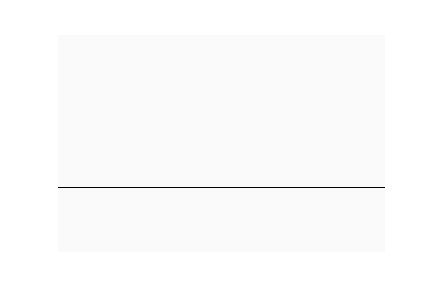
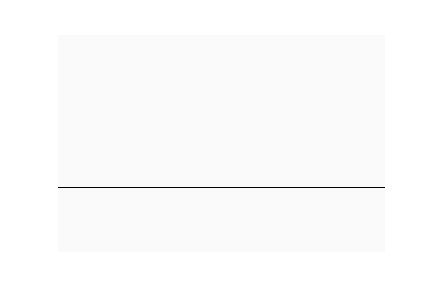
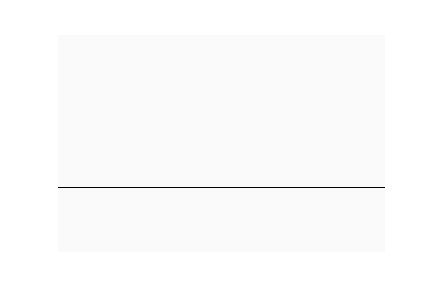
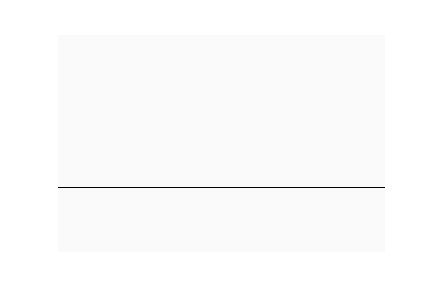
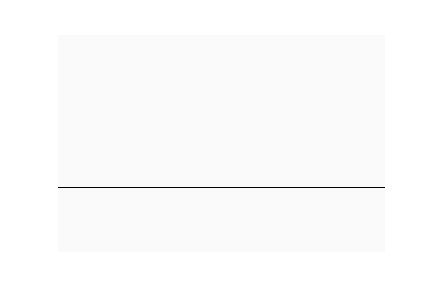
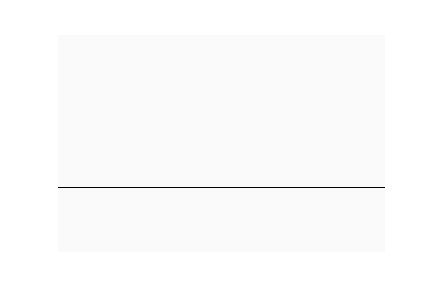
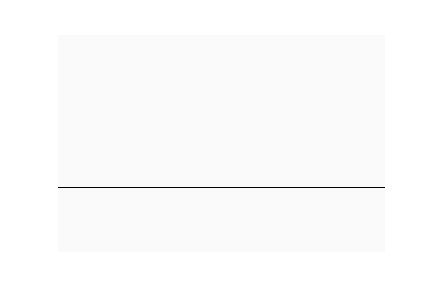
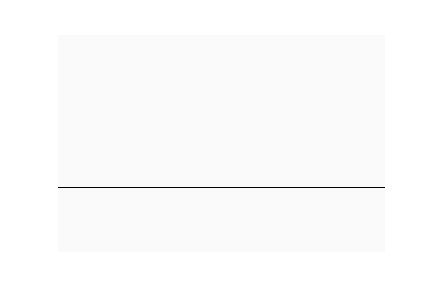
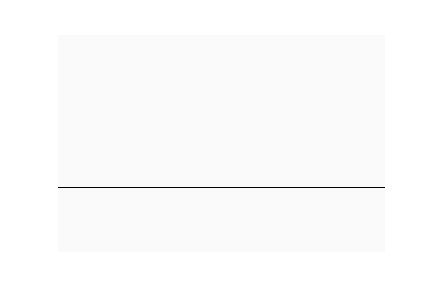
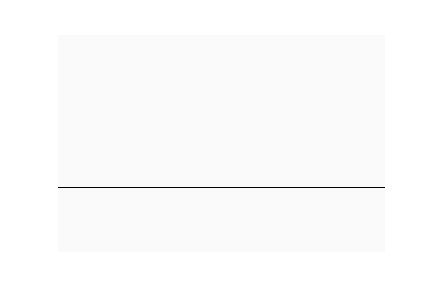
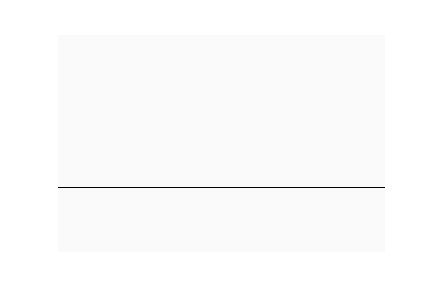
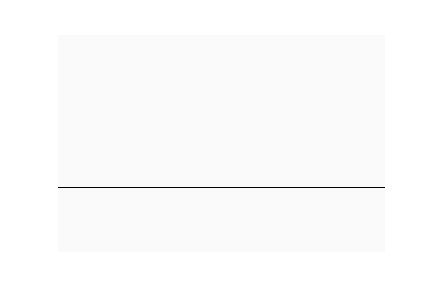
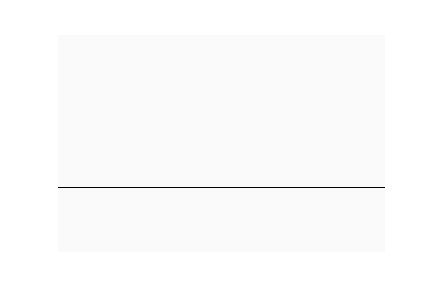
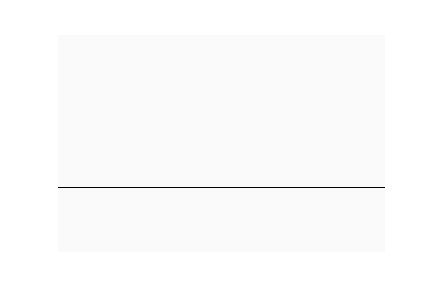
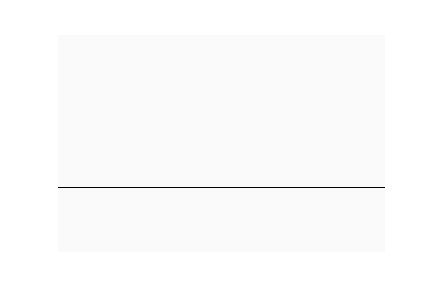
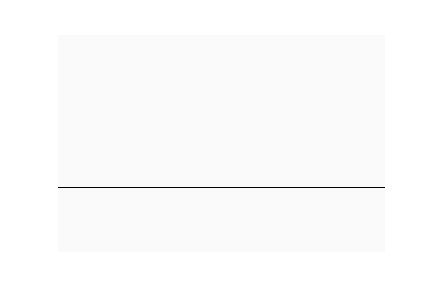
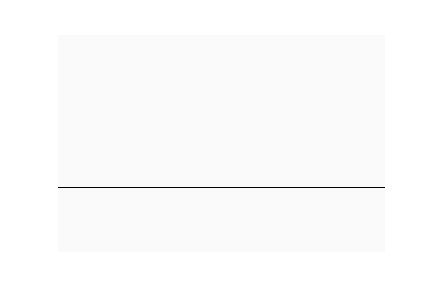
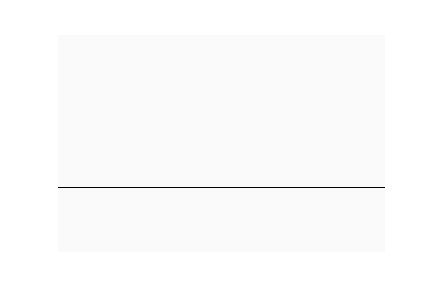
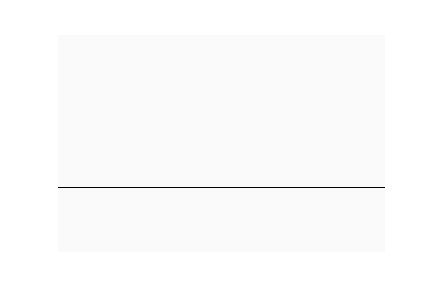
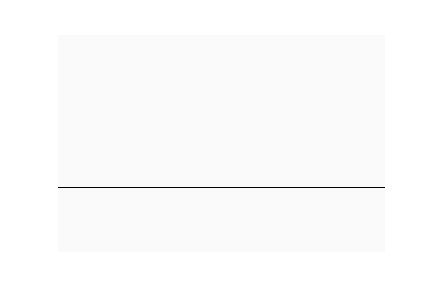
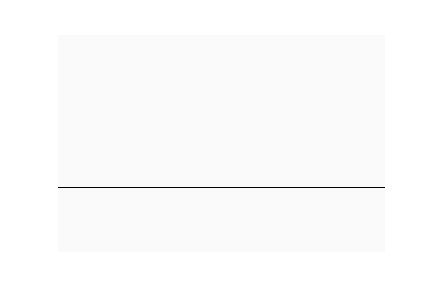
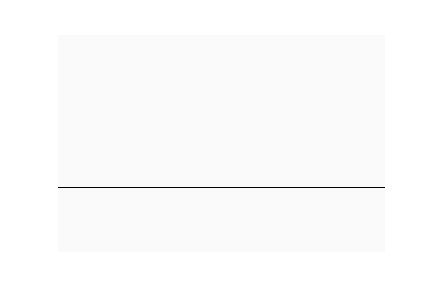
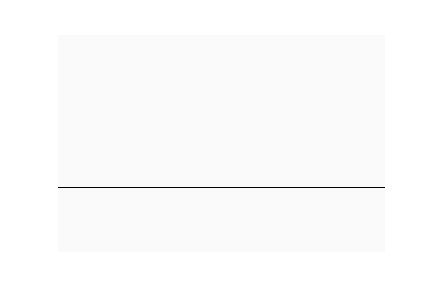
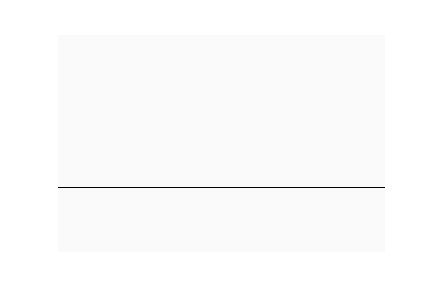
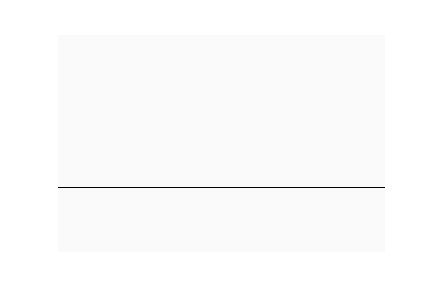
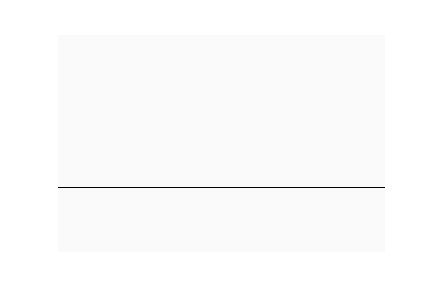
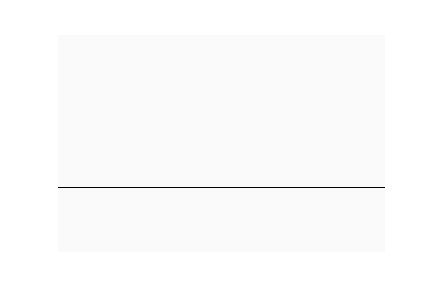
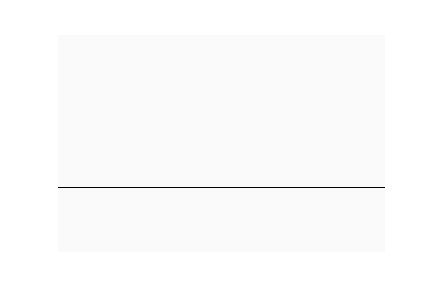
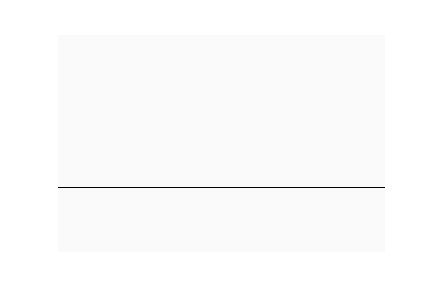
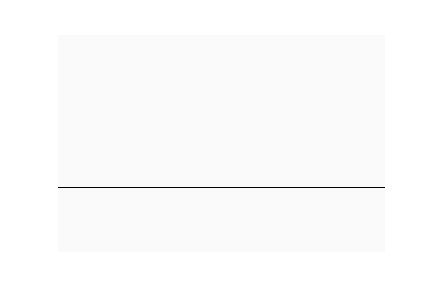
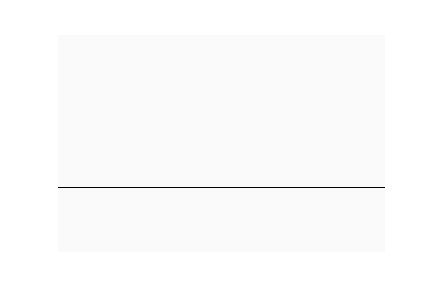
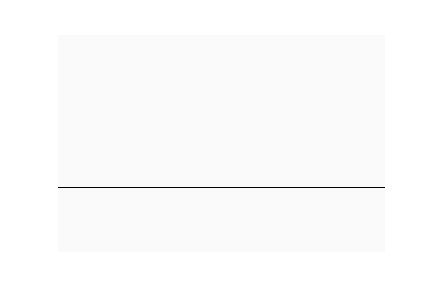
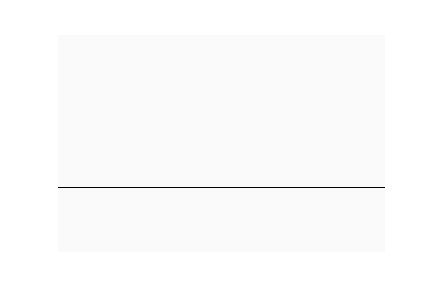
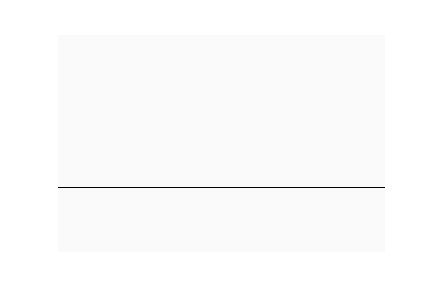
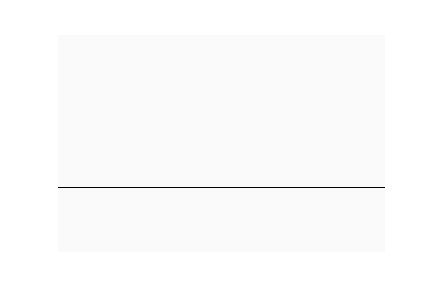
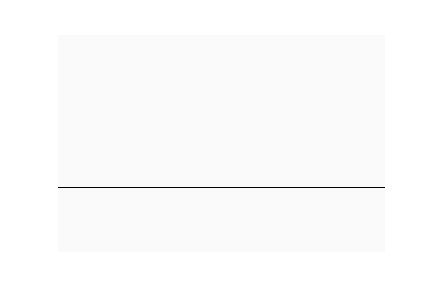
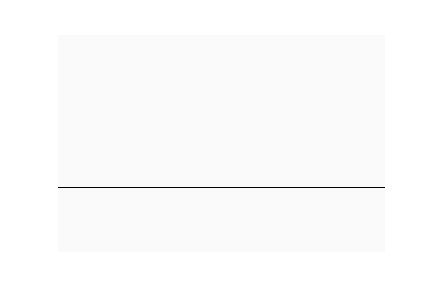
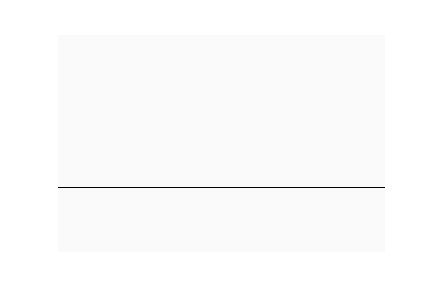
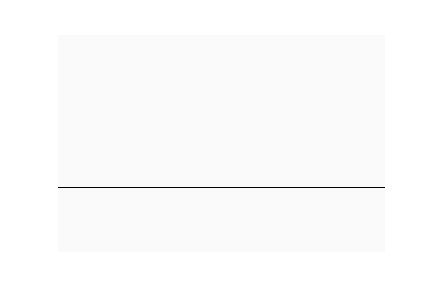
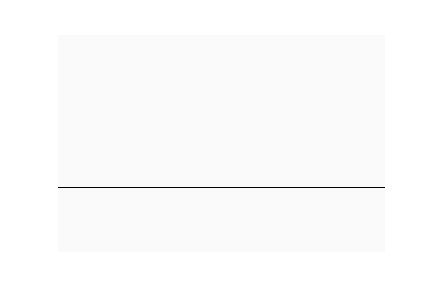
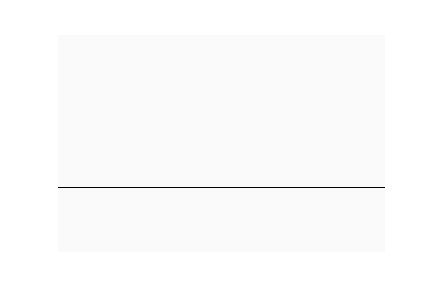
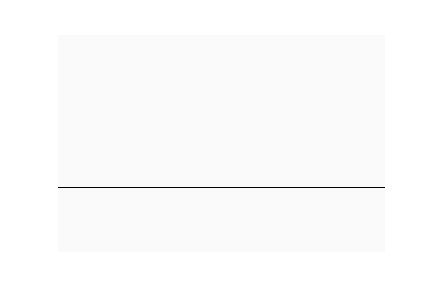
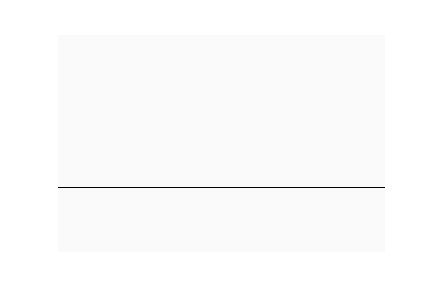
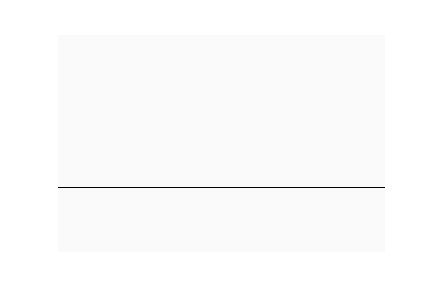
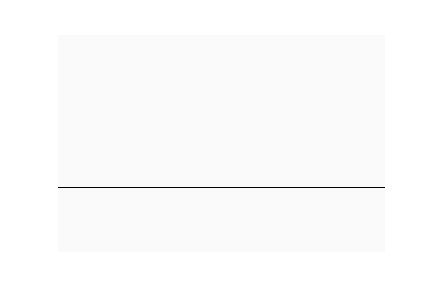
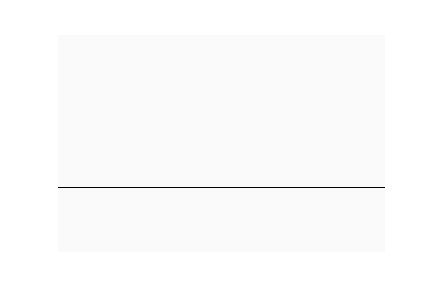
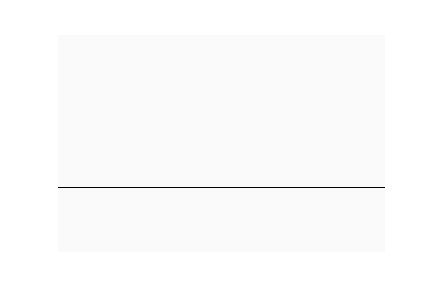
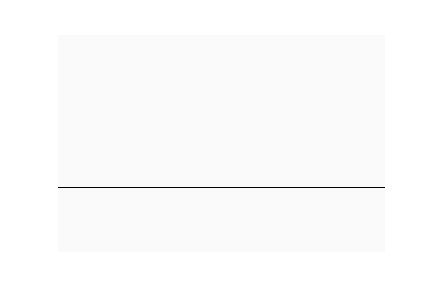
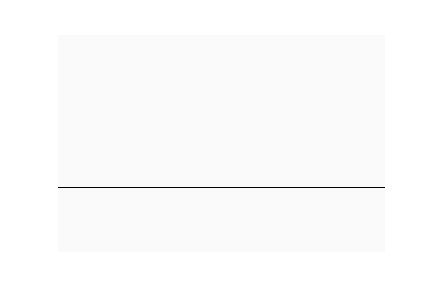
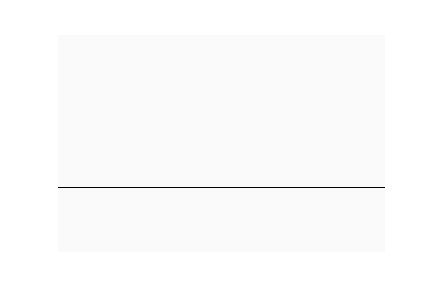
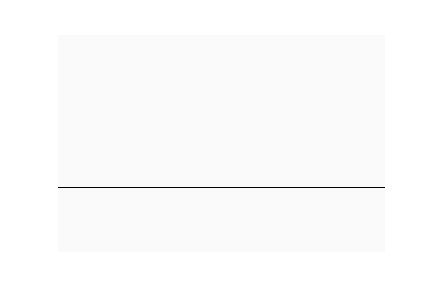
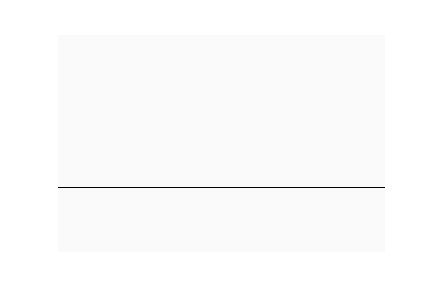
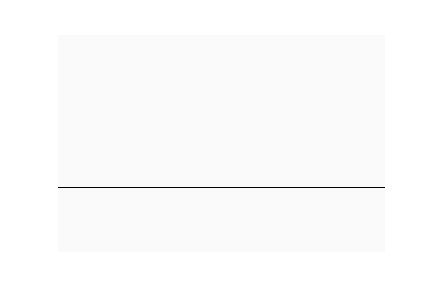
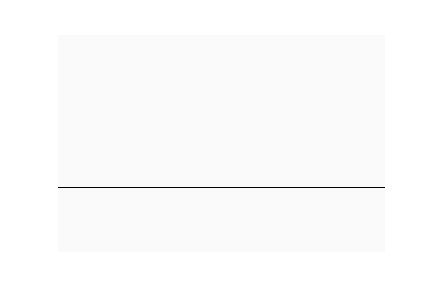
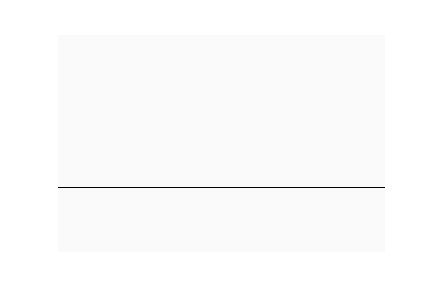
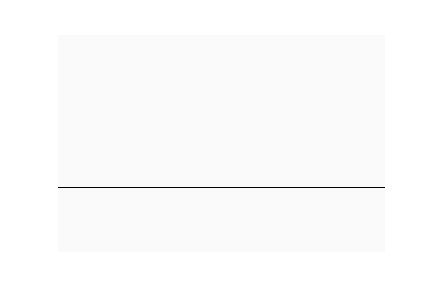
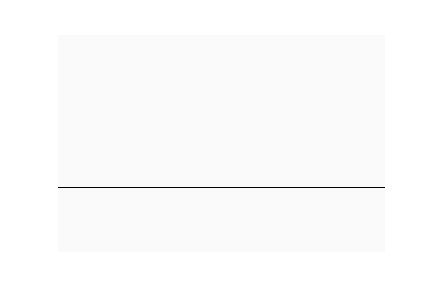
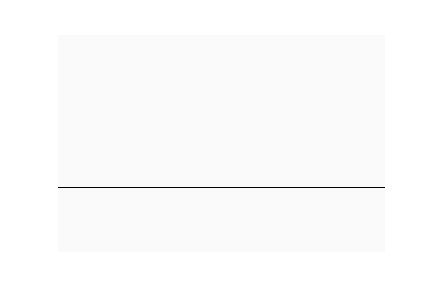
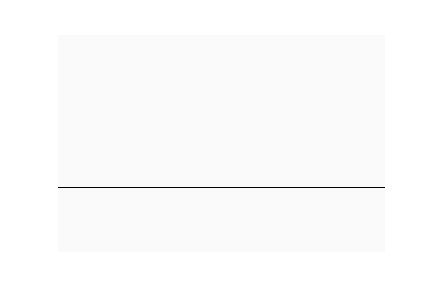
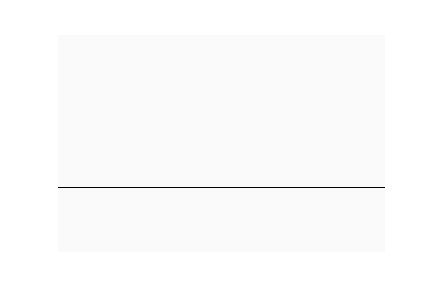
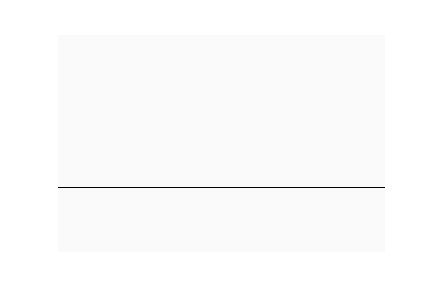
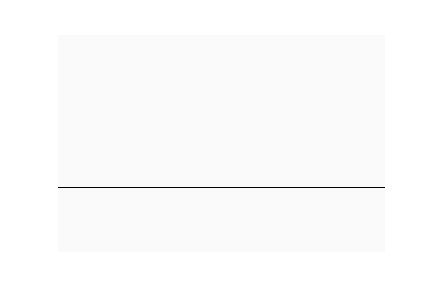
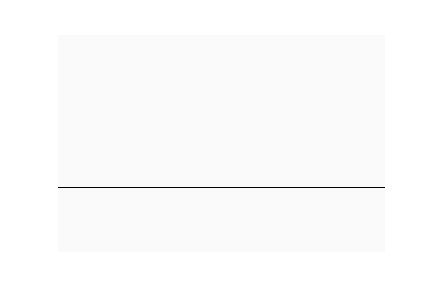
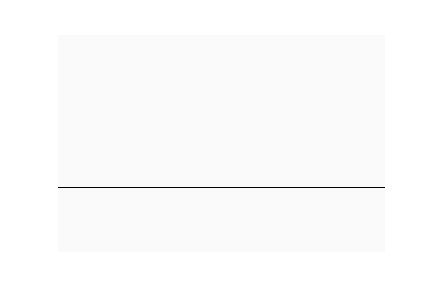
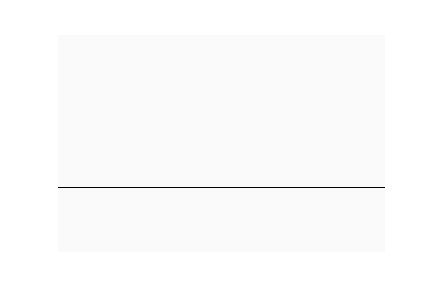
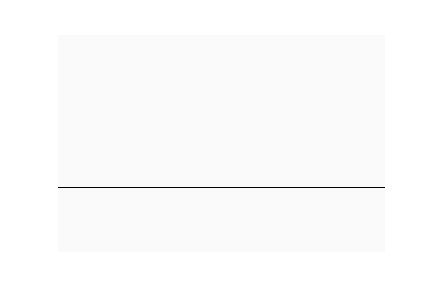
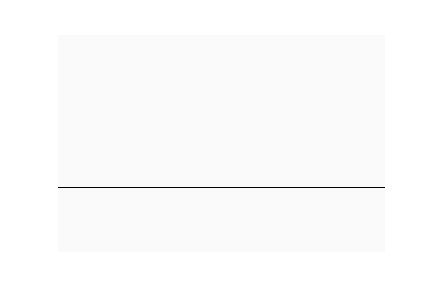
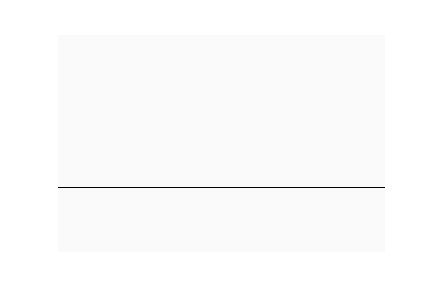
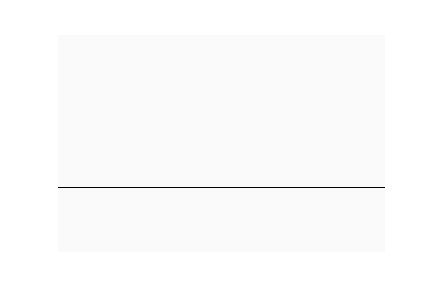
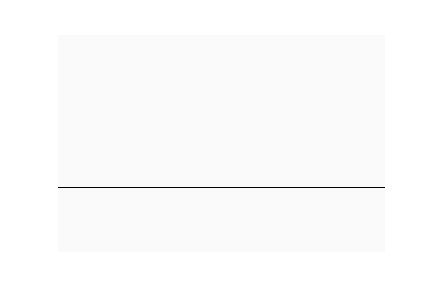
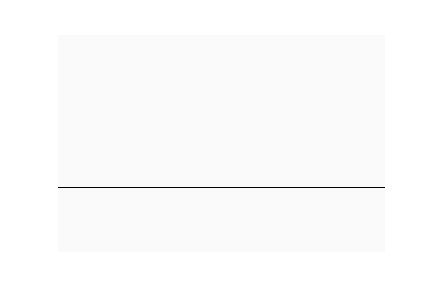
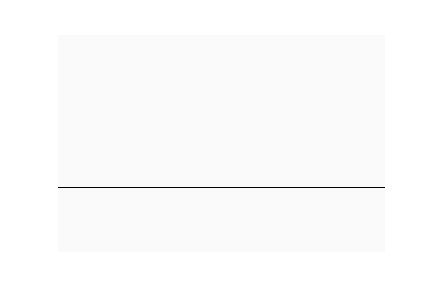
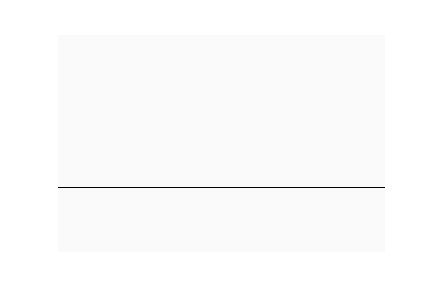
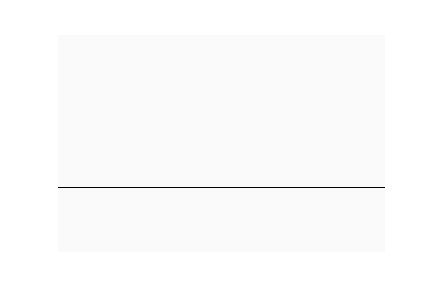
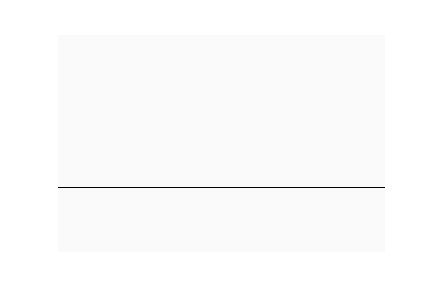
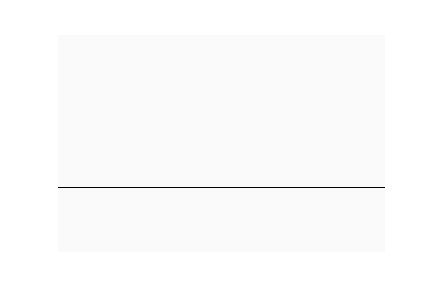
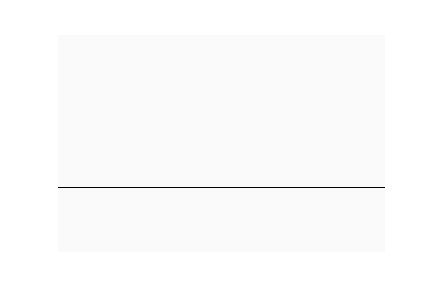
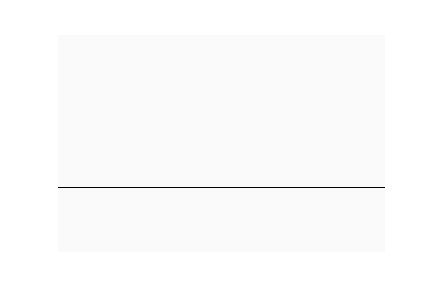
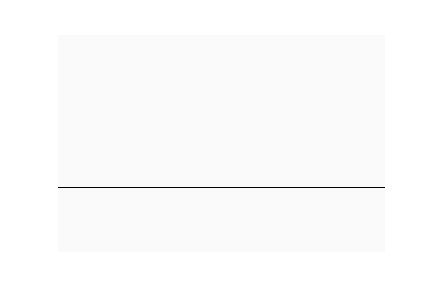
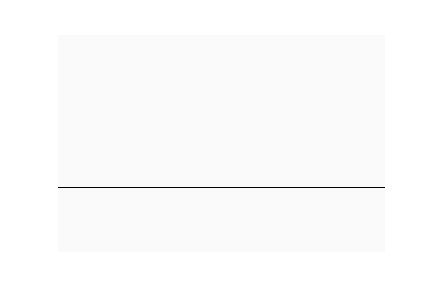
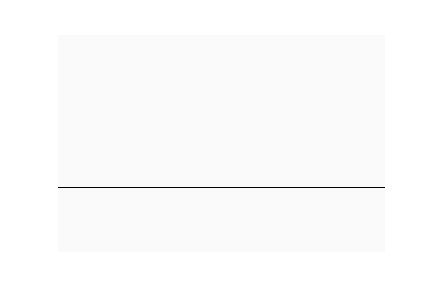
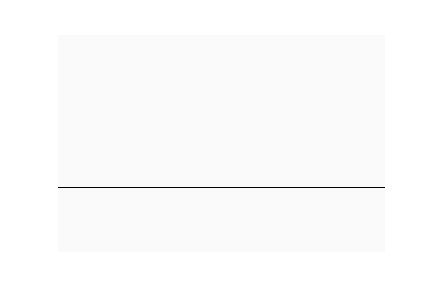
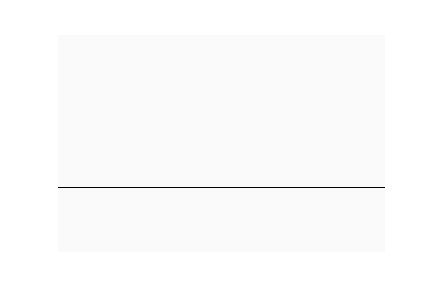
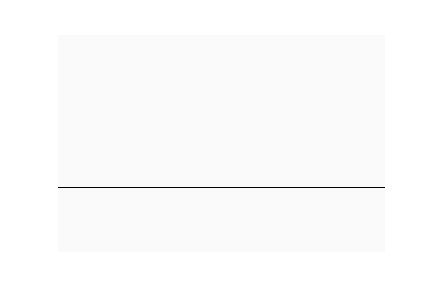
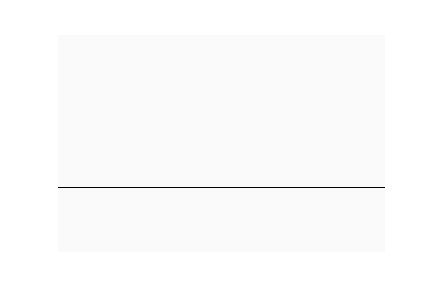
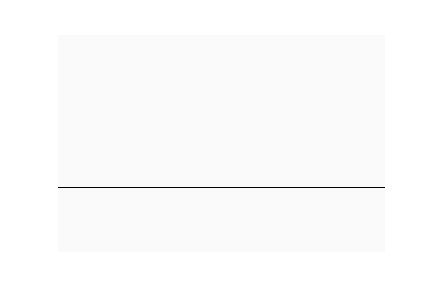
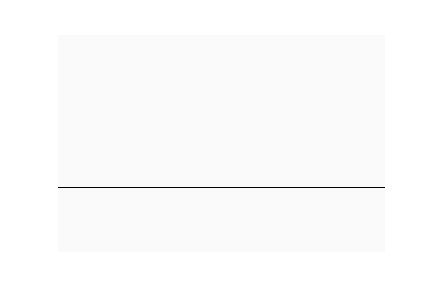
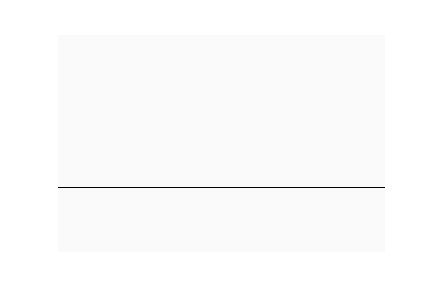
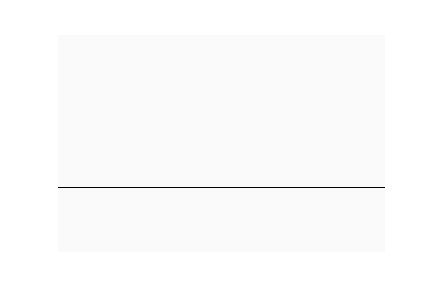
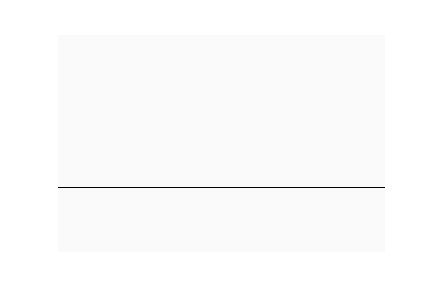
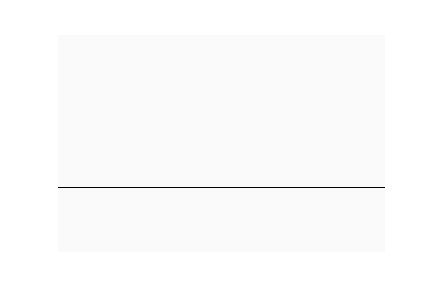
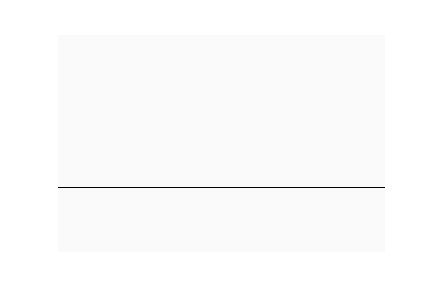
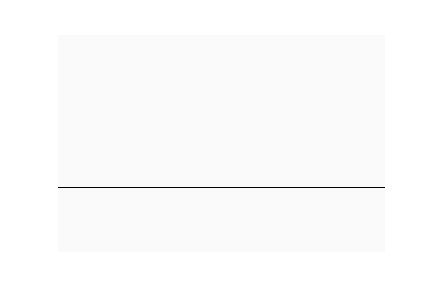
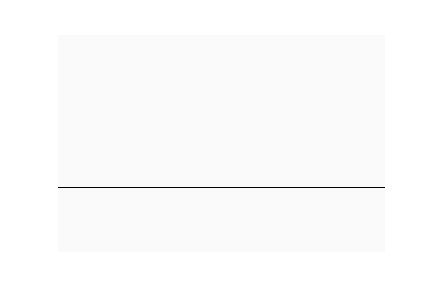
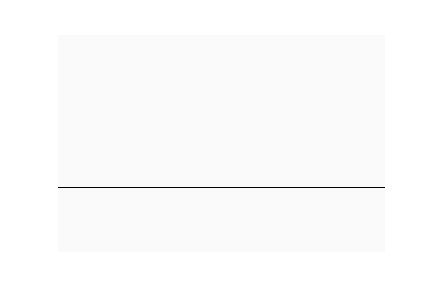
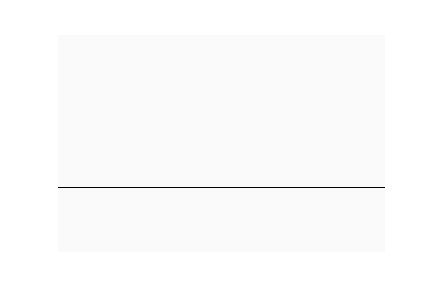
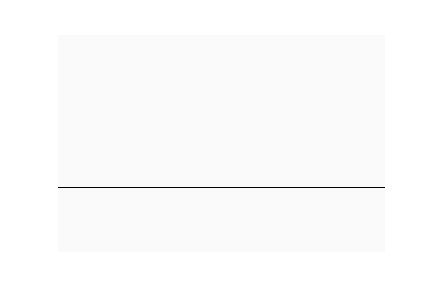
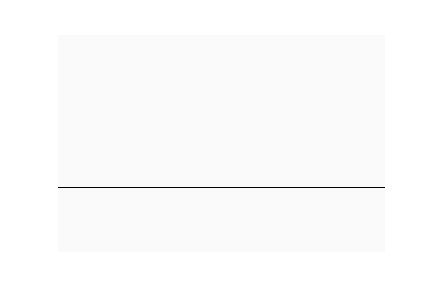
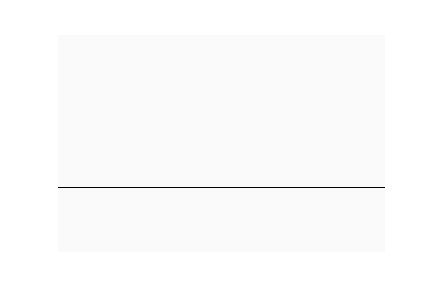
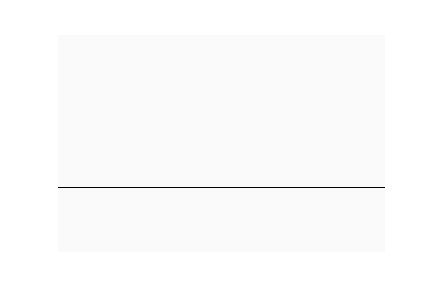
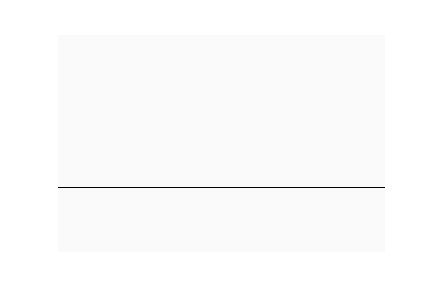
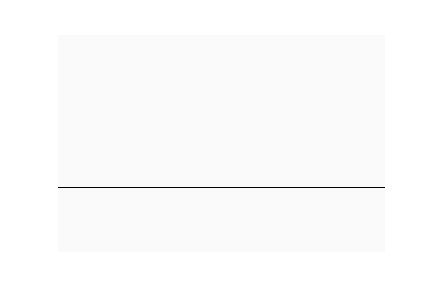
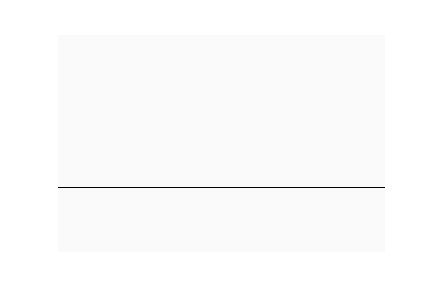
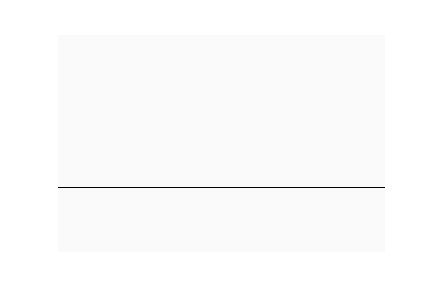
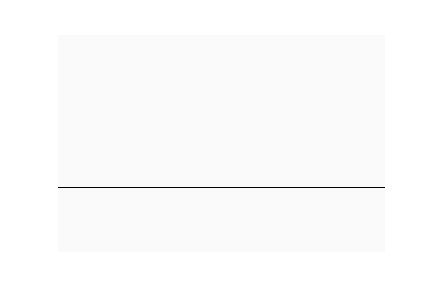
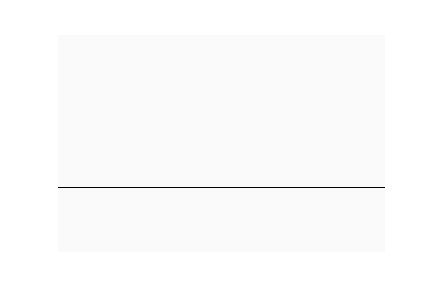
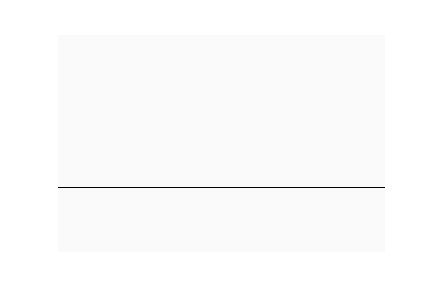
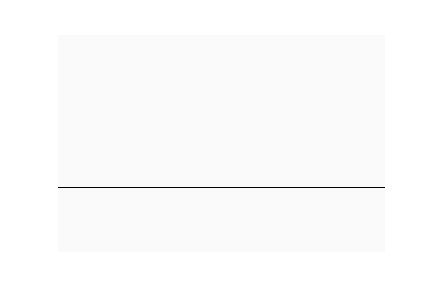
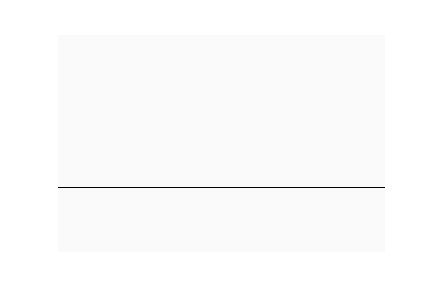
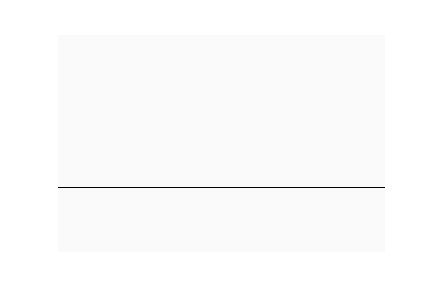
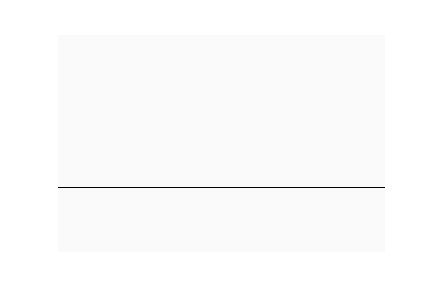
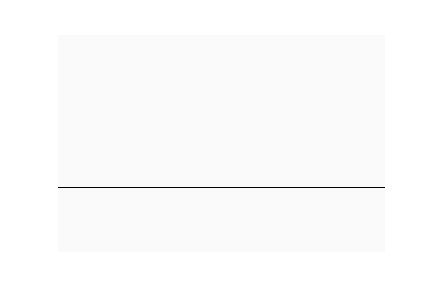
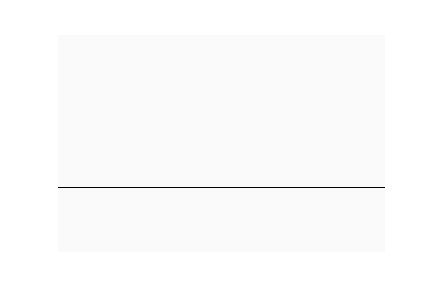
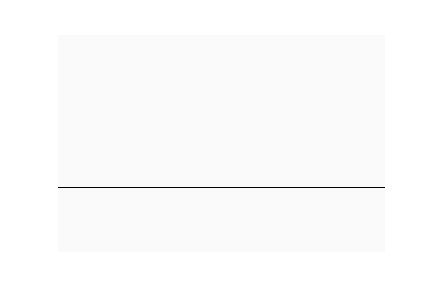
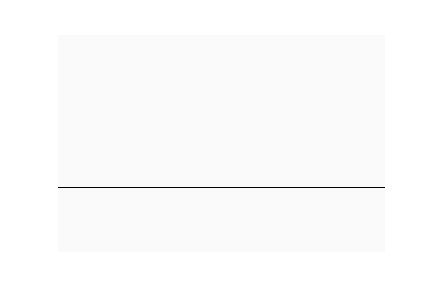
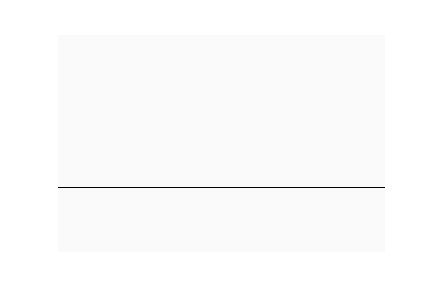
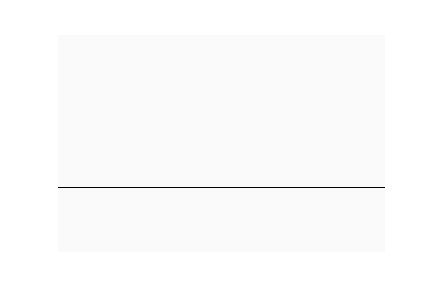
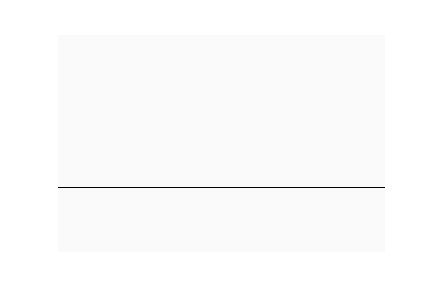
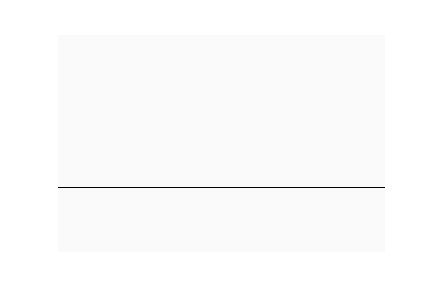
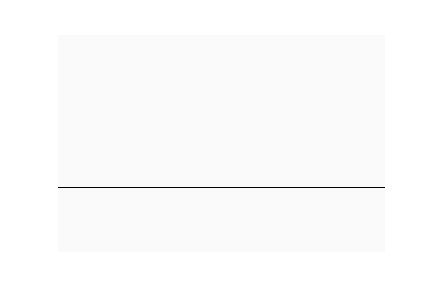
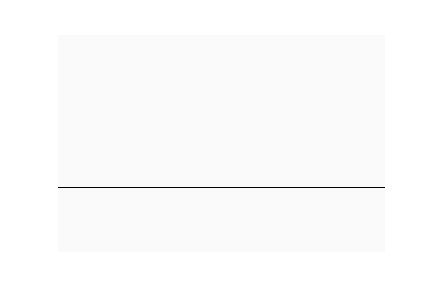
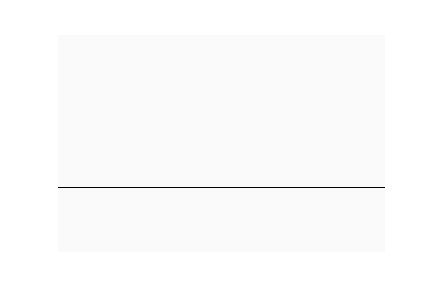
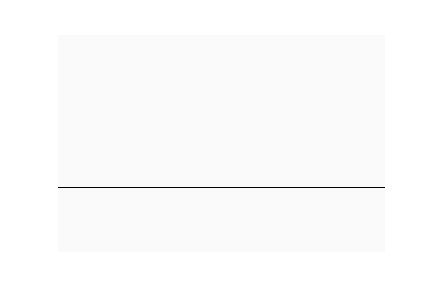
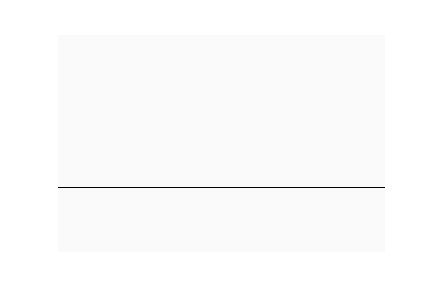
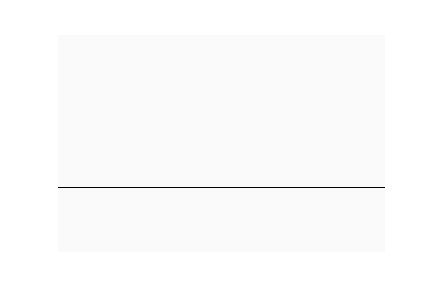
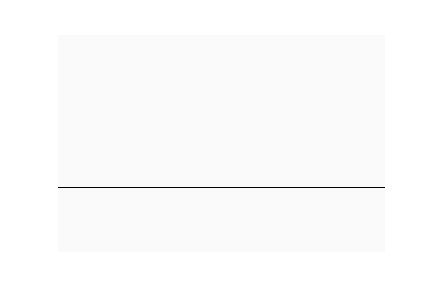
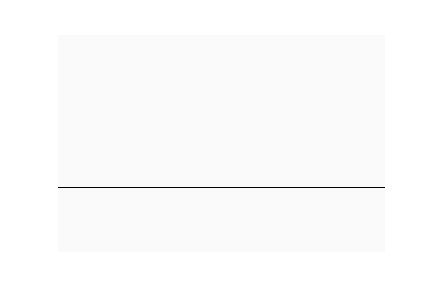
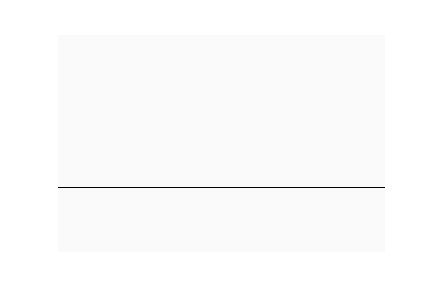
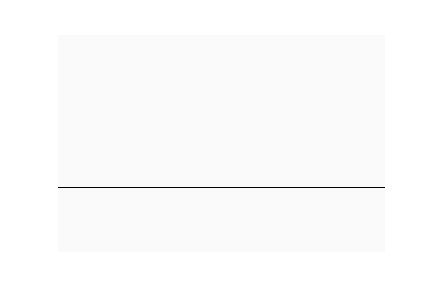
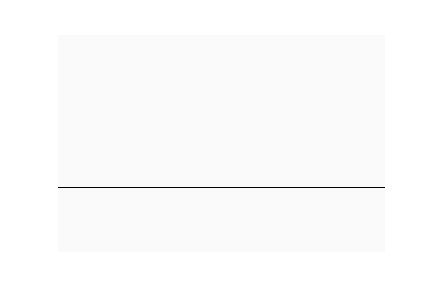
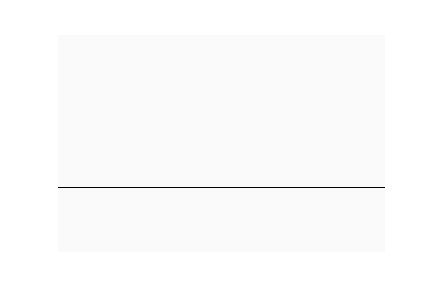
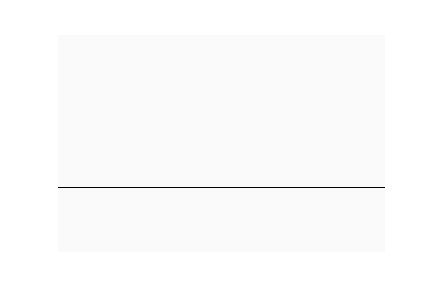
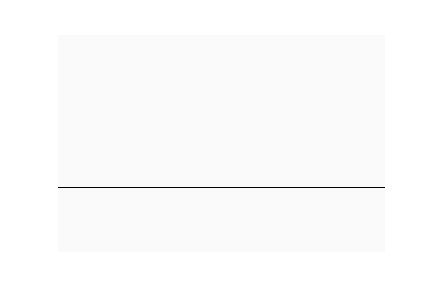
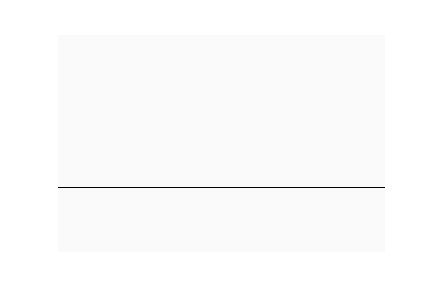
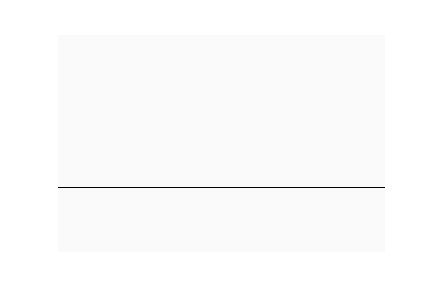
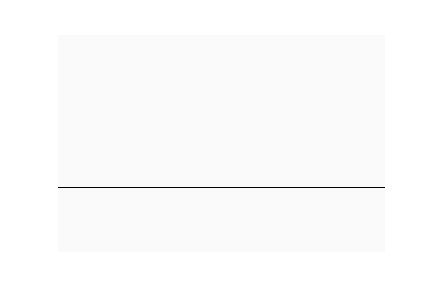
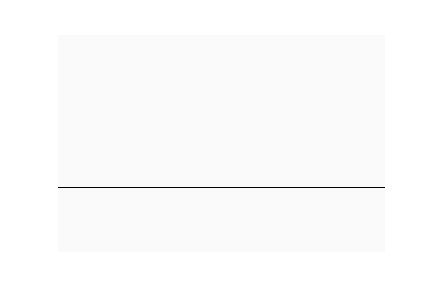
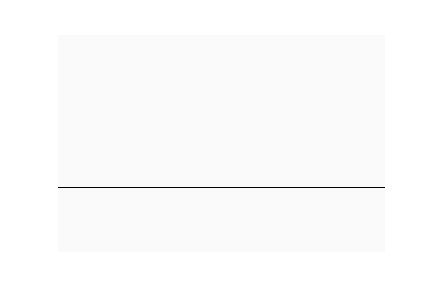
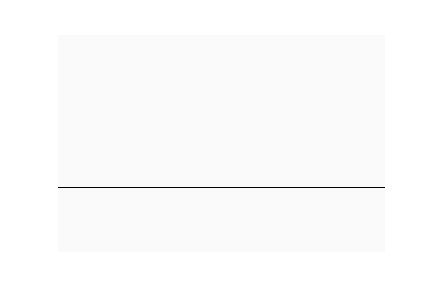
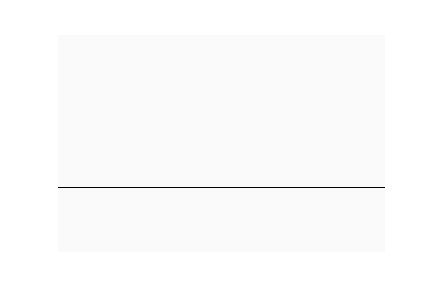
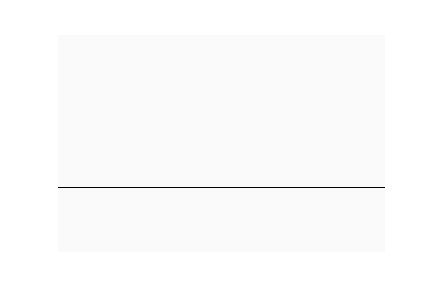
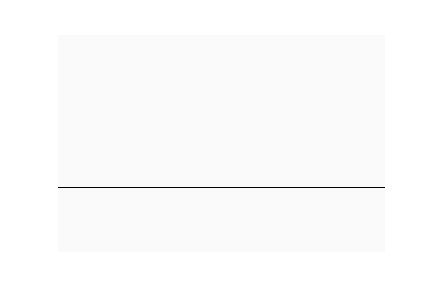
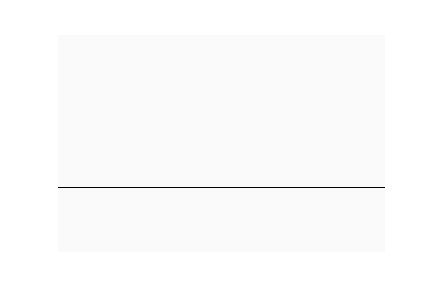
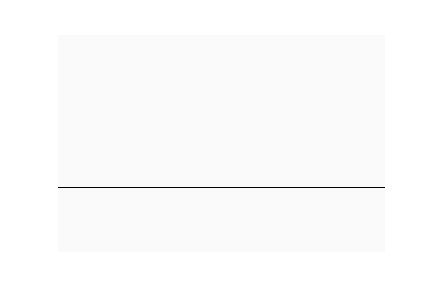
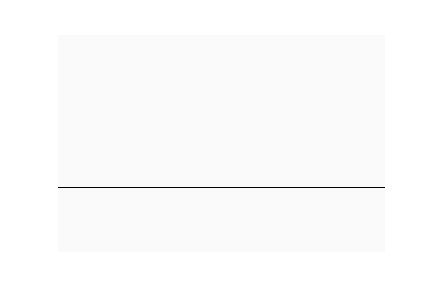
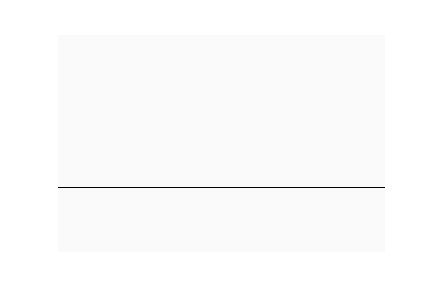
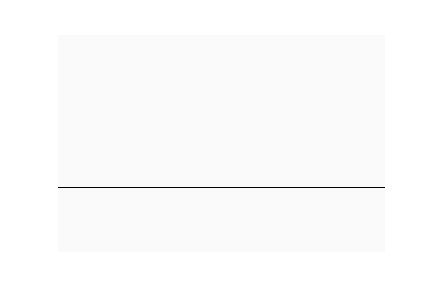
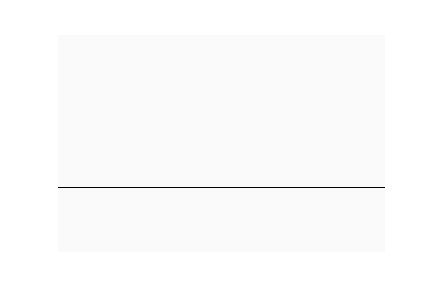
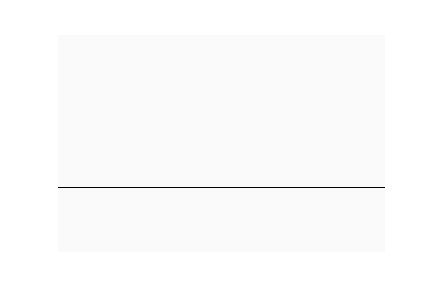
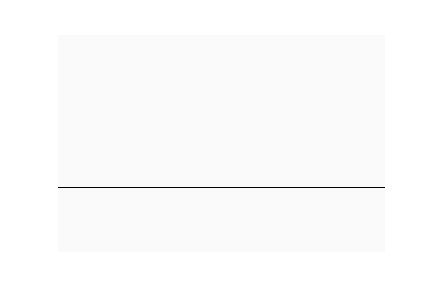
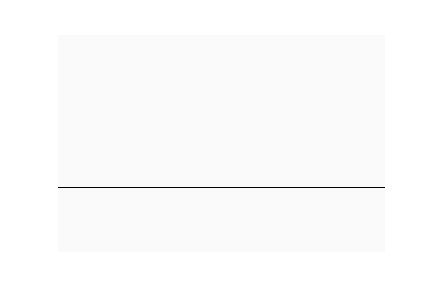
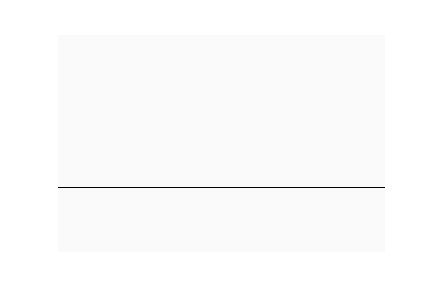
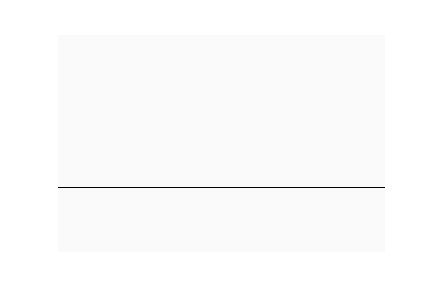
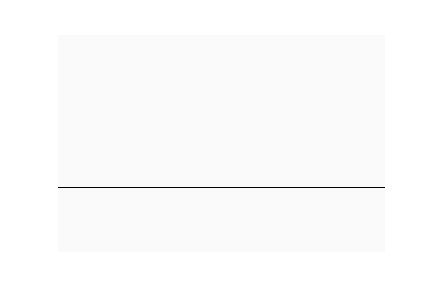
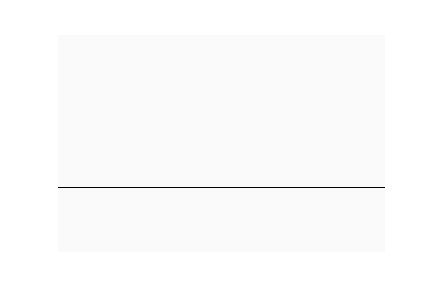
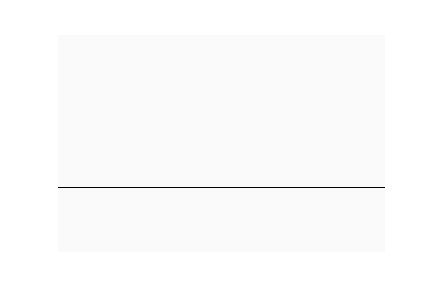
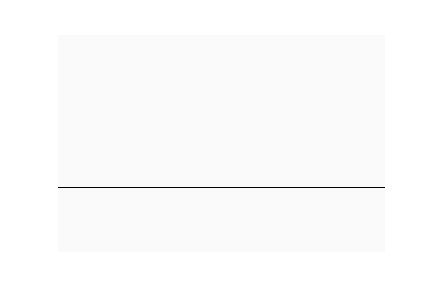
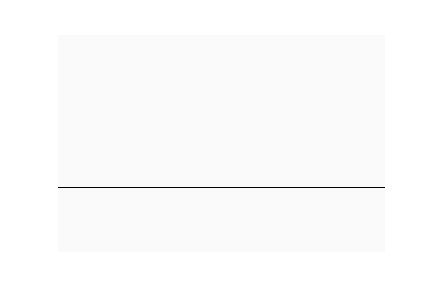
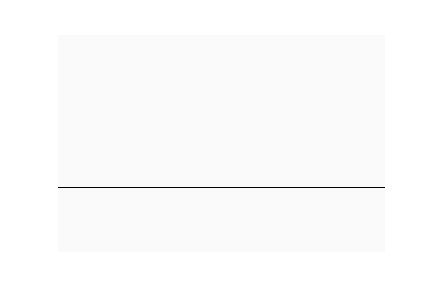
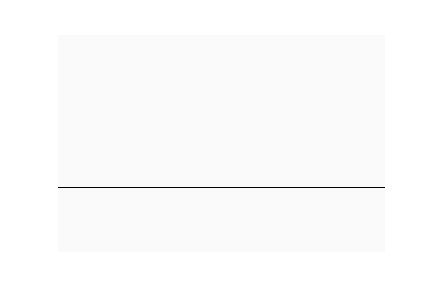
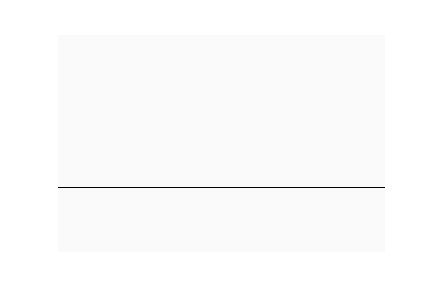
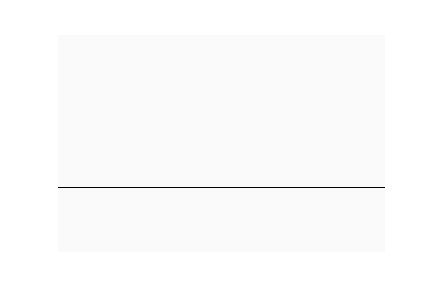
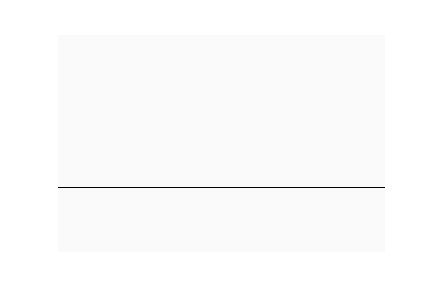
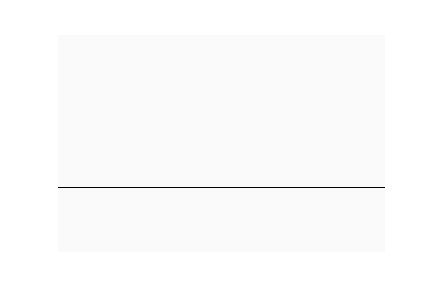
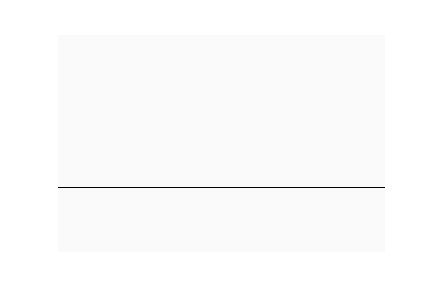
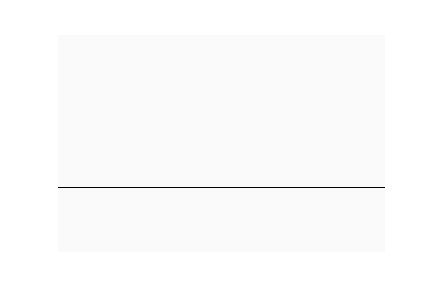
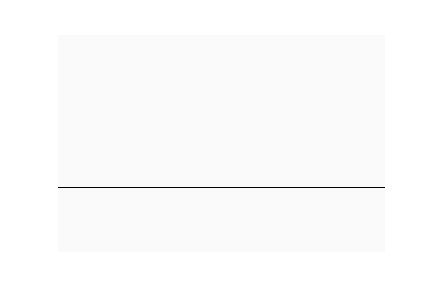
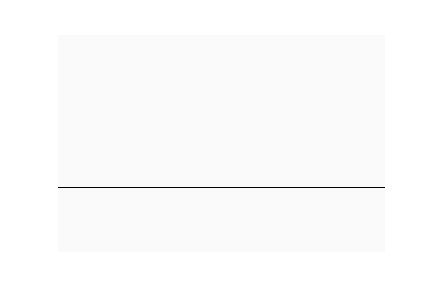
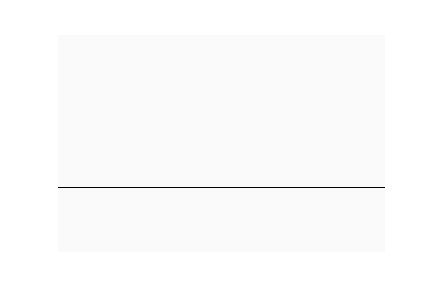
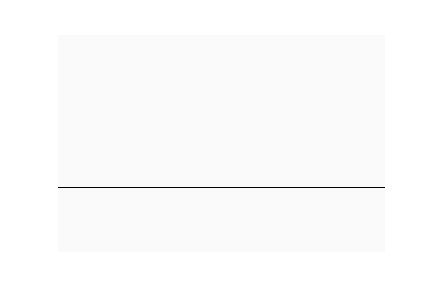
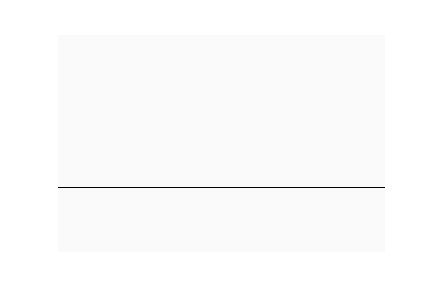
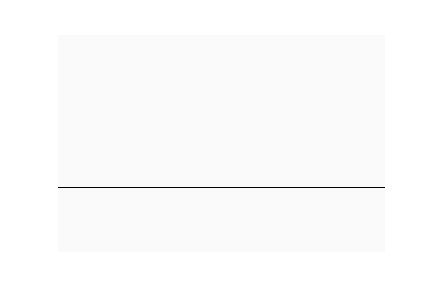
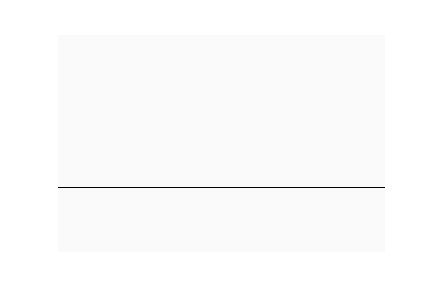
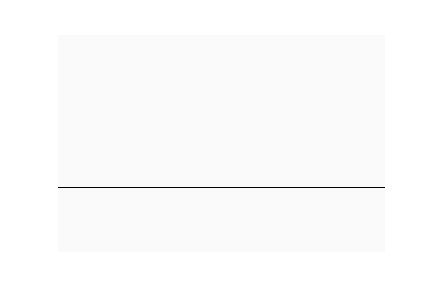
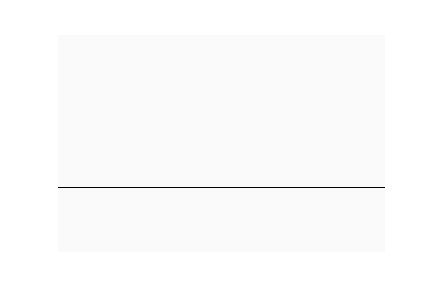
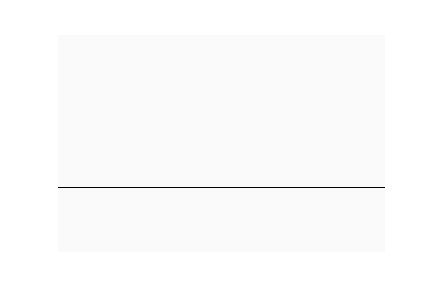
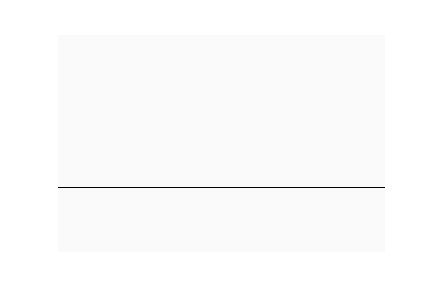
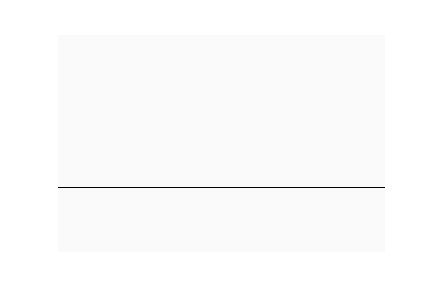
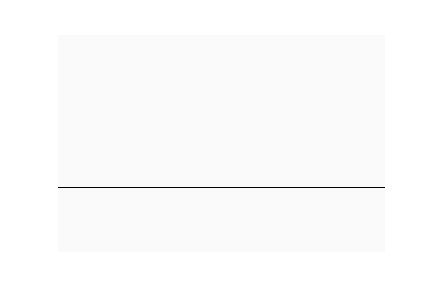
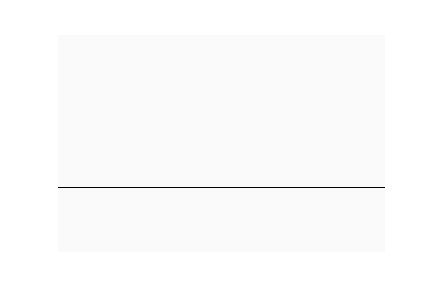
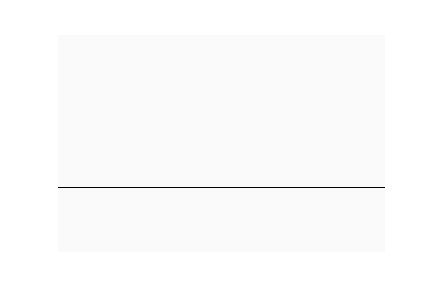
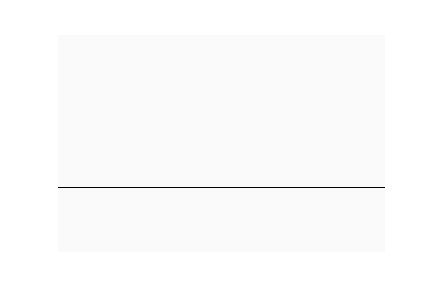
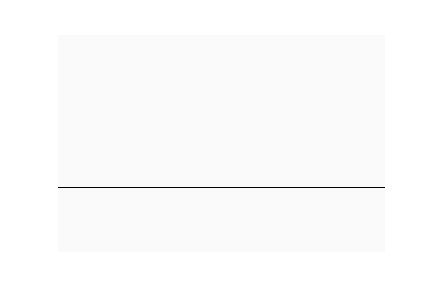
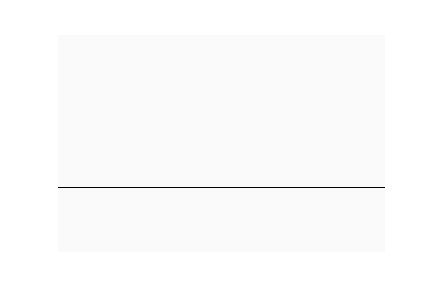
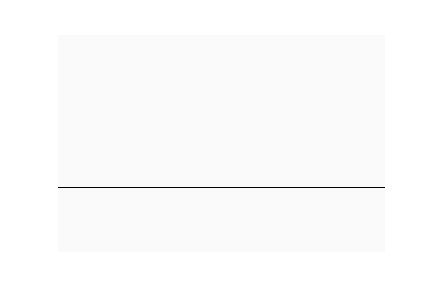
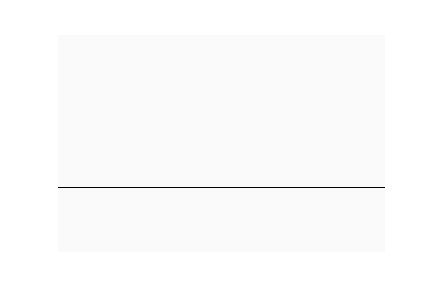
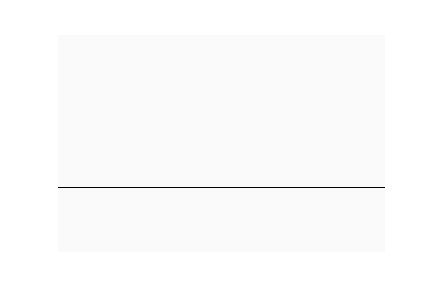
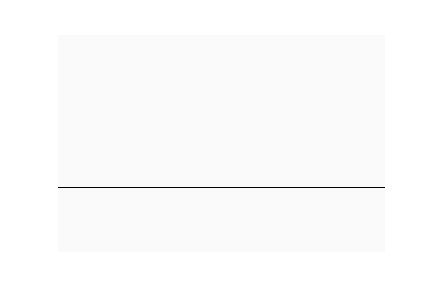
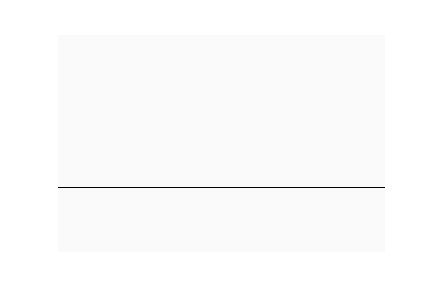
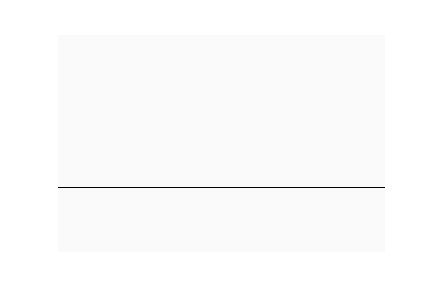
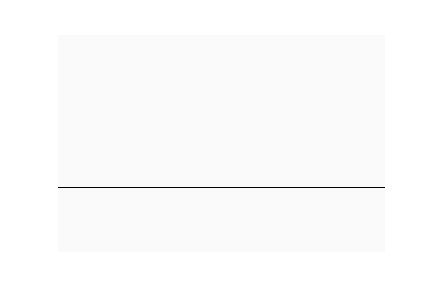
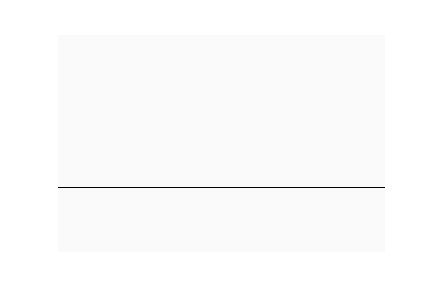
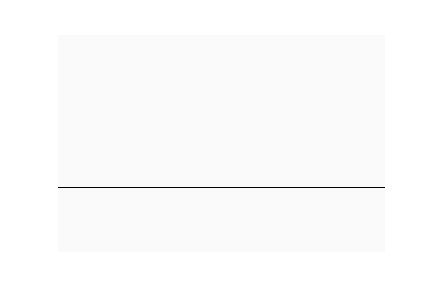
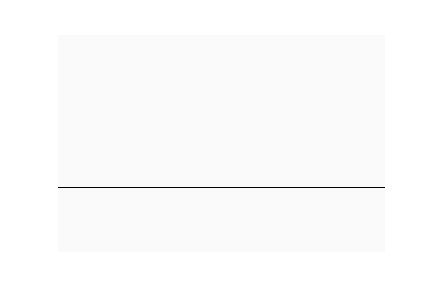
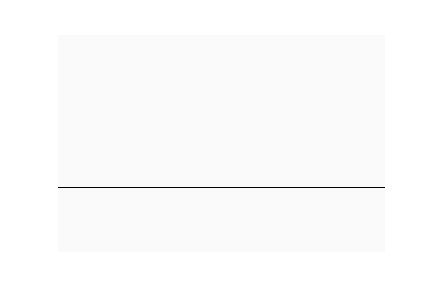
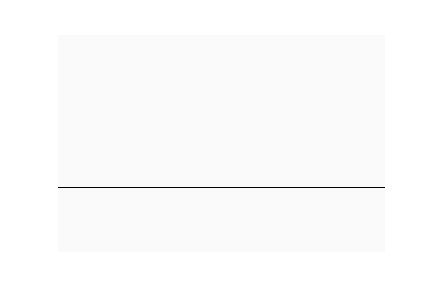
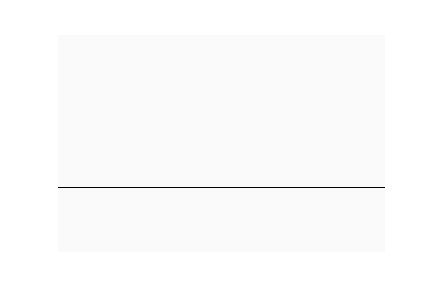
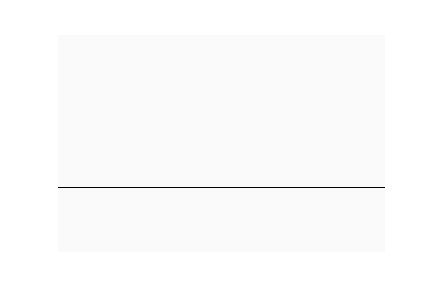
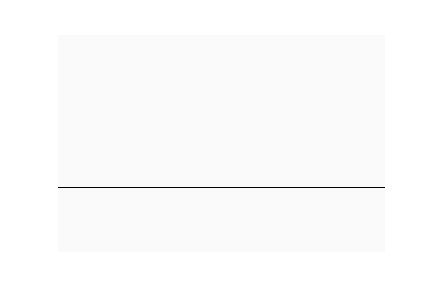
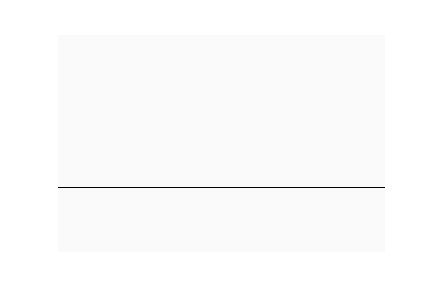
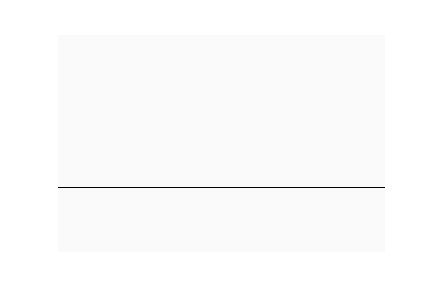
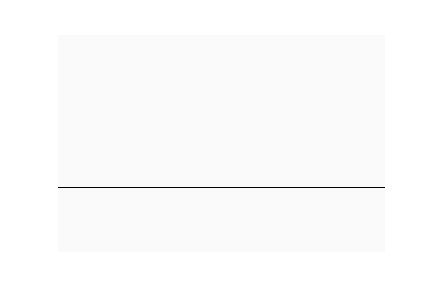
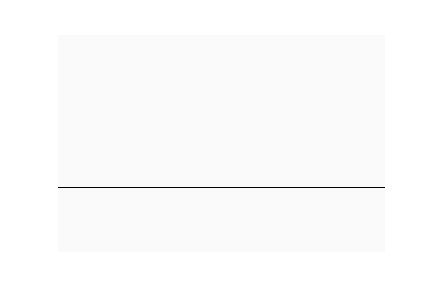
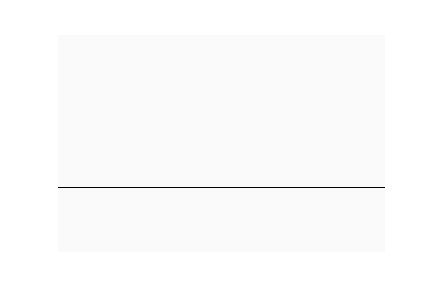
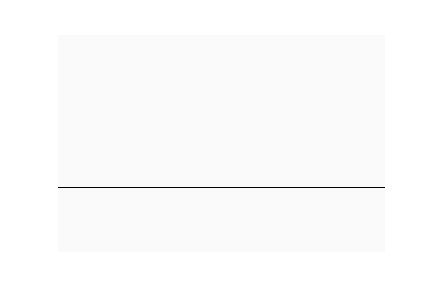
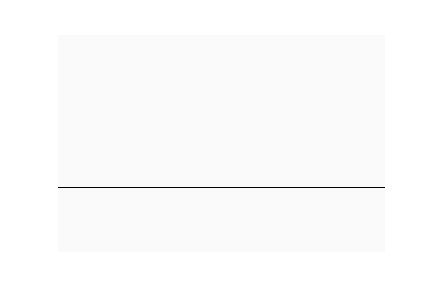
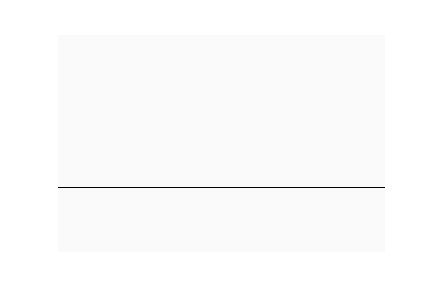
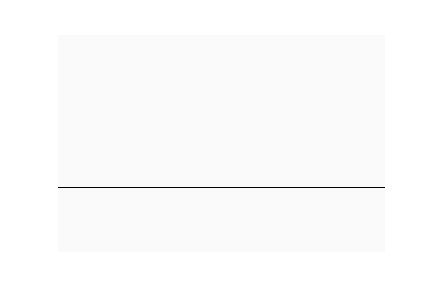
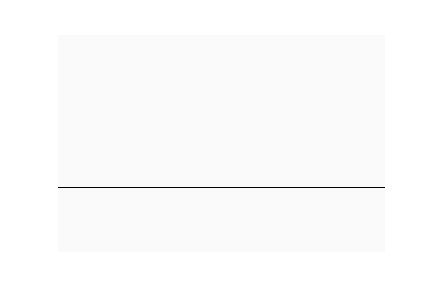
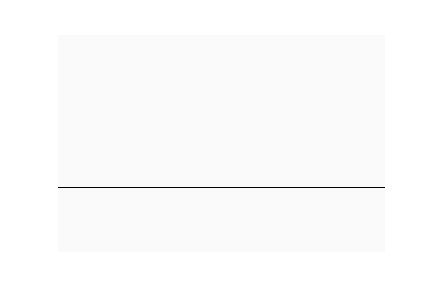
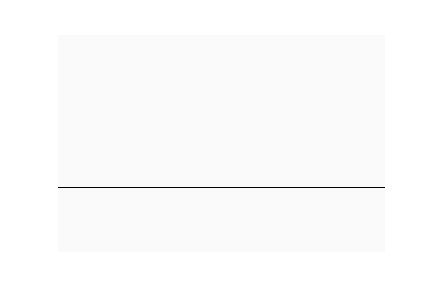
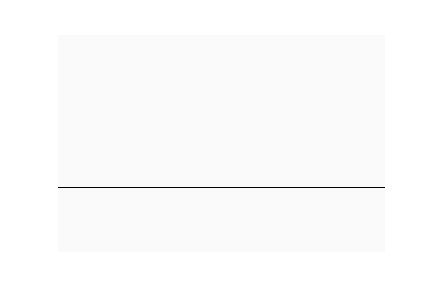
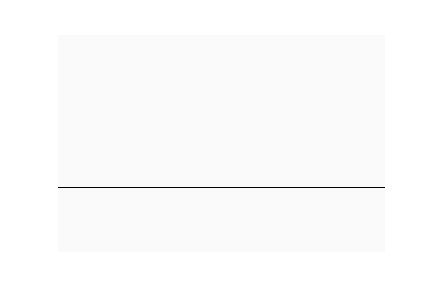
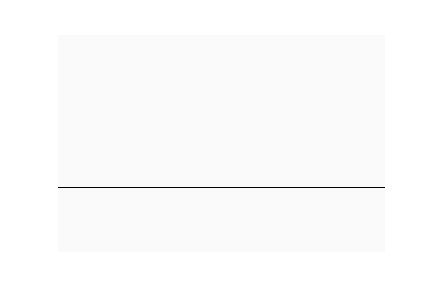
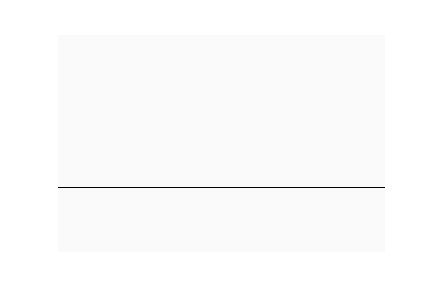
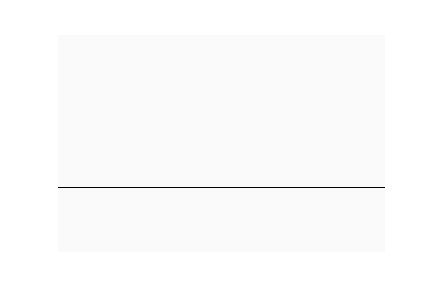
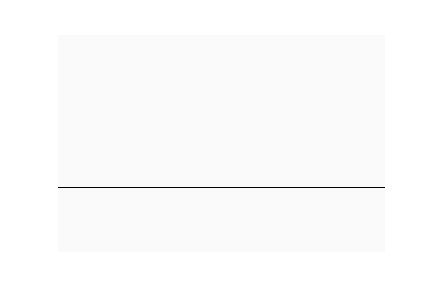
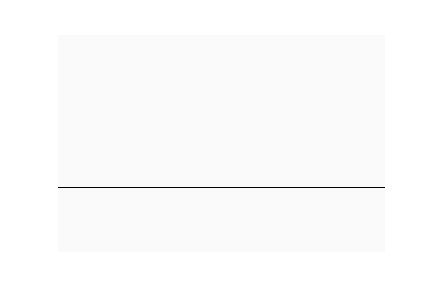
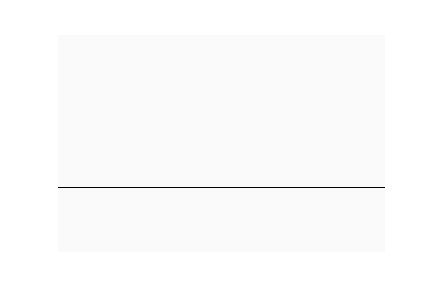
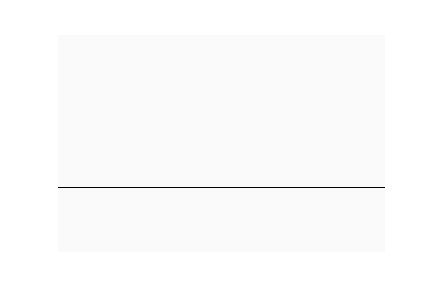
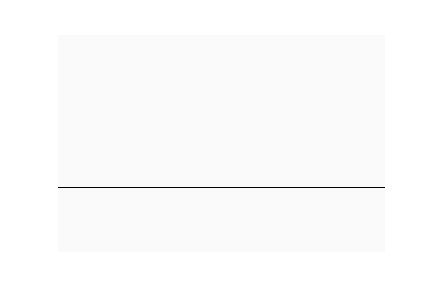
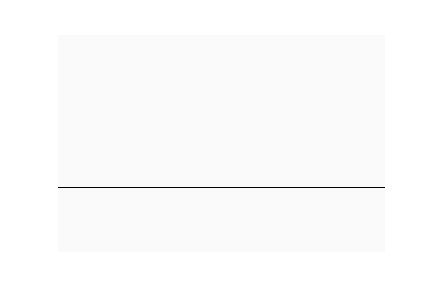
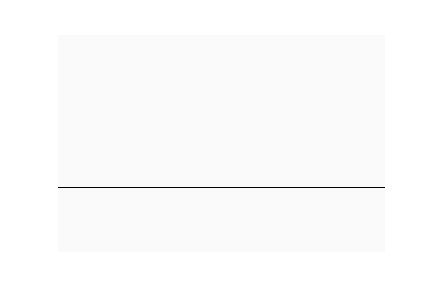
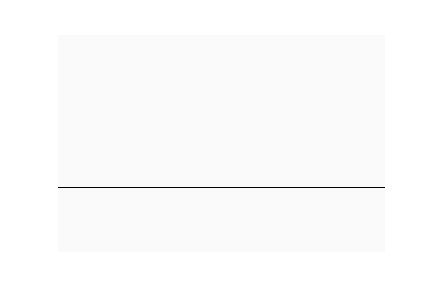
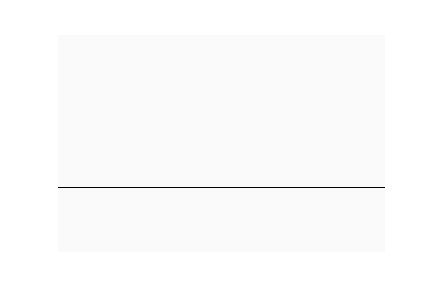
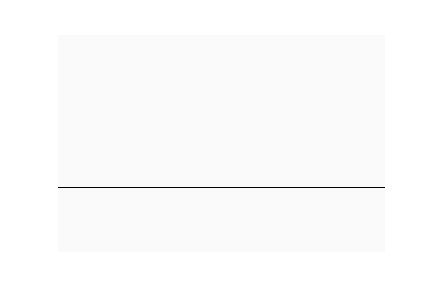
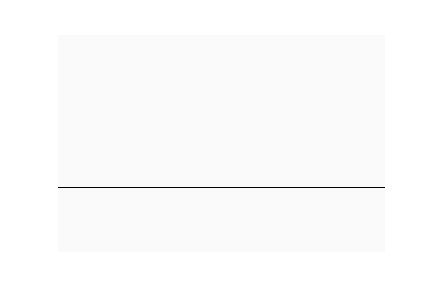
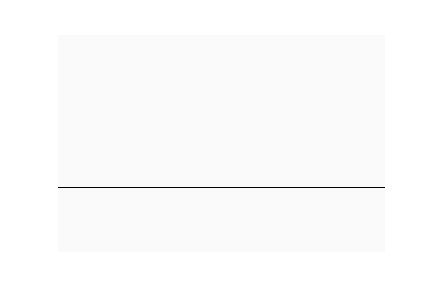
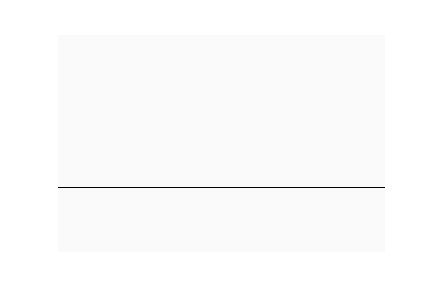
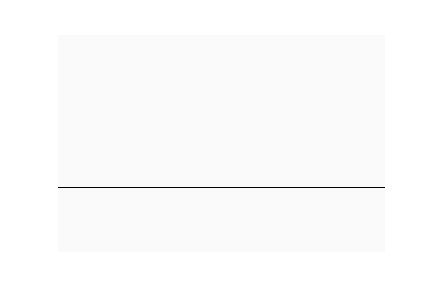
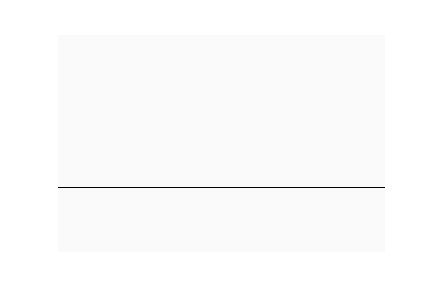
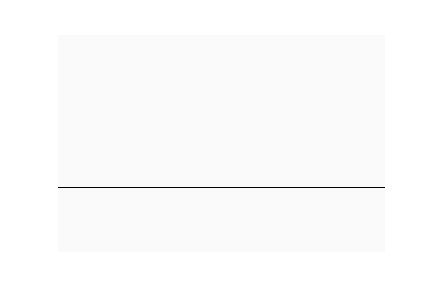
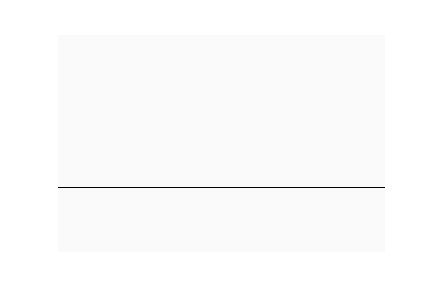
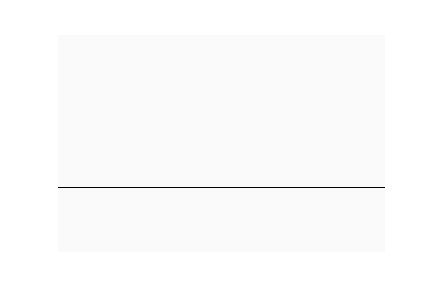
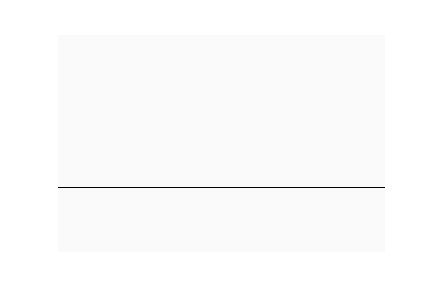
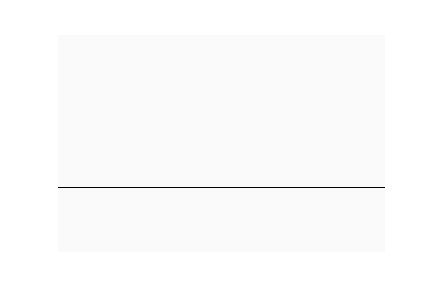
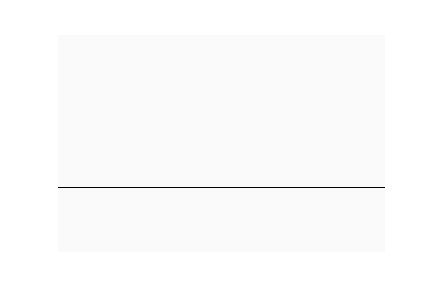
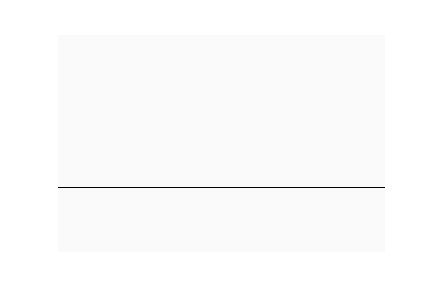
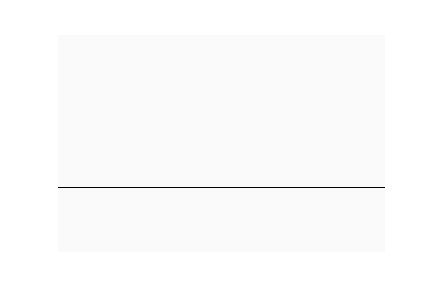
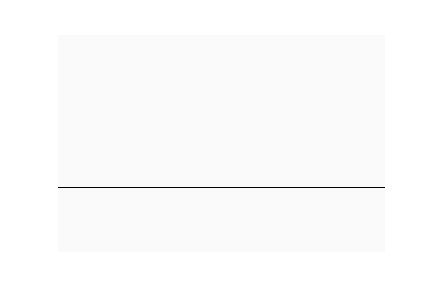
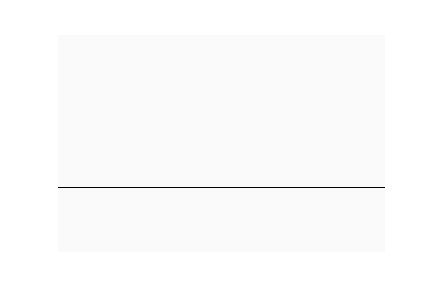
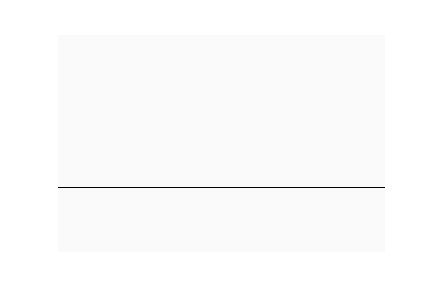
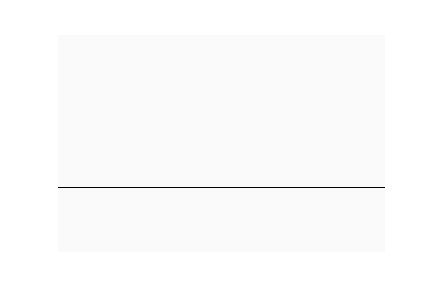
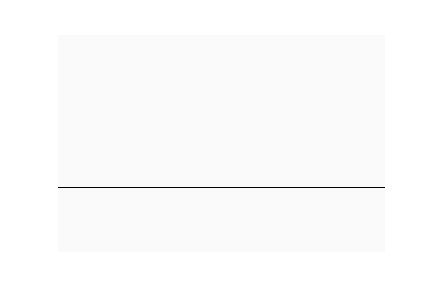
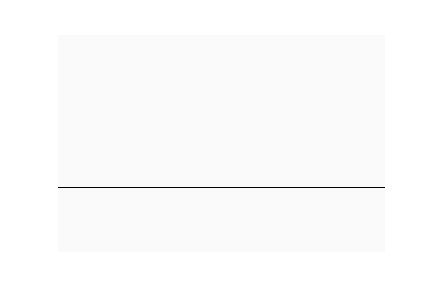
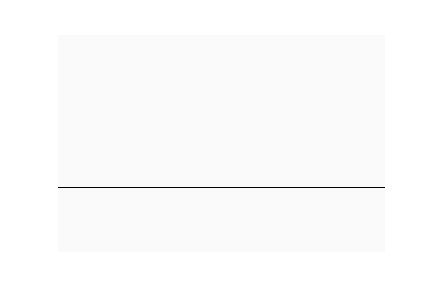
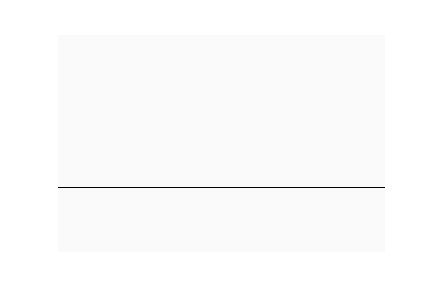
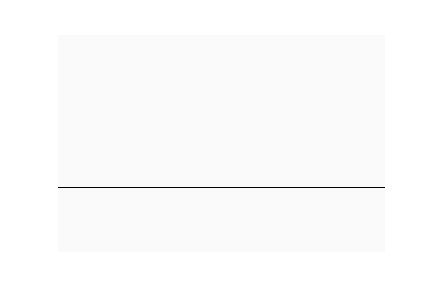
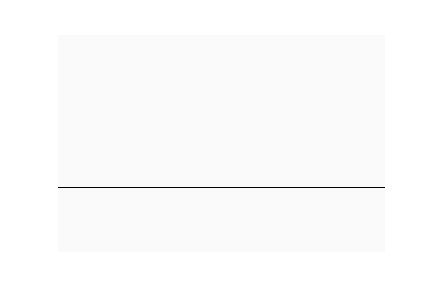
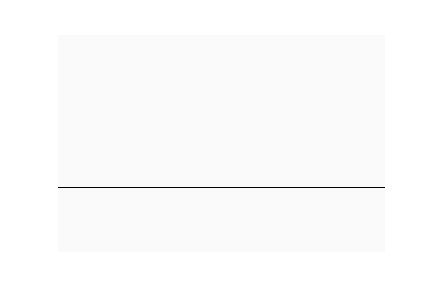
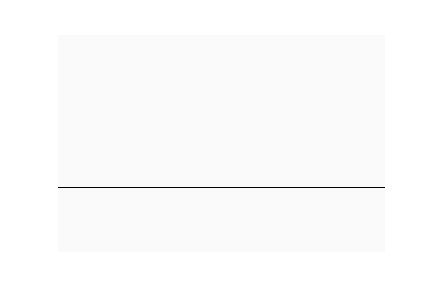
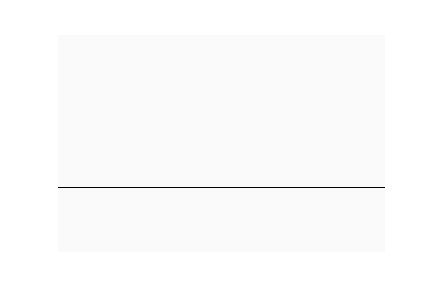
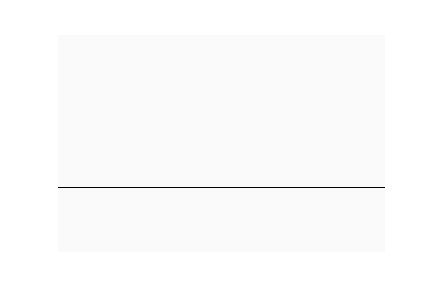
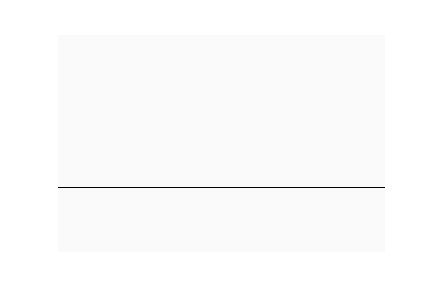
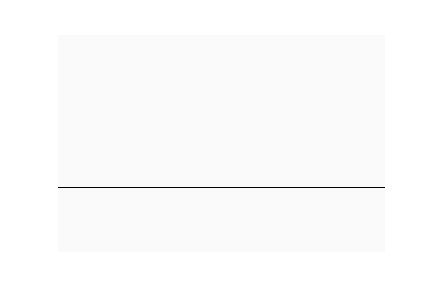
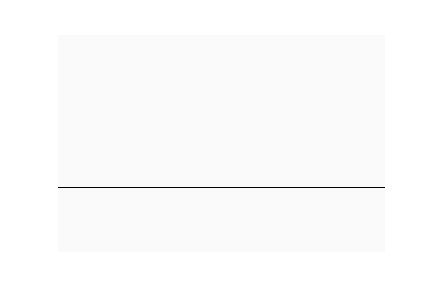
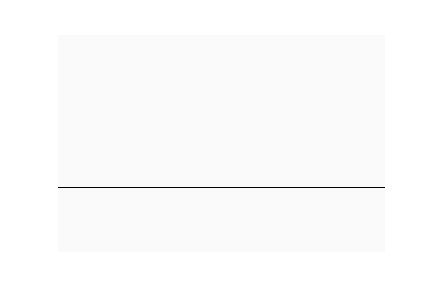
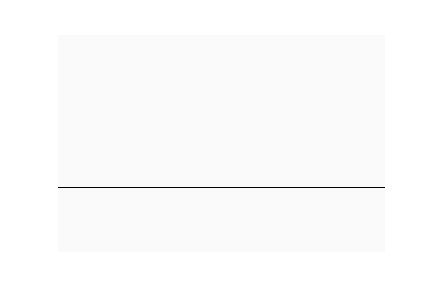
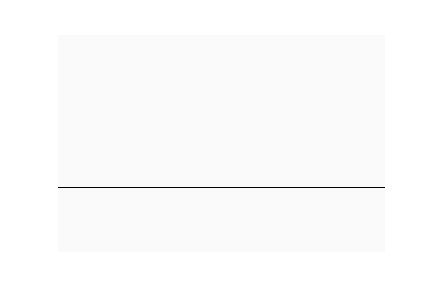
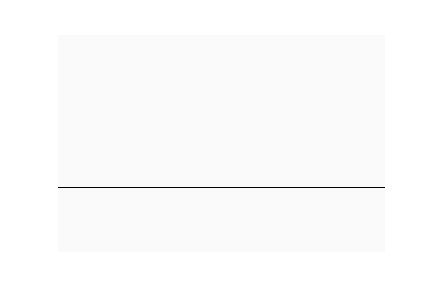
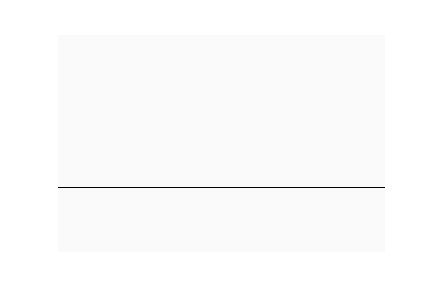
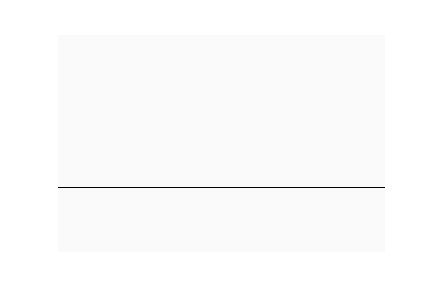
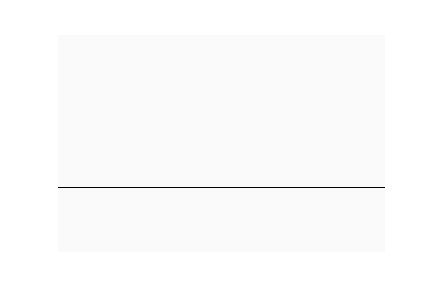
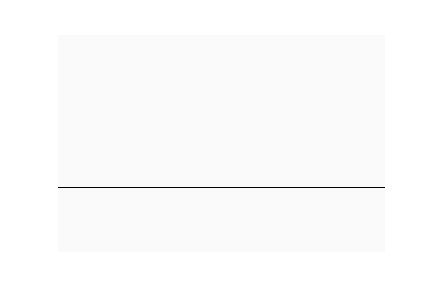
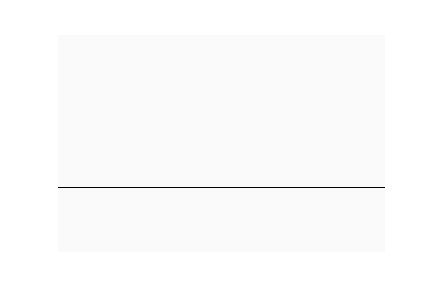
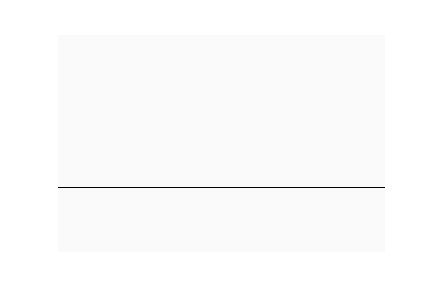
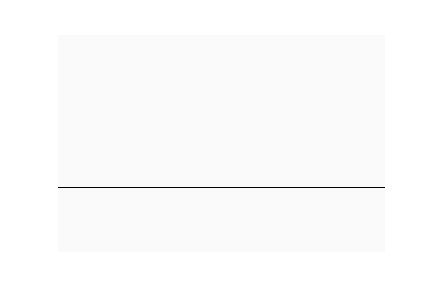

In [10]:
# review solution
with tf.Session() as sess:
    saver.restore(sess, "tmp/model.ckpt")
    s = env.reset()
    view = Viewer(env, custom_render=True)
    for _ in range(1000):
        view.render()
        a = get_action(sess, s, stochastic=False)
        s, r, done, _ = env.step(a)
    view.render(close=True, display_gif=True)

## Exercises

Now it is your turn! Play around the code above and try to make it learn better and faster.

Experiment with the:

* number of timesteps in a batch.
* max length of rollouts.
* discount factor.
* learning rate.
* number of hidden units and layers.


### Exercise 1 

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

### Answer
I made a dense network with 5 hidden layers. Then I set discount factor to 0.93 in order to preserve some reward from previous dicisions. Then I set the number of timesteps to 1000 in order to ensure a stable solution for longer simulations and adjusted the rollout length accordingly (set to 1000). 

### Exercise 2 

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps: [0, 1, 1, 1, 0, 1, 1, 0, 0, 0].*

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*[Hint: See previous notebook.]*

### Answer
* Total reward: $R = 0+1+1+1+0+1+1+0+0+0 = 5$
* Total future rewards: $R_{t_{0-9}} = [t_{0}\, t_{1}\, t_{2}\, t_{3}\, t_{4}\, t_{5}\, t_{6}\, t_{7}\, t_{8}\, t_{9}]^{T} = [5\, 5\, 4\, 3\, 2\, 2\, 1\, 0\, 0\, 0]^{T}$
* Discounted future reward is (see calculation below): $R_{t_{0-9}} = [t_{0}\, t_{1}\, t_{2}\, t_{3}\, t_{4}\, t_{5}\, t_{6}\, t_{7}\, t_{8}\, t_{9}]^{T} = [39.87\, 21.51\, 11.32\, 5.96\, 2.61\, 1.90\, 1.00\, 0.00\, 0.00\, 0.00]^{T}$

In [11]:
gam = 0.9
steps = [0,1,1,1,0,1,1,0,0,0]
Rt = [steps[-1]]
for _x in list(reversed(steps[:-1])):
    Rt.append(_x+sum([_i * gam for _i in Rt]))
print(list(reversed(Rt)))

[39.872780999999996, 21.511989999999997, 11.322099999999999, 5.959, 2.61, 1.9, 1.0, 0.0, 0.0, 0]


### Exercise 3

*In the plot of the training and validation mean reward above, you will sometimes see the validation reward starts out lower than the training reward but later they cross. How can you explain this behavior? [Hint: Do we use the policy network in the same way during training and validation?]*

### Answer
The validation reward is calculated anew on each epoch based on the current policy network only, while the training reward is carried on across epochs according to the discounted future rewards method. Hence the training reward crosses the validation reward whenever the policy network has learned to optimize rewards from the future discounted rewards, better than from the immediate rewards calculated from the current state only.

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma (see the previous notebook for definition)?*

### Answer
Advantage $A$ and baseline $b$ makes the policy _encouraging and discouraging roughly half of the performed actions_.

## Optional exercises:

* **Explore!** Train a policy for a different [environment](https://gym.openai.com/envs/).
* **Let's get real!** Modify the code to work on an environment with a continuous action space. 

## Book Exercise, Chapter 3
As discussed above, one way of expanding the MNIST training data is to use small rotations of training images. What's a problem that might occur if we allow arbitrarily large rotations of training images?

### Answer
One problem with large rotations is that the object in the image (which the network tries to learn) might become something different from its given label. An example on MNIST is if an image labelled '6' gets rotated 180 degrees and looks like a '9' - then the network learns to associate features of a what should be labelled as '9' to that of '6'.